##### Copyright 2020 The TensorFlow Hub Authors.


In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/text/classify_text_with_bert"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/text/classify_text_with_bert.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/classify_text_with_bert.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/text/classify_text_with_bert.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/google/collections/bert/1"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>

# Classify text with BERT

This tutorial contains complete code to fine-tune BERT to perform sentiment analysis on a dataset of plain-text IMDB movie reviews.
In addition to training a model, you will learn how to preprocess text into an appropriate format.

In this notebook, you will:

- Load the IMDB dataset
- Load a BERT model from TensorFlow Hub
- Build your own model by combining BERT with a classifier
- Train your own model, fine-tuning BERT as part of that
- Save your model and use it to classify sentences

If you're new to working with the IMDB dataset, please see [Basic text classification](https://www.tensorflow.org/tutorials/keras/text_classification) for more details.

## About BERT

[BERT](https://arxiv.org/abs/1810.04805) and other Transformer encoder architectures have been wildly successful on a variety of tasks in NLP (natural language processing). They compute vector-space representations of natural language that are suitable for use in deep learning models. The BERT family of models uses the Transformer encoder architecture to process each token of input text in the full context of all tokens before and after, hence the name: Bidirectional Encoder Representations from Transformers. 

BERT models are usually pre-trained on a large corpus of text, then fine-tuned for specific tasks.


## Setup


In [2]:
# A dependency of the preprocessing for BERT inputs
!pip install -q tensorflow-text

You will use the AdamW optimizer from [tensorflow/models](https://github.com/tensorflow/models).

In [3]:
!pip install -q tf-models-official

In [4]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optmizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

## Sentiment Analysis

This notebook trains a sentiment analysis model to classify movie reviews as *positive* or *negative*, based on the text of the review.

You'll use the [Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/) that contains the text of 50,000 movie reviews from the [Internet Movie Database](https://www.imdb.com/).

### Download the IMDB dataset

Let's download and extract the dataset, then explore the directory structure.


In [5]:
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

train_dir = os.path.join(dataset_dir, 'train')

# remove unused folders to make it easier to load the data
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

    8192/84125825 [..............................] - ETA: 23:19

   24576/84125825 [..............................] - ETA: 15:34

   40960/84125825 [..............................] - ETA: 14:01

   73728/84125825 [..............................] - ETA: 10:23

  106496/84125825 [..............................] - ETA: 8:59 

  139264/84125825 [..............................] - ETA: 8:14

  188416/84125825 [..............................] - ETA: 7:06

  253952/84125825 [..............................] - ETA: 6:01

  319488/84125825 [..............................] - ETA: 5:22

  385024/84125825 [..............................] - ETA: 4:57

  483328/84125825 [..............................] - ETA: 4:20

  598016/84125825 [..............................] - ETA: 3:49

  712704/84125825 [..............................] - ETA: 3:28

  876544/84125825 [..............................] - ETA: 3:01

 1056768/84125825 [..............................] - ETA: 2:41

 1302528/84125825 [..............................] - ETA: 2:19

 1613824/84125825 [..............................] - ETA: 1:58

 1990656/84125825 [..............................] - ETA: 1:41

 2465792/84125825 [..............................] - ETA: 1:26

 3055616/84125825 [>.............................] - ETA: 1:12

 3776512/84125825 [>.............................] - ETA: 1:01

 4644864/84125825 [>.............................] - ETA: 51s 

 5709824/84125825 [=>............................] - ETA: 43s

 7004160/84125825 [=>............................] - ETA: 36s

 8560640/84125825 [==>...........................] - ETA: 29s

 8757248/84125825 [==>...........................] - ETA: 29s

10477568/84125825 [==>...........................] - ETA: 24s

12673024/84125825 [===>..........................] - ETA: 20s

12959744/84125825 [===>..........................] - ETA: 20s

15360000/84125825 [====>.........................] - ETA: 17s

18243584/84125825 [=====>........................] - ETA: 14s

20635648/84125825 [======>.......................] - ETA: 12s

23748608/84125825 [=======>......................] - ETA: 10s

23764992/84125825 [=======>......................] - ETA: 10s

26894336/84125825 [========>.....................] - ETA: 9s 

29974528/84125825 [=========>....................] - ETA: 8s

32972800/84125825 [==========>...................] - ETA: 7s

33103872/84125825 [==========>...................] - ETA: 7s

35774464/84125825 [===========>..................] - ETA: 6s

36151296/84125825 [===========>..................] - ETA: 6s

38330368/84125825 [============>.................] - ETA: 5s

38936576/84125825 [============>.................] - ETA: 5s

41328640/84125825 [=============>................] - ETA: 5s

42065920/84125825 [==============>...............] - ETA: 5s

44113920/84125825 [==============>...............] - ETA: 4s

44900352/84125825 [===============>..............] - ETA: 4s

46735360/84125825 [===============>..............] - ETA: 4s

47718400/84125825 [================>.............] - ETA: 4s

49471488/84125825 [================>.............] - ETA: 3s

50683904/84125825 [=================>............] - ETA: 3s

52199424/84125825 [=================>............] - ETA: 3s

53813248/84125825 [==================>...........] - ETA: 3s

54894592/84125825 [==================>...........] - ETA: 3s

56516608/84125825 [===================>..........] - ETA: 2s

57712640/84125825 [===================>..........] - ETA: 2s

59318272/84125825 [====================>.........] - ETA: 2s

60579840/84125825 [====================>.........] - ETA: 2s

62332928/84125825 [=====================>........] - ETA: 2s

63332352/84125825 [=====================>........] - ETA: 1s

65396736/84125825 [======================>.......] - ETA: 1s

66347008/84125825 [======================>.......] - ETA: 1s

68231168/84125825 [=======================>......] - ETA: 1s

69345280/84125825 [=======================>......] - ETA: 1s

71229440/84125825 [========================>.....] - ETA: 1s

72228864/84125825 [========================>.....] - ETA: 1s

73801728/84125825 [=========================>....] - ETA: 0s

75046912/84125825 [=========================>....] - ETA: 0s

76881920/84125825 [==========================>...] - ETA: 0s

77832192/84125825 [==========================>...] - ETA: 0s

79994880/84125825 [===========================>..] - ETA: 0s

80928768/84125825 [===========================>..] - ETA: 0s

83140608/84125825 [============================>.] - ETA: 0s

84041728/84125825 [============================>.] - ETA: 0s

84131840/84125825 [==============================] - 7s 0us/step


Next, you will use the `text_dataset_from_directory` utility to create a labeled `tf.data.Dataset`.

The IMDB dataset has already been divided into train and test, but it lacks a validation set. Let's create a validation set using an 80:20 split of the training data by using the `validation_split` argument below.

Note:  When using the `validation_split` and `subset` arguments, make sure to either specify a random seed, or to pass `shuffle=False`, so that the validation and training splits have no overlap.

In [6]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


Found 25000 files belonging to 2 classes.


Let's take a look at a few reviews.

In [7]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(3):
    print(f'Review: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label} ({class_names[label]})')

Review: b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label : 0 (neg)
Review: b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they

## Loading models from TensorFlow Hub

Here you can choose which BERT model you will load from TensorFlow Hub and fine-tune. There are multiple BERT models available.

  - [BERT-Base](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3), [Uncased](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3) and [seven more models](https://tfhub.dev/google/collections/bert/1) with trained weights released by the original BERT authors.
  - [Small BERTs](https://tfhub.dev/google/collections/bert/1) have the same general architecture but fewer and/or smaller Transformer blocks, which lets you explore tradeoffs between speed, size and quality.
  - [ALBERT](https://tfhub.dev/google/collections/albert/1): four different sizes of "A Lite BERT" that reduces model size (but not computation time) by sharing parameters between layers.
  - [BERT Experts](https://tfhub.dev/google/collections/experts/bert/1): eight models that all have the BERT-base architecture but offer a choice between different pre-training domains, to align more closely with the target task.
  - [Electra](https://tfhub.dev/google/collections/electra/1) has the same architecture as BERT (in three different sizes), but gets pre-trained as a discriminator in a set-up that resembles a Generative Adversarial Network (GAN).
  - BERT with Talking-Heads Attention and Gated GELU [[base](https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1), [large](https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_large/1)] has two improvements to the core of the Transformer architecture.

The model documentation on TensorFlow Hub has more details and references to the
research literature. Follow the links above, or click on the [`tfhub.dev`](http://tfhub.dev) URL
printed after the next cell execution.

The suggestion is to start with a Small BERT (with fewer parameters) since they are faster to fine-tune. If you like a small model but with higher accuracy, ALBERT might be your next option. If you want even better accuracy, choose
one of the classic BERT sizes or their recent refinements like Electra, Talking Heads, or a BERT Expert.

Aside from the models available below, there are [multiple versions](https://tfhub.dev/google/collections/transformer_encoders_text/1) of the models that are larger and can yield even better accuracy, but they are too big to be fine-tuned on a single GPU. You will be able to do that on the [Solve GLUE tasks using BERT on a TPU colab](https://www.tensorflow.org/tutorials/text/solve_glue_tasks_using_bert_on_tpu).

You'll see in the code below that switching the tfhub.dev URL is enough to try any of these models, because all the differences between them are encapsulated in the SavedModels from TF Hub.

In [8]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


## The preprocessing model

Text inputs need to be transformed to numeric token ids and arranged in several Tensors before being input to BERT. TensorFlow Hub provides a matching preprocessing model for each of the BERT models discussed above, which implements this transformation using TF ops from the TF.text library. It is not necessary to run pure Python code outside your TensorFlow model to preprocess text.

The preprocessing model must be the one referenced by the documentation of the BERT model, which you can read at the URL printed above. For BERT models from the drop-down above, the preprocessing model is selected automatically.

Note: You will load the preprocessing model into a [hub.KerasLayer](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer) to compose your fine-tuned model. This is the preferred API to load a TF2-style SavedModel from TF Hub into a Keras model.

In [9]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

Let's try the preprocessing model on some text and see the output:

In [10]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_type_ids', 'input_mask', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


As you can see, now you have the 3 outputs from the preprocessing that a BERT model would use (`input_words_id`, `input_mask` and `input_type_ids`).

Some other important points:
- The input is truncated to 128 tokens. The number of tokens can be customized, and you can see more details on the [Solve GLUE tasks using BERT on a TPU colab](https://www.tensorflow.org/tutorials/text/solve_glue_tasks_using_bert_on_tpu).
- The `input_type_ids` only have one value (0) because this is a single sentence input. For a multiple sentence input, it would have one number for each input.

Since this text preprocessor is a TensorFlow model, It can be included in your model directly.

## Using the BERT model

Before putting BERT into your own model, let's take a look at its outputs. You will load it from TF Hub and see the returned values.

In [11]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [12]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.76262873  0.9928097  -0.18611881  0.36673862  0.15233737  0.6550447
  0.9681153  -0.9486272   0.00216161 -0.9877732   0.06842697 -0.9763058 ]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.28946346  0.34321272  0.33231515 ...  0.21300808  0.71020764
  -0.05771098]
 [-0.28742087  0.31980985 -0.23018607 ...  0.58455014 -0.21329728
   0.72692114]
 [-0.6615697   0.6887685  -0.87432986 ...  0.10877222 -0.2617324
   0.4785539 ]
 ...
 [-0.22561133 -0.2892562  -0.07064445 ...  0.47565985  0.83277136
   0.40025374]
 [-0.29824236 -0.27473187 -0.05450562 ...  0.48849723  1.0955356
   0.1816333 ]
 [-0.4437813   0.00930756  0.07223685 ...  0.17290069  1.1833248
   0.07897997]]


The BERT models return a map with 3 important keys: `pooled_output`, `sequence_output`, `encoder_outputs`:

- `pooled_output` to represent each input sequence as a whole. The shape is `[batch_size, H]`. You can think of this as an embedding for the entire movie review.
- `sequence_output` represents each input token in the context. The shape is `[batch_size, seq_length, H]`. You can think of this as a contextual embedding for every token in the movie review.
- `encoder_outputs` are the intermediate activations of the `L` Transformer blocks. `outputs["encoder_outputs"][i]` is a Tensor of shape `[batch_size, seq_length, 1024]` with the outputs of the i-th Transformer block, for `0 <= i < L`. The last value of the list is equal to `sequence_output`.

For the fine-tuning you are going to use the `pooled_output` array.

## Define your model

You will create a very simple fine-tuned model, with the preprocessing model, the selected BERT model, one Dense and a Dropout layer.

Note: for more information about the base model's input and output you can use just follow the model's url for documentation. Here specifically you don't need to worry about it because the preprocessing model will take care of that for you.


In [13]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

Let's check that the model runs with the output of the preprocessing model.

In [14]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.5588537]], shape=(1, 1), dtype=float32)


The output is meaningless, of course, because the model has not been trained yet.

Let's take a look at the model's structure.

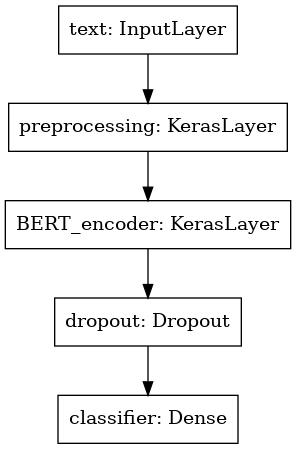

In [15]:
tf.keras.utils.plot_model(classifier_model)

## Model training

You now have all the pieces to train a model, including the preprocessing module, BERT encoder, data, and classifier.

### Loss function

Since this is a binary classification problem and the model outputs a probability (a single-unit layer), you'll use `losses.BinaryCrossentropy` loss function.


In [16]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

### Optimizer

For fine-tuning, let's use the same optimizer that BERT was originally trained with: the "Adaptive Moments" (Adam). This optimizer minimizes the prediction loss and does regularization by weight decay (not using moments), which is also known as [AdamW](https://arxiv.org/abs/1711.05101).

For the learning rate (`init_lr`), we use the same schedule as BERT pre-training: linear decay of a notional initial learning rate, prefixed with a linear warm-up phase over the first 10% of training steps (`num_warmup_steps`). In line with the BERT paper, the initial learning rate is smaller for fine-tuning (best of 5e-5, 3e-5, 2e-5).

In [17]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

### Loading the BERT model and training

Using the `classifier_model` you created earlier, you can compile the model with the loss, metric and optimizer.

In [18]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

Note: training time will vary depending on the complexity of the BERT model you have selected.

In [19]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/5


  1/625 [..............................] - ETA: 1:00:05 - loss: 1.0399 - binary_accuracy: 0.3125

  2/625 [..............................] - ETA: 1:19 - loss: 0.9619 - binary_accuracy: 0.3672   

  3/625 [..............................] - ETA: 1:18 - loss: 0.9332 - binary_accuracy: 0.3802

  4/625 [..............................] - ETA: 1:16 - loss: 0.9206 - binary_accuracy: 0.3848

  5/625 [..............................] - ETA: 1:15 - loss: 0.9081 - binary_accuracy: 0.3953

  6/625 [..............................] - ETA: 1:15 - loss: 0.8983 - binary_accuracy: 0.4041

  7/625 [..............................] - ETA: 1:15 - loss: 0.8927 - binary_accuracy: 0.4108

  8/625 [..............................] - ETA: 1:14 - loss: 0.8889 - binary_accuracy: 0.4175

  9/625 [..............................] - ETA: 1:14 - loss: 0.8854 - binary_accuracy: 0.4221

 10/625 [..............................] - ETA: 1:13 - loss: 0.8801 - binary_accuracy: 0.4274

 11/625 [..............................] - ETA: 1:13 - loss: 0.8748 - binary_accuracy: 0.4319

 12/625 [..............................] - ETA: 1:13 - loss: 0.8690 - binary_accuracy: 0.4367

 13/625 [..............................] - ETA: 1:13 - loss: 0.8632 - binary_accuracy: 0.4416

 14/625 [..............................] - ETA: 1:13 - loss: 0.8581 - binary_accuracy: 0.4457

 15/625 [..............................] - ETA: 1:12 - loss: 0.8538 - binary_accuracy: 0.4494

 16/625 [..............................] - ETA: 1:12 - loss: 0.8503 - binary_accuracy: 0.4526

 17/625 [..............................] - ETA: 1:12 - loss: 0.8468 - binary_accuracy: 0.4559

 18/625 [..............................] - ETA: 1:12 - loss: 0.8436 - binary_accuracy: 0.4590

 19/625 [..............................] - ETA: 1:12 - loss: 0.8405 - binary_accuracy: 0.4620

 20/625 [..............................] - ETA: 1:11 - loss: 0.8374 - binary_accuracy: 0.4647

 21/625 [>.............................] - ETA: 1:11 - loss: 0.8346 - binary_accuracy: 0.4672

 22/625 [>.............................] - ETA: 1:11 - loss: 0.8319 - binary_accuracy: 0.4694

 23/625 [>.............................] - ETA: 1:11 - loss: 0.8293 - binary_accuracy: 0.4716

 24/625 [>.............................] - ETA: 1:11 - loss: 0.8269 - binary_accuracy: 0.4738

 25/625 [>.............................] - ETA: 1:11 - loss: 0.8244 - binary_accuracy: 0.4759

 26/625 [>.............................] - ETA: 1:11 - loss: 0.8221 - binary_accuracy: 0.4779

 27/625 [>.............................] - ETA: 1:10 - loss: 0.8197 - binary_accuracy: 0.4796

 28/625 [>.............................] - ETA: 1:10 - loss: 0.8175 - binary_accuracy: 0.4811

 29/625 [>.............................] - ETA: 1:10 - loss: 0.8153 - binary_accuracy: 0.4826

 30/625 [>.............................] - ETA: 1:10 - loss: 0.8133 - binary_accuracy: 0.4838

 31/625 [>.............................] - ETA: 1:10 - loss: 0.8113 - binary_accuracy: 0.4850

 32/625 [>.............................] - ETA: 1:10 - loss: 0.8094 - binary_accuracy: 0.4861

 33/625 [>.............................] - ETA: 1:09 - loss: 0.8076 - binary_accuracy: 0.4873

 34/625 [>.............................] - ETA: 1:09 - loss: 0.8058 - binary_accuracy: 0.4884

 35/625 [>.............................] - ETA: 1:09 - loss: 0.8040 - binary_accuracy: 0.4894

 36/625 [>.............................] - ETA: 1:09 - loss: 0.8023 - binary_accuracy: 0.4904

 37/625 [>.............................] - ETA: 1:09 - loss: 0.8007 - binary_accuracy: 0.4913

 38/625 [>.............................] - ETA: 1:09 - loss: 0.7991 - binary_accuracy: 0.4922

 39/625 [>.............................] - ETA: 1:09 - loss: 0.7976 - binary_accuracy: 0.4931

 40/625 [>.............................] - ETA: 1:09 - loss: 0.7961 - binary_accuracy: 0.4939

 41/625 [>.............................] - ETA: 1:08 - loss: 0.7946 - binary_accuracy: 0.4947

 42/625 [=>............................] - ETA: 1:08 - loss: 0.7932 - binary_accuracy: 0.4955

 43/625 [=>............................] - ETA: 1:08 - loss: 0.7919 - binary_accuracy: 0.4964

 44/625 [=>............................] - ETA: 1:08 - loss: 0.7906 - binary_accuracy: 0.4971

 45/625 [=>............................] - ETA: 1:08 - loss: 0.7893 - binary_accuracy: 0.4978

 46/625 [=>............................] - ETA: 1:08 - loss: 0.7880 - binary_accuracy: 0.4985

 47/625 [=>............................] - ETA: 1:08 - loss: 0.7868 - binary_accuracy: 0.4992

 48/625 [=>............................] - ETA: 1:08 - loss: 0.7856 - binary_accuracy: 0.4999

 49/625 [=>............................] - ETA: 1:07 - loss: 0.7845 - binary_accuracy: 0.5006

 50/625 [=>............................] - ETA: 1:07 - loss: 0.7833 - binary_accuracy: 0.5013

 51/625 [=>............................] - ETA: 1:07 - loss: 0.7822 - binary_accuracy: 0.5019

 52/625 [=>............................] - ETA: 1:07 - loss: 0.7811 - binary_accuracy: 0.5026

 53/625 [=>............................] - ETA: 1:07 - loss: 0.7800 - binary_accuracy: 0.5032

 54/625 [=>............................] - ETA: 1:07 - loss: 0.7790 - binary_accuracy: 0.5038

 55/625 [=>............................] - ETA: 1:07 - loss: 0.7780 - binary_accuracy: 0.5044

 56/625 [=>............................] - ETA: 1:07 - loss: 0.7769 - binary_accuracy: 0.5049

 57/625 [=>............................] - ETA: 1:06 - loss: 0.7759 - binary_accuracy: 0.5055

 58/625 [=>............................] - ETA: 1:06 - loss: 0.7750 - binary_accuracy: 0.5060

 59/625 [=>............................] - ETA: 1:06 - loss: 0.7740 - binary_accuracy: 0.5066

 60/625 [=>............................] - ETA: 1:06 - loss: 0.7730 - binary_accuracy: 0.5071

 61/625 [=>............................] - ETA: 1:06 - loss: 0.7720 - binary_accuracy: 0.5077

 62/625 [=>............................] - ETA: 1:06 - loss: 0.7711 - binary_accuracy: 0.5082

 63/625 [==>...........................] - ETA: 1:06 - loss: 0.7701 - binary_accuracy: 0.5088

 64/625 [==>...........................] - ETA: 1:06 - loss: 0.7692 - binary_accuracy: 0.5093

 65/625 [==>...........................] - ETA: 1:06 - loss: 0.7683 - binary_accuracy: 0.5099

 66/625 [==>...........................] - ETA: 1:05 - loss: 0.7674 - binary_accuracy: 0.5104

 67/625 [==>...........................] - ETA: 1:05 - loss: 0.7665 - binary_accuracy: 0.5110

 68/625 [==>...........................] - ETA: 1:05 - loss: 0.7656 - binary_accuracy: 0.5115

 69/625 [==>...........................] - ETA: 1:05 - loss: 0.7648 - binary_accuracy: 0.5120

 70/625 [==>...........................] - ETA: 1:05 - loss: 0.7639 - binary_accuracy: 0.5125

 71/625 [==>...........................] - ETA: 1:05 - loss: 0.7630 - binary_accuracy: 0.5130

 72/625 [==>...........................] - ETA: 1:05 - loss: 0.7622 - binary_accuracy: 0.5135

 73/625 [==>...........................] - ETA: 1:05 - loss: 0.7614 - binary_accuracy: 0.5140

 74/625 [==>...........................] - ETA: 1:04 - loss: 0.7605 - binary_accuracy: 0.5144

 75/625 [==>...........................] - ETA: 1:04 - loss: 0.7597 - binary_accuracy: 0.5149

 76/625 [==>...........................] - ETA: 1:04 - loss: 0.7590 - binary_accuracy: 0.5153

 77/625 [==>...........................] - ETA: 1:04 - loss: 0.7582 - binary_accuracy: 0.5156

 78/625 [==>...........................] - ETA: 1:04 - loss: 0.7575 - binary_accuracy: 0.5160

 79/625 [==>...........................] - ETA: 1:04 - loss: 0.7567 - binary_accuracy: 0.5164

 80/625 [==>...........................] - ETA: 1:04 - loss: 0.7560 - binary_accuracy: 0.5168

 81/625 [==>...........................] - ETA: 1:04 - loss: 0.7552 - binary_accuracy: 0.5171

 82/625 [==>...........................] - ETA: 1:04 - loss: 0.7545 - binary_accuracy: 0.5175

 83/625 [==>...........................] - ETA: 1:03 - loss: 0.7538 - binary_accuracy: 0.5179

 84/625 [===>..........................] - ETA: 1:03 - loss: 0.7531 - binary_accuracy: 0.5183

 85/625 [===>..........................] - ETA: 1:03 - loss: 0.7524 - binary_accuracy: 0.5187

 86/625 [===>..........................] - ETA: 1:03 - loss: 0.7517 - binary_accuracy: 0.5191

 87/625 [===>..........................] - ETA: 1:03 - loss: 0.7510 - binary_accuracy: 0.5194

 88/625 [===>..........................] - ETA: 1:03 - loss: 0.7504 - binary_accuracy: 0.5198

 89/625 [===>..........................] - ETA: 1:03 - loss: 0.7497 - binary_accuracy: 0.5202

 90/625 [===>..........................] - ETA: 1:03 - loss: 0.7491 - binary_accuracy: 0.5205

 91/625 [===>..........................] - ETA: 1:02 - loss: 0.7484 - binary_accuracy: 0.5209

 92/625 [===>..........................] - ETA: 1:02 - loss: 0.7478 - binary_accuracy: 0.5213

 93/625 [===>..........................] - ETA: 1:02 - loss: 0.7472 - binary_accuracy: 0.5216

 94/625 [===>..........................] - ETA: 1:02 - loss: 0.7466 - binary_accuracy: 0.5220

 95/625 [===>..........................] - ETA: 1:02 - loss: 0.7459 - binary_accuracy: 0.5224

 96/625 [===>..........................] - ETA: 1:02 - loss: 0.7453 - binary_accuracy: 0.5228

 97/625 [===>..........................] - ETA: 1:02 - loss: 0.7448 - binary_accuracy: 0.5232

 98/625 [===>..........................] - ETA: 1:02 - loss: 0.7442 - binary_accuracy: 0.5236

 99/625 [===>..........................] - ETA: 1:02 - loss: 0.7436 - binary_accuracy: 0.5239

100/625 [===>..........................] - ETA: 1:01 - loss: 0.7430 - binary_accuracy: 0.5243

101/625 [===>..........................] - ETA: 1:01 - loss: 0.7424 - binary_accuracy: 0.5247

102/625 [===>..........................] - ETA: 1:01 - loss: 0.7419 - binary_accuracy: 0.5251

103/625 [===>..........................] - ETA: 1:01 - loss: 0.7413 - binary_accuracy: 0.5255

104/625 [===>..........................] - ETA: 1:01 - loss: 0.7407 - binary_accuracy: 0.5258

105/625 [====>.........................] - ETA: 1:01 - loss: 0.7402 - binary_accuracy: 0.5262

106/625 [====>.........................] - ETA: 1:01 - loss: 0.7396 - binary_accuracy: 0.5266

107/625 [====>.........................] - ETA: 1:01 - loss: 0.7390 - binary_accuracy: 0.5270

108/625 [====>.........................] - ETA: 1:01 - loss: 0.7385 - binary_accuracy: 0.5274

109/625 [====>.........................] - ETA: 1:00 - loss: 0.7379 - binary_accuracy: 0.5278

110/625 [====>.........................] - ETA: 1:00 - loss: 0.7374 - binary_accuracy: 0.5282

111/625 [====>.........................] - ETA: 1:00 - loss: 0.7368 - binary_accuracy: 0.5285

112/625 [====>.........................] - ETA: 1:00 - loss: 0.7363 - binary_accuracy: 0.5289

113/625 [====>.........................] - ETA: 1:00 - loss: 0.7357 - binary_accuracy: 0.5293

114/625 [====>.........................] - ETA: 1:00 - loss: 0.7352 - binary_accuracy: 0.5297

115/625 [====>.........................] - ETA: 1:00 - loss: 0.7347 - binary_accuracy: 0.5301

116/625 [====>.........................] - ETA: 1:00 - loss: 0.7341 - binary_accuracy: 0.5304

117/625 [====>.........................] - ETA: 1:00 - loss: 0.7336 - binary_accuracy: 0.5308

118/625 [====>.........................] - ETA: 59s - loss: 0.7331 - binary_accuracy: 0.5312 

119/625 [====>.........................] - ETA: 59s - loss: 0.7326 - binary_accuracy: 0.5316

120/625 [====>.........................] - ETA: 59s - loss: 0.7321 - binary_accuracy: 0.5319

121/625 [====>.........................] - ETA: 59s - loss: 0.7315 - binary_accuracy: 0.5323

122/625 [====>.........................] - ETA: 59s - loss: 0.7310 - binary_accuracy: 0.5327

123/625 [====>.........................] - ETA: 59s - loss: 0.7305 - binary_accuracy: 0.5331

124/625 [====>.........................] - ETA: 59s - loss: 0.7300 - binary_accuracy: 0.5335

125/625 [=====>........................] - ETA: 59s - loss: 0.7295 - binary_accuracy: 0.5338

126/625 [=====>........................] - ETA: 59s - loss: 0.7290 - binary_accuracy: 0.5342

127/625 [=====>........................] - ETA: 58s - loss: 0.7284 - binary_accuracy: 0.5346

128/625 [=====>........................] - ETA: 58s - loss: 0.7279 - binary_accuracy: 0.5350

129/625 [=====>........................] - ETA: 58s - loss: 0.7274 - binary_accuracy: 0.5354

130/625 [=====>........................] - ETA: 58s - loss: 0.7269 - binary_accuracy: 0.5358

131/625 [=====>........................] - ETA: 58s - loss: 0.7264 - binary_accuracy: 0.5362

132/625 [=====>........................] - ETA: 58s - loss: 0.7259 - binary_accuracy: 0.5366

133/625 [=====>........................] - ETA: 58s - loss: 0.7254 - binary_accuracy: 0.5370

134/625 [=====>........................] - ETA: 58s - loss: 0.7249 - binary_accuracy: 0.5374

135/625 [=====>........................] - ETA: 57s - loss: 0.7244 - binary_accuracy: 0.5378

136/625 [=====>........................] - ETA: 57s - loss: 0.7239 - binary_accuracy: 0.5382

137/625 [=====>........................] - ETA: 57s - loss: 0.7234 - binary_accuracy: 0.5386

138/625 [=====>........................] - ETA: 57s - loss: 0.7229 - binary_accuracy: 0.5390

139/625 [=====>........................] - ETA: 57s - loss: 0.7224 - binary_accuracy: 0.5394

140/625 [=====>........................] - ETA: 57s - loss: 0.7219 - binary_accuracy: 0.5398

141/625 [=====>........................] - ETA: 57s - loss: 0.7214 - binary_accuracy: 0.5402

142/625 [=====>........................] - ETA: 57s - loss: 0.7209 - binary_accuracy: 0.5406

143/625 [=====>........................] - ETA: 57s - loss: 0.7205 - binary_accuracy: 0.5410

144/625 [=====>........................] - ETA: 56s - loss: 0.7200 - binary_accuracy: 0.5414

145/625 [=====>........................] - ETA: 56s - loss: 0.7195 - binary_accuracy: 0.5418

146/625 [======>.......................] - ETA: 56s - loss: 0.7190 - binary_accuracy: 0.5421

147/625 [======>.......................] - ETA: 56s - loss: 0.7185 - binary_accuracy: 0.5425

148/625 [======>.......................] - ETA: 56s - loss: 0.7181 - binary_accuracy: 0.5429

149/625 [======>.......................] - ETA: 56s - loss: 0.7176 - binary_accuracy: 0.5433

150/625 [======>.......................] - ETA: 56s - loss: 0.7171 - binary_accuracy: 0.5437

151/625 [======>.......................] - ETA: 56s - loss: 0.7167 - binary_accuracy: 0.5441

152/625 [======>.......................] - ETA: 56s - loss: 0.7162 - binary_accuracy: 0.5445

153/625 [======>.......................] - ETA: 55s - loss: 0.7157 - binary_accuracy: 0.5449

154/625 [======>.......................] - ETA: 55s - loss: 0.7153 - binary_accuracy: 0.5453

155/625 [======>.......................] - ETA: 55s - loss: 0.7148 - binary_accuracy: 0.5457

156/625 [======>.......................] - ETA: 55s - loss: 0.7144 - binary_accuracy: 0.5461

157/625 [======>.......................] - ETA: 55s - loss: 0.7139 - binary_accuracy: 0.5464

158/625 [======>.......................] - ETA: 55s - loss: 0.7134 - binary_accuracy: 0.5468

159/625 [======>.......................] - ETA: 55s - loss: 0.7130 - binary_accuracy: 0.5472

160/625 [======>.......................] - ETA: 55s - loss: 0.7125 - binary_accuracy: 0.5476

161/625 [======>.......................] - ETA: 55s - loss: 0.7121 - binary_accuracy: 0.5479

162/625 [======>.......................] - ETA: 54s - loss: 0.7116 - binary_accuracy: 0.5483

163/625 [======>.......................] - ETA: 54s - loss: 0.7112 - binary_accuracy: 0.5487

164/625 [======>.......................] - ETA: 54s - loss: 0.7108 - binary_accuracy: 0.5491

165/625 [======>.......................] - ETA: 54s - loss: 0.7103 - binary_accuracy: 0.5495

166/625 [======>.......................] - ETA: 54s - loss: 0.7099 - binary_accuracy: 0.5498

167/625 [=======>......................] - ETA: 54s - loss: 0.7094 - binary_accuracy: 0.5502

168/625 [=======>......................] - ETA: 54s - loss: 0.7090 - binary_accuracy: 0.5506

169/625 [=======>......................] - ETA: 54s - loss: 0.7085 - binary_accuracy: 0.5510

170/625 [=======>......................] - ETA: 53s - loss: 0.7081 - binary_accuracy: 0.5514

171/625 [=======>......................] - ETA: 53s - loss: 0.7077 - binary_accuracy: 0.5517

172/625 [=======>......................] - ETA: 53s - loss: 0.7072 - binary_accuracy: 0.5521

173/625 [=======>......................] - ETA: 53s - loss: 0.7068 - binary_accuracy: 0.5525

174/625 [=======>......................] - ETA: 53s - loss: 0.7063 - binary_accuracy: 0.5529

175/625 [=======>......................] - ETA: 53s - loss: 0.7059 - binary_accuracy: 0.5533

176/625 [=======>......................] - ETA: 53s - loss: 0.7054 - binary_accuracy: 0.5536

177/625 [=======>......................] - ETA: 53s - loss: 0.7050 - binary_accuracy: 0.5540

178/625 [=======>......................] - ETA: 53s - loss: 0.7046 - binary_accuracy: 0.5544

179/625 [=======>......................] - ETA: 52s - loss: 0.7041 - binary_accuracy: 0.5548

180/625 [=======>......................] - ETA: 52s - loss: 0.7037 - binary_accuracy: 0.5552

181/625 [=======>......................] - ETA: 52s - loss: 0.7032 - binary_accuracy: 0.5556

182/625 [=======>......................] - ETA: 52s - loss: 0.7028 - binary_accuracy: 0.5559

183/625 [=======>......................] - ETA: 52s - loss: 0.7023 - binary_accuracy: 0.5563

184/625 [=======>......................] - ETA: 52s - loss: 0.7019 - binary_accuracy: 0.5567

185/625 [=======>......................] - ETA: 52s - loss: 0.7015 - binary_accuracy: 0.5571

186/625 [=======>......................] - ETA: 52s - loss: 0.7010 - binary_accuracy: 0.5575

187/625 [=======>......................] - ETA: 51s - loss: 0.7006 - binary_accuracy: 0.5579

188/625 [========>.....................] - ETA: 51s - loss: 0.7001 - binary_accuracy: 0.5583

189/625 [========>.....................] - ETA: 51s - loss: 0.6997 - binary_accuracy: 0.5587

190/625 [========>.....................] - ETA: 51s - loss: 0.6992 - binary_accuracy: 0.5590

191/625 [========>.....................] - ETA: 51s - loss: 0.6988 - binary_accuracy: 0.5594

192/625 [========>.....................] - ETA: 51s - loss: 0.6983 - binary_accuracy: 0.5598

193/625 [========>.....................] - ETA: 51s - loss: 0.6979 - binary_accuracy: 0.5602

194/625 [========>.....................] - ETA: 51s - loss: 0.6975 - binary_accuracy: 0.5606

195/625 [========>.....................] - ETA: 50s - loss: 0.6970 - binary_accuracy: 0.5610

196/625 [========>.....................] - ETA: 50s - loss: 0.6966 - binary_accuracy: 0.5614

197/625 [========>.....................] - ETA: 50s - loss: 0.6962 - binary_accuracy: 0.5618

198/625 [========>.....................] - ETA: 50s - loss: 0.6957 - binary_accuracy: 0.5621

199/625 [========>.....................] - ETA: 50s - loss: 0.6953 - binary_accuracy: 0.5625

200/625 [========>.....................] - ETA: 50s - loss: 0.6949 - binary_accuracy: 0.5629

201/625 [========>.....................] - ETA: 50s - loss: 0.6945 - binary_accuracy: 0.5633

202/625 [========>.....................] - ETA: 50s - loss: 0.6940 - binary_accuracy: 0.5637

203/625 [========>.....................] - ETA: 50s - loss: 0.6936 - binary_accuracy: 0.5641

204/625 [========>.....................] - ETA: 49s - loss: 0.6932 - binary_accuracy: 0.5644

205/625 [========>.....................] - ETA: 49s - loss: 0.6928 - binary_accuracy: 0.5648

206/625 [========>.....................] - ETA: 49s - loss: 0.6923 - binary_accuracy: 0.5652

207/625 [========>.....................] - ETA: 49s - loss: 0.6919 - binary_accuracy: 0.5656

208/625 [========>.....................] - ETA: 49s - loss: 0.6915 - binary_accuracy: 0.5659

209/625 [=========>....................] - ETA: 49s - loss: 0.6911 - binary_accuracy: 0.5663

210/625 [=========>....................] - ETA: 49s - loss: 0.6907 - binary_accuracy: 0.5667

211/625 [=========>....................] - ETA: 49s - loss: 0.6903 - binary_accuracy: 0.5671

212/625 [=========>....................] - ETA: 49s - loss: 0.6899 - binary_accuracy: 0.5674

213/625 [=========>....................] - ETA: 48s - loss: 0.6894 - binary_accuracy: 0.5678

214/625 [=========>....................] - ETA: 48s - loss: 0.6890 - binary_accuracy: 0.5682

215/625 [=========>....................] - ETA: 48s - loss: 0.6886 - binary_accuracy: 0.5686

216/625 [=========>....................] - ETA: 48s - loss: 0.6882 - binary_accuracy: 0.5689

217/625 [=========>....................] - ETA: 48s - loss: 0.6878 - binary_accuracy: 0.5693

218/625 [=========>....................] - ETA: 48s - loss: 0.6874 - binary_accuracy: 0.5697

219/625 [=========>....................] - ETA: 48s - loss: 0.6870 - binary_accuracy: 0.5700

220/625 [=========>....................] - ETA: 48s - loss: 0.6866 - binary_accuracy: 0.5704

221/625 [=========>....................] - ETA: 47s - loss: 0.6862 - binary_accuracy: 0.5708

222/625 [=========>....................] - ETA: 47s - loss: 0.6858 - binary_accuracy: 0.5711

223/625 [=========>....................] - ETA: 47s - loss: 0.6854 - binary_accuracy: 0.5715

224/625 [=========>....................] - ETA: 47s - loss: 0.6850 - binary_accuracy: 0.5719

225/625 [=========>....................] - ETA: 47s - loss: 0.6846 - binary_accuracy: 0.5723

226/625 [=========>....................] - ETA: 47s - loss: 0.6842 - binary_accuracy: 0.5726

227/625 [=========>....................] - ETA: 47s - loss: 0.6838 - binary_accuracy: 0.5730

228/625 [=========>....................] - ETA: 47s - loss: 0.6834 - binary_accuracy: 0.5733

229/625 [=========>....................] - ETA: 46s - loss: 0.6830 - binary_accuracy: 0.5737

230/625 [==========>...................] - ETA: 46s - loss: 0.6826 - binary_accuracy: 0.5741

231/625 [==========>...................] - ETA: 46s - loss: 0.6822 - binary_accuracy: 0.5744

232/625 [==========>...................] - ETA: 46s - loss: 0.6817 - binary_accuracy: 0.5748

233/625 [==========>...................] - ETA: 46s - loss: 0.6813 - binary_accuracy: 0.5752

234/625 [==========>...................] - ETA: 46s - loss: 0.6809 - binary_accuracy: 0.5755

235/625 [==========>...................] - ETA: 46s - loss: 0.6805 - binary_accuracy: 0.5759

236/625 [==========>...................] - ETA: 46s - loss: 0.6802 - binary_accuracy: 0.5762

237/625 [==========>...................] - ETA: 46s - loss: 0.6798 - binary_accuracy: 0.5766

238/625 [==========>...................] - ETA: 45s - loss: 0.6794 - binary_accuracy: 0.5769

239/625 [==========>...................] - ETA: 45s - loss: 0.6790 - binary_accuracy: 0.5773

240/625 [==========>...................] - ETA: 45s - loss: 0.6786 - binary_accuracy: 0.5777

241/625 [==========>...................] - ETA: 45s - loss: 0.6782 - binary_accuracy: 0.5780

242/625 [==========>...................] - ETA: 45s - loss: 0.6778 - binary_accuracy: 0.5784

243/625 [==========>...................] - ETA: 45s - loss: 0.6774 - binary_accuracy: 0.5787

244/625 [==========>...................] - ETA: 45s - loss: 0.6770 - binary_accuracy: 0.5791

245/625 [==========>...................] - ETA: 45s - loss: 0.6767 - binary_accuracy: 0.5794

246/625 [==========>...................] - ETA: 44s - loss: 0.6763 - binary_accuracy: 0.5798

247/625 [==========>...................] - ETA: 44s - loss: 0.6759 - binary_accuracy: 0.5801

248/625 [==========>...................] - ETA: 44s - loss: 0.6755 - binary_accuracy: 0.5804

249/625 [==========>...................] - ETA: 44s - loss: 0.6751 - binary_accuracy: 0.5808

250/625 [===========>..................] - ETA: 44s - loss: 0.6747 - binary_accuracy: 0.5811

251/625 [===========>..................] - ETA: 44s - loss: 0.6743 - binary_accuracy: 0.5815

252/625 [===========>..................] - ETA: 44s - loss: 0.6740 - binary_accuracy: 0.5818

253/625 [===========>..................] - ETA: 44s - loss: 0.6736 - binary_accuracy: 0.5822

254/625 [===========>..................] - ETA: 43s - loss: 0.6732 - binary_accuracy: 0.5825

255/625 [===========>..................] - ETA: 43s - loss: 0.6728 - binary_accuracy: 0.5828

256/625 [===========>..................] - ETA: 43s - loss: 0.6724 - binary_accuracy: 0.5832

257/625 [===========>..................] - ETA: 43s - loss: 0.6721 - binary_accuracy: 0.5835

258/625 [===========>..................] - ETA: 43s - loss: 0.6717 - binary_accuracy: 0.5839

259/625 [===========>..................] - ETA: 43s - loss: 0.6713 - binary_accuracy: 0.5842

260/625 [===========>..................] - ETA: 43s - loss: 0.6709 - binary_accuracy: 0.5845

261/625 [===========>..................] - ETA: 43s - loss: 0.6706 - binary_accuracy: 0.5849

262/625 [===========>..................] - ETA: 42s - loss: 0.6702 - binary_accuracy: 0.5852

263/625 [===========>..................] - ETA: 42s - loss: 0.6698 - binary_accuracy: 0.5855

264/625 [===========>..................] - ETA: 42s - loss: 0.6695 - binary_accuracy: 0.5859

265/625 [===========>..................] - ETA: 42s - loss: 0.6691 - binary_accuracy: 0.5862

266/625 [===========>..................] - ETA: 42s - loss: 0.6687 - binary_accuracy: 0.5865

267/625 [===========>..................] - ETA: 42s - loss: 0.6684 - binary_accuracy: 0.5869

268/625 [===========>..................] - ETA: 42s - loss: 0.6680 - binary_accuracy: 0.5872

269/625 [===========>..................] - ETA: 42s - loss: 0.6676 - binary_accuracy: 0.5875

270/625 [===========>..................] - ETA: 42s - loss: 0.6673 - binary_accuracy: 0.5879

271/625 [============>.................] - ETA: 41s - loss: 0.6669 - binary_accuracy: 0.5882

272/625 [============>.................] - ETA: 41s - loss: 0.6665 - binary_accuracy: 0.5885

273/625 [============>.................] - ETA: 41s - loss: 0.6662 - binary_accuracy: 0.5888

274/625 [============>.................] - ETA: 41s - loss: 0.6658 - binary_accuracy: 0.5892

275/625 [============>.................] - ETA: 41s - loss: 0.6655 - binary_accuracy: 0.5895

276/625 [============>.................] - ETA: 41s - loss: 0.6651 - binary_accuracy: 0.5898

277/625 [============>.................] - ETA: 41s - loss: 0.6648 - binary_accuracy: 0.5901

278/625 [============>.................] - ETA: 41s - loss: 0.6644 - binary_accuracy: 0.5904

279/625 [============>.................] - ETA: 40s - loss: 0.6641 - binary_accuracy: 0.5908

280/625 [============>.................] - ETA: 40s - loss: 0.6637 - binary_accuracy: 0.5911

281/625 [============>.................] - ETA: 40s - loss: 0.6633 - binary_accuracy: 0.5914

282/625 [============>.................] - ETA: 40s - loss: 0.6630 - binary_accuracy: 0.5917

283/625 [============>.................] - ETA: 40s - loss: 0.6626 - binary_accuracy: 0.5920

284/625 [============>.................] - ETA: 40s - loss: 0.6623 - binary_accuracy: 0.5924

285/625 [============>.................] - ETA: 40s - loss: 0.6620 - binary_accuracy: 0.5927

286/625 [============>.................] - ETA: 40s - loss: 0.6616 - binary_accuracy: 0.5930

287/625 [============>.................] - ETA: 40s - loss: 0.6613 - binary_accuracy: 0.5933

288/625 [============>.................] - ETA: 39s - loss: 0.6609 - binary_accuracy: 0.5936

289/625 [============>.................] - ETA: 39s - loss: 0.6606 - binary_accuracy: 0.5939

290/625 [============>.................] - ETA: 39s - loss: 0.6603 - binary_accuracy: 0.5942

291/625 [============>.................] - ETA: 39s - loss: 0.6599 - binary_accuracy: 0.5945

292/625 [=============>................] - ETA: 39s - loss: 0.6596 - binary_accuracy: 0.5948

293/625 [=============>................] - ETA: 39s - loss: 0.6593 - binary_accuracy: 0.5951

294/625 [=============>................] - ETA: 39s - loss: 0.6589 - binary_accuracy: 0.5954

295/625 [=============>................] - ETA: 39s - loss: 0.6586 - binary_accuracy: 0.5957

296/625 [=============>................] - ETA: 38s - loss: 0.6583 - binary_accuracy: 0.5960

297/625 [=============>................] - ETA: 38s - loss: 0.6580 - binary_accuracy: 0.5963

298/625 [=============>................] - ETA: 38s - loss: 0.6576 - binary_accuracy: 0.5966

299/625 [=============>................] - ETA: 38s - loss: 0.6573 - binary_accuracy: 0.5969

300/625 [=============>................] - ETA: 38s - loss: 0.6570 - binary_accuracy: 0.5972

301/625 [=============>................] - ETA: 38s - loss: 0.6566 - binary_accuracy: 0.5975

302/625 [=============>................] - ETA: 38s - loss: 0.6563 - binary_accuracy: 0.5978

303/625 [=============>................] - ETA: 38s - loss: 0.6560 - binary_accuracy: 0.5981

304/625 [=============>................] - ETA: 38s - loss: 0.6557 - binary_accuracy: 0.5984

305/625 [=============>................] - ETA: 37s - loss: 0.6553 - binary_accuracy: 0.5987

306/625 [=============>................] - ETA: 37s - loss: 0.6550 - binary_accuracy: 0.5990

307/625 [=============>................] - ETA: 37s - loss: 0.6547 - binary_accuracy: 0.5992

308/625 [=============>................] - ETA: 37s - loss: 0.6544 - binary_accuracy: 0.5995

309/625 [=============>................] - ETA: 37s - loss: 0.6541 - binary_accuracy: 0.5998

310/625 [=============>................] - ETA: 37s - loss: 0.6538 - binary_accuracy: 0.6001

311/625 [=============>................] - ETA: 37s - loss: 0.6534 - binary_accuracy: 0.6004

312/625 [=============>................] - ETA: 37s - loss: 0.6531 - binary_accuracy: 0.6007

313/625 [==============>...............] - ETA: 36s - loss: 0.6528 - binary_accuracy: 0.6010

314/625 [==============>...............] - ETA: 36s - loss: 0.6525 - binary_accuracy: 0.6012

315/625 [==============>...............] - ETA: 36s - loss: 0.6522 - binary_accuracy: 0.6015

316/625 [==============>...............] - ETA: 36s - loss: 0.6519 - binary_accuracy: 0.6018

317/625 [==============>...............] - ETA: 36s - loss: 0.6516 - binary_accuracy: 0.6021

318/625 [==============>...............] - ETA: 36s - loss: 0.6513 - binary_accuracy: 0.6024

319/625 [==============>...............] - ETA: 36s - loss: 0.6510 - binary_accuracy: 0.6026

320/625 [==============>...............] - ETA: 36s - loss: 0.6506 - binary_accuracy: 0.6029

321/625 [==============>...............] - ETA: 36s - loss: 0.6503 - binary_accuracy: 0.6032

322/625 [==============>...............] - ETA: 35s - loss: 0.6500 - binary_accuracy: 0.6035

323/625 [==============>...............] - ETA: 35s - loss: 0.6497 - binary_accuracy: 0.6038

324/625 [==============>...............] - ETA: 35s - loss: 0.6494 - binary_accuracy: 0.6040

325/625 [==============>...............] - ETA: 35s - loss: 0.6491 - binary_accuracy: 0.6043

326/625 [==============>...............] - ETA: 35s - loss: 0.6488 - binary_accuracy: 0.6046

327/625 [==============>...............] - ETA: 35s - loss: 0.6485 - binary_accuracy: 0.6049

328/625 [==============>...............] - ETA: 35s - loss: 0.6482 - binary_accuracy: 0.6051

329/625 [==============>...............] - ETA: 35s - loss: 0.6479 - binary_accuracy: 0.6054

330/625 [==============>...............] - ETA: 34s - loss: 0.6476 - binary_accuracy: 0.6057

331/625 [==============>...............] - ETA: 34s - loss: 0.6473 - binary_accuracy: 0.6060

332/625 [==============>...............] - ETA: 34s - loss: 0.6470 - binary_accuracy: 0.6062

333/625 [==============>...............] - ETA: 34s - loss: 0.6467 - binary_accuracy: 0.6065

334/625 [===============>..............] - ETA: 34s - loss: 0.6464 - binary_accuracy: 0.6068

335/625 [===============>..............] - ETA: 34s - loss: 0.6461 - binary_accuracy: 0.6070

336/625 [===============>..............] - ETA: 34s - loss: 0.6458 - binary_accuracy: 0.6073

337/625 [===============>..............] - ETA: 34s - loss: 0.6455 - binary_accuracy: 0.6076

338/625 [===============>..............] - ETA: 33s - loss: 0.6452 - binary_accuracy: 0.6078

339/625 [===============>..............] - ETA: 33s - loss: 0.6450 - binary_accuracy: 0.6081

340/625 [===============>..............] - ETA: 33s - loss: 0.6447 - binary_accuracy: 0.6084

341/625 [===============>..............] - ETA: 33s - loss: 0.6444 - binary_accuracy: 0.6086

342/625 [===============>..............] - ETA: 33s - loss: 0.6441 - binary_accuracy: 0.6089

343/625 [===============>..............] - ETA: 33s - loss: 0.6438 - binary_accuracy: 0.6091

344/625 [===============>..............] - ETA: 33s - loss: 0.6435 - binary_accuracy: 0.6094

345/625 [===============>..............] - ETA: 33s - loss: 0.6432 - binary_accuracy: 0.6097

346/625 [===============>..............] - ETA: 33s - loss: 0.6430 - binary_accuracy: 0.6099

347/625 [===============>..............] - ETA: 32s - loss: 0.6427 - binary_accuracy: 0.6102

348/625 [===============>..............] - ETA: 32s - loss: 0.6424 - binary_accuracy: 0.6104

349/625 [===============>..............] - ETA: 32s - loss: 0.6421 - binary_accuracy: 0.6107

350/625 [===============>..............] - ETA: 32s - loss: 0.6418 - binary_accuracy: 0.6109

351/625 [===============>..............] - ETA: 32s - loss: 0.6416 - binary_accuracy: 0.6112

352/625 [===============>..............] - ETA: 32s - loss: 0.6413 - binary_accuracy: 0.6114

353/625 [===============>..............] - ETA: 32s - loss: 0.6410 - binary_accuracy: 0.6117

354/625 [===============>..............] - ETA: 32s - loss: 0.6408 - binary_accuracy: 0.6119

355/625 [================>.............] - ETA: 31s - loss: 0.6405 - binary_accuracy: 0.6122

356/625 [================>.............] - ETA: 31s - loss: 0.6402 - binary_accuracy: 0.6124

357/625 [================>.............] - ETA: 31s - loss: 0.6399 - binary_accuracy: 0.6127

358/625 [================>.............] - ETA: 31s - loss: 0.6397 - binary_accuracy: 0.6129

359/625 [================>.............] - ETA: 31s - loss: 0.6394 - binary_accuracy: 0.6132

360/625 [================>.............] - ETA: 31s - loss: 0.6391 - binary_accuracy: 0.6134

361/625 [================>.............] - ETA: 31s - loss: 0.6389 - binary_accuracy: 0.6137

362/625 [================>.............] - ETA: 31s - loss: 0.6386 - binary_accuracy: 0.6139

363/625 [================>.............] - ETA: 31s - loss: 0.6383 - binary_accuracy: 0.6142

364/625 [================>.............] - ETA: 30s - loss: 0.6381 - binary_accuracy: 0.6144

365/625 [================>.............] - ETA: 30s - loss: 0.6378 - binary_accuracy: 0.6147

366/625 [================>.............] - ETA: 30s - loss: 0.6375 - binary_accuracy: 0.6149

367/625 [================>.............] - ETA: 30s - loss: 0.6373 - binary_accuracy: 0.6151

368/625 [================>.............] - ETA: 30s - loss: 0.6370 - binary_accuracy: 0.6154

369/625 [================>.............] - ETA: 30s - loss: 0.6367 - binary_accuracy: 0.6156

370/625 [================>.............] - ETA: 30s - loss: 0.6365 - binary_accuracy: 0.6159

371/625 [================>.............] - ETA: 30s - loss: 0.6362 - binary_accuracy: 0.6161

372/625 [================>.............] - ETA: 29s - loss: 0.6359 - binary_accuracy: 0.6163

373/625 [================>.............] - ETA: 29s - loss: 0.6357 - binary_accuracy: 0.6166

374/625 [================>.............] - ETA: 29s - loss: 0.6354 - binary_accuracy: 0.6168

375/625 [=================>............] - ETA: 29s - loss: 0.6351 - binary_accuracy: 0.6171

376/625 [=================>............] - ETA: 29s - loss: 0.6349 - binary_accuracy: 0.6173

377/625 [=================>............] - ETA: 29s - loss: 0.6346 - binary_accuracy: 0.6175

378/625 [=================>............] - ETA: 29s - loss: 0.6343 - binary_accuracy: 0.6178

379/625 [=================>............] - ETA: 29s - loss: 0.6341 - binary_accuracy: 0.6180

380/625 [=================>............] - ETA: 29s - loss: 0.6338 - binary_accuracy: 0.6183

381/625 [=================>............] - ETA: 28s - loss: 0.6336 - binary_accuracy: 0.6185

382/625 [=================>............] - ETA: 28s - loss: 0.6333 - binary_accuracy: 0.6187

383/625 [=================>............] - ETA: 28s - loss: 0.6330 - binary_accuracy: 0.6190

384/625 [=================>............] - ETA: 28s - loss: 0.6328 - binary_accuracy: 0.6192

385/625 [=================>............] - ETA: 28s - loss: 0.6325 - binary_accuracy: 0.6194

386/625 [=================>............] - ETA: 28s - loss: 0.6323 - binary_accuracy: 0.6197

387/625 [=================>............] - ETA: 28s - loss: 0.6320 - binary_accuracy: 0.6199

388/625 [=================>............] - ETA: 28s - loss: 0.6317 - binary_accuracy: 0.6201

389/625 [=================>............] - ETA: 27s - loss: 0.6315 - binary_accuracy: 0.6204

390/625 [=================>............] - ETA: 27s - loss: 0.6312 - binary_accuracy: 0.6206

391/625 [=================>............] - ETA: 27s - loss: 0.6310 - binary_accuracy: 0.6208

392/625 [=================>............] - ETA: 27s - loss: 0.6307 - binary_accuracy: 0.6211

393/625 [=================>............] - ETA: 27s - loss: 0.6305 - binary_accuracy: 0.6213

394/625 [=================>............] - ETA: 27s - loss: 0.6302 - binary_accuracy: 0.6215

395/625 [=================>............] - ETA: 27s - loss: 0.6299 - binary_accuracy: 0.6217

396/625 [==================>...........] - ETA: 27s - loss: 0.6297 - binary_accuracy: 0.6220

397/625 [==================>...........] - ETA: 26s - loss: 0.6294 - binary_accuracy: 0.6222

398/625 [==================>...........] - ETA: 26s - loss: 0.6292 - binary_accuracy: 0.6224

399/625 [==================>...........] - ETA: 26s - loss: 0.6289 - binary_accuracy: 0.6226

400/625 [==================>...........] - ETA: 26s - loss: 0.6287 - binary_accuracy: 0.6229

401/625 [==================>...........] - ETA: 26s - loss: 0.6284 - binary_accuracy: 0.6231

402/625 [==================>...........] - ETA: 26s - loss: 0.6282 - binary_accuracy: 0.6233

403/625 [==================>...........] - ETA: 26s - loss: 0.6279 - binary_accuracy: 0.6236

404/625 [==================>...........] - ETA: 26s - loss: 0.6277 - binary_accuracy: 0.6238

405/625 [==================>...........] - ETA: 26s - loss: 0.6274 - binary_accuracy: 0.6240

406/625 [==================>...........] - ETA: 25s - loss: 0.6272 - binary_accuracy: 0.6242

407/625 [==================>...........] - ETA: 25s - loss: 0.6270 - binary_accuracy: 0.6244

408/625 [==================>...........] - ETA: 25s - loss: 0.6267 - binary_accuracy: 0.6247

409/625 [==================>...........] - ETA: 25s - loss: 0.6265 - binary_accuracy: 0.6249

410/625 [==================>...........] - ETA: 25s - loss: 0.6262 - binary_accuracy: 0.6251

411/625 [==================>...........] - ETA: 25s - loss: 0.6260 - binary_accuracy: 0.6253

412/625 [==================>...........] - ETA: 25s - loss: 0.6257 - binary_accuracy: 0.6255

413/625 [==================>...........] - ETA: 25s - loss: 0.6255 - binary_accuracy: 0.6258

414/625 [==================>...........] - ETA: 25s - loss: 0.6253 - binary_accuracy: 0.6260

415/625 [==================>...........] - ETA: 24s - loss: 0.6250 - binary_accuracy: 0.6262

416/625 [==================>...........] - ETA: 24s - loss: 0.6248 - binary_accuracy: 0.6264

417/625 [===================>..........] - ETA: 24s - loss: 0.6246 - binary_accuracy: 0.6266

418/625 [===================>..........] - ETA: 24s - loss: 0.6243 - binary_accuracy: 0.6268

419/625 [===================>..........] - ETA: 24s - loss: 0.6241 - binary_accuracy: 0.6270

420/625 [===================>..........] - ETA: 24s - loss: 0.6239 - binary_accuracy: 0.6273

421/625 [===================>..........] - ETA: 24s - loss: 0.6236 - binary_accuracy: 0.6275

422/625 [===================>..........] - ETA: 24s - loss: 0.6234 - binary_accuracy: 0.6277

423/625 [===================>..........] - ETA: 23s - loss: 0.6232 - binary_accuracy: 0.6279

424/625 [===================>..........] - ETA: 23s - loss: 0.6229 - binary_accuracy: 0.6281

425/625 [===================>..........] - ETA: 23s - loss: 0.6227 - binary_accuracy: 0.6283

426/625 [===================>..........] - ETA: 23s - loss: 0.6225 - binary_accuracy: 0.6285

427/625 [===================>..........] - ETA: 23s - loss: 0.6222 - binary_accuracy: 0.6287

428/625 [===================>..........] - ETA: 23s - loss: 0.6220 - binary_accuracy: 0.6289

429/625 [===================>..........] - ETA: 23s - loss: 0.6218 - binary_accuracy: 0.6291

430/625 [===================>..........] - ETA: 23s - loss: 0.6215 - binary_accuracy: 0.6294

431/625 [===================>..........] - ETA: 23s - loss: 0.6213 - binary_accuracy: 0.6296

432/625 [===================>..........] - ETA: 22s - loss: 0.6211 - binary_accuracy: 0.6298

433/625 [===================>..........] - ETA: 22s - loss: 0.6208 - binary_accuracy: 0.6300

434/625 [===================>..........] - ETA: 22s - loss: 0.6206 - binary_accuracy: 0.6302

435/625 [===================>..........] - ETA: 22s - loss: 0.6204 - binary_accuracy: 0.6304

436/625 [===================>..........] - ETA: 22s - loss: 0.6202 - binary_accuracy: 0.6306

437/625 [===================>..........] - ETA: 22s - loss: 0.6199 - binary_accuracy: 0.6308

438/625 [====================>.........] - ETA: 22s - loss: 0.6197 - binary_accuracy: 0.6310

439/625 [====================>.........] - ETA: 22s - loss: 0.6195 - binary_accuracy: 0.6312

440/625 [====================>.........] - ETA: 21s - loss: 0.6193 - binary_accuracy: 0.6314

441/625 [====================>.........] - ETA: 21s - loss: 0.6190 - binary_accuracy: 0.6316

442/625 [====================>.........] - ETA: 21s - loss: 0.6188 - binary_accuracy: 0.6318

443/625 [====================>.........] - ETA: 21s - loss: 0.6186 - binary_accuracy: 0.6320

444/625 [====================>.........] - ETA: 21s - loss: 0.6183 - binary_accuracy: 0.6322

445/625 [====================>.........] - ETA: 21s - loss: 0.6181 - binary_accuracy: 0.6324

446/625 [====================>.........] - ETA: 21s - loss: 0.6179 - binary_accuracy: 0.6326

447/625 [====================>.........] - ETA: 21s - loss: 0.6177 - binary_accuracy: 0.6328

448/625 [====================>.........] - ETA: 21s - loss: 0.6174 - binary_accuracy: 0.6330

449/625 [====================>.........] - ETA: 20s - loss: 0.6172 - binary_accuracy: 0.6332

450/625 [====================>.........] - ETA: 20s - loss: 0.6170 - binary_accuracy: 0.6334

451/625 [====================>.........] - ETA: 20s - loss: 0.6168 - binary_accuracy: 0.6336

452/625 [====================>.........] - ETA: 20s - loss: 0.6165 - binary_accuracy: 0.6338

453/625 [====================>.........] - ETA: 20s - loss: 0.6163 - binary_accuracy: 0.6340

454/625 [====================>.........] - ETA: 20s - loss: 0.6161 - binary_accuracy: 0.6342

455/625 [====================>.........] - ETA: 20s - loss: 0.6159 - binary_accuracy: 0.6344

456/625 [====================>.........] - ETA: 20s - loss: 0.6157 - binary_accuracy: 0.6346

457/625 [====================>.........] - ETA: 19s - loss: 0.6154 - binary_accuracy: 0.6348

458/625 [====================>.........] - ETA: 19s - loss: 0.6152 - binary_accuracy: 0.6350

459/625 [=====================>........] - ETA: 19s - loss: 0.6150 - binary_accuracy: 0.6352

460/625 [=====================>........] - ETA: 19s - loss: 0.6148 - binary_accuracy: 0.6354

461/625 [=====================>........] - ETA: 19s - loss: 0.6145 - binary_accuracy: 0.6356

462/625 [=====================>........] - ETA: 19s - loss: 0.6143 - binary_accuracy: 0.6358

463/625 [=====================>........] - ETA: 19s - loss: 0.6141 - binary_accuracy: 0.6360

464/625 [=====================>........] - ETA: 19s - loss: 0.6139 - binary_accuracy: 0.6362

465/625 [=====================>........] - ETA: 18s - loss: 0.6137 - binary_accuracy: 0.6364

466/625 [=====================>........] - ETA: 18s - loss: 0.6135 - binary_accuracy: 0.6366

467/625 [=====================>........] - ETA: 18s - loss: 0.6132 - binary_accuracy: 0.6368

468/625 [=====================>........] - ETA: 18s - loss: 0.6130 - binary_accuracy: 0.6369

469/625 [=====================>........] - ETA: 18s - loss: 0.6128 - binary_accuracy: 0.6371

470/625 [=====================>........] - ETA: 18s - loss: 0.6126 - binary_accuracy: 0.6373

471/625 [=====================>........] - ETA: 18s - loss: 0.6124 - binary_accuracy: 0.6375

472/625 [=====================>........] - ETA: 18s - loss: 0.6122 - binary_accuracy: 0.6377

473/625 [=====================>........] - ETA: 18s - loss: 0.6120 - binary_accuracy: 0.6379

474/625 [=====================>........] - ETA: 17s - loss: 0.6117 - binary_accuracy: 0.6381

475/625 [=====================>........] - ETA: 17s - loss: 0.6115 - binary_accuracy: 0.6383

476/625 [=====================>........] - ETA: 17s - loss: 0.6113 - binary_accuracy: 0.6385

477/625 [=====================>........] - ETA: 17s - loss: 0.6111 - binary_accuracy: 0.6387

478/625 [=====================>........] - ETA: 17s - loss: 0.6109 - binary_accuracy: 0.6388

479/625 [=====================>........] - ETA: 17s - loss: 0.6107 - binary_accuracy: 0.6390

480/625 [======================>.......] - ETA: 17s - loss: 0.6105 - binary_accuracy: 0.6392

481/625 [======================>.......] - ETA: 17s - loss: 0.6103 - binary_accuracy: 0.6394

482/625 [======================>.......] - ETA: 16s - loss: 0.6100 - binary_accuracy: 0.6396

483/625 [======================>.......] - ETA: 16s - loss: 0.6098 - binary_accuracy: 0.6398

484/625 [======================>.......] - ETA: 16s - loss: 0.6096 - binary_accuracy: 0.6400

485/625 [======================>.......] - ETA: 16s - loss: 0.6094 - binary_accuracy: 0.6401

486/625 [======================>.......] - ETA: 16s - loss: 0.6092 - binary_accuracy: 0.6403

487/625 [======================>.......] - ETA: 16s - loss: 0.6090 - binary_accuracy: 0.6405

488/625 [======================>.......] - ETA: 16s - loss: 0.6088 - binary_accuracy: 0.6407

489/625 [======================>.......] - ETA: 16s - loss: 0.6086 - binary_accuracy: 0.6409

490/625 [======================>.......] - ETA: 16s - loss: 0.6084 - binary_accuracy: 0.6411

491/625 [======================>.......] - ETA: 15s - loss: 0.6082 - binary_accuracy: 0.6412

492/625 [======================>.......] - ETA: 15s - loss: 0.6080 - binary_accuracy: 0.6414

493/625 [======================>.......] - ETA: 15s - loss: 0.6078 - binary_accuracy: 0.6416

494/625 [======================>.......] - ETA: 15s - loss: 0.6076 - binary_accuracy: 0.6418

495/625 [======================>.......] - ETA: 15s - loss: 0.6073 - binary_accuracy: 0.6420

496/625 [======================>.......] - ETA: 15s - loss: 0.6071 - binary_accuracy: 0.6421

497/625 [======================>.......] - ETA: 15s - loss: 0.6069 - binary_accuracy: 0.6423

498/625 [======================>.......] - ETA: 15s - loss: 0.6067 - binary_accuracy: 0.6425

499/625 [======================>.......] - ETA: 14s - loss: 0.6065 - binary_accuracy: 0.6427

500/625 [=======================>......] - ETA: 14s - loss: 0.6063 - binary_accuracy: 0.6429

501/625 [=======================>......] - ETA: 14s - loss: 0.6061 - binary_accuracy: 0.6430

502/625 [=======================>......] - ETA: 14s - loss: 0.6059 - binary_accuracy: 0.6432

503/625 [=======================>......] - ETA: 14s - loss: 0.6057 - binary_accuracy: 0.6434

504/625 [=======================>......] - ETA: 14s - loss: 0.6055 - binary_accuracy: 0.6436

505/625 [=======================>......] - ETA: 14s - loss: 0.6053 - binary_accuracy: 0.6438

506/625 [=======================>......] - ETA: 14s - loss: 0.6051 - binary_accuracy: 0.6439

507/625 [=======================>......] - ETA: 14s - loss: 0.6049 - binary_accuracy: 0.6441

508/625 [=======================>......] - ETA: 13s - loss: 0.6047 - binary_accuracy: 0.6443

509/625 [=======================>......] - ETA: 13s - loss: 0.6045 - binary_accuracy: 0.6445

510/625 [=======================>......] - ETA: 13s - loss: 0.6043 - binary_accuracy: 0.6446

511/625 [=======================>......] - ETA: 13s - loss: 0.6041 - binary_accuracy: 0.6448

512/625 [=======================>......] - ETA: 13s - loss: 0.6039 - binary_accuracy: 0.6450

513/625 [=======================>......] - ETA: 13s - loss: 0.6037 - binary_accuracy: 0.6452

514/625 [=======================>......] - ETA: 13s - loss: 0.6035 - binary_accuracy: 0.6453

515/625 [=======================>......] - ETA: 13s - loss: 0.6033 - binary_accuracy: 0.6455

516/625 [=======================>......] - ETA: 12s - loss: 0.6031 - binary_accuracy: 0.6457

517/625 [=======================>......] - ETA: 12s - loss: 0.6029 - binary_accuracy: 0.6459

518/625 [=======================>......] - ETA: 12s - loss: 0.6027 - binary_accuracy: 0.6460

519/625 [=======================>......] - ETA: 12s - loss: 0.6025 - binary_accuracy: 0.6462

520/625 [=======================>......] - ETA: 12s - loss: 0.6023 - binary_accuracy: 0.6464

521/625 [========================>.....] - ETA: 12s - loss: 0.6021 - binary_accuracy: 0.6466

522/625 [========================>.....] - ETA: 12s - loss: 0.6019 - binary_accuracy: 0.6467

523/625 [========================>.....] - ETA: 12s - loss: 0.6017 - binary_accuracy: 0.6469

524/625 [========================>.....] - ETA: 11s - loss: 0.6015 - binary_accuracy: 0.6471

525/625 [========================>.....] - ETA: 11s - loss: 0.6013 - binary_accuracy: 0.6472

526/625 [========================>.....] - ETA: 11s - loss: 0.6011 - binary_accuracy: 0.6474

527/625 [========================>.....] - ETA: 11s - loss: 0.6009 - binary_accuracy: 0.6476

528/625 [========================>.....] - ETA: 11s - loss: 0.6007 - binary_accuracy: 0.6478

529/625 [========================>.....] - ETA: 11s - loss: 0.6005 - binary_accuracy: 0.6479

530/625 [========================>.....] - ETA: 11s - loss: 0.6003 - binary_accuracy: 0.6481

531/625 [========================>.....] - ETA: 11s - loss: 0.6001 - binary_accuracy: 0.6483

532/625 [========================>.....] - ETA: 11s - loss: 0.5999 - binary_accuracy: 0.6484

533/625 [========================>.....] - ETA: 10s - loss: 0.5997 - binary_accuracy: 0.6486

534/625 [========================>.....] - ETA: 10s - loss: 0.5996 - binary_accuracy: 0.6488

535/625 [========================>.....] - ETA: 10s - loss: 0.5994 - binary_accuracy: 0.6489

536/625 [========================>.....] - ETA: 10s - loss: 0.5992 - binary_accuracy: 0.6491

537/625 [========================>.....] - ETA: 10s - loss: 0.5990 - binary_accuracy: 0.6493

538/625 [========================>.....] - ETA: 10s - loss: 0.5988 - binary_accuracy: 0.6494

539/625 [========================>.....] - ETA: 10s - loss: 0.5986 - binary_accuracy: 0.6496

540/625 [========================>.....] - ETA: 10s - loss: 0.5984 - binary_accuracy: 0.6498

541/625 [========================>.....] - ETA: 9s - loss: 0.5982 - binary_accuracy: 0.6499 

542/625 [=========================>....] - ETA: 9s - loss: 0.5980 - binary_accuracy: 0.6501

543/625 [=========================>....] - ETA: 9s - loss: 0.5979 - binary_accuracy: 0.6502

544/625 [=========================>....] - ETA: 9s - loss: 0.5977 - binary_accuracy: 0.6504

545/625 [=========================>....] - ETA: 9s - loss: 0.5975 - binary_accuracy: 0.6506

546/625 [=========================>....] - ETA: 9s - loss: 0.5973 - binary_accuracy: 0.6507

547/625 [=========================>....] - ETA: 9s - loss: 0.5971 - binary_accuracy: 0.6509

548/625 [=========================>....] - ETA: 9s - loss: 0.5969 - binary_accuracy: 0.6511

549/625 [=========================>....] - ETA: 9s - loss: 0.5967 - binary_accuracy: 0.6512

550/625 [=========================>....] - ETA: 8s - loss: 0.5966 - binary_accuracy: 0.6514

551/625 [=========================>....] - ETA: 8s - loss: 0.5964 - binary_accuracy: 0.6515

552/625 [=========================>....] - ETA: 8s - loss: 0.5962 - binary_accuracy: 0.6517

553/625 [=========================>....] - ETA: 8s - loss: 0.5960 - binary_accuracy: 0.6519

554/625 [=========================>....] - ETA: 8s - loss: 0.5958 - binary_accuracy: 0.6520

555/625 [=========================>....] - ETA: 8s - loss: 0.5956 - binary_accuracy: 0.6522

556/625 [=========================>....] - ETA: 8s - loss: 0.5955 - binary_accuracy: 0.6523

557/625 [=========================>....] - ETA: 8s - loss: 0.5953 - binary_accuracy: 0.6525

558/625 [=========================>....] - ETA: 7s - loss: 0.5951 - binary_accuracy: 0.6526

559/625 [=========================>....] - ETA: 7s - loss: 0.5949 - binary_accuracy: 0.6528

560/625 [=========================>....] - ETA: 7s - loss: 0.5947 - binary_accuracy: 0.6530

561/625 [=========================>....] - ETA: 7s - loss: 0.5946 - binary_accuracy: 0.6531

562/625 [=========================>....] - ETA: 7s - loss: 0.5944 - binary_accuracy: 0.6533

563/625 [==========================>...] - ETA: 7s - loss: 0.5942 - binary_accuracy: 0.6534

564/625 [==========================>...] - ETA: 7s - loss: 0.5940 - binary_accuracy: 0.6536

565/625 [==========================>...] - ETA: 7s - loss: 0.5938 - binary_accuracy: 0.6537

566/625 [==========================>...] - ETA: 7s - loss: 0.5937 - binary_accuracy: 0.6539

567/625 [==========================>...] - ETA: 6s - loss: 0.5935 - binary_accuracy: 0.6541

568/625 [==========================>...] - ETA: 6s - loss: 0.5933 - binary_accuracy: 0.6542

569/625 [==========================>...] - ETA: 6s - loss: 0.5931 - binary_accuracy: 0.6544

570/625 [==========================>...] - ETA: 6s - loss: 0.5930 - binary_accuracy: 0.6545

571/625 [==========================>...] - ETA: 6s - loss: 0.5928 - binary_accuracy: 0.6547

572/625 [==========================>...] - ETA: 6s - loss: 0.5926 - binary_accuracy: 0.6548

573/625 [==========================>...] - ETA: 6s - loss: 0.5924 - binary_accuracy: 0.6550

574/625 [==========================>...] - ETA: 6s - loss: 0.5923 - binary_accuracy: 0.6551

575/625 [==========================>...] - ETA: 5s - loss: 0.5921 - binary_accuracy: 0.6553

576/625 [==========================>...] - ETA: 5s - loss: 0.5919 - binary_accuracy: 0.6554

577/625 [==========================>...] - ETA: 5s - loss: 0.5917 - binary_accuracy: 0.6556

578/625 [==========================>...] - ETA: 5s - loss: 0.5916 - binary_accuracy: 0.6557

579/625 [==========================>...] - ETA: 5s - loss: 0.5914 - binary_accuracy: 0.6559

580/625 [==========================>...] - ETA: 5s - loss: 0.5912 - binary_accuracy: 0.6560

581/625 [==========================>...] - ETA: 5s - loss: 0.5911 - binary_accuracy: 0.6562

582/625 [==========================>...] - ETA: 5s - loss: 0.5909 - binary_accuracy: 0.6563

583/625 [==========================>...] - ETA: 4s - loss: 0.5907 - binary_accuracy: 0.6565

584/625 [===========================>..] - ETA: 4s - loss: 0.5906 - binary_accuracy: 0.6566

585/625 [===========================>..] - ETA: 4s - loss: 0.5904 - binary_accuracy: 0.6568

586/625 [===========================>..] - ETA: 4s - loss: 0.5902 - binary_accuracy: 0.6569

587/625 [===========================>..] - ETA: 4s - loss: 0.5901 - binary_accuracy: 0.6571

588/625 [===========================>..] - ETA: 4s - loss: 0.5899 - binary_accuracy: 0.6572

589/625 [===========================>..] - ETA: 4s - loss: 0.5897 - binary_accuracy: 0.6573

590/625 [===========================>..] - ETA: 4s - loss: 0.5896 - binary_accuracy: 0.6575

591/625 [===========================>..] - ETA: 4s - loss: 0.5894 - binary_accuracy: 0.6576

592/625 [===========================>..] - ETA: 3s - loss: 0.5892 - binary_accuracy: 0.6578

593/625 [===========================>..] - ETA: 3s - loss: 0.5891 - binary_accuracy: 0.6579

594/625 [===========================>..] - ETA: 3s - loss: 0.5889 - binary_accuracy: 0.6581

595/625 [===========================>..] - ETA: 3s - loss: 0.5887 - binary_accuracy: 0.6582

596/625 [===========================>..] - ETA: 3s - loss: 0.5886 - binary_accuracy: 0.6584

597/625 [===========================>..] - ETA: 3s - loss: 0.5884 - binary_accuracy: 0.6585

598/625 [===========================>..] - ETA: 3s - loss: 0.5882 - binary_accuracy: 0.6586

599/625 [===========================>..] - ETA: 3s - loss: 0.5881 - binary_accuracy: 0.6588

600/625 [===========================>..] - ETA: 2s - loss: 0.5879 - binary_accuracy: 0.6589

601/625 [===========================>..] - ETA: 2s - loss: 0.5877 - binary_accuracy: 0.6591

602/625 [===========================>..] - ETA: 2s - loss: 0.5876 - binary_accuracy: 0.6592

603/625 [===========================>..] - ETA: 2s - loss: 0.5874 - binary_accuracy: 0.6594

604/625 [===========================>..] - ETA: 2s - loss: 0.5872 - binary_accuracy: 0.6595

605/625 [============================>.] - ETA: 2s - loss: 0.5871 - binary_accuracy: 0.6596

606/625 [============================>.] - ETA: 2s - loss: 0.5869 - binary_accuracy: 0.6598

607/625 [============================>.] - ETA: 2s - loss: 0.5867 - binary_accuracy: 0.6599

608/625 [============================>.] - ETA: 2s - loss: 0.5866 - binary_accuracy: 0.6601

609/625 [============================>.] - ETA: 1s - loss: 0.5864 - binary_accuracy: 0.6602

610/625 [============================>.] - ETA: 1s - loss: 0.5863 - binary_accuracy: 0.6603

611/625 [============================>.] - ETA: 1s - loss: 0.5861 - binary_accuracy: 0.6605

612/625 [============================>.] - ETA: 1s - loss: 0.5859 - binary_accuracy: 0.6606

613/625 [============================>.] - ETA: 1s - loss: 0.5858 - binary_accuracy: 0.6608

614/625 [============================>.] - ETA: 1s - loss: 0.5856 - binary_accuracy: 0.6609

615/625 [============================>.] - ETA: 1s - loss: 0.5855 - binary_accuracy: 0.6610

616/625 [============================>.] - ETA: 1s - loss: 0.5853 - binary_accuracy: 0.6612

617/625 [============================>.] - ETA: 0s - loss: 0.5851 - binary_accuracy: 0.6613

618/625 [============================>.] - ETA: 0s - loss: 0.5850 - binary_accuracy: 0.6615

619/625 [============================>.] - ETA: 0s - loss: 0.5848 - binary_accuracy: 0.6616

620/625 [============================>.] - ETA: 0s - loss: 0.5847 - binary_accuracy: 0.6617

621/625 [============================>.] - ETA: 0s - loss: 0.5845 - binary_accuracy: 0.6619

622/625 [============================>.] - ETA: 0s - loss: 0.5843 - binary_accuracy: 0.6620

623/625 [============================>.] - ETA: 0s - loss: 0.5842 - binary_accuracy: 0.6621

624/625 [============================>.] - ETA: 0s - loss: 0.5840 - binary_accuracy: 0.6623

625/625 [==============================] - ETA: 0s - loss: 0.5839 - binary_accuracy: 0.6624

625/625 [==============================] - 93s 140ms/step - loss: 0.5837 - binary_accuracy: 0.6626 - val_loss: 0.4231 - val_binary_accuracy: 0.8318


Epoch 2/5
  1/625 [..............................] - ETA: 1:18 - loss: 0.7773 - binary_accuracy: 0.6562

  2/625 [..............................] - ETA: 1:20 - loss: 0.6979 - binary_accuracy: 0.7031

  3/625 [..............................] - ETA: 1:17 - loss: 0.6500 - binary_accuracy: 0.7361

  4/625 [..............................] - ETA: 1:17 - loss: 0.6069 - binary_accuracy: 0.7591

  5/625 [..............................] - ETA: 1:16 - loss: 0.5738 - binary_accuracy: 0.7735

  6/625 [..............................] - ETA: 1:16 - loss: 0.5511 - binary_accuracy: 0.7826

  7/625 [..............................] - ETA: 1:15 - loss: 0.5329 - binary_accuracy: 0.7895

  8/625 [..............................] - ETA: 1:15 - loss: 0.5198 - binary_accuracy: 0.7928

  9/625 [..............................] - ETA: 1:14 - loss: 0.5117 - binary_accuracy: 0.7939

 10/625 [..............................] - ETA: 1:14 - loss: 0.5064 - binary_accuracy: 0.7942

 11/625 [..............................] - ETA: 1:14 - loss: 0.5029 - binary_accuracy: 0.7935

 12/625 [..............................] - ETA: 1:13 - loss: 0.4993 - binary_accuracy: 0.7933

 13/625 [..............................] - ETA: 1:13 - loss: 0.4959 - binary_accuracy: 0.7933

 14/625 [..............................] - ETA: 1:13 - loss: 0.4927 - binary_accuracy: 0.7934

 15/625 [..............................] - ETA: 1:13 - loss: 0.4891 - binary_accuracy: 0.7937

 16/625 [..............................] - ETA: 1:13 - loss: 0.4865 - binary_accuracy: 0.7941

 17/625 [..............................] - ETA: 1:12 - loss: 0.4837 - binary_accuracy: 0.7946

 18/625 [..............................] - ETA: 1:12 - loss: 0.4814 - binary_accuracy: 0.7948

 19/625 [..............................] - ETA: 1:12 - loss: 0.4799 - binary_accuracy: 0.7949

 20/625 [..............................] - ETA: 1:12 - loss: 0.4783 - binary_accuracy: 0.7951

 21/625 [>.............................] - ETA: 1:12 - loss: 0.4767 - binary_accuracy: 0.7952

 22/625 [>.............................] - ETA: 1:11 - loss: 0.4754 - binary_accuracy: 0.7951

 23/625 [>.............................] - ETA: 1:11 - loss: 0.4739 - binary_accuracy: 0.7949

 24/625 [>.............................] - ETA: 1:11 - loss: 0.4720 - binary_accuracy: 0.7950

 25/625 [>.............................] - ETA: 1:11 - loss: 0.4703 - binary_accuracy: 0.7951

 26/625 [>.............................] - ETA: 1:11 - loss: 0.4691 - binary_accuracy: 0.7949

 27/625 [>.............................] - ETA: 1:11 - loss: 0.4677 - binary_accuracy: 0.7948

 28/625 [>.............................] - ETA: 1:10 - loss: 0.4664 - binary_accuracy: 0.7947

 29/625 [>.............................] - ETA: 1:10 - loss: 0.4651 - binary_accuracy: 0.7946

 30/625 [>.............................] - ETA: 1:10 - loss: 0.4639 - binary_accuracy: 0.7944

 31/625 [>.............................] - ETA: 1:10 - loss: 0.4627 - binary_accuracy: 0.7944

 32/625 [>.............................] - ETA: 1:10 - loss: 0.4614 - binary_accuracy: 0.7944

 33/625 [>.............................] - ETA: 1:10 - loss: 0.4601 - binary_accuracy: 0.7946

 34/625 [>.............................] - ETA: 1:10 - loss: 0.4587 - binary_accuracy: 0.7947

 35/625 [>.............................] - ETA: 1:10 - loss: 0.4575 - binary_accuracy: 0.7949

 36/625 [>.............................] - ETA: 1:09 - loss: 0.4562 - binary_accuracy: 0.7951

 37/625 [>.............................] - ETA: 1:09 - loss: 0.4549 - binary_accuracy: 0.7953

 38/625 [>.............................] - ETA: 1:09 - loss: 0.4537 - binary_accuracy: 0.7955

 39/625 [>.............................] - ETA: 1:09 - loss: 0.4525 - binary_accuracy: 0.7957

 40/625 [>.............................] - ETA: 1:09 - loss: 0.4513 - binary_accuracy: 0.7959

 41/625 [>.............................] - ETA: 1:09 - loss: 0.4501 - binary_accuracy: 0.7963

 42/625 [=>............................] - ETA: 1:09 - loss: 0.4489 - binary_accuracy: 0.7966

 43/625 [=>............................] - ETA: 1:09 - loss: 0.4478 - binary_accuracy: 0.7969

 44/625 [=>............................] - ETA: 1:09 - loss: 0.4468 - binary_accuracy: 0.7971

 45/625 [=>............................] - ETA: 1:08 - loss: 0.4458 - binary_accuracy: 0.7974

 46/625 [=>............................] - ETA: 1:08 - loss: 0.4448 - binary_accuracy: 0.7976

 47/625 [=>............................] - ETA: 1:08 - loss: 0.4439 - binary_accuracy: 0.7979

 48/625 [=>............................] - ETA: 1:08 - loss: 0.4430 - binary_accuracy: 0.7981

 49/625 [=>............................] - ETA: 1:08 - loss: 0.4421 - binary_accuracy: 0.7983

 50/625 [=>............................] - ETA: 1:08 - loss: 0.4412 - binary_accuracy: 0.7985

 51/625 [=>............................] - ETA: 1:08 - loss: 0.4404 - binary_accuracy: 0.7988

 52/625 [=>............................] - ETA: 1:08 - loss: 0.4395 - binary_accuracy: 0.7990

 53/625 [=>............................] - ETA: 1:07 - loss: 0.4387 - binary_accuracy: 0.7993

 54/625 [=>............................] - ETA: 1:07 - loss: 0.4379 - binary_accuracy: 0.7995

 55/625 [=>............................] - ETA: 1:07 - loss: 0.4370 - binary_accuracy: 0.7998

 56/625 [=>............................] - ETA: 1:07 - loss: 0.4363 - binary_accuracy: 0.8000

 57/625 [=>............................] - ETA: 1:07 - loss: 0.4356 - binary_accuracy: 0.8002

 58/625 [=>............................] - ETA: 1:07 - loss: 0.4348 - binary_accuracy: 0.8005

 59/625 [=>............................] - ETA: 1:07 - loss: 0.4341 - binary_accuracy: 0.8007

 60/625 [=>............................] - ETA: 1:07 - loss: 0.4334 - binary_accuracy: 0.8009

 61/625 [=>............................] - ETA: 1:06 - loss: 0.4327 - binary_accuracy: 0.8011

 62/625 [=>............................] - ETA: 1:06 - loss: 0.4320 - binary_accuracy: 0.8013

 63/625 [==>...........................] - ETA: 1:06 - loss: 0.4314 - binary_accuracy: 0.8015

 64/625 [==>...........................] - ETA: 1:06 - loss: 0.4307 - binary_accuracy: 0.8017

 65/625 [==>...........................] - ETA: 1:06 - loss: 0.4301 - binary_accuracy: 0.8019

 66/625 [==>...........................] - ETA: 1:06 - loss: 0.4295 - binary_accuracy: 0.8021

 67/625 [==>...........................] - ETA: 1:06 - loss: 0.4289 - binary_accuracy: 0.8022

 68/625 [==>...........................] - ETA: 1:06 - loss: 0.4284 - binary_accuracy: 0.8024

 69/625 [==>...........................] - ETA: 1:06 - loss: 0.4278 - binary_accuracy: 0.8025

 70/625 [==>...........................] - ETA: 1:06 - loss: 0.4272 - binary_accuracy: 0.8027

 71/625 [==>...........................] - ETA: 1:05 - loss: 0.4267 - binary_accuracy: 0.8029

 72/625 [==>...........................] - ETA: 1:05 - loss: 0.4261 - binary_accuracy: 0.8031

 73/625 [==>...........................] - ETA: 1:05 - loss: 0.4256 - binary_accuracy: 0.8032

 74/625 [==>...........................] - ETA: 1:05 - loss: 0.4250 - binary_accuracy: 0.8034

 75/625 [==>...........................] - ETA: 1:05 - loss: 0.4245 - binary_accuracy: 0.8035

 76/625 [==>...........................] - ETA: 1:05 - loss: 0.4239 - binary_accuracy: 0.8037

 77/625 [==>...........................] - ETA: 1:05 - loss: 0.4234 - binary_accuracy: 0.8039

 78/625 [==>...........................] - ETA: 1:05 - loss: 0.4228 - binary_accuracy: 0.8041

 79/625 [==>...........................] - ETA: 1:05 - loss: 0.4223 - binary_accuracy: 0.8043

 80/625 [==>...........................] - ETA: 1:04 - loss: 0.4218 - binary_accuracy: 0.8045

 81/625 [==>...........................] - ETA: 1:04 - loss: 0.4212 - binary_accuracy: 0.8047

 82/625 [==>...........................] - ETA: 1:04 - loss: 0.4207 - binary_accuracy: 0.8049

 83/625 [==>...........................] - ETA: 1:04 - loss: 0.4202 - binary_accuracy: 0.8051

 84/625 [===>..........................] - ETA: 1:04 - loss: 0.4197 - binary_accuracy: 0.8053

 85/625 [===>..........................] - ETA: 1:04 - loss: 0.4192 - binary_accuracy: 0.8054

 86/625 [===>..........................] - ETA: 1:04 - loss: 0.4187 - binary_accuracy: 0.8056

 87/625 [===>..........................] - ETA: 1:04 - loss: 0.4182 - binary_accuracy: 0.8058

 88/625 [===>..........................] - ETA: 1:03 - loss: 0.4177 - binary_accuracy: 0.8060

 89/625 [===>..........................] - ETA: 1:03 - loss: 0.4172 - binary_accuracy: 0.8061

 90/625 [===>..........................] - ETA: 1:03 - loss: 0.4168 - binary_accuracy: 0.8063

 91/625 [===>..........................] - ETA: 1:03 - loss: 0.4164 - binary_accuracy: 0.8064

 92/625 [===>..........................] - ETA: 1:03 - loss: 0.4160 - binary_accuracy: 0.8065

 93/625 [===>..........................] - ETA: 1:03 - loss: 0.4156 - binary_accuracy: 0.8067

 94/625 [===>..........................] - ETA: 1:03 - loss: 0.4152 - binary_accuracy: 0.8068

 95/625 [===>..........................] - ETA: 1:03 - loss: 0.4148 - binary_accuracy: 0.8070

 96/625 [===>..........................] - ETA: 1:03 - loss: 0.4144 - binary_accuracy: 0.8071

 97/625 [===>..........................] - ETA: 1:02 - loss: 0.4140 - binary_accuracy: 0.8073

 98/625 [===>..........................] - ETA: 1:02 - loss: 0.4136 - binary_accuracy: 0.8074

 99/625 [===>..........................] - ETA: 1:02 - loss: 0.4133 - binary_accuracy: 0.8075

100/625 [===>..........................] - ETA: 1:02 - loss: 0.4129 - binary_accuracy: 0.8077

101/625 [===>..........................] - ETA: 1:02 - loss: 0.4126 - binary_accuracy: 0.8078

102/625 [===>..........................] - ETA: 1:02 - loss: 0.4122 - binary_accuracy: 0.8079

103/625 [===>..........................] - ETA: 1:02 - loss: 0.4119 - binary_accuracy: 0.8081

104/625 [===>..........................] - ETA: 1:02 - loss: 0.4115 - binary_accuracy: 0.8082

105/625 [====>.........................] - ETA: 1:02 - loss: 0.4112 - binary_accuracy: 0.8083

106/625 [====>.........................] - ETA: 1:01 - loss: 0.4109 - binary_accuracy: 0.8084

107/625 [====>.........................] - ETA: 1:01 - loss: 0.4106 - binary_accuracy: 0.8086

108/625 [====>.........................] - ETA: 1:01 - loss: 0.4103 - binary_accuracy: 0.8087

109/625 [====>.........................] - ETA: 1:01 - loss: 0.4099 - binary_accuracy: 0.8088

110/625 [====>.........................] - ETA: 1:01 - loss: 0.4096 - binary_accuracy: 0.8090

111/625 [====>.........................] - ETA: 1:01 - loss: 0.4093 - binary_accuracy: 0.8091

112/625 [====>.........................] - ETA: 1:01 - loss: 0.4090 - binary_accuracy: 0.8092

113/625 [====>.........................] - ETA: 1:01 - loss: 0.4087 - binary_accuracy: 0.8093

114/625 [====>.........................] - ETA: 1:00 - loss: 0.4084 - binary_accuracy: 0.8095

115/625 [====>.........................] - ETA: 1:00 - loss: 0.4081 - binary_accuracy: 0.8096

116/625 [====>.........................] - ETA: 1:00 - loss: 0.4078 - binary_accuracy: 0.8097

117/625 [====>.........................] - ETA: 1:00 - loss: 0.4075 - binary_accuracy: 0.8099

118/625 [====>.........................] - ETA: 1:00 - loss: 0.4072 - binary_accuracy: 0.8100

119/625 [====>.........................] - ETA: 1:00 - loss: 0.4069 - binary_accuracy: 0.8101

120/625 [====>.........................] - ETA: 1:00 - loss: 0.4067 - binary_accuracy: 0.8102

121/625 [====>.........................] - ETA: 1:00 - loss: 0.4064 - binary_accuracy: 0.8103

122/625 [====>.........................] - ETA: 59s - loss: 0.4061 - binary_accuracy: 0.8104 

123/625 [====>.........................] - ETA: 59s - loss: 0.4059 - binary_accuracy: 0.8105

124/625 [====>.........................] - ETA: 59s - loss: 0.4056 - binary_accuracy: 0.8106

125/625 [=====>........................] - ETA: 59s - loss: 0.4053 - binary_accuracy: 0.8107

126/625 [=====>........................] - ETA: 59s - loss: 0.4051 - binary_accuracy: 0.8108

127/625 [=====>........................] - ETA: 59s - loss: 0.4048 - binary_accuracy: 0.8109

128/625 [=====>........................] - ETA: 59s - loss: 0.4046 - binary_accuracy: 0.8110

129/625 [=====>........................] - ETA: 59s - loss: 0.4043 - binary_accuracy: 0.8111

130/625 [=====>........................] - ETA: 58s - loss: 0.4040 - binary_accuracy: 0.8112

131/625 [=====>........................] - ETA: 58s - loss: 0.4038 - binary_accuracy: 0.8113

132/625 [=====>........................] - ETA: 58s - loss: 0.4035 - binary_accuracy: 0.8114

133/625 [=====>........................] - ETA: 58s - loss: 0.4032 - binary_accuracy: 0.8115

134/625 [=====>........................] - ETA: 58s - loss: 0.4030 - binary_accuracy: 0.8116

135/625 [=====>........................] - ETA: 58s - loss: 0.4027 - binary_accuracy: 0.8117

136/625 [=====>........................] - ETA: 58s - loss: 0.4025 - binary_accuracy: 0.8118

137/625 [=====>........................] - ETA: 58s - loss: 0.4022 - binary_accuracy: 0.8119

138/625 [=====>........................] - ETA: 57s - loss: 0.4020 - binary_accuracy: 0.8120

139/625 [=====>........................] - ETA: 57s - loss: 0.4017 - binary_accuracy: 0.8121

140/625 [=====>........................] - ETA: 57s - loss: 0.4015 - binary_accuracy: 0.8122

141/625 [=====>........................] - ETA: 57s - loss: 0.4012 - binary_accuracy: 0.8123

142/625 [=====>........................] - ETA: 57s - loss: 0.4010 - binary_accuracy: 0.8124

143/625 [=====>........................] - ETA: 57s - loss: 0.4008 - binary_accuracy: 0.8125

144/625 [=====>........................] - ETA: 57s - loss: 0.4005 - binary_accuracy: 0.8126

145/625 [=====>........................] - ETA: 57s - loss: 0.4003 - binary_accuracy: 0.8127

146/625 [======>.......................] - ETA: 56s - loss: 0.4001 - binary_accuracy: 0.8127

147/625 [======>.......................] - ETA: 56s - loss: 0.3999 - binary_accuracy: 0.8128

148/625 [======>.......................] - ETA: 56s - loss: 0.3997 - binary_accuracy: 0.8129

149/625 [======>.......................] - ETA: 56s - loss: 0.3995 - binary_accuracy: 0.8130

150/625 [======>.......................] - ETA: 56s - loss: 0.3993 - binary_accuracy: 0.8131

151/625 [======>.......................] - ETA: 56s - loss: 0.3991 - binary_accuracy: 0.8132

152/625 [======>.......................] - ETA: 56s - loss: 0.3989 - binary_accuracy: 0.8133

153/625 [======>.......................] - ETA: 56s - loss: 0.3987 - binary_accuracy: 0.8134

154/625 [======>.......................] - ETA: 56s - loss: 0.3985 - binary_accuracy: 0.8134

155/625 [======>.......................] - ETA: 55s - loss: 0.3983 - binary_accuracy: 0.8135

156/625 [======>.......................] - ETA: 55s - loss: 0.3981 - binary_accuracy: 0.8136

157/625 [======>.......................] - ETA: 55s - loss: 0.3979 - binary_accuracy: 0.8137

158/625 [======>.......................] - ETA: 55s - loss: 0.3977 - binary_accuracy: 0.8138

159/625 [======>.......................] - ETA: 55s - loss: 0.3975 - binary_accuracy: 0.8139

160/625 [======>.......................] - ETA: 55s - loss: 0.3973 - binary_accuracy: 0.8140

161/625 [======>.......................] - ETA: 55s - loss: 0.3972 - binary_accuracy: 0.8141

162/625 [======>.......................] - ETA: 55s - loss: 0.3970 - binary_accuracy: 0.8142

163/625 [======>.......................] - ETA: 54s - loss: 0.3968 - binary_accuracy: 0.8143

164/625 [======>.......................] - ETA: 54s - loss: 0.3966 - binary_accuracy: 0.8144

165/625 [======>.......................] - ETA: 54s - loss: 0.3964 - binary_accuracy: 0.8145

166/625 [======>.......................] - ETA: 54s - loss: 0.3962 - binary_accuracy: 0.8146

167/625 [=======>......................] - ETA: 54s - loss: 0.3960 - binary_accuracy: 0.8146

168/625 [=======>......................] - ETA: 54s - loss: 0.3958 - binary_accuracy: 0.8147

169/625 [=======>......................] - ETA: 54s - loss: 0.3956 - binary_accuracy: 0.8148

170/625 [=======>......................] - ETA: 54s - loss: 0.3954 - binary_accuracy: 0.8149

171/625 [=======>......................] - ETA: 53s - loss: 0.3953 - binary_accuracy: 0.8150

172/625 [=======>......................] - ETA: 53s - loss: 0.3951 - binary_accuracy: 0.8151

173/625 [=======>......................] - ETA: 53s - loss: 0.3949 - binary_accuracy: 0.8152

174/625 [=======>......................] - ETA: 53s - loss: 0.3947 - binary_accuracy: 0.8153

175/625 [=======>......................] - ETA: 53s - loss: 0.3945 - binary_accuracy: 0.8154

176/625 [=======>......................] - ETA: 53s - loss: 0.3943 - binary_accuracy: 0.8155

177/625 [=======>......................] - ETA: 53s - loss: 0.3941 - binary_accuracy: 0.8156

178/625 [=======>......................] - ETA: 53s - loss: 0.3939 - binary_accuracy: 0.8156

179/625 [=======>......................] - ETA: 53s - loss: 0.3938 - binary_accuracy: 0.8157

180/625 [=======>......................] - ETA: 52s - loss: 0.3936 - binary_accuracy: 0.8158

181/625 [=======>......................] - ETA: 52s - loss: 0.3934 - binary_accuracy: 0.8159

182/625 [=======>......................] - ETA: 52s - loss: 0.3932 - binary_accuracy: 0.8160

183/625 [=======>......................] - ETA: 52s - loss: 0.3930 - binary_accuracy: 0.8161

184/625 [=======>......................] - ETA: 52s - loss: 0.3928 - binary_accuracy: 0.8162

185/625 [=======>......................] - ETA: 52s - loss: 0.3927 - binary_accuracy: 0.8163

186/625 [=======>......................] - ETA: 52s - loss: 0.3925 - binary_accuracy: 0.8163

187/625 [=======>......................] - ETA: 52s - loss: 0.3923 - binary_accuracy: 0.8164

188/625 [========>.....................] - ETA: 51s - loss: 0.3921 - binary_accuracy: 0.8165

189/625 [========>.....................] - ETA: 51s - loss: 0.3919 - binary_accuracy: 0.8166

190/625 [========>.....................] - ETA: 51s - loss: 0.3918 - binary_accuracy: 0.8167

191/625 [========>.....................] - ETA: 51s - loss: 0.3916 - binary_accuracy: 0.8168

192/625 [========>.....................] - ETA: 51s - loss: 0.3914 - binary_accuracy: 0.8169

193/625 [========>.....................] - ETA: 51s - loss: 0.3912 - binary_accuracy: 0.8170

194/625 [========>.....................] - ETA: 51s - loss: 0.3910 - binary_accuracy: 0.8171

195/625 [========>.....................] - ETA: 51s - loss: 0.3909 - binary_accuracy: 0.8171

196/625 [========>.....................] - ETA: 51s - loss: 0.3907 - binary_accuracy: 0.8172

197/625 [========>.....................] - ETA: 50s - loss: 0.3905 - binary_accuracy: 0.8173

198/625 [========>.....................] - ETA: 50s - loss: 0.3904 - binary_accuracy: 0.8174

199/625 [========>.....................] - ETA: 50s - loss: 0.3902 - binary_accuracy: 0.8175

200/625 [========>.....................] - ETA: 50s - loss: 0.3901 - binary_accuracy: 0.8176

201/625 [========>.....................] - ETA: 50s - loss: 0.3899 - binary_accuracy: 0.8176

202/625 [========>.....................] - ETA: 50s - loss: 0.3898 - binary_accuracy: 0.8177

203/625 [========>.....................] - ETA: 50s - loss: 0.3896 - binary_accuracy: 0.8178

204/625 [========>.....................] - ETA: 50s - loss: 0.3895 - binary_accuracy: 0.8179

205/625 [========>.....................] - ETA: 49s - loss: 0.3893 - binary_accuracy: 0.8179

206/625 [========>.....................] - ETA: 49s - loss: 0.3892 - binary_accuracy: 0.8180

207/625 [========>.....................] - ETA: 49s - loss: 0.3890 - binary_accuracy: 0.8181

208/625 [========>.....................] - ETA: 49s - loss: 0.3889 - binary_accuracy: 0.8182

209/625 [=========>....................] - ETA: 49s - loss: 0.3888 - binary_accuracy: 0.8182

210/625 [=========>....................] - ETA: 49s - loss: 0.3886 - binary_accuracy: 0.8183

211/625 [=========>....................] - ETA: 49s - loss: 0.3885 - binary_accuracy: 0.8184

212/625 [=========>....................] - ETA: 49s - loss: 0.3884 - binary_accuracy: 0.8185

213/625 [=========>....................] - ETA: 49s - loss: 0.3883 - binary_accuracy: 0.8185

214/625 [=========>....................] - ETA: 48s - loss: 0.3881 - binary_accuracy: 0.8186

215/625 [=========>....................] - ETA: 48s - loss: 0.3880 - binary_accuracy: 0.8187

216/625 [=========>....................] - ETA: 48s - loss: 0.3879 - binary_accuracy: 0.8187

217/625 [=========>....................] - ETA: 48s - loss: 0.3877 - binary_accuracy: 0.8188

218/625 [=========>....................] - ETA: 48s - loss: 0.3876 - binary_accuracy: 0.8189

219/625 [=========>....................] - ETA: 48s - loss: 0.3875 - binary_accuracy: 0.8190

220/625 [=========>....................] - ETA: 48s - loss: 0.3873 - binary_accuracy: 0.8190

221/625 [=========>....................] - ETA: 48s - loss: 0.3872 - binary_accuracy: 0.8191

222/625 [=========>....................] - ETA: 47s - loss: 0.3871 - binary_accuracy: 0.8192

223/625 [=========>....................] - ETA: 47s - loss: 0.3870 - binary_accuracy: 0.8192

224/625 [=========>....................] - ETA: 47s - loss: 0.3868 - binary_accuracy: 0.8193

225/625 [=========>....................] - ETA: 47s - loss: 0.3867 - binary_accuracy: 0.8194

226/625 [=========>....................] - ETA: 47s - loss: 0.3866 - binary_accuracy: 0.8194

227/625 [=========>....................] - ETA: 47s - loss: 0.3865 - binary_accuracy: 0.8195

228/625 [=========>....................] - ETA: 47s - loss: 0.3864 - binary_accuracy: 0.8196

229/625 [=========>....................] - ETA: 47s - loss: 0.3863 - binary_accuracy: 0.8196

230/625 [==========>...................] - ETA: 47s - loss: 0.3861 - binary_accuracy: 0.8197

231/625 [==========>...................] - ETA: 46s - loss: 0.3860 - binary_accuracy: 0.8198

232/625 [==========>...................] - ETA: 46s - loss: 0.3859 - binary_accuracy: 0.8198

233/625 [==========>...................] - ETA: 46s - loss: 0.3858 - binary_accuracy: 0.8199

234/625 [==========>...................] - ETA: 46s - loss: 0.3856 - binary_accuracy: 0.8200

235/625 [==========>...................] - ETA: 46s - loss: 0.3855 - binary_accuracy: 0.8200

236/625 [==========>...................] - ETA: 46s - loss: 0.3854 - binary_accuracy: 0.8201

237/625 [==========>...................] - ETA: 46s - loss: 0.3853 - binary_accuracy: 0.8202

238/625 [==========>...................] - ETA: 46s - loss: 0.3852 - binary_accuracy: 0.8202

239/625 [==========>...................] - ETA: 45s - loss: 0.3850 - binary_accuracy: 0.8203

240/625 [==========>...................] - ETA: 45s - loss: 0.3849 - binary_accuracy: 0.8204

241/625 [==========>...................] - ETA: 45s - loss: 0.3848 - binary_accuracy: 0.8204

242/625 [==========>...................] - ETA: 45s - loss: 0.3847 - binary_accuracy: 0.8205

243/625 [==========>...................] - ETA: 45s - loss: 0.3846 - binary_accuracy: 0.8206

244/625 [==========>...................] - ETA: 45s - loss: 0.3844 - binary_accuracy: 0.8206

245/625 [==========>...................] - ETA: 45s - loss: 0.3843 - binary_accuracy: 0.8207

246/625 [==========>...................] - ETA: 45s - loss: 0.3842 - binary_accuracy: 0.8208

247/625 [==========>...................] - ETA: 45s - loss: 0.3841 - binary_accuracy: 0.8208

248/625 [==========>...................] - ETA: 45s - loss: 0.3839 - binary_accuracy: 0.8209

249/625 [==========>...................] - ETA: 44s - loss: 0.3838 - binary_accuracy: 0.8210

250/625 [===========>..................] - ETA: 44s - loss: 0.3837 - binary_accuracy: 0.8210

251/625 [===========>..................] - ETA: 44s - loss: 0.3836 - binary_accuracy: 0.8211

252/625 [===========>..................] - ETA: 44s - loss: 0.3835 - binary_accuracy: 0.8212

253/625 [===========>..................] - ETA: 44s - loss: 0.3833 - binary_accuracy: 0.8212

254/625 [===========>..................] - ETA: 44s - loss: 0.3832 - binary_accuracy: 0.8213

255/625 [===========>..................] - ETA: 44s - loss: 0.3831 - binary_accuracy: 0.8213

256/625 [===========>..................] - ETA: 44s - loss: 0.3830 - binary_accuracy: 0.8214

257/625 [===========>..................] - ETA: 43s - loss: 0.3829 - binary_accuracy: 0.8215

258/625 [===========>..................] - ETA: 43s - loss: 0.3828 - binary_accuracy: 0.8215

259/625 [===========>..................] - ETA: 43s - loss: 0.3827 - binary_accuracy: 0.8216

260/625 [===========>..................] - ETA: 43s - loss: 0.3825 - binary_accuracy: 0.8217

261/625 [===========>..................] - ETA: 43s - loss: 0.3824 - binary_accuracy: 0.8217

262/625 [===========>..................] - ETA: 43s - loss: 0.3823 - binary_accuracy: 0.8218

263/625 [===========>..................] - ETA: 43s - loss: 0.3822 - binary_accuracy: 0.8218

264/625 [===========>..................] - ETA: 43s - loss: 0.3821 - binary_accuracy: 0.8219

265/625 [===========>..................] - ETA: 42s - loss: 0.3820 - binary_accuracy: 0.8220

266/625 [===========>..................] - ETA: 42s - loss: 0.3819 - binary_accuracy: 0.8220

267/625 [===========>..................] - ETA: 42s - loss: 0.3817 - binary_accuracy: 0.8221

268/625 [===========>..................] - ETA: 42s - loss: 0.3816 - binary_accuracy: 0.8222

269/625 [===========>..................] - ETA: 42s - loss: 0.3815 - binary_accuracy: 0.8222

270/625 [===========>..................] - ETA: 42s - loss: 0.3814 - binary_accuracy: 0.8223

271/625 [============>.................] - ETA: 42s - loss: 0.3813 - binary_accuracy: 0.8223

272/625 [============>.................] - ETA: 42s - loss: 0.3812 - binary_accuracy: 0.8224

273/625 [============>.................] - ETA: 41s - loss: 0.3811 - binary_accuracy: 0.8225

274/625 [============>.................] - ETA: 41s - loss: 0.3810 - binary_accuracy: 0.8225

275/625 [============>.................] - ETA: 41s - loss: 0.3809 - binary_accuracy: 0.8226

276/625 [============>.................] - ETA: 41s - loss: 0.3808 - binary_accuracy: 0.8226

277/625 [============>.................] - ETA: 41s - loss: 0.3806 - binary_accuracy: 0.8227

278/625 [============>.................] - ETA: 41s - loss: 0.3805 - binary_accuracy: 0.8228

279/625 [============>.................] - ETA: 41s - loss: 0.3804 - binary_accuracy: 0.8228

280/625 [============>.................] - ETA: 41s - loss: 0.3803 - binary_accuracy: 0.8229

281/625 [============>.................] - ETA: 41s - loss: 0.3802 - binary_accuracy: 0.8229

282/625 [============>.................] - ETA: 40s - loss: 0.3801 - binary_accuracy: 0.8230

283/625 [============>.................] - ETA: 40s - loss: 0.3800 - binary_accuracy: 0.8231

284/625 [============>.................] - ETA: 40s - loss: 0.3799 - binary_accuracy: 0.8231

285/625 [============>.................] - ETA: 40s - loss: 0.3798 - binary_accuracy: 0.8232

286/625 [============>.................] - ETA: 40s - loss: 0.3797 - binary_accuracy: 0.8232

287/625 [============>.................] - ETA: 40s - loss: 0.3796 - binary_accuracy: 0.8233

288/625 [============>.................] - ETA: 40s - loss: 0.3795 - binary_accuracy: 0.8233

289/625 [============>.................] - ETA: 40s - loss: 0.3794 - binary_accuracy: 0.8234

290/625 [============>.................] - ETA: 39s - loss: 0.3793 - binary_accuracy: 0.8235

291/625 [============>.................] - ETA: 39s - loss: 0.3792 - binary_accuracy: 0.8235

292/625 [=============>................] - ETA: 39s - loss: 0.3791 - binary_accuracy: 0.8236

293/625 [=============>................] - ETA: 39s - loss: 0.3790 - binary_accuracy: 0.8236

294/625 [=============>................] - ETA: 39s - loss: 0.3789 - binary_accuracy: 0.8237

295/625 [=============>................] - ETA: 39s - loss: 0.3788 - binary_accuracy: 0.8237

296/625 [=============>................] - ETA: 39s - loss: 0.3787 - binary_accuracy: 0.8238

297/625 [=============>................] - ETA: 39s - loss: 0.3786 - binary_accuracy: 0.8239

298/625 [=============>................] - ETA: 38s - loss: 0.3785 - binary_accuracy: 0.8239

299/625 [=============>................] - ETA: 38s - loss: 0.3784 - binary_accuracy: 0.8240

300/625 [=============>................] - ETA: 38s - loss: 0.3783 - binary_accuracy: 0.8240

301/625 [=============>................] - ETA: 38s - loss: 0.3782 - binary_accuracy: 0.8241

302/625 [=============>................] - ETA: 38s - loss: 0.3781 - binary_accuracy: 0.8242

303/625 [=============>................] - ETA: 38s - loss: 0.3780 - binary_accuracy: 0.8242

304/625 [=============>................] - ETA: 38s - loss: 0.3779 - binary_accuracy: 0.8243

305/625 [=============>................] - ETA: 38s - loss: 0.3778 - binary_accuracy: 0.8243

306/625 [=============>................] - ETA: 38s - loss: 0.3777 - binary_accuracy: 0.8244

307/625 [=============>................] - ETA: 37s - loss: 0.3776 - binary_accuracy: 0.8244

308/625 [=============>................] - ETA: 37s - loss: 0.3775 - binary_accuracy: 0.8245

309/625 [=============>................] - ETA: 37s - loss: 0.3774 - binary_accuracy: 0.8245

310/625 [=============>................] - ETA: 37s - loss: 0.3773 - binary_accuracy: 0.8246

311/625 [=============>................] - ETA: 37s - loss: 0.3773 - binary_accuracy: 0.8247

312/625 [=============>................] - ETA: 37s - loss: 0.3772 - binary_accuracy: 0.8247

313/625 [==============>...............] - ETA: 37s - loss: 0.3771 - binary_accuracy: 0.8248

314/625 [==============>...............] - ETA: 37s - loss: 0.3770 - binary_accuracy: 0.8248

315/625 [==============>...............] - ETA: 36s - loss: 0.3769 - binary_accuracy: 0.8249

316/625 [==============>...............] - ETA: 36s - loss: 0.3768 - binary_accuracy: 0.8249

317/625 [==============>...............] - ETA: 36s - loss: 0.3767 - binary_accuracy: 0.8250

318/625 [==============>...............] - ETA: 36s - loss: 0.3766 - binary_accuracy: 0.8250

319/625 [==============>...............] - ETA: 36s - loss: 0.3765 - binary_accuracy: 0.8251

320/625 [==============>...............] - ETA: 36s - loss: 0.3764 - binary_accuracy: 0.8251

321/625 [==============>...............] - ETA: 36s - loss: 0.3763 - binary_accuracy: 0.8252

322/625 [==============>...............] - ETA: 36s - loss: 0.3762 - binary_accuracy: 0.8253

323/625 [==============>...............] - ETA: 35s - loss: 0.3761 - binary_accuracy: 0.8253

324/625 [==============>...............] - ETA: 35s - loss: 0.3760 - binary_accuracy: 0.8254

325/625 [==============>...............] - ETA: 35s - loss: 0.3759 - binary_accuracy: 0.8254

326/625 [==============>...............] - ETA: 35s - loss: 0.3758 - binary_accuracy: 0.8255

327/625 [==============>...............] - ETA: 35s - loss: 0.3757 - binary_accuracy: 0.8255

328/625 [==============>...............] - ETA: 35s - loss: 0.3756 - binary_accuracy: 0.8256

329/625 [==============>...............] - ETA: 35s - loss: 0.3755 - binary_accuracy: 0.8256

330/625 [==============>...............] - ETA: 35s - loss: 0.3754 - binary_accuracy: 0.8257

331/625 [==============>...............] - ETA: 35s - loss: 0.3754 - binary_accuracy: 0.8257

332/625 [==============>...............] - ETA: 34s - loss: 0.3753 - binary_accuracy: 0.8258

333/625 [==============>...............] - ETA: 34s - loss: 0.3752 - binary_accuracy: 0.8259

334/625 [===============>..............] - ETA: 34s - loss: 0.3751 - binary_accuracy: 0.8259

335/625 [===============>..............] - ETA: 34s - loss: 0.3750 - binary_accuracy: 0.8260

336/625 [===============>..............] - ETA: 34s - loss: 0.3749 - binary_accuracy: 0.8260

337/625 [===============>..............] - ETA: 34s - loss: 0.3748 - binary_accuracy: 0.8260

338/625 [===============>..............] - ETA: 34s - loss: 0.3748 - binary_accuracy: 0.8261

339/625 [===============>..............] - ETA: 34s - loss: 0.3747 - binary_accuracy: 0.8261

340/625 [===============>..............] - ETA: 33s - loss: 0.3746 - binary_accuracy: 0.8262

341/625 [===============>..............] - ETA: 33s - loss: 0.3745 - binary_accuracy: 0.8262

342/625 [===============>..............] - ETA: 33s - loss: 0.3744 - binary_accuracy: 0.8263

343/625 [===============>..............] - ETA: 33s - loss: 0.3743 - binary_accuracy: 0.8263

344/625 [===============>..............] - ETA: 33s - loss: 0.3743 - binary_accuracy: 0.8264

345/625 [===============>..............] - ETA: 33s - loss: 0.3742 - binary_accuracy: 0.8264

346/625 [===============>..............] - ETA: 33s - loss: 0.3741 - binary_accuracy: 0.8265

347/625 [===============>..............] - ETA: 33s - loss: 0.3740 - binary_accuracy: 0.8265

348/625 [===============>..............] - ETA: 33s - loss: 0.3739 - binary_accuracy: 0.8266

349/625 [===============>..............] - ETA: 32s - loss: 0.3739 - binary_accuracy: 0.8266

350/625 [===============>..............] - ETA: 32s - loss: 0.3738 - binary_accuracy: 0.8267

351/625 [===============>..............] - ETA: 32s - loss: 0.3737 - binary_accuracy: 0.8267

352/625 [===============>..............] - ETA: 32s - loss: 0.3736 - binary_accuracy: 0.8268

353/625 [===============>..............] - ETA: 32s - loss: 0.3735 - binary_accuracy: 0.8268

354/625 [===============>..............] - ETA: 32s - loss: 0.3735 - binary_accuracy: 0.8269

355/625 [================>.............] - ETA: 32s - loss: 0.3734 - binary_accuracy: 0.8269

356/625 [================>.............] - ETA: 32s - loss: 0.3733 - binary_accuracy: 0.8269

357/625 [================>.............] - ETA: 31s - loss: 0.3732 - binary_accuracy: 0.8270

358/625 [================>.............] - ETA: 31s - loss: 0.3731 - binary_accuracy: 0.8270

359/625 [================>.............] - ETA: 31s - loss: 0.3731 - binary_accuracy: 0.8271

360/625 [================>.............] - ETA: 31s - loss: 0.3730 - binary_accuracy: 0.8271

361/625 [================>.............] - ETA: 31s - loss: 0.3729 - binary_accuracy: 0.8272

362/625 [================>.............] - ETA: 31s - loss: 0.3728 - binary_accuracy: 0.8272

363/625 [================>.............] - ETA: 31s - loss: 0.3727 - binary_accuracy: 0.8273

364/625 [================>.............] - ETA: 31s - loss: 0.3727 - binary_accuracy: 0.8273

365/625 [================>.............] - ETA: 31s - loss: 0.3726 - binary_accuracy: 0.8274

366/625 [================>.............] - ETA: 30s - loss: 0.3725 - binary_accuracy: 0.8274

367/625 [================>.............] - ETA: 30s - loss: 0.3724 - binary_accuracy: 0.8275

368/625 [================>.............] - ETA: 30s - loss: 0.3723 - binary_accuracy: 0.8275

369/625 [================>.............] - ETA: 30s - loss: 0.3723 - binary_accuracy: 0.8276

370/625 [================>.............] - ETA: 30s - loss: 0.3722 - binary_accuracy: 0.8276

371/625 [================>.............] - ETA: 30s - loss: 0.3721 - binary_accuracy: 0.8276

372/625 [================>.............] - ETA: 30s - loss: 0.3720 - binary_accuracy: 0.8277

373/625 [================>.............] - ETA: 30s - loss: 0.3719 - binary_accuracy: 0.8277

374/625 [================>.............] - ETA: 29s - loss: 0.3719 - binary_accuracy: 0.8278

375/625 [=================>............] - ETA: 29s - loss: 0.3718 - binary_accuracy: 0.8278

376/625 [=================>............] - ETA: 29s - loss: 0.3717 - binary_accuracy: 0.8279

377/625 [=================>............] - ETA: 29s - loss: 0.3716 - binary_accuracy: 0.8279

378/625 [=================>............] - ETA: 29s - loss: 0.3715 - binary_accuracy: 0.8280

379/625 [=================>............] - ETA: 29s - loss: 0.3715 - binary_accuracy: 0.8280

380/625 [=================>............] - ETA: 29s - loss: 0.3714 - binary_accuracy: 0.8281

381/625 [=================>............] - ETA: 29s - loss: 0.3713 - binary_accuracy: 0.8281

382/625 [=================>............] - ETA: 29s - loss: 0.3712 - binary_accuracy: 0.8281

383/625 [=================>............] - ETA: 28s - loss: 0.3711 - binary_accuracy: 0.8282

384/625 [=================>............] - ETA: 28s - loss: 0.3711 - binary_accuracy: 0.8282

385/625 [=================>............] - ETA: 28s - loss: 0.3710 - binary_accuracy: 0.8283

386/625 [=================>............] - ETA: 28s - loss: 0.3709 - binary_accuracy: 0.8283

387/625 [=================>............] - ETA: 28s - loss: 0.3708 - binary_accuracy: 0.8284

388/625 [=================>............] - ETA: 28s - loss: 0.3707 - binary_accuracy: 0.8284

389/625 [=================>............] - ETA: 28s - loss: 0.3707 - binary_accuracy: 0.8285

390/625 [=================>............] - ETA: 28s - loss: 0.3706 - binary_accuracy: 0.8285

391/625 [=================>............] - ETA: 27s - loss: 0.3705 - binary_accuracy: 0.8286

392/625 [=================>............] - ETA: 27s - loss: 0.3704 - binary_accuracy: 0.8286

393/625 [=================>............] - ETA: 27s - loss: 0.3703 - binary_accuracy: 0.8286

394/625 [=================>............] - ETA: 27s - loss: 0.3703 - binary_accuracy: 0.8287

395/625 [=================>............] - ETA: 27s - loss: 0.3702 - binary_accuracy: 0.8287

396/625 [==================>...........] - ETA: 27s - loss: 0.3701 - binary_accuracy: 0.8288

397/625 [==================>...........] - ETA: 27s - loss: 0.3700 - binary_accuracy: 0.8288

398/625 [==================>...........] - ETA: 27s - loss: 0.3699 - binary_accuracy: 0.8289

399/625 [==================>...........] - ETA: 26s - loss: 0.3699 - binary_accuracy: 0.8289

400/625 [==================>...........] - ETA: 26s - loss: 0.3698 - binary_accuracy: 0.8289

401/625 [==================>...........] - ETA: 26s - loss: 0.3697 - binary_accuracy: 0.8290

402/625 [==================>...........] - ETA: 26s - loss: 0.3696 - binary_accuracy: 0.8290

403/625 [==================>...........] - ETA: 26s - loss: 0.3696 - binary_accuracy: 0.8291

404/625 [==================>...........] - ETA: 26s - loss: 0.3695 - binary_accuracy: 0.8291

405/625 [==================>...........] - ETA: 26s - loss: 0.3694 - binary_accuracy: 0.8292

406/625 [==================>...........] - ETA: 26s - loss: 0.3693 - binary_accuracy: 0.8292

407/625 [==================>...........] - ETA: 26s - loss: 0.3693 - binary_accuracy: 0.8292

408/625 [==================>...........] - ETA: 25s - loss: 0.3692 - binary_accuracy: 0.8293

409/625 [==================>...........] - ETA: 25s - loss: 0.3691 - binary_accuracy: 0.8293

410/625 [==================>...........] - ETA: 25s - loss: 0.3690 - binary_accuracy: 0.8294

411/625 [==================>...........] - ETA: 25s - loss: 0.3690 - binary_accuracy: 0.8294

412/625 [==================>...........] - ETA: 25s - loss: 0.3689 - binary_accuracy: 0.8294

413/625 [==================>...........] - ETA: 25s - loss: 0.3688 - binary_accuracy: 0.8295

414/625 [==================>...........] - ETA: 25s - loss: 0.3687 - binary_accuracy: 0.8295

415/625 [==================>...........] - ETA: 25s - loss: 0.3687 - binary_accuracy: 0.8296

416/625 [==================>...........] - ETA: 24s - loss: 0.3686 - binary_accuracy: 0.8296

417/625 [===================>..........] - ETA: 24s - loss: 0.3685 - binary_accuracy: 0.8296

418/625 [===================>..........] - ETA: 24s - loss: 0.3685 - binary_accuracy: 0.8297

419/625 [===================>..........] - ETA: 24s - loss: 0.3684 - binary_accuracy: 0.8297

420/625 [===================>..........] - ETA: 24s - loss: 0.3683 - binary_accuracy: 0.8298

421/625 [===================>..........] - ETA: 24s - loss: 0.3682 - binary_accuracy: 0.8298

422/625 [===================>..........] - ETA: 24s - loss: 0.3682 - binary_accuracy: 0.8298

423/625 [===================>..........] - ETA: 24s - loss: 0.3681 - binary_accuracy: 0.8299

424/625 [===================>..........] - ETA: 24s - loss: 0.3680 - binary_accuracy: 0.8299

425/625 [===================>..........] - ETA: 23s - loss: 0.3680 - binary_accuracy: 0.8300

426/625 [===================>..........] - ETA: 23s - loss: 0.3679 - binary_accuracy: 0.8300

427/625 [===================>..........] - ETA: 23s - loss: 0.3678 - binary_accuracy: 0.8300

428/625 [===================>..........] - ETA: 23s - loss: 0.3677 - binary_accuracy: 0.8301

429/625 [===================>..........] - ETA: 23s - loss: 0.3677 - binary_accuracy: 0.8301

430/625 [===================>..........] - ETA: 23s - loss: 0.3676 - binary_accuracy: 0.8302

431/625 [===================>..........] - ETA: 23s - loss: 0.3675 - binary_accuracy: 0.8302

432/625 [===================>..........] - ETA: 23s - loss: 0.3675 - binary_accuracy: 0.8302

433/625 [===================>..........] - ETA: 22s - loss: 0.3674 - binary_accuracy: 0.8303

434/625 [===================>..........] - ETA: 22s - loss: 0.3673 - binary_accuracy: 0.8303

435/625 [===================>..........] - ETA: 22s - loss: 0.3673 - binary_accuracy: 0.8303

436/625 [===================>..........] - ETA: 22s - loss: 0.3672 - binary_accuracy: 0.8304

437/625 [===================>..........] - ETA: 22s - loss: 0.3671 - binary_accuracy: 0.8304

438/625 [====================>.........] - ETA: 22s - loss: 0.3671 - binary_accuracy: 0.8304

439/625 [====================>.........] - ETA: 22s - loss: 0.3670 - binary_accuracy: 0.8305

440/625 [====================>.........] - ETA: 22s - loss: 0.3669 - binary_accuracy: 0.8305

441/625 [====================>.........] - ETA: 22s - loss: 0.3669 - binary_accuracy: 0.8306

442/625 [====================>.........] - ETA: 21s - loss: 0.3668 - binary_accuracy: 0.8306

443/625 [====================>.........] - ETA: 21s - loss: 0.3667 - binary_accuracy: 0.8306

444/625 [====================>.........] - ETA: 21s - loss: 0.3666 - binary_accuracy: 0.8307

445/625 [====================>.........] - ETA: 21s - loss: 0.3666 - binary_accuracy: 0.8307

446/625 [====================>.........] - ETA: 21s - loss: 0.3665 - binary_accuracy: 0.8307

447/625 [====================>.........] - ETA: 21s - loss: 0.3664 - binary_accuracy: 0.8308

448/625 [====================>.........] - ETA: 21s - loss: 0.3664 - binary_accuracy: 0.8308

449/625 [====================>.........] - ETA: 21s - loss: 0.3663 - binary_accuracy: 0.8309

450/625 [====================>.........] - ETA: 20s - loss: 0.3662 - binary_accuracy: 0.8309

451/625 [====================>.........] - ETA: 20s - loss: 0.3662 - binary_accuracy: 0.8309

452/625 [====================>.........] - ETA: 20s - loss: 0.3661 - binary_accuracy: 0.8310

453/625 [====================>.........] - ETA: 20s - loss: 0.3660 - binary_accuracy: 0.8310

454/625 [====================>.........] - ETA: 20s - loss: 0.3660 - binary_accuracy: 0.8310

455/625 [====================>.........] - ETA: 20s - loss: 0.3659 - binary_accuracy: 0.8311

456/625 [====================>.........] - ETA: 20s - loss: 0.3658 - binary_accuracy: 0.8311

457/625 [====================>.........] - ETA: 20s - loss: 0.3658 - binary_accuracy: 0.8311

458/625 [====================>.........] - ETA: 19s - loss: 0.3657 - binary_accuracy: 0.8312

459/625 [=====================>........] - ETA: 19s - loss: 0.3656 - binary_accuracy: 0.8312

460/625 [=====================>........] - ETA: 19s - loss: 0.3655 - binary_accuracy: 0.8313

461/625 [=====================>........] - ETA: 19s - loss: 0.3655 - binary_accuracy: 0.8313

462/625 [=====================>........] - ETA: 19s - loss: 0.3654 - binary_accuracy: 0.8313

463/625 [=====================>........] - ETA: 19s - loss: 0.3653 - binary_accuracy: 0.8314

464/625 [=====================>........] - ETA: 19s - loss: 0.3653 - binary_accuracy: 0.8314

465/625 [=====================>........] - ETA: 19s - loss: 0.3652 - binary_accuracy: 0.8314

466/625 [=====================>........] - ETA: 19s - loss: 0.3651 - binary_accuracy: 0.8315

467/625 [=====================>........] - ETA: 18s - loss: 0.3651 - binary_accuracy: 0.8315

468/625 [=====================>........] - ETA: 18s - loss: 0.3650 - binary_accuracy: 0.8315

469/625 [=====================>........] - ETA: 18s - loss: 0.3649 - binary_accuracy: 0.8316

470/625 [=====================>........] - ETA: 18s - loss: 0.3649 - binary_accuracy: 0.8316

471/625 [=====================>........] - ETA: 18s - loss: 0.3648 - binary_accuracy: 0.8317

472/625 [=====================>........] - ETA: 18s - loss: 0.3647 - binary_accuracy: 0.8317

473/625 [=====================>........] - ETA: 18s - loss: 0.3647 - binary_accuracy: 0.8317

474/625 [=====================>........] - ETA: 18s - loss: 0.3646 - binary_accuracy: 0.8318

475/625 [=====================>........] - ETA: 17s - loss: 0.3645 - binary_accuracy: 0.8318

476/625 [=====================>........] - ETA: 17s - loss: 0.3645 - binary_accuracy: 0.8318

477/625 [=====================>........] - ETA: 17s - loss: 0.3644 - binary_accuracy: 0.8319

478/625 [=====================>........] - ETA: 17s - loss: 0.3643 - binary_accuracy: 0.8319

479/625 [=====================>........] - ETA: 17s - loss: 0.3643 - binary_accuracy: 0.8320

480/625 [======================>.......] - ETA: 17s - loss: 0.3642 - binary_accuracy: 0.8320

481/625 [======================>.......] - ETA: 17s - loss: 0.3641 - binary_accuracy: 0.8320

482/625 [======================>.......] - ETA: 17s - loss: 0.3641 - binary_accuracy: 0.8321

483/625 [======================>.......] - ETA: 16s - loss: 0.3640 - binary_accuracy: 0.8321

484/625 [======================>.......] - ETA: 16s - loss: 0.3639 - binary_accuracy: 0.8321

485/625 [======================>.......] - ETA: 16s - loss: 0.3639 - binary_accuracy: 0.8322

486/625 [======================>.......] - ETA: 16s - loss: 0.3638 - binary_accuracy: 0.8322

487/625 [======================>.......] - ETA: 16s - loss: 0.3637 - binary_accuracy: 0.8322

488/625 [======================>.......] - ETA: 16s - loss: 0.3637 - binary_accuracy: 0.8323

489/625 [======================>.......] - ETA: 16s - loss: 0.3636 - binary_accuracy: 0.8323

490/625 [======================>.......] - ETA: 16s - loss: 0.3636 - binary_accuracy: 0.8324

491/625 [======================>.......] - ETA: 16s - loss: 0.3635 - binary_accuracy: 0.8324

492/625 [======================>.......] - ETA: 15s - loss: 0.3634 - binary_accuracy: 0.8324

493/625 [======================>.......] - ETA: 15s - loss: 0.3634 - binary_accuracy: 0.8325

494/625 [======================>.......] - ETA: 15s - loss: 0.3633 - binary_accuracy: 0.8325

495/625 [======================>.......] - ETA: 15s - loss: 0.3632 - binary_accuracy: 0.8325

496/625 [======================>.......] - ETA: 15s - loss: 0.3632 - binary_accuracy: 0.8326

497/625 [======================>.......] - ETA: 15s - loss: 0.3631 - binary_accuracy: 0.8326

498/625 [======================>.......] - ETA: 15s - loss: 0.3630 - binary_accuracy: 0.8326

499/625 [======================>.......] - ETA: 15s - loss: 0.3630 - binary_accuracy: 0.8327

500/625 [=======================>......] - ETA: 14s - loss: 0.3629 - binary_accuracy: 0.8327

501/625 [=======================>......] - ETA: 14s - loss: 0.3628 - binary_accuracy: 0.8327

502/625 [=======================>......] - ETA: 14s - loss: 0.3628 - binary_accuracy: 0.8328

503/625 [=======================>......] - ETA: 14s - loss: 0.3627 - binary_accuracy: 0.8328

504/625 [=======================>......] - ETA: 14s - loss: 0.3626 - binary_accuracy: 0.8329

505/625 [=======================>......] - ETA: 14s - loss: 0.3626 - binary_accuracy: 0.8329

506/625 [=======================>......] - ETA: 14s - loss: 0.3625 - binary_accuracy: 0.8329

507/625 [=======================>......] - ETA: 14s - loss: 0.3624 - binary_accuracy: 0.8330

508/625 [=======================>......] - ETA: 14s - loss: 0.3624 - binary_accuracy: 0.8330

509/625 [=======================>......] - ETA: 13s - loss: 0.3623 - binary_accuracy: 0.8330

510/625 [=======================>......] - ETA: 13s - loss: 0.3623 - binary_accuracy: 0.8331

511/625 [=======================>......] - ETA: 13s - loss: 0.3622 - binary_accuracy: 0.8331

512/625 [=======================>......] - ETA: 13s - loss: 0.3621 - binary_accuracy: 0.8331

513/625 [=======================>......] - ETA: 13s - loss: 0.3621 - binary_accuracy: 0.8332

514/625 [=======================>......] - ETA: 13s - loss: 0.3620 - binary_accuracy: 0.8332

515/625 [=======================>......] - ETA: 13s - loss: 0.3619 - binary_accuracy: 0.8332

516/625 [=======================>......] - ETA: 13s - loss: 0.3619 - binary_accuracy: 0.8333

517/625 [=======================>......] - ETA: 12s - loss: 0.3618 - binary_accuracy: 0.8333

518/625 [=======================>......] - ETA: 12s - loss: 0.3617 - binary_accuracy: 0.8333

519/625 [=======================>......] - ETA: 12s - loss: 0.3617 - binary_accuracy: 0.8334

520/625 [=======================>......] - ETA: 12s - loss: 0.3616 - binary_accuracy: 0.8334

521/625 [========================>.....] - ETA: 12s - loss: 0.3615 - binary_accuracy: 0.8334

522/625 [========================>.....] - ETA: 12s - loss: 0.3615 - binary_accuracy: 0.8335

523/625 [========================>.....] - ETA: 12s - loss: 0.3614 - binary_accuracy: 0.8335

524/625 [========================>.....] - ETA: 12s - loss: 0.3613 - binary_accuracy: 0.8335

525/625 [========================>.....] - ETA: 11s - loss: 0.3613 - binary_accuracy: 0.8336

526/625 [========================>.....] - ETA: 11s - loss: 0.3612 - binary_accuracy: 0.8336

527/625 [========================>.....] - ETA: 11s - loss: 0.3611 - binary_accuracy: 0.8336

528/625 [========================>.....] - ETA: 11s - loss: 0.3611 - binary_accuracy: 0.8337

529/625 [========================>.....] - ETA: 11s - loss: 0.3610 - binary_accuracy: 0.8337

530/625 [========================>.....] - ETA: 11s - loss: 0.3610 - binary_accuracy: 0.8337

531/625 [========================>.....] - ETA: 11s - loss: 0.3609 - binary_accuracy: 0.8338

532/625 [========================>.....] - ETA: 11s - loss: 0.3608 - binary_accuracy: 0.8338

533/625 [========================>.....] - ETA: 11s - loss: 0.3608 - binary_accuracy: 0.8338

534/625 [========================>.....] - ETA: 10s - loss: 0.3607 - binary_accuracy: 0.8339

535/625 [========================>.....] - ETA: 10s - loss: 0.3607 - binary_accuracy: 0.8339

536/625 [========================>.....] - ETA: 10s - loss: 0.3606 - binary_accuracy: 0.8339

537/625 [========================>.....] - ETA: 10s - loss: 0.3605 - binary_accuracy: 0.8340

538/625 [========================>.....] - ETA: 10s - loss: 0.3605 - binary_accuracy: 0.8340

539/625 [========================>.....] - ETA: 10s - loss: 0.3604 - binary_accuracy: 0.8340

540/625 [========================>.....] - ETA: 10s - loss: 0.3604 - binary_accuracy: 0.8341

541/625 [========================>.....] - ETA: 10s - loss: 0.3603 - binary_accuracy: 0.8341

542/625 [=========================>....] - ETA: 9s - loss: 0.3602 - binary_accuracy: 0.8341 

543/625 [=========================>....] - ETA: 9s - loss: 0.3602 - binary_accuracy: 0.8342

544/625 [=========================>....] - ETA: 9s - loss: 0.3601 - binary_accuracy: 0.8342

545/625 [=========================>....] - ETA: 9s - loss: 0.3601 - binary_accuracy: 0.8342

546/625 [=========================>....] - ETA: 9s - loss: 0.3600 - binary_accuracy: 0.8343

547/625 [=========================>....] - ETA: 9s - loss: 0.3599 - binary_accuracy: 0.8343

548/625 [=========================>....] - ETA: 9s - loss: 0.3599 - binary_accuracy: 0.8343

549/625 [=========================>....] - ETA: 9s - loss: 0.3598 - binary_accuracy: 0.8344

550/625 [=========================>....] - ETA: 8s - loss: 0.3598 - binary_accuracy: 0.8344

551/625 [=========================>....] - ETA: 8s - loss: 0.3597 - binary_accuracy: 0.8344

552/625 [=========================>....] - ETA: 8s - loss: 0.3596 - binary_accuracy: 0.8345

553/625 [=========================>....] - ETA: 8s - loss: 0.3596 - binary_accuracy: 0.8345

554/625 [=========================>....] - ETA: 8s - loss: 0.3595 - binary_accuracy: 0.8345

555/625 [=========================>....] - ETA: 8s - loss: 0.3595 - binary_accuracy: 0.8346

556/625 [=========================>....] - ETA: 8s - loss: 0.3594 - binary_accuracy: 0.8346

557/625 [=========================>....] - ETA: 8s - loss: 0.3594 - binary_accuracy: 0.8346

558/625 [=========================>....] - ETA: 8s - loss: 0.3593 - binary_accuracy: 0.8346

559/625 [=========================>....] - ETA: 7s - loss: 0.3592 - binary_accuracy: 0.8347

560/625 [=========================>....] - ETA: 7s - loss: 0.3592 - binary_accuracy: 0.8347

561/625 [=========================>....] - ETA: 7s - loss: 0.3591 - binary_accuracy: 0.8347

562/625 [=========================>....] - ETA: 7s - loss: 0.3591 - binary_accuracy: 0.8348

563/625 [==========================>...] - ETA: 7s - loss: 0.3590 - binary_accuracy: 0.8348

564/625 [==========================>...] - ETA: 7s - loss: 0.3590 - binary_accuracy: 0.8348

565/625 [==========================>...] - ETA: 7s - loss: 0.3589 - binary_accuracy: 0.8349

566/625 [==========================>...] - ETA: 7s - loss: 0.3588 - binary_accuracy: 0.8349

567/625 [==========================>...] - ETA: 6s - loss: 0.3588 - binary_accuracy: 0.8349

568/625 [==========================>...] - ETA: 6s - loss: 0.3587 - binary_accuracy: 0.8349

569/625 [==========================>...] - ETA: 6s - loss: 0.3587 - binary_accuracy: 0.8350

570/625 [==========================>...] - ETA: 6s - loss: 0.3586 - binary_accuracy: 0.8350

571/625 [==========================>...] - ETA: 6s - loss: 0.3586 - binary_accuracy: 0.8350

572/625 [==========================>...] - ETA: 6s - loss: 0.3585 - binary_accuracy: 0.8351

573/625 [==========================>...] - ETA: 6s - loss: 0.3584 - binary_accuracy: 0.8351

574/625 [==========================>...] - ETA: 6s - loss: 0.3584 - binary_accuracy: 0.8351

575/625 [==========================>...] - ETA: 6s - loss: 0.3583 - binary_accuracy: 0.8352

576/625 [==========================>...] - ETA: 5s - loss: 0.3583 - binary_accuracy: 0.8352

577/625 [==========================>...] - ETA: 5s - loss: 0.3582 - binary_accuracy: 0.8352

578/625 [==========================>...] - ETA: 5s - loss: 0.3582 - binary_accuracy: 0.8352

579/625 [==========================>...] - ETA: 5s - loss: 0.3581 - binary_accuracy: 0.8353

580/625 [==========================>...] - ETA: 5s - loss: 0.3581 - binary_accuracy: 0.8353

581/625 [==========================>...] - ETA: 5s - loss: 0.3580 - binary_accuracy: 0.8353

582/625 [==========================>...] - ETA: 5s - loss: 0.3580 - binary_accuracy: 0.8353

583/625 [==========================>...] - ETA: 5s - loss: 0.3579 - binary_accuracy: 0.8354

584/625 [===========================>..] - ETA: 4s - loss: 0.3579 - binary_accuracy: 0.8354

585/625 [===========================>..] - ETA: 4s - loss: 0.3578 - binary_accuracy: 0.8354

586/625 [===========================>..] - ETA: 4s - loss: 0.3578 - binary_accuracy: 0.8355

587/625 [===========================>..] - ETA: 4s - loss: 0.3577 - binary_accuracy: 0.8355

588/625 [===========================>..] - ETA: 4s - loss: 0.3577 - binary_accuracy: 0.8355

589/625 [===========================>..] - ETA: 4s - loss: 0.3576 - binary_accuracy: 0.8355

590/625 [===========================>..] - ETA: 4s - loss: 0.3576 - binary_accuracy: 0.8356

591/625 [===========================>..] - ETA: 4s - loss: 0.3575 - binary_accuracy: 0.8356

592/625 [===========================>..] - ETA: 3s - loss: 0.3575 - binary_accuracy: 0.8356

593/625 [===========================>..] - ETA: 3s - loss: 0.3574 - binary_accuracy: 0.8357

594/625 [===========================>..] - ETA: 3s - loss: 0.3573 - binary_accuracy: 0.8357

595/625 [===========================>..] - ETA: 3s - loss: 0.3573 - binary_accuracy: 0.8357

596/625 [===========================>..] - ETA: 3s - loss: 0.3572 - binary_accuracy: 0.8357

597/625 [===========================>..] - ETA: 3s - loss: 0.3572 - binary_accuracy: 0.8358

598/625 [===========================>..] - ETA: 3s - loss: 0.3571 - binary_accuracy: 0.8358

599/625 [===========================>..] - ETA: 3s - loss: 0.3571 - binary_accuracy: 0.8358

600/625 [===========================>..] - ETA: 3s - loss: 0.3570 - binary_accuracy: 0.8358

601/625 [===========================>..] - ETA: 2s - loss: 0.3570 - binary_accuracy: 0.8359

602/625 [===========================>..] - ETA: 2s - loss: 0.3569 - binary_accuracy: 0.8359

603/625 [===========================>..] - ETA: 2s - loss: 0.3569 - binary_accuracy: 0.8359

604/625 [===========================>..] - ETA: 2s - loss: 0.3568 - binary_accuracy: 0.8360

605/625 [============================>.] - ETA: 2s - loss: 0.3568 - binary_accuracy: 0.8360

606/625 [============================>.] - ETA: 2s - loss: 0.3567 - binary_accuracy: 0.8360

607/625 [============================>.] - ETA: 2s - loss: 0.3567 - binary_accuracy: 0.8360

608/625 [============================>.] - ETA: 2s - loss: 0.3566 - binary_accuracy: 0.8361

609/625 [============================>.] - ETA: 1s - loss: 0.3566 - binary_accuracy: 0.8361

610/625 [============================>.] - ETA: 1s - loss: 0.3565 - binary_accuracy: 0.8361

611/625 [============================>.] - ETA: 1s - loss: 0.3565 - binary_accuracy: 0.8361

612/625 [============================>.] - ETA: 1s - loss: 0.3564 - binary_accuracy: 0.8362

613/625 [============================>.] - ETA: 1s - loss: 0.3564 - binary_accuracy: 0.8362

614/625 [============================>.] - ETA: 1s - loss: 0.3563 - binary_accuracy: 0.8362

615/625 [============================>.] - ETA: 1s - loss: 0.3563 - binary_accuracy: 0.8362

616/625 [============================>.] - ETA: 1s - loss: 0.3562 - binary_accuracy: 0.8363

617/625 [============================>.] - ETA: 0s - loss: 0.3562 - binary_accuracy: 0.8363

618/625 [============================>.] - ETA: 0s - loss: 0.3561 - binary_accuracy: 0.8363

619/625 [============================>.] - ETA: 0s - loss: 0.3561 - binary_accuracy: 0.8363

620/625 [============================>.] - ETA: 0s - loss: 0.3561 - binary_accuracy: 0.8364

621/625 [============================>.] - ETA: 0s - loss: 0.3560 - binary_accuracy: 0.8364

622/625 [============================>.] - ETA: 0s - loss: 0.3560 - binary_accuracy: 0.8364

623/625 [============================>.] - ETA: 0s - loss: 0.3559 - binary_accuracy: 0.8365

624/625 [============================>.] - ETA: 0s - loss: 0.3559 - binary_accuracy: 0.8365

625/625 [==============================] - ETA: 0s - loss: 0.3558 - binary_accuracy: 0.8365

625/625 [==============================] - 88s 140ms/step - loss: 0.3558 - binary_accuracy: 0.8365 - val_loss: 0.3813 - val_binary_accuracy: 0.8438


Epoch 3/5
  1/625 [..............................] - ETA: 1:18 - loss: 0.5888 - binary_accuracy: 0.7500

  2/625 [..............................] - ETA: 1:19 - loss: 0.5237 - binary_accuracy: 0.7891

  3/625 [..............................] - ETA: 1:17 - loss: 0.4913 - binary_accuracy: 0.8073

  4/625 [..............................] - ETA: 1:15 - loss: 0.4578 - binary_accuracy: 0.8242

  5/625 [..............................] - ETA: 1:15 - loss: 0.4283 - binary_accuracy: 0.8381

  6/625 [..............................] - ETA: 1:15 - loss: 0.4077 - binary_accuracy: 0.8469

  7/625 [..............................] - ETA: 1:15 - loss: 0.3904 - binary_accuracy: 0.8541

  8/625 [..............................] - ETA: 1:15 - loss: 0.3787 - binary_accuracy: 0.8577

  9/625 [..............................] - ETA: 1:15 - loss: 0.3718 - binary_accuracy: 0.8600

 10/625 [..............................] - ETA: 1:15 - loss: 0.3677 - binary_accuracy: 0.8612

 11/625 [..............................] - ETA: 1:15 - loss: 0.3648 - binary_accuracy: 0.8611

 12/625 [..............................] - ETA: 1:14 - loss: 0.3612 - binary_accuracy: 0.8619

 13/625 [..............................] - ETA: 1:14 - loss: 0.3585 - binary_accuracy: 0.8623

 14/625 [..............................] - ETA: 1:14 - loss: 0.3566 - binary_accuracy: 0.8623

 15/625 [..............................] - ETA: 1:14 - loss: 0.3545 - binary_accuracy: 0.8624

 16/625 [..............................] - ETA: 1:14 - loss: 0.3525 - binary_accuracy: 0.8625

 17/625 [..............................] - ETA: 1:14 - loss: 0.3500 - binary_accuracy: 0.8629

 18/625 [..............................] - ETA: 1:13 - loss: 0.3479 - binary_accuracy: 0.8634

 19/625 [..............................] - ETA: 1:13 - loss: 0.3468 - binary_accuracy: 0.8635

 20/625 [..............................] - ETA: 1:13 - loss: 0.3454 - binary_accuracy: 0.8637

 21/625 [>.............................] - ETA: 1:13 - loss: 0.3440 - binary_accuracy: 0.8640

 22/625 [>.............................] - ETA: 1:13 - loss: 0.3432 - binary_accuracy: 0.8642

 23/625 [>.............................] - ETA: 1:13 - loss: 0.3421 - binary_accuracy: 0.8646

 24/625 [>.............................] - ETA: 1:13 - loss: 0.3406 - binary_accuracy: 0.8651

 25/625 [>.............................] - ETA: 1:12 - loss: 0.3391 - binary_accuracy: 0.8656

 26/625 [>.............................] - ETA: 1:12 - loss: 0.3381 - binary_accuracy: 0.8658

 27/625 [>.............................] - ETA: 1:12 - loss: 0.3370 - binary_accuracy: 0.8661

 28/625 [>.............................] - ETA: 1:12 - loss: 0.3361 - binary_accuracy: 0.8663

 29/625 [>.............................] - ETA: 1:12 - loss: 0.3351 - binary_accuracy: 0.8665

 30/625 [>.............................] - ETA: 1:12 - loss: 0.3343 - binary_accuracy: 0.8665

 31/625 [>.............................] - ETA: 1:12 - loss: 0.3335 - binary_accuracy: 0.8665

 32/625 [>.............................] - ETA: 1:12 - loss: 0.3327 - binary_accuracy: 0.8666

 33/625 [>.............................] - ETA: 1:12 - loss: 0.3318 - binary_accuracy: 0.8667

 34/625 [>.............................] - ETA: 1:11 - loss: 0.3309 - binary_accuracy: 0.8668

 35/625 [>.............................] - ETA: 1:11 - loss: 0.3301 - binary_accuracy: 0.8669

 36/625 [>.............................] - ETA: 1:11 - loss: 0.3294 - binary_accuracy: 0.8671

 37/625 [>.............................] - ETA: 1:11 - loss: 0.3286 - binary_accuracy: 0.8672

 38/625 [>.............................] - ETA: 1:11 - loss: 0.3279 - binary_accuracy: 0.8674

 39/625 [>.............................] - ETA: 1:11 - loss: 0.3272 - binary_accuracy: 0.8675

 40/625 [>.............................] - ETA: 1:11 - loss: 0.3265 - binary_accuracy: 0.8678

 41/625 [>.............................] - ETA: 1:11 - loss: 0.3259 - binary_accuracy: 0.8679

 42/625 [=>............................] - ETA: 1:10 - loss: 0.3253 - binary_accuracy: 0.8681

 43/625 [=>............................] - ETA: 1:10 - loss: 0.3248 - binary_accuracy: 0.8682

 44/625 [=>............................] - ETA: 1:10 - loss: 0.3243 - binary_accuracy: 0.8682

 45/625 [=>............................] - ETA: 1:10 - loss: 0.3239 - binary_accuracy: 0.8683

 46/625 [=>............................] - ETA: 1:10 - loss: 0.3233 - binary_accuracy: 0.8685

 47/625 [=>............................] - ETA: 1:10 - loss: 0.3228 - binary_accuracy: 0.8686

 48/625 [=>............................] - ETA: 1:10 - loss: 0.3224 - binary_accuracy: 0.8686

 49/625 [=>............................] - ETA: 1:10 - loss: 0.3220 - binary_accuracy: 0.8687

 50/625 [=>............................] - ETA: 1:10 - loss: 0.3215 - binary_accuracy: 0.8688

 51/625 [=>............................] - ETA: 1:09 - loss: 0.3211 - binary_accuracy: 0.8688

 52/625 [=>............................] - ETA: 1:09 - loss: 0.3207 - binary_accuracy: 0.8689

 53/625 [=>............................] - ETA: 1:09 - loss: 0.3203 - binary_accuracy: 0.8689

 54/625 [=>............................] - ETA: 1:09 - loss: 0.3199 - binary_accuracy: 0.8690

 55/625 [=>............................] - ETA: 1:09 - loss: 0.3196 - binary_accuracy: 0.8690

 56/625 [=>............................] - ETA: 1:09 - loss: 0.3192 - binary_accuracy: 0.8690

 57/625 [=>............................] - ETA: 1:09 - loss: 0.3189 - binary_accuracy: 0.8690

 58/625 [=>............................] - ETA: 1:08 - loss: 0.3185 - binary_accuracy: 0.8690

 59/625 [=>............................] - ETA: 1:08 - loss: 0.3182 - binary_accuracy: 0.8690

 60/625 [=>............................] - ETA: 1:08 - loss: 0.3178 - binary_accuracy: 0.8691

 61/625 [=>............................] - ETA: 1:08 - loss: 0.3175 - binary_accuracy: 0.8691

 62/625 [=>............................] - ETA: 1:08 - loss: 0.3173 - binary_accuracy: 0.8691

 63/625 [==>...........................] - ETA: 1:08 - loss: 0.3170 - binary_accuracy: 0.8691

 64/625 [==>...........................] - ETA: 1:08 - loss: 0.3167 - binary_accuracy: 0.8691

 65/625 [==>...........................] - ETA: 1:08 - loss: 0.3164 - binary_accuracy: 0.8691

 66/625 [==>...........................] - ETA: 1:07 - loss: 0.3162 - binary_accuracy: 0.8691

 67/625 [==>...........................] - ETA: 1:07 - loss: 0.3160 - binary_accuracy: 0.8690

 68/625 [==>...........................] - ETA: 1:07 - loss: 0.3158 - binary_accuracy: 0.8691

 69/625 [==>...........................] - ETA: 1:07 - loss: 0.3156 - binary_accuracy: 0.8691

 70/625 [==>...........................] - ETA: 1:07 - loss: 0.3153 - binary_accuracy: 0.8691

 71/625 [==>...........................] - ETA: 1:07 - loss: 0.3151 - binary_accuracy: 0.8691

 72/625 [==>...........................] - ETA: 1:07 - loss: 0.3148 - binary_accuracy: 0.8691

 73/625 [==>...........................] - ETA: 1:06 - loss: 0.3146 - binary_accuracy: 0.8690

 74/625 [==>...........................] - ETA: 1:06 - loss: 0.3144 - binary_accuracy: 0.8690

 75/625 [==>...........................] - ETA: 1:06 - loss: 0.3142 - binary_accuracy: 0.8690

 76/625 [==>...........................] - ETA: 1:06 - loss: 0.3140 - binary_accuracy: 0.8690

 77/625 [==>...........................] - ETA: 1:06 - loss: 0.3138 - binary_accuracy: 0.8690

 78/625 [==>...........................] - ETA: 1:06 - loss: 0.3136 - binary_accuracy: 0.8689

 79/625 [==>...........................] - ETA: 1:06 - loss: 0.3135 - binary_accuracy: 0.8689

 80/625 [==>...........................] - ETA: 1:06 - loss: 0.3132 - binary_accuracy: 0.8690

 81/625 [==>...........................] - ETA: 1:05 - loss: 0.3130 - binary_accuracy: 0.8690

 82/625 [==>...........................] - ETA: 1:05 - loss: 0.3128 - binary_accuracy: 0.8690

 83/625 [==>...........................] - ETA: 1:05 - loss: 0.3125 - binary_accuracy: 0.8691

 84/625 [===>..........................] - ETA: 1:05 - loss: 0.3123 - binary_accuracy: 0.8691

 85/625 [===>..........................] - ETA: 1:05 - loss: 0.3121 - binary_accuracy: 0.8692

 86/625 [===>..........................] - ETA: 1:05 - loss: 0.3119 - binary_accuracy: 0.8692

 87/625 [===>..........................] - ETA: 1:05 - loss: 0.3116 - binary_accuracy: 0.8693

 88/625 [===>..........................] - ETA: 1:05 - loss: 0.3114 - binary_accuracy: 0.8693

 89/625 [===>..........................] - ETA: 1:04 - loss: 0.3112 - binary_accuracy: 0.8694

 90/625 [===>..........................] - ETA: 1:04 - loss: 0.3110 - binary_accuracy: 0.8694

 91/625 [===>..........................] - ETA: 1:04 - loss: 0.3108 - binary_accuracy: 0.8695

 92/625 [===>..........................] - ETA: 1:04 - loss: 0.3106 - binary_accuracy: 0.8695

 93/625 [===>..........................] - ETA: 1:04 - loss: 0.3104 - binary_accuracy: 0.8696

 94/625 [===>..........................] - ETA: 1:04 - loss: 0.3102 - binary_accuracy: 0.8696

 95/625 [===>..........................] - ETA: 1:04 - loss: 0.3100 - binary_accuracy: 0.8697

 96/625 [===>..........................] - ETA: 1:04 - loss: 0.3098 - binary_accuracy: 0.8697

 97/625 [===>..........................] - ETA: 1:04 - loss: 0.3096 - binary_accuracy: 0.8697

 98/625 [===>..........................] - ETA: 1:03 - loss: 0.3094 - binary_accuracy: 0.8698

 99/625 [===>..........................] - ETA: 1:03 - loss: 0.3092 - binary_accuracy: 0.8698

100/625 [===>..........................] - ETA: 1:03 - loss: 0.3090 - binary_accuracy: 0.8699

101/625 [===>..........................] - ETA: 1:03 - loss: 0.3089 - binary_accuracy: 0.8699

102/625 [===>..........................] - ETA: 1:03 - loss: 0.3087 - binary_accuracy: 0.8700

103/625 [===>..........................] - ETA: 1:03 - loss: 0.3085 - binary_accuracy: 0.8700

104/625 [===>..........................] - ETA: 1:03 - loss: 0.3083 - binary_accuracy: 0.8700

105/625 [====>.........................] - ETA: 1:03 - loss: 0.3081 - binary_accuracy: 0.8701

106/625 [====>.........................] - ETA: 1:02 - loss: 0.3079 - binary_accuracy: 0.8701

107/625 [====>.........................] - ETA: 1:02 - loss: 0.3078 - binary_accuracy: 0.8701

108/625 [====>.........................] - ETA: 1:02 - loss: 0.3076 - binary_accuracy: 0.8702

109/625 [====>.........................] - ETA: 1:02 - loss: 0.3074 - binary_accuracy: 0.8702

110/625 [====>.........................] - ETA: 1:02 - loss: 0.3072 - binary_accuracy: 0.8702

111/625 [====>.........................] - ETA: 1:02 - loss: 0.3070 - binary_accuracy: 0.8703

112/625 [====>.........................] - ETA: 1:02 - loss: 0.3069 - binary_accuracy: 0.8703

113/625 [====>.........................] - ETA: 1:02 - loss: 0.3067 - binary_accuracy: 0.8704

114/625 [====>.........................] - ETA: 1:02 - loss: 0.3065 - binary_accuracy: 0.8704

115/625 [====>.........................] - ETA: 1:01 - loss: 0.3064 - binary_accuracy: 0.8704

116/625 [====>.........................] - ETA: 1:01 - loss: 0.3062 - binary_accuracy: 0.8705

117/625 [====>.........................] - ETA: 1:01 - loss: 0.3061 - binary_accuracy: 0.8705

118/625 [====>.........................] - ETA: 1:01 - loss: 0.3059 - binary_accuracy: 0.8706

119/625 [====>.........................] - ETA: 1:01 - loss: 0.3057 - binary_accuracy: 0.8706

120/625 [====>.........................] - ETA: 1:01 - loss: 0.3056 - binary_accuracy: 0.8706

121/625 [====>.........................] - ETA: 1:01 - loss: 0.3054 - binary_accuracy: 0.8707

122/625 [====>.........................] - ETA: 1:01 - loss: 0.3053 - binary_accuracy: 0.8707

123/625 [====>.........................] - ETA: 1:00 - loss: 0.3052 - binary_accuracy: 0.8707

124/625 [====>.........................] - ETA: 1:00 - loss: 0.3051 - binary_accuracy: 0.8707

125/625 [=====>........................] - ETA: 1:00 - loss: 0.3050 - binary_accuracy: 0.8707

126/625 [=====>........................] - ETA: 1:00 - loss: 0.3048 - binary_accuracy: 0.8708

127/625 [=====>........................] - ETA: 1:00 - loss: 0.3047 - binary_accuracy: 0.8708

128/625 [=====>........................] - ETA: 1:00 - loss: 0.3045 - binary_accuracy: 0.8708

129/625 [=====>........................] - ETA: 1:00 - loss: 0.3044 - binary_accuracy: 0.8709

130/625 [=====>........................] - ETA: 1:00 - loss: 0.3043 - binary_accuracy: 0.8709

131/625 [=====>........................] - ETA: 59s - loss: 0.3041 - binary_accuracy: 0.8709 

132/625 [=====>........................] - ETA: 59s - loss: 0.3040 - binary_accuracy: 0.8709

133/625 [=====>........................] - ETA: 59s - loss: 0.3038 - binary_accuracy: 0.8710

134/625 [=====>........................] - ETA: 59s - loss: 0.3037 - binary_accuracy: 0.8710

135/625 [=====>........................] - ETA: 59s - loss: 0.3036 - binary_accuracy: 0.8710

136/625 [=====>........................] - ETA: 59s - loss: 0.3034 - binary_accuracy: 0.8710

137/625 [=====>........................] - ETA: 59s - loss: 0.3033 - binary_accuracy: 0.8711

138/625 [=====>........................] - ETA: 59s - loss: 0.3032 - binary_accuracy: 0.8711

139/625 [=====>........................] - ETA: 58s - loss: 0.3030 - binary_accuracy: 0.8711

140/625 [=====>........................] - ETA: 58s - loss: 0.3029 - binary_accuracy: 0.8711

141/625 [=====>........................] - ETA: 58s - loss: 0.3027 - binary_accuracy: 0.8712

142/625 [=====>........................] - ETA: 58s - loss: 0.3026 - binary_accuracy: 0.8712

143/625 [=====>........................] - ETA: 58s - loss: 0.3025 - binary_accuracy: 0.8712

144/625 [=====>........................] - ETA: 58s - loss: 0.3023 - binary_accuracy: 0.8712

145/625 [=====>........................] - ETA: 58s - loss: 0.3022 - binary_accuracy: 0.8712

146/625 [======>.......................] - ETA: 58s - loss: 0.3021 - binary_accuracy: 0.8712

147/625 [======>.......................] - ETA: 57s - loss: 0.3020 - binary_accuracy: 0.8713

148/625 [======>.......................] - ETA: 57s - loss: 0.3018 - binary_accuracy: 0.8713

149/625 [======>.......................] - ETA: 57s - loss: 0.3017 - binary_accuracy: 0.8713

150/625 [======>.......................] - ETA: 57s - loss: 0.3016 - binary_accuracy: 0.8713

151/625 [======>.......................] - ETA: 57s - loss: 0.3015 - binary_accuracy: 0.8713

152/625 [======>.......................] - ETA: 57s - loss: 0.3014 - binary_accuracy: 0.8713

153/625 [======>.......................] - ETA: 57s - loss: 0.3013 - binary_accuracy: 0.8713

154/625 [======>.......................] - ETA: 57s - loss: 0.3012 - binary_accuracy: 0.8714

155/625 [======>.......................] - ETA: 56s - loss: 0.3011 - binary_accuracy: 0.8714

156/625 [======>.......................] - ETA: 56s - loss: 0.3010 - binary_accuracy: 0.8714

157/625 [======>.......................] - ETA: 56s - loss: 0.3009 - binary_accuracy: 0.8714

158/625 [======>.......................] - ETA: 56s - loss: 0.3008 - binary_accuracy: 0.8714

159/625 [======>.......................] - ETA: 56s - loss: 0.3007 - binary_accuracy: 0.8714

160/625 [======>.......................] - ETA: 56s - loss: 0.3006 - binary_accuracy: 0.8714

161/625 [======>.......................] - ETA: 56s - loss: 0.3005 - binary_accuracy: 0.8714

162/625 [======>.......................] - ETA: 56s - loss: 0.3004 - binary_accuracy: 0.8714

163/625 [======>.......................] - ETA: 55s - loss: 0.3003 - binary_accuracy: 0.8714

164/625 [======>.......................] - ETA: 55s - loss: 0.3003 - binary_accuracy: 0.8715

165/625 [======>.......................] - ETA: 55s - loss: 0.3002 - binary_accuracy: 0.8715

166/625 [======>.......................] - ETA: 55s - loss: 0.3001 - binary_accuracy: 0.8715

167/625 [=======>......................] - ETA: 55s - loss: 0.3000 - binary_accuracy: 0.8715

168/625 [=======>......................] - ETA: 55s - loss: 0.2999 - binary_accuracy: 0.8715

169/625 [=======>......................] - ETA: 55s - loss: 0.2998 - binary_accuracy: 0.8715

170/625 [=======>......................] - ETA: 55s - loss: 0.2997 - binary_accuracy: 0.8715

171/625 [=======>......................] - ETA: 54s - loss: 0.2996 - binary_accuracy: 0.8715

172/625 [=======>......................] - ETA: 54s - loss: 0.2995 - binary_accuracy: 0.8715

173/625 [=======>......................] - ETA: 54s - loss: 0.2994 - binary_accuracy: 0.8716

174/625 [=======>......................] - ETA: 54s - loss: 0.2993 - binary_accuracy: 0.8716

175/625 [=======>......................] - ETA: 54s - loss: 0.2992 - binary_accuracy: 0.8716

176/625 [=======>......................] - ETA: 54s - loss: 0.2991 - binary_accuracy: 0.8716

177/625 [=======>......................] - ETA: 54s - loss: 0.2990 - binary_accuracy: 0.8716

178/625 [=======>......................] - ETA: 54s - loss: 0.2989 - binary_accuracy: 0.8716

179/625 [=======>......................] - ETA: 53s - loss: 0.2988 - binary_accuracy: 0.8716

180/625 [=======>......................] - ETA: 53s - loss: 0.2987 - binary_accuracy: 0.8717

181/625 [=======>......................] - ETA: 53s - loss: 0.2986 - binary_accuracy: 0.8717

182/625 [=======>......................] - ETA: 53s - loss: 0.2986 - binary_accuracy: 0.8717

183/625 [=======>......................] - ETA: 53s - loss: 0.2985 - binary_accuracy: 0.8717

184/625 [=======>......................] - ETA: 53s - loss: 0.2984 - binary_accuracy: 0.8717

185/625 [=======>......................] - ETA: 53s - loss: 0.2983 - binary_accuracy: 0.8717

186/625 [=======>......................] - ETA: 53s - loss: 0.2982 - binary_accuracy: 0.8718

187/625 [=======>......................] - ETA: 52s - loss: 0.2981 - binary_accuracy: 0.8718

188/625 [========>.....................] - ETA: 52s - loss: 0.2980 - binary_accuracy: 0.8718

189/625 [========>.....................] - ETA: 52s - loss: 0.2979 - binary_accuracy: 0.8718

190/625 [========>.....................] - ETA: 52s - loss: 0.2978 - binary_accuracy: 0.8718

191/625 [========>.....................] - ETA: 52s - loss: 0.2977 - binary_accuracy: 0.8719

192/625 [========>.....................] - ETA: 52s - loss: 0.2976 - binary_accuracy: 0.8719

193/625 [========>.....................] - ETA: 52s - loss: 0.2975 - binary_accuracy: 0.8719

194/625 [========>.....................] - ETA: 52s - loss: 0.2974 - binary_accuracy: 0.8719

195/625 [========>.....................] - ETA: 51s - loss: 0.2973 - binary_accuracy: 0.8719

196/625 [========>.....................] - ETA: 51s - loss: 0.2973 - binary_accuracy: 0.8720

197/625 [========>.....................] - ETA: 51s - loss: 0.2972 - binary_accuracy: 0.8720

198/625 [========>.....................] - ETA: 51s - loss: 0.2971 - binary_accuracy: 0.8720

199/625 [========>.....................] - ETA: 51s - loss: 0.2970 - binary_accuracy: 0.8720

200/625 [========>.....................] - ETA: 51s - loss: 0.2970 - binary_accuracy: 0.8720

201/625 [========>.....................] - ETA: 51s - loss: 0.2969 - binary_accuracy: 0.8720

202/625 [========>.....................] - ETA: 51s - loss: 0.2968 - binary_accuracy: 0.8721

203/625 [========>.....................] - ETA: 50s - loss: 0.2967 - binary_accuracy: 0.8721

204/625 [========>.....................] - ETA: 50s - loss: 0.2967 - binary_accuracy: 0.8721

205/625 [========>.....................] - ETA: 50s - loss: 0.2966 - binary_accuracy: 0.8721

206/625 [========>.....................] - ETA: 50s - loss: 0.2965 - binary_accuracy: 0.8721

207/625 [========>.....................] - ETA: 50s - loss: 0.2964 - binary_accuracy: 0.8722

208/625 [========>.....................] - ETA: 50s - loss: 0.2964 - binary_accuracy: 0.8722

209/625 [=========>....................] - ETA: 50s - loss: 0.2963 - binary_accuracy: 0.8722

210/625 [=========>....................] - ETA: 50s - loss: 0.2962 - binary_accuracy: 0.8722

211/625 [=========>....................] - ETA: 49s - loss: 0.2962 - binary_accuracy: 0.8722

212/625 [=========>....................] - ETA: 49s - loss: 0.2961 - binary_accuracy: 0.8723

213/625 [=========>....................] - ETA: 49s - loss: 0.2960 - binary_accuracy: 0.8723

214/625 [=========>....................] - ETA: 49s - loss: 0.2960 - binary_accuracy: 0.8723

215/625 [=========>....................] - ETA: 49s - loss: 0.2959 - binary_accuracy: 0.8723

216/625 [=========>....................] - ETA: 49s - loss: 0.2958 - binary_accuracy: 0.8723

217/625 [=========>....................] - ETA: 49s - loss: 0.2958 - binary_accuracy: 0.8724

218/625 [=========>....................] - ETA: 49s - loss: 0.2957 - binary_accuracy: 0.8724

219/625 [=========>....................] - ETA: 49s - loss: 0.2956 - binary_accuracy: 0.8724

220/625 [=========>....................] - ETA: 48s - loss: 0.2956 - binary_accuracy: 0.8724

221/625 [=========>....................] - ETA: 48s - loss: 0.2955 - binary_accuracy: 0.8725

222/625 [=========>....................] - ETA: 48s - loss: 0.2954 - binary_accuracy: 0.8725

223/625 [=========>....................] - ETA: 48s - loss: 0.2954 - binary_accuracy: 0.8725

224/625 [=========>....................] - ETA: 48s - loss: 0.2953 - binary_accuracy: 0.8725

225/625 [=========>....................] - ETA: 48s - loss: 0.2953 - binary_accuracy: 0.8725

226/625 [=========>....................] - ETA: 48s - loss: 0.2952 - binary_accuracy: 0.8726

227/625 [=========>....................] - ETA: 48s - loss: 0.2951 - binary_accuracy: 0.8726

228/625 [=========>....................] - ETA: 47s - loss: 0.2951 - binary_accuracy: 0.8726

229/625 [=========>....................] - ETA: 47s - loss: 0.2950 - binary_accuracy: 0.8726

230/625 [==========>...................] - ETA: 47s - loss: 0.2950 - binary_accuracy: 0.8726

231/625 [==========>...................] - ETA: 47s - loss: 0.2949 - binary_accuracy: 0.8727

232/625 [==========>...................] - ETA: 47s - loss: 0.2949 - binary_accuracy: 0.8727

233/625 [==========>...................] - ETA: 47s - loss: 0.2948 - binary_accuracy: 0.8727

234/625 [==========>...................] - ETA: 47s - loss: 0.2947 - binary_accuracy: 0.8727

235/625 [==========>...................] - ETA: 47s - loss: 0.2947 - binary_accuracy: 0.8727

236/625 [==========>...................] - ETA: 46s - loss: 0.2946 - binary_accuracy: 0.8728

237/625 [==========>...................] - ETA: 46s - loss: 0.2946 - binary_accuracy: 0.8728

238/625 [==========>...................] - ETA: 46s - loss: 0.2945 - binary_accuracy: 0.8728

239/625 [==========>...................] - ETA: 46s - loss: 0.2944 - binary_accuracy: 0.8728

240/625 [==========>...................] - ETA: 46s - loss: 0.2944 - binary_accuracy: 0.8729

241/625 [==========>...................] - ETA: 46s - loss: 0.2943 - binary_accuracy: 0.8729

242/625 [==========>...................] - ETA: 46s - loss: 0.2942 - binary_accuracy: 0.8729

243/625 [==========>...................] - ETA: 46s - loss: 0.2942 - binary_accuracy: 0.8729

244/625 [==========>...................] - ETA: 45s - loss: 0.2941 - binary_accuracy: 0.8730

245/625 [==========>...................] - ETA: 45s - loss: 0.2940 - binary_accuracy: 0.8730

246/625 [==========>...................] - ETA: 45s - loss: 0.2940 - binary_accuracy: 0.8730

247/625 [==========>...................] - ETA: 45s - loss: 0.2939 - binary_accuracy: 0.8730

248/625 [==========>...................] - ETA: 45s - loss: 0.2939 - binary_accuracy: 0.8730

249/625 [==========>...................] - ETA: 45s - loss: 0.2938 - binary_accuracy: 0.8731

250/625 [===========>..................] - ETA: 45s - loss: 0.2937 - binary_accuracy: 0.8731

251/625 [===========>..................] - ETA: 45s - loss: 0.2937 - binary_accuracy: 0.8731

252/625 [===========>..................] - ETA: 44s - loss: 0.2936 - binary_accuracy: 0.8731

253/625 [===========>..................] - ETA: 44s - loss: 0.2935 - binary_accuracy: 0.8731

254/625 [===========>..................] - ETA: 44s - loss: 0.2935 - binary_accuracy: 0.8732

255/625 [===========>..................] - ETA: 44s - loss: 0.2934 - binary_accuracy: 0.8732

256/625 [===========>..................] - ETA: 44s - loss: 0.2934 - binary_accuracy: 0.8732

257/625 [===========>..................] - ETA: 44s - loss: 0.2933 - binary_accuracy: 0.8732

258/625 [===========>..................] - ETA: 44s - loss: 0.2933 - binary_accuracy: 0.8733

259/625 [===========>..................] - ETA: 44s - loss: 0.2932 - binary_accuracy: 0.8733

260/625 [===========>..................] - ETA: 43s - loss: 0.2931 - binary_accuracy: 0.8733

261/625 [===========>..................] - ETA: 43s - loss: 0.2931 - binary_accuracy: 0.8733

262/625 [===========>..................] - ETA: 43s - loss: 0.2930 - binary_accuracy: 0.8733

263/625 [===========>..................] - ETA: 43s - loss: 0.2930 - binary_accuracy: 0.8734

264/625 [===========>..................] - ETA: 43s - loss: 0.2929 - binary_accuracy: 0.8734

265/625 [===========>..................] - ETA: 43s - loss: 0.2929 - binary_accuracy: 0.8734

266/625 [===========>..................] - ETA: 43s - loss: 0.2928 - binary_accuracy: 0.8734

267/625 [===========>..................] - ETA: 43s - loss: 0.2927 - binary_accuracy: 0.8735

268/625 [===========>..................] - ETA: 43s - loss: 0.2927 - binary_accuracy: 0.8735

269/625 [===========>..................] - ETA: 42s - loss: 0.2926 - binary_accuracy: 0.8735

270/625 [===========>..................] - ETA: 42s - loss: 0.2925 - binary_accuracy: 0.8735

271/625 [============>.................] - ETA: 42s - loss: 0.2925 - binary_accuracy: 0.8736

272/625 [============>.................] - ETA: 42s - loss: 0.2924 - binary_accuracy: 0.8736

273/625 [============>.................] - ETA: 42s - loss: 0.2924 - binary_accuracy: 0.8736

274/625 [============>.................] - ETA: 42s - loss: 0.2923 - binary_accuracy: 0.8736

275/625 [============>.................] - ETA: 42s - loss: 0.2923 - binary_accuracy: 0.8737

276/625 [============>.................] - ETA: 42s - loss: 0.2922 - binary_accuracy: 0.8737

277/625 [============>.................] - ETA: 41s - loss: 0.2921 - binary_accuracy: 0.8737

278/625 [============>.................] - ETA: 41s - loss: 0.2921 - binary_accuracy: 0.8737

279/625 [============>.................] - ETA: 41s - loss: 0.2920 - binary_accuracy: 0.8738

280/625 [============>.................] - ETA: 41s - loss: 0.2920 - binary_accuracy: 0.8738

281/625 [============>.................] - ETA: 41s - loss: 0.2919 - binary_accuracy: 0.8738

282/625 [============>.................] - ETA: 41s - loss: 0.2919 - binary_accuracy: 0.8738

283/625 [============>.................] - ETA: 41s - loss: 0.2918 - binary_accuracy: 0.8738

284/625 [============>.................] - ETA: 41s - loss: 0.2918 - binary_accuracy: 0.8739

285/625 [============>.................] - ETA: 40s - loss: 0.2917 - binary_accuracy: 0.8739

286/625 [============>.................] - ETA: 40s - loss: 0.2916 - binary_accuracy: 0.8739

287/625 [============>.................] - ETA: 40s - loss: 0.2916 - binary_accuracy: 0.8739

288/625 [============>.................] - ETA: 40s - loss: 0.2915 - binary_accuracy: 0.8740

289/625 [============>.................] - ETA: 40s - loss: 0.2915 - binary_accuracy: 0.8740

290/625 [============>.................] - ETA: 40s - loss: 0.2914 - binary_accuracy: 0.8740

291/625 [============>.................] - ETA: 40s - loss: 0.2914 - binary_accuracy: 0.8740

292/625 [=============>................] - ETA: 40s - loss: 0.2913 - binary_accuracy: 0.8740

293/625 [=============>................] - ETA: 40s - loss: 0.2913 - binary_accuracy: 0.8741

294/625 [=============>................] - ETA: 39s - loss: 0.2912 - binary_accuracy: 0.8741

295/625 [=============>................] - ETA: 39s - loss: 0.2912 - binary_accuracy: 0.8741

296/625 [=============>................] - ETA: 39s - loss: 0.2911 - binary_accuracy: 0.8741

297/625 [=============>................] - ETA: 39s - loss: 0.2911 - binary_accuracy: 0.8742

298/625 [=============>................] - ETA: 39s - loss: 0.2910 - binary_accuracy: 0.8742

299/625 [=============>................] - ETA: 39s - loss: 0.2909 - binary_accuracy: 0.8742

300/625 [=============>................] - ETA: 39s - loss: 0.2909 - binary_accuracy: 0.8743

301/625 [=============>................] - ETA: 39s - loss: 0.2908 - binary_accuracy: 0.8743

302/625 [=============>................] - ETA: 38s - loss: 0.2908 - binary_accuracy: 0.8743

303/625 [=============>................] - ETA: 38s - loss: 0.2907 - binary_accuracy: 0.8743

304/625 [=============>................] - ETA: 38s - loss: 0.2907 - binary_accuracy: 0.8744

305/625 [=============>................] - ETA: 38s - loss: 0.2906 - binary_accuracy: 0.8744

306/625 [=============>................] - ETA: 38s - loss: 0.2906 - binary_accuracy: 0.8744

307/625 [=============>................] - ETA: 38s - loss: 0.2905 - binary_accuracy: 0.8744

308/625 [=============>................] - ETA: 38s - loss: 0.2905 - binary_accuracy: 0.8745

309/625 [=============>................] - ETA: 38s - loss: 0.2904 - binary_accuracy: 0.8745

310/625 [=============>................] - ETA: 37s - loss: 0.2903 - binary_accuracy: 0.8745

311/625 [=============>................] - ETA: 37s - loss: 0.2903 - binary_accuracy: 0.8745

312/625 [=============>................] - ETA: 37s - loss: 0.2902 - binary_accuracy: 0.8746

313/625 [==============>...............] - ETA: 37s - loss: 0.2902 - binary_accuracy: 0.8746

314/625 [==============>...............] - ETA: 37s - loss: 0.2901 - binary_accuracy: 0.8746

315/625 [==============>...............] - ETA: 37s - loss: 0.2901 - binary_accuracy: 0.8746

316/625 [==============>...............] - ETA: 37s - loss: 0.2900 - binary_accuracy: 0.8747

317/625 [==============>...............] - ETA: 37s - loss: 0.2900 - binary_accuracy: 0.8747

318/625 [==============>...............] - ETA: 37s - loss: 0.2899 - binary_accuracy: 0.8747

319/625 [==============>...............] - ETA: 36s - loss: 0.2899 - binary_accuracy: 0.8747

320/625 [==============>...............] - ETA: 36s - loss: 0.2898 - binary_accuracy: 0.8748

321/625 [==============>...............] - ETA: 36s - loss: 0.2897 - binary_accuracy: 0.8748

322/625 [==============>...............] - ETA: 36s - loss: 0.2897 - binary_accuracy: 0.8748

323/625 [==============>...............] - ETA: 36s - loss: 0.2896 - binary_accuracy: 0.8748

324/625 [==============>...............] - ETA: 36s - loss: 0.2896 - binary_accuracy: 0.8749

325/625 [==============>...............] - ETA: 36s - loss: 0.2895 - binary_accuracy: 0.8749

326/625 [==============>...............] - ETA: 36s - loss: 0.2895 - binary_accuracy: 0.8749

327/625 [==============>...............] - ETA: 35s - loss: 0.2894 - binary_accuracy: 0.8749

328/625 [==============>...............] - ETA: 35s - loss: 0.2893 - binary_accuracy: 0.8750

329/625 [==============>...............] - ETA: 35s - loss: 0.2893 - binary_accuracy: 0.8750

330/625 [==============>...............] - ETA: 35s - loss: 0.2892 - binary_accuracy: 0.8750

331/625 [==============>...............] - ETA: 35s - loss: 0.2892 - binary_accuracy: 0.8750

332/625 [==============>...............] - ETA: 35s - loss: 0.2891 - binary_accuracy: 0.8751

333/625 [==============>...............] - ETA: 35s - loss: 0.2891 - binary_accuracy: 0.8751

334/625 [===============>..............] - ETA: 35s - loss: 0.2890 - binary_accuracy: 0.8751

335/625 [===============>..............] - ETA: 34s - loss: 0.2890 - binary_accuracy: 0.8751

336/625 [===============>..............] - ETA: 34s - loss: 0.2889 - binary_accuracy: 0.8752

337/625 [===============>..............] - ETA: 34s - loss: 0.2889 - binary_accuracy: 0.8752

338/625 [===============>..............] - ETA: 34s - loss: 0.2888 - binary_accuracy: 0.8752

339/625 [===============>..............] - ETA: 34s - loss: 0.2888 - binary_accuracy: 0.8752

340/625 [===============>..............] - ETA: 34s - loss: 0.2887 - binary_accuracy: 0.8753

341/625 [===============>..............] - ETA: 34s - loss: 0.2887 - binary_accuracy: 0.8753

342/625 [===============>..............] - ETA: 34s - loss: 0.2886 - binary_accuracy: 0.8753

343/625 [===============>..............] - ETA: 34s - loss: 0.2886 - binary_accuracy: 0.8753

344/625 [===============>..............] - ETA: 33s - loss: 0.2885 - binary_accuracy: 0.8754

345/625 [===============>..............] - ETA: 33s - loss: 0.2885 - binary_accuracy: 0.8754

346/625 [===============>..............] - ETA: 33s - loss: 0.2884 - binary_accuracy: 0.8754

347/625 [===============>..............] - ETA: 33s - loss: 0.2884 - binary_accuracy: 0.8754

348/625 [===============>..............] - ETA: 33s - loss: 0.2883 - binary_accuracy: 0.8755

349/625 [===============>..............] - ETA: 33s - loss: 0.2883 - binary_accuracy: 0.8755

350/625 [===============>..............] - ETA: 33s - loss: 0.2882 - binary_accuracy: 0.8755

351/625 [===============>..............] - ETA: 33s - loss: 0.2882 - binary_accuracy: 0.8755

352/625 [===============>..............] - ETA: 32s - loss: 0.2881 - binary_accuracy: 0.8756

353/625 [===============>..............] - ETA: 32s - loss: 0.2881 - binary_accuracy: 0.8756

354/625 [===============>..............] - ETA: 32s - loss: 0.2880 - binary_accuracy: 0.8756

355/625 [================>.............] - ETA: 32s - loss: 0.2880 - binary_accuracy: 0.8756

356/625 [================>.............] - ETA: 32s - loss: 0.2879 - binary_accuracy: 0.8757

357/625 [================>.............] - ETA: 32s - loss: 0.2879 - binary_accuracy: 0.8757

358/625 [================>.............] - ETA: 32s - loss: 0.2878 - binary_accuracy: 0.8757

359/625 [================>.............] - ETA: 32s - loss: 0.2878 - binary_accuracy: 0.8757

360/625 [================>.............] - ETA: 31s - loss: 0.2877 - binary_accuracy: 0.8758

361/625 [================>.............] - ETA: 31s - loss: 0.2877 - binary_accuracy: 0.8758

362/625 [================>.............] - ETA: 31s - loss: 0.2876 - binary_accuracy: 0.8758

363/625 [================>.............] - ETA: 31s - loss: 0.2876 - binary_accuracy: 0.8758

364/625 [================>.............] - ETA: 31s - loss: 0.2875 - binary_accuracy: 0.8758

365/625 [================>.............] - ETA: 31s - loss: 0.2875 - binary_accuracy: 0.8759

366/625 [================>.............] - ETA: 31s - loss: 0.2874 - binary_accuracy: 0.8759

367/625 [================>.............] - ETA: 31s - loss: 0.2874 - binary_accuracy: 0.8759

368/625 [================>.............] - ETA: 31s - loss: 0.2873 - binary_accuracy: 0.8759

369/625 [================>.............] - ETA: 30s - loss: 0.2873 - binary_accuracy: 0.8760

370/625 [================>.............] - ETA: 30s - loss: 0.2872 - binary_accuracy: 0.8760

371/625 [================>.............] - ETA: 30s - loss: 0.2872 - binary_accuracy: 0.8760

372/625 [================>.............] - ETA: 30s - loss: 0.2871 - binary_accuracy: 0.8760

373/625 [================>.............] - ETA: 30s - loss: 0.2871 - binary_accuracy: 0.8761

374/625 [================>.............] - ETA: 30s - loss: 0.2870 - binary_accuracy: 0.8761

375/625 [=================>............] - ETA: 30s - loss: 0.2870 - binary_accuracy: 0.8761

376/625 [=================>............] - ETA: 30s - loss: 0.2869 - binary_accuracy: 0.8762

377/625 [=================>............] - ETA: 29s - loss: 0.2869 - binary_accuracy: 0.8762

378/625 [=================>............] - ETA: 29s - loss: 0.2868 - binary_accuracy: 0.8762

379/625 [=================>............] - ETA: 29s - loss: 0.2868 - binary_accuracy: 0.8762

380/625 [=================>............] - ETA: 29s - loss: 0.2867 - binary_accuracy: 0.8763

381/625 [=================>............] - ETA: 29s - loss: 0.2866 - binary_accuracy: 0.8763

382/625 [=================>............] - ETA: 29s - loss: 0.2866 - binary_accuracy: 0.8763

383/625 [=================>............] - ETA: 29s - loss: 0.2865 - binary_accuracy: 0.8763

384/625 [=================>............] - ETA: 29s - loss: 0.2865 - binary_accuracy: 0.8764

385/625 [=================>............] - ETA: 28s - loss: 0.2864 - binary_accuracy: 0.8764

386/625 [=================>............] - ETA: 28s - loss: 0.2864 - binary_accuracy: 0.8764

387/625 [=================>............] - ETA: 28s - loss: 0.2863 - binary_accuracy: 0.8764

388/625 [=================>............] - ETA: 28s - loss: 0.2863 - binary_accuracy: 0.8765

389/625 [=================>............] - ETA: 28s - loss: 0.2862 - binary_accuracy: 0.8765

390/625 [=================>............] - ETA: 28s - loss: 0.2861 - binary_accuracy: 0.8765

391/625 [=================>............] - ETA: 28s - loss: 0.2861 - binary_accuracy: 0.8766

392/625 [=================>............] - ETA: 28s - loss: 0.2860 - binary_accuracy: 0.8766

393/625 [=================>............] - ETA: 28s - loss: 0.2860 - binary_accuracy: 0.8766

394/625 [=================>............] - ETA: 27s - loss: 0.2859 - binary_accuracy: 0.8766

395/625 [=================>............] - ETA: 27s - loss: 0.2859 - binary_accuracy: 0.8767

396/625 [==================>...........] - ETA: 27s - loss: 0.2858 - binary_accuracy: 0.8767

397/625 [==================>...........] - ETA: 27s - loss: 0.2858 - binary_accuracy: 0.8767

398/625 [==================>...........] - ETA: 27s - loss: 0.2857 - binary_accuracy: 0.8768

399/625 [==================>...........] - ETA: 27s - loss: 0.2856 - binary_accuracy: 0.8768

400/625 [==================>...........] - ETA: 27s - loss: 0.2856 - binary_accuracy: 0.8768

401/625 [==================>...........] - ETA: 27s - loss: 0.2855 - binary_accuracy: 0.8768

402/625 [==================>...........] - ETA: 26s - loss: 0.2855 - binary_accuracy: 0.8769

403/625 [==================>...........] - ETA: 26s - loss: 0.2854 - binary_accuracy: 0.8769

404/625 [==================>...........] - ETA: 26s - loss: 0.2854 - binary_accuracy: 0.8769

405/625 [==================>...........] - ETA: 26s - loss: 0.2853 - binary_accuracy: 0.8769

406/625 [==================>...........] - ETA: 26s - loss: 0.2853 - binary_accuracy: 0.8770

407/625 [==================>...........] - ETA: 26s - loss: 0.2852 - binary_accuracy: 0.8770

408/625 [==================>...........] - ETA: 26s - loss: 0.2852 - binary_accuracy: 0.8770

409/625 [==================>...........] - ETA: 26s - loss: 0.2851 - binary_accuracy: 0.8770

410/625 [==================>...........] - ETA: 25s - loss: 0.2851 - binary_accuracy: 0.8771

411/625 [==================>...........] - ETA: 25s - loss: 0.2850 - binary_accuracy: 0.8771

412/625 [==================>...........] - ETA: 25s - loss: 0.2850 - binary_accuracy: 0.8771

413/625 [==================>...........] - ETA: 25s - loss: 0.2849 - binary_accuracy: 0.8771

414/625 [==================>...........] - ETA: 25s - loss: 0.2849 - binary_accuracy: 0.8772

415/625 [==================>...........] - ETA: 25s - loss: 0.2848 - binary_accuracy: 0.8772

416/625 [==================>...........] - ETA: 25s - loss: 0.2848 - binary_accuracy: 0.8772

417/625 [===================>..........] - ETA: 25s - loss: 0.2847 - binary_accuracy: 0.8772

418/625 [===================>..........] - ETA: 24s - loss: 0.2847 - binary_accuracy: 0.8773

419/625 [===================>..........] - ETA: 24s - loss: 0.2846 - binary_accuracy: 0.8773

420/625 [===================>..........] - ETA: 24s - loss: 0.2846 - binary_accuracy: 0.8773

421/625 [===================>..........] - ETA: 24s - loss: 0.2845 - binary_accuracy: 0.8773

422/625 [===================>..........] - ETA: 24s - loss: 0.2845 - binary_accuracy: 0.8774

423/625 [===================>..........] - ETA: 24s - loss: 0.2844 - binary_accuracy: 0.8774

424/625 [===================>..........] - ETA: 24s - loss: 0.2844 - binary_accuracy: 0.8774

425/625 [===================>..........] - ETA: 24s - loss: 0.2843 - binary_accuracy: 0.8774

426/625 [===================>..........] - ETA: 24s - loss: 0.2843 - binary_accuracy: 0.8775

427/625 [===================>..........] - ETA: 23s - loss: 0.2842 - binary_accuracy: 0.8775

428/625 [===================>..........] - ETA: 23s - loss: 0.2842 - binary_accuracy: 0.8775

429/625 [===================>..........] - ETA: 23s - loss: 0.2841 - binary_accuracy: 0.8775

430/625 [===================>..........] - ETA: 23s - loss: 0.2841 - binary_accuracy: 0.8776

431/625 [===================>..........] - ETA: 23s - loss: 0.2840 - binary_accuracy: 0.8776

432/625 [===================>..........] - ETA: 23s - loss: 0.2840 - binary_accuracy: 0.8776

433/625 [===================>..........] - ETA: 23s - loss: 0.2839 - binary_accuracy: 0.8776

434/625 [===================>..........] - ETA: 23s - loss: 0.2839 - binary_accuracy: 0.8777

435/625 [===================>..........] - ETA: 22s - loss: 0.2838 - binary_accuracy: 0.8777

436/625 [===================>..........] - ETA: 22s - loss: 0.2838 - binary_accuracy: 0.8777

437/625 [===================>..........] - ETA: 22s - loss: 0.2837 - binary_accuracy: 0.8777

438/625 [====================>.........] - ETA: 22s - loss: 0.2837 - binary_accuracy: 0.8778

439/625 [====================>.........] - ETA: 22s - loss: 0.2836 - binary_accuracy: 0.8778

440/625 [====================>.........] - ETA: 22s - loss: 0.2836 - binary_accuracy: 0.8778

441/625 [====================>.........] - ETA: 22s - loss: 0.2835 - binary_accuracy: 0.8778

442/625 [====================>.........] - ETA: 22s - loss: 0.2835 - binary_accuracy: 0.8779

443/625 [====================>.........] - ETA: 21s - loss: 0.2834 - binary_accuracy: 0.8779

444/625 [====================>.........] - ETA: 21s - loss: 0.2834 - binary_accuracy: 0.8779

445/625 [====================>.........] - ETA: 21s - loss: 0.2833 - binary_accuracy: 0.8779

446/625 [====================>.........] - ETA: 21s - loss: 0.2833 - binary_accuracy: 0.8780

447/625 [====================>.........] - ETA: 21s - loss: 0.2832 - binary_accuracy: 0.8780

448/625 [====================>.........] - ETA: 21s - loss: 0.2831 - binary_accuracy: 0.8780

449/625 [====================>.........] - ETA: 21s - loss: 0.2831 - binary_accuracy: 0.8780

450/625 [====================>.........] - ETA: 21s - loss: 0.2830 - binary_accuracy: 0.8781

451/625 [====================>.........] - ETA: 21s - loss: 0.2830 - binary_accuracy: 0.8781

452/625 [====================>.........] - ETA: 20s - loss: 0.2829 - binary_accuracy: 0.8781

453/625 [====================>.........] - ETA: 20s - loss: 0.2829 - binary_accuracy: 0.8781

454/625 [====================>.........] - ETA: 20s - loss: 0.2828 - binary_accuracy: 0.8782

455/625 [====================>.........] - ETA: 20s - loss: 0.2828 - binary_accuracy: 0.8782

456/625 [====================>.........] - ETA: 20s - loss: 0.2827 - binary_accuracy: 0.8782

457/625 [====================>.........] - ETA: 20s - loss: 0.2827 - binary_accuracy: 0.8783

458/625 [====================>.........] - ETA: 20s - loss: 0.2826 - binary_accuracy: 0.8783

459/625 [=====================>........] - ETA: 20s - loss: 0.2825 - binary_accuracy: 0.8783

460/625 [=====================>........] - ETA: 19s - loss: 0.2825 - binary_accuracy: 0.8783

461/625 [=====================>........] - ETA: 19s - loss: 0.2824 - binary_accuracy: 0.8784

462/625 [=====================>........] - ETA: 19s - loss: 0.2824 - binary_accuracy: 0.8784

463/625 [=====================>........] - ETA: 19s - loss: 0.2823 - binary_accuracy: 0.8784

464/625 [=====================>........] - ETA: 19s - loss: 0.2823 - binary_accuracy: 0.8784

465/625 [=====================>........] - ETA: 19s - loss: 0.2822 - binary_accuracy: 0.8785

466/625 [=====================>........] - ETA: 19s - loss: 0.2822 - binary_accuracy: 0.8785

467/625 [=====================>........] - ETA: 19s - loss: 0.2821 - binary_accuracy: 0.8785

468/625 [=====================>........] - ETA: 18s - loss: 0.2821 - binary_accuracy: 0.8786

469/625 [=====================>........] - ETA: 18s - loss: 0.2820 - binary_accuracy: 0.8786

470/625 [=====================>........] - ETA: 18s - loss: 0.2820 - binary_accuracy: 0.8786

471/625 [=====================>........] - ETA: 18s - loss: 0.2819 - binary_accuracy: 0.8786

472/625 [=====================>........] - ETA: 18s - loss: 0.2819 - binary_accuracy: 0.8787

473/625 [=====================>........] - ETA: 18s - loss: 0.2818 - binary_accuracy: 0.8787

474/625 [=====================>........] - ETA: 18s - loss: 0.2818 - binary_accuracy: 0.8787

475/625 [=====================>........] - ETA: 18s - loss: 0.2817 - binary_accuracy: 0.8787

476/625 [=====================>........] - ETA: 17s - loss: 0.2816 - binary_accuracy: 0.8788

477/625 [=====================>........] - ETA: 17s - loss: 0.2816 - binary_accuracy: 0.8788

478/625 [=====================>........] - ETA: 17s - loss: 0.2815 - binary_accuracy: 0.8788

479/625 [=====================>........] - ETA: 17s - loss: 0.2815 - binary_accuracy: 0.8789

480/625 [======================>.......] - ETA: 17s - loss: 0.2814 - binary_accuracy: 0.8789

481/625 [======================>.......] - ETA: 17s - loss: 0.2814 - binary_accuracy: 0.8789

482/625 [======================>.......] - ETA: 17s - loss: 0.2813 - binary_accuracy: 0.8789

483/625 [======================>.......] - ETA: 17s - loss: 0.2813 - binary_accuracy: 0.8790

484/625 [======================>.......] - ETA: 17s - loss: 0.2812 - binary_accuracy: 0.8790

485/625 [======================>.......] - ETA: 16s - loss: 0.2812 - binary_accuracy: 0.8790

486/625 [======================>.......] - ETA: 16s - loss: 0.2811 - binary_accuracy: 0.8790

487/625 [======================>.......] - ETA: 16s - loss: 0.2811 - binary_accuracy: 0.8791

488/625 [======================>.......] - ETA: 16s - loss: 0.2810 - binary_accuracy: 0.8791

489/625 [======================>.......] - ETA: 16s - loss: 0.2810 - binary_accuracy: 0.8791

490/625 [======================>.......] - ETA: 16s - loss: 0.2809 - binary_accuracy: 0.8791

491/625 [======================>.......] - ETA: 16s - loss: 0.2809 - binary_accuracy: 0.8792

492/625 [======================>.......] - ETA: 16s - loss: 0.2808 - binary_accuracy: 0.8792

493/625 [======================>.......] - ETA: 15s - loss: 0.2808 - binary_accuracy: 0.8792

494/625 [======================>.......] - ETA: 15s - loss: 0.2807 - binary_accuracy: 0.8793

495/625 [======================>.......] - ETA: 15s - loss: 0.2807 - binary_accuracy: 0.8793

496/625 [======================>.......] - ETA: 15s - loss: 0.2806 - binary_accuracy: 0.8793

497/625 [======================>.......] - ETA: 15s - loss: 0.2806 - binary_accuracy: 0.8793

498/625 [======================>.......] - ETA: 15s - loss: 0.2805 - binary_accuracy: 0.8794

499/625 [======================>.......] - ETA: 15s - loss: 0.2805 - binary_accuracy: 0.8794

500/625 [=======================>......] - ETA: 15s - loss: 0.2804 - binary_accuracy: 0.8794

501/625 [=======================>......] - ETA: 14s - loss: 0.2804 - binary_accuracy: 0.8795

502/625 [=======================>......] - ETA: 14s - loss: 0.2803 - binary_accuracy: 0.8795

503/625 [=======================>......] - ETA: 14s - loss: 0.2803 - binary_accuracy: 0.8795

504/625 [=======================>......] - ETA: 14s - loss: 0.2802 - binary_accuracy: 0.8795

505/625 [=======================>......] - ETA: 14s - loss: 0.2802 - binary_accuracy: 0.8796

506/625 [=======================>......] - ETA: 14s - loss: 0.2801 - binary_accuracy: 0.8796

507/625 [=======================>......] - ETA: 14s - loss: 0.2801 - binary_accuracy: 0.8796

508/625 [=======================>......] - ETA: 14s - loss: 0.2800 - binary_accuracy: 0.8796

509/625 [=======================>......] - ETA: 14s - loss: 0.2800 - binary_accuracy: 0.8797

510/625 [=======================>......] - ETA: 13s - loss: 0.2799 - binary_accuracy: 0.8797

511/625 [=======================>......] - ETA: 13s - loss: 0.2799 - binary_accuracy: 0.8797

512/625 [=======================>......] - ETA: 13s - loss: 0.2798 - binary_accuracy: 0.8798

513/625 [=======================>......] - ETA: 13s - loss: 0.2798 - binary_accuracy: 0.8798

514/625 [=======================>......] - ETA: 13s - loss: 0.2797 - binary_accuracy: 0.8798

515/625 [=======================>......] - ETA: 13s - loss: 0.2797 - binary_accuracy: 0.8798

516/625 [=======================>......] - ETA: 13s - loss: 0.2796 - binary_accuracy: 0.8799

517/625 [=======================>......] - ETA: 13s - loss: 0.2795 - binary_accuracy: 0.8799

518/625 [=======================>......] - ETA: 12s - loss: 0.2795 - binary_accuracy: 0.8799

519/625 [=======================>......] - ETA: 12s - loss: 0.2794 - binary_accuracy: 0.8800

520/625 [=======================>......] - ETA: 12s - loss: 0.2794 - binary_accuracy: 0.8800

521/625 [========================>.....] - ETA: 12s - loss: 0.2793 - binary_accuracy: 0.8800

522/625 [========================>.....] - ETA: 12s - loss: 0.2793 - binary_accuracy: 0.8800

523/625 [========================>.....] - ETA: 12s - loss: 0.2792 - binary_accuracy: 0.8801

524/625 [========================>.....] - ETA: 12s - loss: 0.2792 - binary_accuracy: 0.8801

525/625 [========================>.....] - ETA: 12s - loss: 0.2791 - binary_accuracy: 0.8801

526/625 [========================>.....] - ETA: 11s - loss: 0.2791 - binary_accuracy: 0.8802

527/625 [========================>.....] - ETA: 11s - loss: 0.2790 - binary_accuracy: 0.8802

528/625 [========================>.....] - ETA: 11s - loss: 0.2790 - binary_accuracy: 0.8802

529/625 [========================>.....] - ETA: 11s - loss: 0.2789 - binary_accuracy: 0.8802

530/625 [========================>.....] - ETA: 11s - loss: 0.2789 - binary_accuracy: 0.8803

531/625 [========================>.....] - ETA: 11s - loss: 0.2788 - binary_accuracy: 0.8803

532/625 [========================>.....] - ETA: 11s - loss: 0.2788 - binary_accuracy: 0.8803

533/625 [========================>.....] - ETA: 11s - loss: 0.2787 - binary_accuracy: 0.8804

534/625 [========================>.....] - ETA: 10s - loss: 0.2787 - binary_accuracy: 0.8804

535/625 [========================>.....] - ETA: 10s - loss: 0.2786 - binary_accuracy: 0.8804

536/625 [========================>.....] - ETA: 10s - loss: 0.2786 - binary_accuracy: 0.8804

537/625 [========================>.....] - ETA: 10s - loss: 0.2785 - binary_accuracy: 0.8805

538/625 [========================>.....] - ETA: 10s - loss: 0.2785 - binary_accuracy: 0.8805

539/625 [========================>.....] - ETA: 10s - loss: 0.2784 - binary_accuracy: 0.8805

540/625 [========================>.....] - ETA: 10s - loss: 0.2784 - binary_accuracy: 0.8805

541/625 [========================>.....] - ETA: 10s - loss: 0.2783 - binary_accuracy: 0.8806

542/625 [=========================>....] - ETA: 10s - loss: 0.2783 - binary_accuracy: 0.8806

543/625 [=========================>....] - ETA: 9s - loss: 0.2782 - binary_accuracy: 0.8806 

544/625 [=========================>....] - ETA: 9s - loss: 0.2782 - binary_accuracy: 0.8806

545/625 [=========================>....] - ETA: 9s - loss: 0.2782 - binary_accuracy: 0.8807

546/625 [=========================>....] - ETA: 9s - loss: 0.2781 - binary_accuracy: 0.8807

547/625 [=========================>....] - ETA: 9s - loss: 0.2781 - binary_accuracy: 0.8807

548/625 [=========================>....] - ETA: 9s - loss: 0.2780 - binary_accuracy: 0.8807

549/625 [=========================>....] - ETA: 9s - loss: 0.2780 - binary_accuracy: 0.8808

550/625 [=========================>....] - ETA: 9s - loss: 0.2779 - binary_accuracy: 0.8808

551/625 [=========================>....] - ETA: 8s - loss: 0.2779 - binary_accuracy: 0.8808

552/625 [=========================>....] - ETA: 8s - loss: 0.2778 - binary_accuracy: 0.8809

553/625 [=========================>....] - ETA: 8s - loss: 0.2778 - binary_accuracy: 0.8809

554/625 [=========================>....] - ETA: 8s - loss: 0.2777 - binary_accuracy: 0.8809

555/625 [=========================>....] - ETA: 8s - loss: 0.2777 - binary_accuracy: 0.8809

556/625 [=========================>....] - ETA: 8s - loss: 0.2776 - binary_accuracy: 0.8809

557/625 [=========================>....] - ETA: 8s - loss: 0.2776 - binary_accuracy: 0.8810

558/625 [=========================>....] - ETA: 8s - loss: 0.2776 - binary_accuracy: 0.8810

559/625 [=========================>....] - ETA: 7s - loss: 0.2775 - binary_accuracy: 0.8810

560/625 [=========================>....] - ETA: 7s - loss: 0.2775 - binary_accuracy: 0.8810

561/625 [=========================>....] - ETA: 7s - loss: 0.2774 - binary_accuracy: 0.8811

562/625 [=========================>....] - ETA: 7s - loss: 0.2774 - binary_accuracy: 0.8811

563/625 [==========================>...] - ETA: 7s - loss: 0.2773 - binary_accuracy: 0.8811

564/625 [==========================>...] - ETA: 7s - loss: 0.2773 - binary_accuracy: 0.8811

565/625 [==========================>...] - ETA: 7s - loss: 0.2772 - binary_accuracy: 0.8812

566/625 [==========================>...] - ETA: 7s - loss: 0.2772 - binary_accuracy: 0.8812

567/625 [==========================>...] - ETA: 7s - loss: 0.2772 - binary_accuracy: 0.8812

568/625 [==========================>...] - ETA: 6s - loss: 0.2771 - binary_accuracy: 0.8812

569/625 [==========================>...] - ETA: 6s - loss: 0.2771 - binary_accuracy: 0.8813

570/625 [==========================>...] - ETA: 6s - loss: 0.2770 - binary_accuracy: 0.8813

571/625 [==========================>...] - ETA: 6s - loss: 0.2770 - binary_accuracy: 0.8813

572/625 [==========================>...] - ETA: 6s - loss: 0.2769 - binary_accuracy: 0.8813

573/625 [==========================>...] - ETA: 6s - loss: 0.2769 - binary_accuracy: 0.8814

574/625 [==========================>...] - ETA: 6s - loss: 0.2768 - binary_accuracy: 0.8814

575/625 [==========================>...] - ETA: 6s - loss: 0.2768 - binary_accuracy: 0.8814

576/625 [==========================>...] - ETA: 5s - loss: 0.2768 - binary_accuracy: 0.8814

577/625 [==========================>...] - ETA: 5s - loss: 0.2767 - binary_accuracy: 0.8814

578/625 [==========================>...] - ETA: 5s - loss: 0.2767 - binary_accuracy: 0.8815

579/625 [==========================>...] - ETA: 5s - loss: 0.2766 - binary_accuracy: 0.8815

580/625 [==========================>...] - ETA: 5s - loss: 0.2766 - binary_accuracy: 0.8815

581/625 [==========================>...] - ETA: 5s - loss: 0.2766 - binary_accuracy: 0.8815

582/625 [==========================>...] - ETA: 5s - loss: 0.2765 - binary_accuracy: 0.8816

583/625 [==========================>...] - ETA: 5s - loss: 0.2765 - binary_accuracy: 0.8816

584/625 [===========================>..] - ETA: 4s - loss: 0.2764 - binary_accuracy: 0.8816

585/625 [===========================>..] - ETA: 4s - loss: 0.2764 - binary_accuracy: 0.8816

586/625 [===========================>..] - ETA: 4s - loss: 0.2764 - binary_accuracy: 0.8816

587/625 [===========================>..] - ETA: 4s - loss: 0.2763 - binary_accuracy: 0.8817

588/625 [===========================>..] - ETA: 4s - loss: 0.2763 - binary_accuracy: 0.8817

589/625 [===========================>..] - ETA: 4s - loss: 0.2762 - binary_accuracy: 0.8817

590/625 [===========================>..] - ETA: 4s - loss: 0.2762 - binary_accuracy: 0.8817

591/625 [===========================>..] - ETA: 4s - loss: 0.2762 - binary_accuracy: 0.8818

592/625 [===========================>..] - ETA: 3s - loss: 0.2761 - binary_accuracy: 0.8818

593/625 [===========================>..] - ETA: 3s - loss: 0.2761 - binary_accuracy: 0.8818

594/625 [===========================>..] - ETA: 3s - loss: 0.2760 - binary_accuracy: 0.8818

595/625 [===========================>..] - ETA: 3s - loss: 0.2760 - binary_accuracy: 0.8818

596/625 [===========================>..] - ETA: 3s - loss: 0.2760 - binary_accuracy: 0.8819

597/625 [===========================>..] - ETA: 3s - loss: 0.2759 - binary_accuracy: 0.8819

598/625 [===========================>..] - ETA: 3s - loss: 0.2759 - binary_accuracy: 0.8819

599/625 [===========================>..] - ETA: 3s - loss: 0.2758 - binary_accuracy: 0.8819

600/625 [===========================>..] - ETA: 3s - loss: 0.2758 - binary_accuracy: 0.8820

601/625 [===========================>..] - ETA: 2s - loss: 0.2758 - binary_accuracy: 0.8820

602/625 [===========================>..] - ETA: 2s - loss: 0.2757 - binary_accuracy: 0.8820

603/625 [===========================>..] - ETA: 2s - loss: 0.2757 - binary_accuracy: 0.8820

604/625 [===========================>..] - ETA: 2s - loss: 0.2756 - binary_accuracy: 0.8820

605/625 [============================>.] - ETA: 2s - loss: 0.2756 - binary_accuracy: 0.8821

606/625 [============================>.] - ETA: 2s - loss: 0.2756 - binary_accuracy: 0.8821

607/625 [============================>.] - ETA: 2s - loss: 0.2755 - binary_accuracy: 0.8821

608/625 [============================>.] - ETA: 2s - loss: 0.2755 - binary_accuracy: 0.8821

609/625 [============================>.] - ETA: 1s - loss: 0.2755 - binary_accuracy: 0.8821

610/625 [============================>.] - ETA: 1s - loss: 0.2754 - binary_accuracy: 0.8822

611/625 [============================>.] - ETA: 1s - loss: 0.2754 - binary_accuracy: 0.8822

612/625 [============================>.] - ETA: 1s - loss: 0.2753 - binary_accuracy: 0.8822

613/625 [============================>.] - ETA: 1s - loss: 0.2753 - binary_accuracy: 0.8822

614/625 [============================>.] - ETA: 1s - loss: 0.2753 - binary_accuracy: 0.8822

615/625 [============================>.] - ETA: 1s - loss: 0.2752 - binary_accuracy: 0.8823

616/625 [============================>.] - ETA: 1s - loss: 0.2752 - binary_accuracy: 0.8823

617/625 [============================>.] - ETA: 0s - loss: 0.2751 - binary_accuracy: 0.8823

618/625 [============================>.] - ETA: 0s - loss: 0.2751 - binary_accuracy: 0.8823

619/625 [============================>.] - ETA: 0s - loss: 0.2751 - binary_accuracy: 0.8824

620/625 [============================>.] - ETA: 0s - loss: 0.2750 - binary_accuracy: 0.8824

621/625 [============================>.] - ETA: 0s - loss: 0.2750 - binary_accuracy: 0.8824

622/625 [============================>.] - ETA: 0s - loss: 0.2750 - binary_accuracy: 0.8824

623/625 [============================>.] - ETA: 0s - loss: 0.2749 - binary_accuracy: 0.8824

624/625 [============================>.] - ETA: 0s - loss: 0.2749 - binary_accuracy: 0.8825

625/625 [==============================] - ETA: 0s - loss: 0.2748 - binary_accuracy: 0.8825

625/625 [==============================] - 88s 141ms/step - loss: 0.2748 - binary_accuracy: 0.8825 - val_loss: 0.3932 - val_binary_accuracy: 0.8470


Epoch 4/5
  1/625 [..............................] - ETA: 1:20 - loss: 0.2811 - binary_accuracy: 0.8438

  2/625 [..............................] - ETA: 1:19 - loss: 0.2775 - binary_accuracy: 0.8594

  3/625 [..............................] - ETA: 1:17 - loss: 0.2745 - binary_accuracy: 0.8681

  4/625 [..............................] - ETA: 1:17 - loss: 0.2628 - binary_accuracy: 0.8776

  5/625 [..............................] - ETA: 1:16 - loss: 0.2488 - binary_accuracy: 0.8871

  6/625 [..............................] - ETA: 1:16 - loss: 0.2416 - binary_accuracy: 0.8929

  7/625 [..............................] - ETA: 1:16 - loss: 0.2344 - binary_accuracy: 0.8973

  8/625 [..............................] - ETA: 1:15 - loss: 0.2308 - binary_accuracy: 0.8999

  9/625 [..............................] - ETA: 1:15 - loss: 0.2295 - binary_accuracy: 0.9014

 10/625 [..............................] - ETA: 1:15 - loss: 0.2284 - binary_accuracy: 0.9025

 11/625 [..............................] - ETA: 1:15 - loss: 0.2280 - binary_accuracy: 0.9028

 12/625 [..............................] - ETA: 1:15 - loss: 0.2265 - binary_accuracy: 0.9038

 13/625 [..............................] - ETA: 1:15 - loss: 0.2255 - binary_accuracy: 0.9043

 14/625 [..............................] - ETA: 1:14 - loss: 0.2248 - binary_accuracy: 0.9045

 15/625 [..............................] - ETA: 1:14 - loss: 0.2241 - binary_accuracy: 0.9043

 16/625 [..............................] - ETA: 1:14 - loss: 0.2238 - binary_accuracy: 0.9042

 17/625 [..............................] - ETA: 1:14 - loss: 0.2233 - binary_accuracy: 0.9041

 18/625 [..............................] - ETA: 1:14 - loss: 0.2232 - binary_accuracy: 0.9040

 19/625 [..............................] - ETA: 1:14 - loss: 0.2244 - binary_accuracy: 0.9037

 20/625 [..............................] - ETA: 1:14 - loss: 0.2254 - binary_accuracy: 0.9035

 21/625 [>.............................] - ETA: 1:13 - loss: 0.2260 - binary_accuracy: 0.9035

 22/625 [>.............................] - ETA: 1:13 - loss: 0.2267 - binary_accuracy: 0.9035

 23/625 [>.............................] - ETA: 1:13 - loss: 0.2270 - binary_accuracy: 0.9036

 24/625 [>.............................] - ETA: 1:13 - loss: 0.2270 - binary_accuracy: 0.9039

 25/625 [>.............................] - ETA: 1:13 - loss: 0.2268 - binary_accuracy: 0.9043

 26/625 [>.............................] - ETA: 1:13 - loss: 0.2272 - binary_accuracy: 0.9045

 27/625 [>.............................] - ETA: 1:13 - loss: 0.2275 - binary_accuracy: 0.9047

 28/625 [>.............................] - ETA: 1:12 - loss: 0.2278 - binary_accuracy: 0.9050

 29/625 [>.............................] - ETA: 1:12 - loss: 0.2282 - binary_accuracy: 0.9051

 30/625 [>.............................] - ETA: 1:12 - loss: 0.2285 - binary_accuracy: 0.9052

 31/625 [>.............................] - ETA: 1:12 - loss: 0.2289 - binary_accuracy: 0.9052

 32/625 [>.............................] - ETA: 1:12 - loss: 0.2291 - binary_accuracy: 0.9053

 33/625 [>.............................] - ETA: 1:12 - loss: 0.2292 - binary_accuracy: 0.9055

 34/625 [>.............................] - ETA: 1:12 - loss: 0.2292 - binary_accuracy: 0.9056

 35/625 [>.............................] - ETA: 1:12 - loss: 0.2293 - binary_accuracy: 0.9057

 36/625 [>.............................] - ETA: 1:11 - loss: 0.2293 - binary_accuracy: 0.9059

 37/625 [>.............................] - ETA: 1:11 - loss: 0.2293 - binary_accuracy: 0.9061

 38/625 [>.............................] - ETA: 1:11 - loss: 0.2292 - binary_accuracy: 0.9063

 39/625 [>.............................] - ETA: 1:11 - loss: 0.2292 - binary_accuracy: 0.9064

 40/625 [>.............................] - ETA: 1:11 - loss: 0.2290 - binary_accuracy: 0.9066

 41/625 [>.............................] - ETA: 1:11 - loss: 0.2289 - binary_accuracy: 0.9068

 42/625 [=>............................] - ETA: 1:11 - loss: 0.2288 - binary_accuracy: 0.9070

 43/625 [=>............................] - ETA: 1:11 - loss: 0.2288 - binary_accuracy: 0.9071

 44/625 [=>............................] - ETA: 1:10 - loss: 0.2288 - binary_accuracy: 0.9072

 45/625 [=>............................] - ETA: 1:10 - loss: 0.2287 - binary_accuracy: 0.9073

 46/625 [=>............................] - ETA: 1:10 - loss: 0.2286 - binary_accuracy: 0.9074

 47/625 [=>............................] - ETA: 1:10 - loss: 0.2285 - binary_accuracy: 0.9075

 48/625 [=>............................] - ETA: 1:10 - loss: 0.2283 - binary_accuracy: 0.9076

 49/625 [=>............................] - ETA: 1:10 - loss: 0.2282 - binary_accuracy: 0.9077

 50/625 [=>............................] - ETA: 1:10 - loss: 0.2281 - binary_accuracy: 0.9078

 51/625 [=>............................] - ETA: 1:09 - loss: 0.2280 - binary_accuracy: 0.9079

 52/625 [=>............................] - ETA: 1:09 - loss: 0.2278 - binary_accuracy: 0.9080

 53/625 [=>............................] - ETA: 1:09 - loss: 0.2277 - binary_accuracy: 0.9081

 54/625 [=>............................] - ETA: 1:09 - loss: 0.2276 - binary_accuracy: 0.9082

 55/625 [=>............................] - ETA: 1:09 - loss: 0.2274 - binary_accuracy: 0.9083

 56/625 [=>............................] - ETA: 1:09 - loss: 0.2272 - binary_accuracy: 0.9084

 57/625 [=>............................] - ETA: 1:09 - loss: 0.2270 - binary_accuracy: 0.9085

 58/625 [=>............................] - ETA: 1:08 - loss: 0.2268 - binary_accuracy: 0.9086

 59/625 [=>............................] - ETA: 1:08 - loss: 0.2266 - binary_accuracy: 0.9087

 60/625 [=>............................] - ETA: 1:08 - loss: 0.2264 - binary_accuracy: 0.9088

 61/625 [=>............................] - ETA: 1:08 - loss: 0.2262 - binary_accuracy: 0.9089

 62/625 [=>............................] - ETA: 1:08 - loss: 0.2259 - binary_accuracy: 0.9090

 63/625 [==>...........................] - ETA: 1:08 - loss: 0.2257 - binary_accuracy: 0.9091

 64/625 [==>...........................] - ETA: 1:08 - loss: 0.2255 - binary_accuracy: 0.9092

 65/625 [==>...........................] - ETA: 1:08 - loss: 0.2254 - binary_accuracy: 0.9092

 66/625 [==>...........................] - ETA: 1:07 - loss: 0.2253 - binary_accuracy: 0.9093

 67/625 [==>...........................] - ETA: 1:07 - loss: 0.2253 - binary_accuracy: 0.9093

 68/625 [==>...........................] - ETA: 1:07 - loss: 0.2252 - binary_accuracy: 0.9094

 69/625 [==>...........................] - ETA: 1:07 - loss: 0.2251 - binary_accuracy: 0.9094

 70/625 [==>...........................] - ETA: 1:07 - loss: 0.2250 - binary_accuracy: 0.9095

 71/625 [==>...........................] - ETA: 1:07 - loss: 0.2250 - binary_accuracy: 0.9095

 72/625 [==>...........................] - ETA: 1:07 - loss: 0.2249 - binary_accuracy: 0.9096

 73/625 [==>...........................] - ETA: 1:06 - loss: 0.2248 - binary_accuracy: 0.9096

 74/625 [==>...........................] - ETA: 1:06 - loss: 0.2247 - binary_accuracy: 0.9097

 75/625 [==>...........................] - ETA: 1:06 - loss: 0.2247 - binary_accuracy: 0.9097

 76/625 [==>...........................] - ETA: 1:06 - loss: 0.2247 - binary_accuracy: 0.9097

 77/625 [==>...........................] - ETA: 1:06 - loss: 0.2247 - binary_accuracy: 0.9097

 78/625 [==>...........................] - ETA: 1:06 - loss: 0.2247 - binary_accuracy: 0.9097

 79/625 [==>...........................] - ETA: 1:06 - loss: 0.2247 - binary_accuracy: 0.9097

 80/625 [==>...........................] - ETA: 1:06 - loss: 0.2247 - binary_accuracy: 0.9097

 81/625 [==>...........................] - ETA: 1:05 - loss: 0.2247 - binary_accuracy: 0.9097

 82/625 [==>...........................] - ETA: 1:05 - loss: 0.2246 - binary_accuracy: 0.9097

 83/625 [==>...........................] - ETA: 1:05 - loss: 0.2246 - binary_accuracy: 0.9097

 84/625 [===>..........................] - ETA: 1:05 - loss: 0.2245 - binary_accuracy: 0.9098

 85/625 [===>..........................] - ETA: 1:05 - loss: 0.2245 - binary_accuracy: 0.9098

 86/625 [===>..........................] - ETA: 1:05 - loss: 0.2244 - binary_accuracy: 0.9098

 87/625 [===>..........................] - ETA: 1:05 - loss: 0.2244 - binary_accuracy: 0.9098

 88/625 [===>..........................] - ETA: 1:05 - loss: 0.2243 - binary_accuracy: 0.9098

 89/625 [===>..........................] - ETA: 1:04 - loss: 0.2242 - binary_accuracy: 0.9099

 90/625 [===>..........................] - ETA: 1:04 - loss: 0.2241 - binary_accuracy: 0.9099

 91/625 [===>..........................] - ETA: 1:04 - loss: 0.2240 - binary_accuracy: 0.9099

 92/625 [===>..........................] - ETA: 1:04 - loss: 0.2240 - binary_accuracy: 0.9100

 93/625 [===>..........................] - ETA: 1:04 - loss: 0.2239 - binary_accuracy: 0.9100

 94/625 [===>..........................] - ETA: 1:04 - loss: 0.2238 - binary_accuracy: 0.9100

 95/625 [===>..........................] - ETA: 1:04 - loss: 0.2237 - binary_accuracy: 0.9101

 96/625 [===>..........................] - ETA: 1:04 - loss: 0.2236 - binary_accuracy: 0.9101

 97/625 [===>..........................] - ETA: 1:04 - loss: 0.2235 - binary_accuracy: 0.9102

 98/625 [===>..........................] - ETA: 1:03 - loss: 0.2235 - binary_accuracy: 0.9102

 99/625 [===>..........................] - ETA: 1:03 - loss: 0.2234 - binary_accuracy: 0.9102

100/625 [===>..........................] - ETA: 1:03 - loss: 0.2233 - binary_accuracy: 0.9103

101/625 [===>..........................] - ETA: 1:03 - loss: 0.2233 - binary_accuracy: 0.9103

102/625 [===>..........................] - ETA: 1:03 - loss: 0.2232 - binary_accuracy: 0.9103

103/625 [===>..........................] - ETA: 1:03 - loss: 0.2231 - binary_accuracy: 0.9104

104/625 [===>..........................] - ETA: 1:03 - loss: 0.2231 - binary_accuracy: 0.9104

105/625 [====>.........................] - ETA: 1:03 - loss: 0.2230 - binary_accuracy: 0.9105

106/625 [====>.........................] - ETA: 1:02 - loss: 0.2229 - binary_accuracy: 0.9105

107/625 [====>.........................] - ETA: 1:02 - loss: 0.2229 - binary_accuracy: 0.9106

108/625 [====>.........................] - ETA: 1:02 - loss: 0.2228 - binary_accuracy: 0.9106

109/625 [====>.........................] - ETA: 1:02 - loss: 0.2227 - binary_accuracy: 0.9107

110/625 [====>.........................] - ETA: 1:02 - loss: 0.2226 - binary_accuracy: 0.9107

111/625 [====>.........................] - ETA: 1:02 - loss: 0.2226 - binary_accuracy: 0.9108

112/625 [====>.........................] - ETA: 1:02 - loss: 0.2225 - binary_accuracy: 0.9108

113/625 [====>.........................] - ETA: 1:02 - loss: 0.2224 - binary_accuracy: 0.9109

114/625 [====>.........................] - ETA: 1:02 - loss: 0.2224 - binary_accuracy: 0.9109

115/625 [====>.........................] - ETA: 1:01 - loss: 0.2223 - binary_accuracy: 0.9110

116/625 [====>.........................] - ETA: 1:01 - loss: 0.2222 - binary_accuracy: 0.9110

117/625 [====>.........................] - ETA: 1:01 - loss: 0.2222 - binary_accuracy: 0.9111

118/625 [====>.........................] - ETA: 1:01 - loss: 0.2221 - binary_accuracy: 0.9111

119/625 [====>.........................] - ETA: 1:01 - loss: 0.2221 - binary_accuracy: 0.9112

120/625 [====>.........................] - ETA: 1:01 - loss: 0.2220 - binary_accuracy: 0.9112

121/625 [====>.........................] - ETA: 1:01 - loss: 0.2219 - binary_accuracy: 0.9112

122/625 [====>.........................] - ETA: 1:01 - loss: 0.2219 - binary_accuracy: 0.9113

123/625 [====>.........................] - ETA: 1:00 - loss: 0.2218 - binary_accuracy: 0.9113

124/625 [====>.........................] - ETA: 1:00 - loss: 0.2218 - binary_accuracy: 0.9113

125/625 [=====>........................] - ETA: 1:00 - loss: 0.2217 - binary_accuracy: 0.9114

126/625 [=====>........................] - ETA: 1:00 - loss: 0.2216 - binary_accuracy: 0.9114

127/625 [=====>........................] - ETA: 1:00 - loss: 0.2216 - binary_accuracy: 0.9115

128/625 [=====>........................] - ETA: 1:00 - loss: 0.2215 - binary_accuracy: 0.9115

129/625 [=====>........................] - ETA: 1:00 - loss: 0.2214 - binary_accuracy: 0.9115

130/625 [=====>........................] - ETA: 1:00 - loss: 0.2214 - binary_accuracy: 0.9116

131/625 [=====>........................] - ETA: 59s - loss: 0.2213 - binary_accuracy: 0.9116 

132/625 [=====>........................] - ETA: 59s - loss: 0.2212 - binary_accuracy: 0.9117

133/625 [=====>........................] - ETA: 59s - loss: 0.2211 - binary_accuracy: 0.9117

134/625 [=====>........................] - ETA: 59s - loss: 0.2211 - binary_accuracy: 0.9117

135/625 [=====>........................] - ETA: 59s - loss: 0.2210 - binary_accuracy: 0.9118

136/625 [=====>........................] - ETA: 59s - loss: 0.2209 - binary_accuracy: 0.9118

137/625 [=====>........................] - ETA: 59s - loss: 0.2209 - binary_accuracy: 0.9118

138/625 [=====>........................] - ETA: 59s - loss: 0.2208 - binary_accuracy: 0.9119

139/625 [=====>........................] - ETA: 58s - loss: 0.2207 - binary_accuracy: 0.9119

140/625 [=====>........................] - ETA: 58s - loss: 0.2207 - binary_accuracy: 0.9119

141/625 [=====>........................] - ETA: 58s - loss: 0.2206 - binary_accuracy: 0.9120

142/625 [=====>........................] - ETA: 58s - loss: 0.2205 - binary_accuracy: 0.9120

143/625 [=====>........................] - ETA: 58s - loss: 0.2204 - binary_accuracy: 0.9121

144/625 [=====>........................] - ETA: 58s - loss: 0.2204 - binary_accuracy: 0.9121

145/625 [=====>........................] - ETA: 58s - loss: 0.2203 - binary_accuracy: 0.9121

146/625 [======>.......................] - ETA: 58s - loss: 0.2203 - binary_accuracy: 0.9121

147/625 [======>.......................] - ETA: 57s - loss: 0.2202 - binary_accuracy: 0.9122

148/625 [======>.......................] - ETA: 57s - loss: 0.2202 - binary_accuracy: 0.9122

149/625 [======>.......................] - ETA: 57s - loss: 0.2201 - binary_accuracy: 0.9122

150/625 [======>.......................] - ETA: 57s - loss: 0.2201 - binary_accuracy: 0.9122

151/625 [======>.......................] - ETA: 57s - loss: 0.2200 - binary_accuracy: 0.9122

152/625 [======>.......................] - ETA: 57s - loss: 0.2200 - binary_accuracy: 0.9122

153/625 [======>.......................] - ETA: 57s - loss: 0.2199 - binary_accuracy: 0.9122

154/625 [======>.......................] - ETA: 57s - loss: 0.2199 - binary_accuracy: 0.9122

155/625 [======>.......................] - ETA: 56s - loss: 0.2198 - binary_accuracy: 0.9123

156/625 [======>.......................] - ETA: 56s - loss: 0.2198 - binary_accuracy: 0.9123

157/625 [======>.......................] - ETA: 56s - loss: 0.2198 - binary_accuracy: 0.9123

158/625 [======>.......................] - ETA: 56s - loss: 0.2197 - binary_accuracy: 0.9123

159/625 [======>.......................] - ETA: 56s - loss: 0.2197 - binary_accuracy: 0.9123

160/625 [======>.......................] - ETA: 56s - loss: 0.2197 - binary_accuracy: 0.9123

161/625 [======>.......................] - ETA: 56s - loss: 0.2196 - binary_accuracy: 0.9123

162/625 [======>.......................] - ETA: 56s - loss: 0.2196 - binary_accuracy: 0.9123

163/625 [======>.......................] - ETA: 56s - loss: 0.2195 - binary_accuracy: 0.9124

164/625 [======>.......................] - ETA: 55s - loss: 0.2195 - binary_accuracy: 0.9124

165/625 [======>.......................] - ETA: 55s - loss: 0.2194 - binary_accuracy: 0.9124

166/625 [======>.......................] - ETA: 55s - loss: 0.2194 - binary_accuracy: 0.9124

167/625 [=======>......................] - ETA: 55s - loss: 0.2193 - binary_accuracy: 0.9124

168/625 [=======>......................] - ETA: 55s - loss: 0.2193 - binary_accuracy: 0.9124

169/625 [=======>......................] - ETA: 55s - loss: 0.2192 - binary_accuracy: 0.9125

170/625 [=======>......................] - ETA: 55s - loss: 0.2192 - binary_accuracy: 0.9125

171/625 [=======>......................] - ETA: 55s - loss: 0.2191 - binary_accuracy: 0.9125

172/625 [=======>......................] - ETA: 54s - loss: 0.2190 - binary_accuracy: 0.9125

173/625 [=======>......................] - ETA: 54s - loss: 0.2190 - binary_accuracy: 0.9125

174/625 [=======>......................] - ETA: 54s - loss: 0.2189 - binary_accuracy: 0.9126

175/625 [=======>......................] - ETA: 54s - loss: 0.2188 - binary_accuracy: 0.9126

176/625 [=======>......................] - ETA: 54s - loss: 0.2188 - binary_accuracy: 0.9126

177/625 [=======>......................] - ETA: 54s - loss: 0.2187 - binary_accuracy: 0.9126

178/625 [=======>......................] - ETA: 54s - loss: 0.2186 - binary_accuracy: 0.9127

179/625 [=======>......................] - ETA: 54s - loss: 0.2186 - binary_accuracy: 0.9127

180/625 [=======>......................] - ETA: 53s - loss: 0.2185 - binary_accuracy: 0.9127

181/625 [=======>......................] - ETA: 53s - loss: 0.2185 - binary_accuracy: 0.9127

182/625 [=======>......................] - ETA: 53s - loss: 0.2184 - binary_accuracy: 0.9128

183/625 [=======>......................] - ETA: 53s - loss: 0.2183 - binary_accuracy: 0.9128

184/625 [=======>......................] - ETA: 53s - loss: 0.2182 - binary_accuracy: 0.9128

185/625 [=======>......................] - ETA: 53s - loss: 0.2182 - binary_accuracy: 0.9128

186/625 [=======>......................] - ETA: 53s - loss: 0.2181 - binary_accuracy: 0.9129

187/625 [=======>......................] - ETA: 53s - loss: 0.2180 - binary_accuracy: 0.9129

188/625 [========>.....................] - ETA: 52s - loss: 0.2179 - binary_accuracy: 0.9129

189/625 [========>.....................] - ETA: 52s - loss: 0.2179 - binary_accuracy: 0.9129

190/625 [========>.....................] - ETA: 52s - loss: 0.2178 - binary_accuracy: 0.9130

191/625 [========>.....................] - ETA: 52s - loss: 0.2177 - binary_accuracy: 0.9130

192/625 [========>.....................] - ETA: 52s - loss: 0.2176 - binary_accuracy: 0.9130

193/625 [========>.....................] - ETA: 52s - loss: 0.2176 - binary_accuracy: 0.9131

194/625 [========>.....................] - ETA: 52s - loss: 0.2175 - binary_accuracy: 0.9131

195/625 [========>.....................] - ETA: 52s - loss: 0.2174 - binary_accuracy: 0.9131

196/625 [========>.....................] - ETA: 52s - loss: 0.2174 - binary_accuracy: 0.9131

197/625 [========>.....................] - ETA: 51s - loss: 0.2173 - binary_accuracy: 0.9132

198/625 [========>.....................] - ETA: 51s - loss: 0.2173 - binary_accuracy: 0.9132

199/625 [========>.....................] - ETA: 51s - loss: 0.2172 - binary_accuracy: 0.9132

200/625 [========>.....................] - ETA: 51s - loss: 0.2172 - binary_accuracy: 0.9132

201/625 [========>.....................] - ETA: 51s - loss: 0.2171 - binary_accuracy: 0.9132

202/625 [========>.....................] - ETA: 51s - loss: 0.2171 - binary_accuracy: 0.9133

203/625 [========>.....................] - ETA: 51s - loss: 0.2170 - binary_accuracy: 0.9133

204/625 [========>.....................] - ETA: 51s - loss: 0.2170 - binary_accuracy: 0.9133

205/625 [========>.....................] - ETA: 50s - loss: 0.2169 - binary_accuracy: 0.9133

206/625 [========>.....................] - ETA: 50s - loss: 0.2169 - binary_accuracy: 0.9133

207/625 [========>.....................] - ETA: 50s - loss: 0.2168 - binary_accuracy: 0.9134

208/625 [========>.....................] - ETA: 50s - loss: 0.2168 - binary_accuracy: 0.9134

209/625 [=========>....................] - ETA: 50s - loss: 0.2167 - binary_accuracy: 0.9134

210/625 [=========>....................] - ETA: 50s - loss: 0.2167 - binary_accuracy: 0.9134

211/625 [=========>....................] - ETA: 50s - loss: 0.2167 - binary_accuracy: 0.9134

212/625 [=========>....................] - ETA: 50s - loss: 0.2166 - binary_accuracy: 0.9134

213/625 [=========>....................] - ETA: 49s - loss: 0.2166 - binary_accuracy: 0.9135

214/625 [=========>....................] - ETA: 49s - loss: 0.2166 - binary_accuracy: 0.9135

215/625 [=========>....................] - ETA: 49s - loss: 0.2165 - binary_accuracy: 0.9135

216/625 [=========>....................] - ETA: 49s - loss: 0.2165 - binary_accuracy: 0.9135

217/625 [=========>....................] - ETA: 49s - loss: 0.2164 - binary_accuracy: 0.9135

218/625 [=========>....................] - ETA: 49s - loss: 0.2164 - binary_accuracy: 0.9135

219/625 [=========>....................] - ETA: 49s - loss: 0.2164 - binary_accuracy: 0.9135

220/625 [=========>....................] - ETA: 49s - loss: 0.2163 - binary_accuracy: 0.9136

221/625 [=========>....................] - ETA: 49s - loss: 0.2163 - binary_accuracy: 0.9136

222/625 [=========>....................] - ETA: 48s - loss: 0.2163 - binary_accuracy: 0.9136

223/625 [=========>....................] - ETA: 48s - loss: 0.2162 - binary_accuracy: 0.9136

224/625 [=========>....................] - ETA: 48s - loss: 0.2162 - binary_accuracy: 0.9136

225/625 [=========>....................] - ETA: 48s - loss: 0.2162 - binary_accuracy: 0.9136

226/625 [=========>....................] - ETA: 48s - loss: 0.2161 - binary_accuracy: 0.9137

227/625 [=========>....................] - ETA: 48s - loss: 0.2161 - binary_accuracy: 0.9137

228/625 [=========>....................] - ETA: 48s - loss: 0.2161 - binary_accuracy: 0.9137

229/625 [=========>....................] - ETA: 48s - loss: 0.2160 - binary_accuracy: 0.9137

230/625 [==========>...................] - ETA: 47s - loss: 0.2160 - binary_accuracy: 0.9137

231/625 [==========>...................] - ETA: 47s - loss: 0.2159 - binary_accuracy: 0.9137

232/625 [==========>...................] - ETA: 47s - loss: 0.2159 - binary_accuracy: 0.9138

233/625 [==========>...................] - ETA: 47s - loss: 0.2159 - binary_accuracy: 0.9138

234/625 [==========>...................] - ETA: 47s - loss: 0.2158 - binary_accuracy: 0.9138

235/625 [==========>...................] - ETA: 47s - loss: 0.2158 - binary_accuracy: 0.9138

236/625 [==========>...................] - ETA: 47s - loss: 0.2157 - binary_accuracy: 0.9138

237/625 [==========>...................] - ETA: 47s - loss: 0.2157 - binary_accuracy: 0.9138

238/625 [==========>...................] - ETA: 46s - loss: 0.2157 - binary_accuracy: 0.9139

239/625 [==========>...................] - ETA: 46s - loss: 0.2156 - binary_accuracy: 0.9139

240/625 [==========>...................] - ETA: 46s - loss: 0.2156 - binary_accuracy: 0.9139

241/625 [==========>...................] - ETA: 46s - loss: 0.2155 - binary_accuracy: 0.9139

242/625 [==========>...................] - ETA: 46s - loss: 0.2155 - binary_accuracy: 0.9139

243/625 [==========>...................] - ETA: 46s - loss: 0.2154 - binary_accuracy: 0.9140

244/625 [==========>...................] - ETA: 46s - loss: 0.2154 - binary_accuracy: 0.9140

245/625 [==========>...................] - ETA: 46s - loss: 0.2154 - binary_accuracy: 0.9140

246/625 [==========>...................] - ETA: 45s - loss: 0.2153 - binary_accuracy: 0.9140

247/625 [==========>...................] - ETA: 45s - loss: 0.2153 - binary_accuracy: 0.9140

248/625 [==========>...................] - ETA: 45s - loss: 0.2152 - binary_accuracy: 0.9141

249/625 [==========>...................] - ETA: 45s - loss: 0.2152 - binary_accuracy: 0.9141

250/625 [===========>..................] - ETA: 45s - loss: 0.2151 - binary_accuracy: 0.9141

251/625 [===========>..................] - ETA: 45s - loss: 0.2151 - binary_accuracy: 0.9141

252/625 [===========>..................] - ETA: 45s - loss: 0.2151 - binary_accuracy: 0.9141

253/625 [===========>..................] - ETA: 45s - loss: 0.2150 - binary_accuracy: 0.9141

254/625 [===========>..................] - ETA: 44s - loss: 0.2150 - binary_accuracy: 0.9142

255/625 [===========>..................] - ETA: 44s - loss: 0.2149 - binary_accuracy: 0.9142

256/625 [===========>..................] - ETA: 44s - loss: 0.2149 - binary_accuracy: 0.9142

257/625 [===========>..................] - ETA: 44s - loss: 0.2148 - binary_accuracy: 0.9142

258/625 [===========>..................] - ETA: 44s - loss: 0.2148 - binary_accuracy: 0.9142

259/625 [===========>..................] - ETA: 44s - loss: 0.2148 - binary_accuracy: 0.9142

260/625 [===========>..................] - ETA: 44s - loss: 0.2147 - binary_accuracy: 0.9142

261/625 [===========>..................] - ETA: 44s - loss: 0.2147 - binary_accuracy: 0.9143

262/625 [===========>..................] - ETA: 43s - loss: 0.2147 - binary_accuracy: 0.9143

263/625 [===========>..................] - ETA: 43s - loss: 0.2146 - binary_accuracy: 0.9143

264/625 [===========>..................] - ETA: 43s - loss: 0.2146 - binary_accuracy: 0.9143

265/625 [===========>..................] - ETA: 43s - loss: 0.2146 - binary_accuracy: 0.9143

266/625 [===========>..................] - ETA: 43s - loss: 0.2145 - binary_accuracy: 0.9143

267/625 [===========>..................] - ETA: 43s - loss: 0.2145 - binary_accuracy: 0.9144

268/625 [===========>..................] - ETA: 43s - loss: 0.2145 - binary_accuracy: 0.9144

269/625 [===========>..................] - ETA: 43s - loss: 0.2144 - binary_accuracy: 0.9144

270/625 [===========>..................] - ETA: 43s - loss: 0.2144 - binary_accuracy: 0.9144

271/625 [============>.................] - ETA: 42s - loss: 0.2143 - binary_accuracy: 0.9144

272/625 [============>.................] - ETA: 42s - loss: 0.2143 - binary_accuracy: 0.9144

273/625 [============>.................] - ETA: 42s - loss: 0.2142 - binary_accuracy: 0.9145

274/625 [============>.................] - ETA: 42s - loss: 0.2142 - binary_accuracy: 0.9145

275/625 [============>.................] - ETA: 42s - loss: 0.2142 - binary_accuracy: 0.9145

276/625 [============>.................] - ETA: 42s - loss: 0.2141 - binary_accuracy: 0.9145

277/625 [============>.................] - ETA: 42s - loss: 0.2141 - binary_accuracy: 0.9145

278/625 [============>.................] - ETA: 42s - loss: 0.2141 - binary_accuracy: 0.9145

279/625 [============>.................] - ETA: 41s - loss: 0.2140 - binary_accuracy: 0.9146

280/625 [============>.................] - ETA: 41s - loss: 0.2140 - binary_accuracy: 0.9146

281/625 [============>.................] - ETA: 41s - loss: 0.2140 - binary_accuracy: 0.9146

282/625 [============>.................] - ETA: 41s - loss: 0.2139 - binary_accuracy: 0.9146

283/625 [============>.................] - ETA: 41s - loss: 0.2139 - binary_accuracy: 0.9146

284/625 [============>.................] - ETA: 41s - loss: 0.2139 - binary_accuracy: 0.9146

285/625 [============>.................] - ETA: 41s - loss: 0.2138 - binary_accuracy: 0.9147

286/625 [============>.................] - ETA: 41s - loss: 0.2138 - binary_accuracy: 0.9147

287/625 [============>.................] - ETA: 40s - loss: 0.2138 - binary_accuracy: 0.9147

288/625 [============>.................] - ETA: 40s - loss: 0.2137 - binary_accuracy: 0.9147

289/625 [============>.................] - ETA: 40s - loss: 0.2137 - binary_accuracy: 0.9147

290/625 [============>.................] - ETA: 40s - loss: 0.2137 - binary_accuracy: 0.9147

291/625 [============>.................] - ETA: 40s - loss: 0.2136 - binary_accuracy: 0.9147

292/625 [=============>................] - ETA: 40s - loss: 0.2136 - binary_accuracy: 0.9147

293/625 [=============>................] - ETA: 40s - loss: 0.2136 - binary_accuracy: 0.9148

294/625 [=============>................] - ETA: 40s - loss: 0.2135 - binary_accuracy: 0.9148

295/625 [=============>................] - ETA: 40s - loss: 0.2135 - binary_accuracy: 0.9148

296/625 [=============>................] - ETA: 39s - loss: 0.2135 - binary_accuracy: 0.9148

297/625 [=============>................] - ETA: 39s - loss: 0.2134 - binary_accuracy: 0.9148

298/625 [=============>................] - ETA: 39s - loss: 0.2134 - binary_accuracy: 0.9148

299/625 [=============>................] - ETA: 39s - loss: 0.2134 - binary_accuracy: 0.9149

300/625 [=============>................] - ETA: 39s - loss: 0.2133 - binary_accuracy: 0.9149

301/625 [=============>................] - ETA: 39s - loss: 0.2133 - binary_accuracy: 0.9149

302/625 [=============>................] - ETA: 39s - loss: 0.2132 - binary_accuracy: 0.9149

303/625 [=============>................] - ETA: 39s - loss: 0.2132 - binary_accuracy: 0.9149

304/625 [=============>................] - ETA: 38s - loss: 0.2132 - binary_accuracy: 0.9149

305/625 [=============>................] - ETA: 38s - loss: 0.2131 - binary_accuracy: 0.9150

306/625 [=============>................] - ETA: 38s - loss: 0.2131 - binary_accuracy: 0.9150

307/625 [=============>................] - ETA: 38s - loss: 0.2131 - binary_accuracy: 0.9150

308/625 [=============>................] - ETA: 38s - loss: 0.2130 - binary_accuracy: 0.9150

309/625 [=============>................] - ETA: 38s - loss: 0.2130 - binary_accuracy: 0.9150

310/625 [=============>................] - ETA: 38s - loss: 0.2129 - binary_accuracy: 0.9150

311/625 [=============>................] - ETA: 38s - loss: 0.2129 - binary_accuracy: 0.9151

312/625 [=============>................] - ETA: 37s - loss: 0.2129 - binary_accuracy: 0.9151

313/625 [==============>...............] - ETA: 37s - loss: 0.2128 - binary_accuracy: 0.9151

314/625 [==============>...............] - ETA: 37s - loss: 0.2128 - binary_accuracy: 0.9151

315/625 [==============>...............] - ETA: 37s - loss: 0.2128 - binary_accuracy: 0.9151

316/625 [==============>...............] - ETA: 37s - loss: 0.2127 - binary_accuracy: 0.9151

317/625 [==============>...............] - ETA: 37s - loss: 0.2127 - binary_accuracy: 0.9152

318/625 [==============>...............] - ETA: 37s - loss: 0.2126 - binary_accuracy: 0.9152

319/625 [==============>...............] - ETA: 37s - loss: 0.2126 - binary_accuracy: 0.9152

320/625 [==============>...............] - ETA: 37s - loss: 0.2126 - binary_accuracy: 0.9152

321/625 [==============>...............] - ETA: 36s - loss: 0.2125 - binary_accuracy: 0.9152

322/625 [==============>...............] - ETA: 36s - loss: 0.2125 - binary_accuracy: 0.9153

323/625 [==============>...............] - ETA: 36s - loss: 0.2125 - binary_accuracy: 0.9153

324/625 [==============>...............] - ETA: 36s - loss: 0.2124 - binary_accuracy: 0.9153

325/625 [==============>...............] - ETA: 36s - loss: 0.2124 - binary_accuracy: 0.9153

326/625 [==============>...............] - ETA: 36s - loss: 0.2123 - binary_accuracy: 0.9153

327/625 [==============>...............] - ETA: 36s - loss: 0.2123 - binary_accuracy: 0.9154

328/625 [==============>...............] - ETA: 36s - loss: 0.2123 - binary_accuracy: 0.9154

329/625 [==============>...............] - ETA: 35s - loss: 0.2122 - binary_accuracy: 0.9154

330/625 [==============>...............] - ETA: 35s - loss: 0.2122 - binary_accuracy: 0.9154

331/625 [==============>...............] - ETA: 35s - loss: 0.2121 - binary_accuracy: 0.9154

332/625 [==============>...............] - ETA: 35s - loss: 0.2121 - binary_accuracy: 0.9155

333/625 [==============>...............] - ETA: 35s - loss: 0.2121 - binary_accuracy: 0.9155

334/625 [===============>..............] - ETA: 35s - loss: 0.2120 - binary_accuracy: 0.9155

335/625 [===============>..............] - ETA: 35s - loss: 0.2120 - binary_accuracy: 0.9155

336/625 [===============>..............] - ETA: 35s - loss: 0.2120 - binary_accuracy: 0.9155

337/625 [===============>..............] - ETA: 34s - loss: 0.2119 - binary_accuracy: 0.9155

338/625 [===============>..............] - ETA: 34s - loss: 0.2119 - binary_accuracy: 0.9156

339/625 [===============>..............] - ETA: 34s - loss: 0.2119 - binary_accuracy: 0.9156

340/625 [===============>..............] - ETA: 34s - loss: 0.2118 - binary_accuracy: 0.9156

341/625 [===============>..............] - ETA: 34s - loss: 0.2118 - binary_accuracy: 0.9156

342/625 [===============>..............] - ETA: 34s - loss: 0.2118 - binary_accuracy: 0.9156

343/625 [===============>..............] - ETA: 34s - loss: 0.2117 - binary_accuracy: 0.9157

344/625 [===============>..............] - ETA: 34s - loss: 0.2117 - binary_accuracy: 0.9157

345/625 [===============>..............] - ETA: 33s - loss: 0.2117 - binary_accuracy: 0.9157

346/625 [===============>..............] - ETA: 33s - loss: 0.2116 - binary_accuracy: 0.9157

347/625 [===============>..............] - ETA: 33s - loss: 0.2116 - binary_accuracy: 0.9157

348/625 [===============>..............] - ETA: 33s - loss: 0.2116 - binary_accuracy: 0.9157

349/625 [===============>..............] - ETA: 33s - loss: 0.2115 - binary_accuracy: 0.9158

350/625 [===============>..............] - ETA: 33s - loss: 0.2115 - binary_accuracy: 0.9158

351/625 [===============>..............] - ETA: 33s - loss: 0.2115 - binary_accuracy: 0.9158

352/625 [===============>..............] - ETA: 33s - loss: 0.2114 - binary_accuracy: 0.9158

353/625 [===============>..............] - ETA: 33s - loss: 0.2114 - binary_accuracy: 0.9158

354/625 [===============>..............] - ETA: 32s - loss: 0.2114 - binary_accuracy: 0.9158

355/625 [================>.............] - ETA: 32s - loss: 0.2113 - binary_accuracy: 0.9159

356/625 [================>.............] - ETA: 32s - loss: 0.2113 - binary_accuracy: 0.9159

357/625 [================>.............] - ETA: 32s - loss: 0.2113 - binary_accuracy: 0.9159

358/625 [================>.............] - ETA: 32s - loss: 0.2112 - binary_accuracy: 0.9159

359/625 [================>.............] - ETA: 32s - loss: 0.2112 - binary_accuracy: 0.9159

360/625 [================>.............] - ETA: 32s - loss: 0.2112 - binary_accuracy: 0.9160

361/625 [================>.............] - ETA: 32s - loss: 0.2111 - binary_accuracy: 0.9160

362/625 [================>.............] - ETA: 31s - loss: 0.2111 - binary_accuracy: 0.9160

363/625 [================>.............] - ETA: 31s - loss: 0.2111 - binary_accuracy: 0.9160

364/625 [================>.............] - ETA: 31s - loss: 0.2110 - binary_accuracy: 0.9160

365/625 [================>.............] - ETA: 31s - loss: 0.2110 - binary_accuracy: 0.9160

366/625 [================>.............] - ETA: 31s - loss: 0.2110 - binary_accuracy: 0.9161

367/625 [================>.............] - ETA: 31s - loss: 0.2109 - binary_accuracy: 0.9161

368/625 [================>.............] - ETA: 31s - loss: 0.2109 - binary_accuracy: 0.9161

369/625 [================>.............] - ETA: 31s - loss: 0.2109 - binary_accuracy: 0.9161

370/625 [================>.............] - ETA: 30s - loss: 0.2108 - binary_accuracy: 0.9161

371/625 [================>.............] - ETA: 30s - loss: 0.2108 - binary_accuracy: 0.9161

372/625 [================>.............] - ETA: 30s - loss: 0.2107 - binary_accuracy: 0.9162

373/625 [================>.............] - ETA: 30s - loss: 0.2107 - binary_accuracy: 0.9162

374/625 [================>.............] - ETA: 30s - loss: 0.2107 - binary_accuracy: 0.9162

375/625 [=================>............] - ETA: 30s - loss: 0.2106 - binary_accuracy: 0.9162

376/625 [=================>............] - ETA: 30s - loss: 0.2106 - binary_accuracy: 0.9162

377/625 [=================>............] - ETA: 30s - loss: 0.2106 - binary_accuracy: 0.9163

378/625 [=================>............] - ETA: 29s - loss: 0.2105 - binary_accuracy: 0.9163

379/625 [=================>............] - ETA: 29s - loss: 0.2105 - binary_accuracy: 0.9163

380/625 [=================>............] - ETA: 29s - loss: 0.2104 - binary_accuracy: 0.9163

381/625 [=================>............] - ETA: 29s - loss: 0.2104 - binary_accuracy: 0.9163

382/625 [=================>............] - ETA: 29s - loss: 0.2104 - binary_accuracy: 0.9164

383/625 [=================>............] - ETA: 29s - loss: 0.2103 - binary_accuracy: 0.9164

384/625 [=================>............] - ETA: 29s - loss: 0.2103 - binary_accuracy: 0.9164

385/625 [=================>............] - ETA: 29s - loss: 0.2103 - binary_accuracy: 0.9164

386/625 [=================>............] - ETA: 29s - loss: 0.2102 - binary_accuracy: 0.9164

387/625 [=================>............] - ETA: 28s - loss: 0.2102 - binary_accuracy: 0.9165

388/625 [=================>............] - ETA: 28s - loss: 0.2101 - binary_accuracy: 0.9165

389/625 [=================>............] - ETA: 28s - loss: 0.2101 - binary_accuracy: 0.9165

390/625 [=================>............] - ETA: 28s - loss: 0.2101 - binary_accuracy: 0.9165

391/625 [=================>............] - ETA: 28s - loss: 0.2100 - binary_accuracy: 0.9165

392/625 [=================>............] - ETA: 28s - loss: 0.2100 - binary_accuracy: 0.9166

393/625 [=================>............] - ETA: 28s - loss: 0.2099 - binary_accuracy: 0.9166

394/625 [=================>............] - ETA: 28s - loss: 0.2099 - binary_accuracy: 0.9166

395/625 [=================>............] - ETA: 27s - loss: 0.2098 - binary_accuracy: 0.9166

396/625 [==================>...........] - ETA: 27s - loss: 0.2098 - binary_accuracy: 0.9166

397/625 [==================>...........] - ETA: 27s - loss: 0.2098 - binary_accuracy: 0.9167

398/625 [==================>...........] - ETA: 27s - loss: 0.2097 - binary_accuracy: 0.9167

399/625 [==================>...........] - ETA: 27s - loss: 0.2097 - binary_accuracy: 0.9167

400/625 [==================>...........] - ETA: 27s - loss: 0.2097 - binary_accuracy: 0.9167

401/625 [==================>...........] - ETA: 27s - loss: 0.2096 - binary_accuracy: 0.9167

402/625 [==================>...........] - ETA: 27s - loss: 0.2096 - binary_accuracy: 0.9168

403/625 [==================>...........] - ETA: 26s - loss: 0.2095 - binary_accuracy: 0.9168

404/625 [==================>...........] - ETA: 26s - loss: 0.2095 - binary_accuracy: 0.9168

405/625 [==================>...........] - ETA: 26s - loss: 0.2095 - binary_accuracy: 0.9168

406/625 [==================>...........] - ETA: 26s - loss: 0.2094 - binary_accuracy: 0.9168

407/625 [==================>...........] - ETA: 26s - loss: 0.2094 - binary_accuracy: 0.9169

408/625 [==================>...........] - ETA: 26s - loss: 0.2094 - binary_accuracy: 0.9169

409/625 [==================>...........] - ETA: 26s - loss: 0.2093 - binary_accuracy: 0.9169

410/625 [==================>...........] - ETA: 26s - loss: 0.2093 - binary_accuracy: 0.9169

411/625 [==================>...........] - ETA: 25s - loss: 0.2093 - binary_accuracy: 0.9169

412/625 [==================>...........] - ETA: 25s - loss: 0.2092 - binary_accuracy: 0.9170

413/625 [==================>...........] - ETA: 25s - loss: 0.2092 - binary_accuracy: 0.9170

414/625 [==================>...........] - ETA: 25s - loss: 0.2092 - binary_accuracy: 0.9170

415/625 [==================>...........] - ETA: 25s - loss: 0.2091 - binary_accuracy: 0.9170

416/625 [==================>...........] - ETA: 25s - loss: 0.2091 - binary_accuracy: 0.9170

417/625 [===================>..........] - ETA: 25s - loss: 0.2091 - binary_accuracy: 0.9170

418/625 [===================>..........] - ETA: 25s - loss: 0.2090 - binary_accuracy: 0.9171

419/625 [===================>..........] - ETA: 24s - loss: 0.2090 - binary_accuracy: 0.9171

420/625 [===================>..........] - ETA: 24s - loss: 0.2089 - binary_accuracy: 0.9171

421/625 [===================>..........] - ETA: 24s - loss: 0.2089 - binary_accuracy: 0.9171

422/625 [===================>..........] - ETA: 24s - loss: 0.2089 - binary_accuracy: 0.9171

423/625 [===================>..........] - ETA: 24s - loss: 0.2088 - binary_accuracy: 0.9172

424/625 [===================>..........] - ETA: 24s - loss: 0.2088 - binary_accuracy: 0.9172

425/625 [===================>..........] - ETA: 24s - loss: 0.2088 - binary_accuracy: 0.9172

426/625 [===================>..........] - ETA: 24s - loss: 0.2087 - binary_accuracy: 0.9172

427/625 [===================>..........] - ETA: 24s - loss: 0.2087 - binary_accuracy: 0.9172

428/625 [===================>..........] - ETA: 23s - loss: 0.2087 - binary_accuracy: 0.9173

429/625 [===================>..........] - ETA: 23s - loss: 0.2086 - binary_accuracy: 0.9173

430/625 [===================>..........] - ETA: 23s - loss: 0.2086 - binary_accuracy: 0.9173

431/625 [===================>..........] - ETA: 23s - loss: 0.2086 - binary_accuracy: 0.9173

432/625 [===================>..........] - ETA: 23s - loss: 0.2085 - binary_accuracy: 0.9173

433/625 [===================>..........] - ETA: 23s - loss: 0.2085 - binary_accuracy: 0.9173

434/625 [===================>..........] - ETA: 23s - loss: 0.2085 - binary_accuracy: 0.9174

435/625 [===================>..........] - ETA: 23s - loss: 0.2084 - binary_accuracy: 0.9174

436/625 [===================>..........] - ETA: 22s - loss: 0.2084 - binary_accuracy: 0.9174

437/625 [===================>..........] - ETA: 22s - loss: 0.2084 - binary_accuracy: 0.9174

438/625 [====================>.........] - ETA: 22s - loss: 0.2083 - binary_accuracy: 0.9174

439/625 [====================>.........] - ETA: 22s - loss: 0.2083 - binary_accuracy: 0.9174

440/625 [====================>.........] - ETA: 22s - loss: 0.2083 - binary_accuracy: 0.9175

441/625 [====================>.........] - ETA: 22s - loss: 0.2082 - binary_accuracy: 0.9175

442/625 [====================>.........] - ETA: 22s - loss: 0.2082 - binary_accuracy: 0.9175

443/625 [====================>.........] - ETA: 22s - loss: 0.2081 - binary_accuracy: 0.9175

444/625 [====================>.........] - ETA: 21s - loss: 0.2081 - binary_accuracy: 0.9175

445/625 [====================>.........] - ETA: 21s - loss: 0.2081 - binary_accuracy: 0.9175

446/625 [====================>.........] - ETA: 21s - loss: 0.2080 - binary_accuracy: 0.9176

447/625 [====================>.........] - ETA: 21s - loss: 0.2080 - binary_accuracy: 0.9176

448/625 [====================>.........] - ETA: 21s - loss: 0.2080 - binary_accuracy: 0.9176

449/625 [====================>.........] - ETA: 21s - loss: 0.2079 - binary_accuracy: 0.9176

450/625 [====================>.........] - ETA: 21s - loss: 0.2079 - binary_accuracy: 0.9176

451/625 [====================>.........] - ETA: 21s - loss: 0.2079 - binary_accuracy: 0.9177

452/625 [====================>.........] - ETA: 20s - loss: 0.2078 - binary_accuracy: 0.9177

453/625 [====================>.........] - ETA: 20s - loss: 0.2078 - binary_accuracy: 0.9177

454/625 [====================>.........] - ETA: 20s - loss: 0.2077 - binary_accuracy: 0.9177

455/625 [====================>.........] - ETA: 20s - loss: 0.2077 - binary_accuracy: 0.9177

456/625 [====================>.........] - ETA: 20s - loss: 0.2077 - binary_accuracy: 0.9177

457/625 [====================>.........] - ETA: 20s - loss: 0.2076 - binary_accuracy: 0.9178

458/625 [====================>.........] - ETA: 20s - loss: 0.2076 - binary_accuracy: 0.9178

459/625 [=====================>........] - ETA: 20s - loss: 0.2076 - binary_accuracy: 0.9178

460/625 [=====================>........] - ETA: 20s - loss: 0.2075 - binary_accuracy: 0.9178

461/625 [=====================>........] - ETA: 19s - loss: 0.2075 - binary_accuracy: 0.9178

462/625 [=====================>........] - ETA: 19s - loss: 0.2075 - binary_accuracy: 0.9178

463/625 [=====================>........] - ETA: 19s - loss: 0.2074 - binary_accuracy: 0.9179

464/625 [=====================>........] - ETA: 19s - loss: 0.2074 - binary_accuracy: 0.9179

465/625 [=====================>........] - ETA: 19s - loss: 0.2074 - binary_accuracy: 0.9179

466/625 [=====================>........] - ETA: 19s - loss: 0.2073 - binary_accuracy: 0.9179

467/625 [=====================>........] - ETA: 19s - loss: 0.2073 - binary_accuracy: 0.9179

468/625 [=====================>........] - ETA: 19s - loss: 0.2073 - binary_accuracy: 0.9180

469/625 [=====================>........] - ETA: 18s - loss: 0.2072 - binary_accuracy: 0.9180

470/625 [=====================>........] - ETA: 18s - loss: 0.2072 - binary_accuracy: 0.9180

471/625 [=====================>........] - ETA: 18s - loss: 0.2072 - binary_accuracy: 0.9180

472/625 [=====================>........] - ETA: 18s - loss: 0.2071 - binary_accuracy: 0.9180

473/625 [=====================>........] - ETA: 18s - loss: 0.2071 - binary_accuracy: 0.9180

474/625 [=====================>........] - ETA: 18s - loss: 0.2071 - binary_accuracy: 0.9181

475/625 [=====================>........] - ETA: 18s - loss: 0.2070 - binary_accuracy: 0.9181

476/625 [=====================>........] - ETA: 18s - loss: 0.2070 - binary_accuracy: 0.9181

477/625 [=====================>........] - ETA: 17s - loss: 0.2070 - binary_accuracy: 0.9181

478/625 [=====================>........] - ETA: 17s - loss: 0.2069 - binary_accuracy: 0.9181

479/625 [=====================>........] - ETA: 17s - loss: 0.2069 - binary_accuracy: 0.9181

480/625 [======================>.......] - ETA: 17s - loss: 0.2069 - binary_accuracy: 0.9181

481/625 [======================>.......] - ETA: 17s - loss: 0.2068 - binary_accuracy: 0.9182

482/625 [======================>.......] - ETA: 17s - loss: 0.2068 - binary_accuracy: 0.9182

483/625 [======================>.......] - ETA: 17s - loss: 0.2068 - binary_accuracy: 0.9182

484/625 [======================>.......] - ETA: 17s - loss: 0.2068 - binary_accuracy: 0.9182

485/625 [======================>.......] - ETA: 16s - loss: 0.2067 - binary_accuracy: 0.9182

486/625 [======================>.......] - ETA: 16s - loss: 0.2067 - binary_accuracy: 0.9182

487/625 [======================>.......] - ETA: 16s - loss: 0.2067 - binary_accuracy: 0.9183

488/625 [======================>.......] - ETA: 16s - loss: 0.2066 - binary_accuracy: 0.9183

489/625 [======================>.......] - ETA: 16s - loss: 0.2066 - binary_accuracy: 0.9183

490/625 [======================>.......] - ETA: 16s - loss: 0.2066 - binary_accuracy: 0.9183

491/625 [======================>.......] - ETA: 16s - loss: 0.2065 - binary_accuracy: 0.9183

492/625 [======================>.......] - ETA: 16s - loss: 0.2065 - binary_accuracy: 0.9183

493/625 [======================>.......] - ETA: 16s - loss: 0.2065 - binary_accuracy: 0.9184

494/625 [======================>.......] - ETA: 15s - loss: 0.2064 - binary_accuracy: 0.9184

495/625 [======================>.......] - ETA: 15s - loss: 0.2064 - binary_accuracy: 0.9184

496/625 [======================>.......] - ETA: 15s - loss: 0.2064 - binary_accuracy: 0.9184

497/625 [======================>.......] - ETA: 15s - loss: 0.2063 - binary_accuracy: 0.9184

498/625 [======================>.......] - ETA: 15s - loss: 0.2063 - binary_accuracy: 0.9184

499/625 [======================>.......] - ETA: 15s - loss: 0.2063 - binary_accuracy: 0.9184

500/625 [=======================>......] - ETA: 15s - loss: 0.2062 - binary_accuracy: 0.9185

501/625 [=======================>......] - ETA: 15s - loss: 0.2062 - binary_accuracy: 0.9185

502/625 [=======================>......] - ETA: 14s - loss: 0.2062 - binary_accuracy: 0.9185

503/625 [=======================>......] - ETA: 14s - loss: 0.2061 - binary_accuracy: 0.9185

504/625 [=======================>......] - ETA: 14s - loss: 0.2061 - binary_accuracy: 0.9185

505/625 [=======================>......] - ETA: 14s - loss: 0.2061 - binary_accuracy: 0.9185

506/625 [=======================>......] - ETA: 14s - loss: 0.2060 - binary_accuracy: 0.9186

507/625 [=======================>......] - ETA: 14s - loss: 0.2060 - binary_accuracy: 0.9186

508/625 [=======================>......] - ETA: 14s - loss: 0.2060 - binary_accuracy: 0.9186

509/625 [=======================>......] - ETA: 14s - loss: 0.2059 - binary_accuracy: 0.9186

510/625 [=======================>......] - ETA: 13s - loss: 0.2059 - binary_accuracy: 0.9186

511/625 [=======================>......] - ETA: 13s - loss: 0.2059 - binary_accuracy: 0.9186

512/625 [=======================>......] - ETA: 13s - loss: 0.2058 - binary_accuracy: 0.9187

513/625 [=======================>......] - ETA: 13s - loss: 0.2058 - binary_accuracy: 0.9187

514/625 [=======================>......] - ETA: 13s - loss: 0.2058 - binary_accuracy: 0.9187

515/625 [=======================>......] - ETA: 13s - loss: 0.2057 - binary_accuracy: 0.9187

516/625 [=======================>......] - ETA: 13s - loss: 0.2057 - binary_accuracy: 0.9187

517/625 [=======================>......] - ETA: 13s - loss: 0.2057 - binary_accuracy: 0.9187

518/625 [=======================>......] - ETA: 12s - loss: 0.2056 - binary_accuracy: 0.9188

519/625 [=======================>......] - ETA: 12s - loss: 0.2056 - binary_accuracy: 0.9188

520/625 [=======================>......] - ETA: 12s - loss: 0.2056 - binary_accuracy: 0.9188

521/625 [========================>.....] - ETA: 12s - loss: 0.2055 - binary_accuracy: 0.9188

522/625 [========================>.....] - ETA: 12s - loss: 0.2055 - binary_accuracy: 0.9188

523/625 [========================>.....] - ETA: 12s - loss: 0.2055 - binary_accuracy: 0.9188

524/625 [========================>.....] - ETA: 12s - loss: 0.2054 - binary_accuracy: 0.9189

525/625 [========================>.....] - ETA: 12s - loss: 0.2054 - binary_accuracy: 0.9189

526/625 [========================>.....] - ETA: 11s - loss: 0.2054 - binary_accuracy: 0.9189

527/625 [========================>.....] - ETA: 11s - loss: 0.2053 - binary_accuracy: 0.9189

528/625 [========================>.....] - ETA: 11s - loss: 0.2053 - binary_accuracy: 0.9189

529/625 [========================>.....] - ETA: 11s - loss: 0.2053 - binary_accuracy: 0.9189

530/625 [========================>.....] - ETA: 11s - loss: 0.2052 - binary_accuracy: 0.9189

531/625 [========================>.....] - ETA: 11s - loss: 0.2052 - binary_accuracy: 0.9190

532/625 [========================>.....] - ETA: 11s - loss: 0.2052 - binary_accuracy: 0.9190

533/625 [========================>.....] - ETA: 11s - loss: 0.2052 - binary_accuracy: 0.9190

534/625 [========================>.....] - ETA: 11s - loss: 0.2051 - binary_accuracy: 0.9190

535/625 [========================>.....] - ETA: 10s - loss: 0.2051 - binary_accuracy: 0.9190

536/625 [========================>.....] - ETA: 10s - loss: 0.2051 - binary_accuracy: 0.9190

537/625 [========================>.....] - ETA: 10s - loss: 0.2050 - binary_accuracy: 0.9190

538/625 [========================>.....] - ETA: 10s - loss: 0.2050 - binary_accuracy: 0.9191

539/625 [========================>.....] - ETA: 10s - loss: 0.2050 - binary_accuracy: 0.9191

540/625 [========================>.....] - ETA: 10s - loss: 0.2049 - binary_accuracy: 0.9191

541/625 [========================>.....] - ETA: 10s - loss: 0.2049 - binary_accuracy: 0.9191

542/625 [=========================>....] - ETA: 10s - loss: 0.2049 - binary_accuracy: 0.9191

543/625 [=========================>....] - ETA: 9s - loss: 0.2049 - binary_accuracy: 0.9191 

544/625 [=========================>....] - ETA: 9s - loss: 0.2048 - binary_accuracy: 0.9191

545/625 [=========================>....] - ETA: 9s - loss: 0.2048 - binary_accuracy: 0.9191

546/625 [=========================>....] - ETA: 9s - loss: 0.2048 - binary_accuracy: 0.9192

547/625 [=========================>....] - ETA: 9s - loss: 0.2047 - binary_accuracy: 0.9192

548/625 [=========================>....] - ETA: 9s - loss: 0.2047 - binary_accuracy: 0.9192

549/625 [=========================>....] - ETA: 9s - loss: 0.2047 - binary_accuracy: 0.9192

550/625 [=========================>....] - ETA: 9s - loss: 0.2047 - binary_accuracy: 0.9192

551/625 [=========================>....] - ETA: 8s - loss: 0.2046 - binary_accuracy: 0.9192

552/625 [=========================>....] - ETA: 8s - loss: 0.2046 - binary_accuracy: 0.9192

553/625 [=========================>....] - ETA: 8s - loss: 0.2046 - binary_accuracy: 0.9193

554/625 [=========================>....] - ETA: 8s - loss: 0.2045 - binary_accuracy: 0.9193

555/625 [=========================>....] - ETA: 8s - loss: 0.2045 - binary_accuracy: 0.9193

556/625 [=========================>....] - ETA: 8s - loss: 0.2045 - binary_accuracy: 0.9193

557/625 [=========================>....] - ETA: 8s - loss: 0.2045 - binary_accuracy: 0.9193

558/625 [=========================>....] - ETA: 8s - loss: 0.2044 - binary_accuracy: 0.9193

559/625 [=========================>....] - ETA: 7s - loss: 0.2044 - binary_accuracy: 0.9193

560/625 [=========================>....] - ETA: 7s - loss: 0.2044 - binary_accuracy: 0.9193

561/625 [=========================>....] - ETA: 7s - loss: 0.2044 - binary_accuracy: 0.9194

562/625 [=========================>....] - ETA: 7s - loss: 0.2043 - binary_accuracy: 0.9194

563/625 [==========================>...] - ETA: 7s - loss: 0.2043 - binary_accuracy: 0.9194

564/625 [==========================>...] - ETA: 7s - loss: 0.2043 - binary_accuracy: 0.9194

565/625 [==========================>...] - ETA: 7s - loss: 0.2042 - binary_accuracy: 0.9194

566/625 [==========================>...] - ETA: 7s - loss: 0.2042 - binary_accuracy: 0.9194

567/625 [==========================>...] - ETA: 7s - loss: 0.2042 - binary_accuracy: 0.9194

568/625 [==========================>...] - ETA: 6s - loss: 0.2042 - binary_accuracy: 0.9194

569/625 [==========================>...] - ETA: 6s - loss: 0.2041 - binary_accuracy: 0.9194

570/625 [==========================>...] - ETA: 6s - loss: 0.2041 - binary_accuracy: 0.9195

571/625 [==========================>...] - ETA: 6s - loss: 0.2041 - binary_accuracy: 0.9195

572/625 [==========================>...] - ETA: 6s - loss: 0.2041 - binary_accuracy: 0.9195

573/625 [==========================>...] - ETA: 6s - loss: 0.2040 - binary_accuracy: 0.9195

574/625 [==========================>...] - ETA: 6s - loss: 0.2040 - binary_accuracy: 0.9195

575/625 [==========================>...] - ETA: 6s - loss: 0.2040 - binary_accuracy: 0.9195

576/625 [==========================>...] - ETA: 5s - loss: 0.2040 - binary_accuracy: 0.9195

577/625 [==========================>...] - ETA: 5s - loss: 0.2039 - binary_accuracy: 0.9195

578/625 [==========================>...] - ETA: 5s - loss: 0.2039 - binary_accuracy: 0.9195

579/625 [==========================>...] - ETA: 5s - loss: 0.2039 - binary_accuracy: 0.9196

580/625 [==========================>...] - ETA: 5s - loss: 0.2039 - binary_accuracy: 0.9196

581/625 [==========================>...] - ETA: 5s - loss: 0.2039 - binary_accuracy: 0.9196

582/625 [==========================>...] - ETA: 5s - loss: 0.2038 - binary_accuracy: 0.9196

583/625 [==========================>...] - ETA: 5s - loss: 0.2038 - binary_accuracy: 0.9196

584/625 [===========================>..] - ETA: 4s - loss: 0.2038 - binary_accuracy: 0.9196

585/625 [===========================>..] - ETA: 4s - loss: 0.2038 - binary_accuracy: 0.9196

586/625 [===========================>..] - ETA: 4s - loss: 0.2037 - binary_accuracy: 0.9196

587/625 [===========================>..] - ETA: 4s - loss: 0.2037 - binary_accuracy: 0.9196

588/625 [===========================>..] - ETA: 4s - loss: 0.2037 - binary_accuracy: 0.9197

589/625 [===========================>..] - ETA: 4s - loss: 0.2037 - binary_accuracy: 0.9197

590/625 [===========================>..] - ETA: 4s - loss: 0.2037 - binary_accuracy: 0.9197

591/625 [===========================>..] - ETA: 4s - loss: 0.2036 - binary_accuracy: 0.9197

592/625 [===========================>..] - ETA: 3s - loss: 0.2036 - binary_accuracy: 0.9197

593/625 [===========================>..] - ETA: 3s - loss: 0.2036 - binary_accuracy: 0.9197

594/625 [===========================>..] - ETA: 3s - loss: 0.2036 - binary_accuracy: 0.9197

595/625 [===========================>..] - ETA: 3s - loss: 0.2036 - binary_accuracy: 0.9197

596/625 [===========================>..] - ETA: 3s - loss: 0.2035 - binary_accuracy: 0.9197

597/625 [===========================>..] - ETA: 3s - loss: 0.2035 - binary_accuracy: 0.9197

598/625 [===========================>..] - ETA: 3s - loss: 0.2035 - binary_accuracy: 0.9198

599/625 [===========================>..] - ETA: 3s - loss: 0.2035 - binary_accuracy: 0.9198

600/625 [===========================>..] - ETA: 3s - loss: 0.2034 - binary_accuracy: 0.9198

601/625 [===========================>..] - ETA: 2s - loss: 0.2034 - binary_accuracy: 0.9198

602/625 [===========================>..] - ETA: 2s - loss: 0.2034 - binary_accuracy: 0.9198

603/625 [===========================>..] - ETA: 2s - loss: 0.2034 - binary_accuracy: 0.9198

604/625 [===========================>..] - ETA: 2s - loss: 0.2034 - binary_accuracy: 0.9198

605/625 [============================>.] - ETA: 2s - loss: 0.2033 - binary_accuracy: 0.9198

606/625 [============================>.] - ETA: 2s - loss: 0.2033 - binary_accuracy: 0.9198

607/625 [============================>.] - ETA: 2s - loss: 0.2033 - binary_accuracy: 0.9198

608/625 [============================>.] - ETA: 2s - loss: 0.2033 - binary_accuracy: 0.9199

609/625 [============================>.] - ETA: 1s - loss: 0.2033 - binary_accuracy: 0.9199

610/625 [============================>.] - ETA: 1s - loss: 0.2032 - binary_accuracy: 0.9199

611/625 [============================>.] - ETA: 1s - loss: 0.2032 - binary_accuracy: 0.9199

612/625 [============================>.] - ETA: 1s - loss: 0.2032 - binary_accuracy: 0.9199

613/625 [============================>.] - ETA: 1s - loss: 0.2032 - binary_accuracy: 0.9199

614/625 [============================>.] - ETA: 1s - loss: 0.2031 - binary_accuracy: 0.9199

615/625 [============================>.] - ETA: 1s - loss: 0.2031 - binary_accuracy: 0.9199

616/625 [============================>.] - ETA: 1s - loss: 0.2031 - binary_accuracy: 0.9199

617/625 [============================>.] - ETA: 0s - loss: 0.2031 - binary_accuracy: 0.9199

618/625 [============================>.] - ETA: 0s - loss: 0.2031 - binary_accuracy: 0.9200

619/625 [============================>.] - ETA: 0s - loss: 0.2030 - binary_accuracy: 0.9200

620/625 [============================>.] - ETA: 0s - loss: 0.2030 - binary_accuracy: 0.9200

621/625 [============================>.] - ETA: 0s - loss: 0.2030 - binary_accuracy: 0.9200

622/625 [============================>.] - ETA: 0s - loss: 0.2030 - binary_accuracy: 0.9200

623/625 [============================>.] - ETA: 0s - loss: 0.2030 - binary_accuracy: 0.9200

624/625 [============================>.] - ETA: 0s - loss: 0.2029 - binary_accuracy: 0.9200

625/625 [==============================] - ETA: 0s - loss: 0.2029 - binary_accuracy: 0.9200

625/625 [==============================] - 88s 141ms/step - loss: 0.2029 - binary_accuracy: 0.9200 - val_loss: 0.4420 - val_binary_accuracy: 0.8532


Epoch 5/5
  1/625 [..............................] - ETA: 1:20 - loss: 0.3473 - binary_accuracy: 0.8750

  2/625 [..............................] - ETA: 1:20 - loss: 0.3179 - binary_accuracy: 0.8906

  3/625 [..............................] - ETA: 1:18 - loss: 0.3268 - binary_accuracy: 0.8958

  4/625 [..............................] - ETA: 1:16 - loss: 0.3111 - binary_accuracy: 0.9043

  5/625 [..............................] - ETA: 1:15 - loss: 0.2920 - binary_accuracy: 0.9122

  6/625 [..............................] - ETA: 1:15 - loss: 0.2755 - binary_accuracy: 0.9181

  7/625 [..............................] - ETA: 1:15 - loss: 0.2618 - binary_accuracy: 0.9222

  8/625 [..............................] - ETA: 1:15 - loss: 0.2515 - binary_accuracy: 0.9246

  9/625 [..............................] - ETA: 1:14 - loss: 0.2445 - binary_accuracy: 0.9256

 10/625 [..............................] - ETA: 1:14 - loss: 0.2397 - binary_accuracy: 0.9262

 11/625 [..............................] - ETA: 1:14 - loss: 0.2355 - binary_accuracy: 0.9262

 12/625 [..............................] - ETA: 1:14 - loss: 0.2316 - binary_accuracy: 0.9265

 13/625 [..............................] - ETA: 1:14 - loss: 0.2284 - binary_accuracy: 0.9266

 14/625 [..............................] - ETA: 1:13 - loss: 0.2259 - binary_accuracy: 0.9267

 15/625 [..............................] - ETA: 1:13 - loss: 0.2233 - binary_accuracy: 0.9269

 16/625 [..............................] - ETA: 1:13 - loss: 0.2209 - binary_accuracy: 0.9271

 17/625 [..............................] - ETA: 1:13 - loss: 0.2184 - binary_accuracy: 0.9274

 18/625 [..............................] - ETA: 1:13 - loss: 0.2165 - binary_accuracy: 0.9274

 19/625 [..............................] - ETA: 1:13 - loss: 0.2157 - binary_accuracy: 0.9274

 20/625 [..............................] - ETA: 1:12 - loss: 0.2147 - binary_accuracy: 0.9276

 21/625 [>.............................] - ETA: 1:12 - loss: 0.2135 - binary_accuracy: 0.9279

 22/625 [>.............................] - ETA: 1:12 - loss: 0.2126 - binary_accuracy: 0.9281

 23/625 [>.............................] - ETA: 1:12 - loss: 0.2114 - binary_accuracy: 0.9284

 24/625 [>.............................] - ETA: 1:12 - loss: 0.2101 - binary_accuracy: 0.9287

 25/625 [>.............................] - ETA: 1:11 - loss: 0.2086 - binary_accuracy: 0.9292

 26/625 [>.............................] - ETA: 1:11 - loss: 0.2079 - binary_accuracy: 0.9294

 27/625 [>.............................] - ETA: 1:11 - loss: 0.2070 - binary_accuracy: 0.9297

 28/625 [>.............................] - ETA: 1:11 - loss: 0.2063 - binary_accuracy: 0.9299

 29/625 [>.............................] - ETA: 1:11 - loss: 0.2055 - binary_accuracy: 0.9302

 30/625 [>.............................] - ETA: 1:11 - loss: 0.2048 - binary_accuracy: 0.9304

 31/625 [>.............................] - ETA: 1:11 - loss: 0.2042 - binary_accuracy: 0.9305

 32/625 [>.............................] - ETA: 1:11 - loss: 0.2035 - binary_accuracy: 0.9306

 33/625 [>.............................] - ETA: 1:11 - loss: 0.2028 - binary_accuracy: 0.9307

 34/625 [>.............................] - ETA: 1:11 - loss: 0.2020 - binary_accuracy: 0.9309

 35/625 [>.............................] - ETA: 1:10 - loss: 0.2014 - binary_accuracy: 0.9310

 36/625 [>.............................] - ETA: 1:10 - loss: 0.2008 - binary_accuracy: 0.9311

 37/625 [>.............................] - ETA: 1:10 - loss: 0.2002 - binary_accuracy: 0.9312

 38/625 [>.............................] - ETA: 1:10 - loss: 0.1995 - binary_accuracy: 0.9313

 39/625 [>.............................] - ETA: 1:10 - loss: 0.1989 - binary_accuracy: 0.9314

 40/625 [>.............................] - ETA: 1:10 - loss: 0.1983 - binary_accuracy: 0.9316

 41/625 [>.............................] - ETA: 1:10 - loss: 0.1977 - binary_accuracy: 0.9317

 42/625 [=>............................] - ETA: 1:10 - loss: 0.1971 - binary_accuracy: 0.9318

 43/625 [=>............................] - ETA: 1:10 - loss: 0.1965 - binary_accuracy: 0.9320

 44/625 [=>............................] - ETA: 1:09 - loss: 0.1961 - binary_accuracy: 0.9321

 45/625 [=>............................] - ETA: 1:09 - loss: 0.1956 - binary_accuracy: 0.9322

 46/625 [=>............................] - ETA: 1:09 - loss: 0.1951 - binary_accuracy: 0.9323

 47/625 [=>............................] - ETA: 1:09 - loss: 0.1945 - binary_accuracy: 0.9325

 48/625 [=>............................] - ETA: 1:09 - loss: 0.1940 - binary_accuracy: 0.9326

 49/625 [=>............................] - ETA: 1:09 - loss: 0.1935 - binary_accuracy: 0.9327

 50/625 [=>............................] - ETA: 1:09 - loss: 0.1930 - binary_accuracy: 0.9328

 51/625 [=>............................] - ETA: 1:09 - loss: 0.1925 - binary_accuracy: 0.9329

 52/625 [=>............................] - ETA: 1:08 - loss: 0.1921 - binary_accuracy: 0.9330

 53/625 [=>............................] - ETA: 1:08 - loss: 0.1917 - binary_accuracy: 0.9331

 54/625 [=>............................] - ETA: 1:08 - loss: 0.1912 - binary_accuracy: 0.9331

 55/625 [=>............................] - ETA: 1:08 - loss: 0.1908 - binary_accuracy: 0.9332

 56/625 [=>............................] - ETA: 1:08 - loss: 0.1904 - binary_accuracy: 0.9333

 57/625 [=>............................] - ETA: 1:08 - loss: 0.1900 - binary_accuracy: 0.9334

 58/625 [=>............................] - ETA: 1:08 - loss: 0.1896 - binary_accuracy: 0.9335

 59/625 [=>............................] - ETA: 1:08 - loss: 0.1891 - binary_accuracy: 0.9336

 60/625 [=>............................] - ETA: 1:07 - loss: 0.1887 - binary_accuracy: 0.9337

 61/625 [=>............................] - ETA: 1:07 - loss: 0.1883 - binary_accuracy: 0.9338

 62/625 [=>............................] - ETA: 1:07 - loss: 0.1879 - binary_accuracy: 0.9339

 63/625 [==>...........................] - ETA: 1:07 - loss: 0.1875 - binary_accuracy: 0.9340

 64/625 [==>...........................] - ETA: 1:07 - loss: 0.1871 - binary_accuracy: 0.9341

 65/625 [==>...........................] - ETA: 1:07 - loss: 0.1868 - binary_accuracy: 0.9341

 66/625 [==>...........................] - ETA: 1:07 - loss: 0.1865 - binary_accuracy: 0.9342

 67/625 [==>...........................] - ETA: 1:06 - loss: 0.1863 - binary_accuracy: 0.9342

 68/625 [==>...........................] - ETA: 1:06 - loss: 0.1860 - binary_accuracy: 0.9343

 69/625 [==>...........................] - ETA: 1:06 - loss: 0.1858 - binary_accuracy: 0.9343

 70/625 [==>...........................] - ETA: 1:06 - loss: 0.1856 - binary_accuracy: 0.9344

 71/625 [==>...........................] - ETA: 1:06 - loss: 0.1853 - binary_accuracy: 0.9344

 72/625 [==>...........................] - ETA: 1:06 - loss: 0.1851 - binary_accuracy: 0.9345

 73/625 [==>...........................] - ETA: 1:06 - loss: 0.1848 - binary_accuracy: 0.9345

 74/625 [==>...........................] - ETA: 1:06 - loss: 0.1846 - binary_accuracy: 0.9346

 75/625 [==>...........................] - ETA: 1:05 - loss: 0.1844 - binary_accuracy: 0.9346

 76/625 [==>...........................] - ETA: 1:05 - loss: 0.1842 - binary_accuracy: 0.9346

 77/625 [==>...........................] - ETA: 1:05 - loss: 0.1841 - binary_accuracy: 0.9346

 78/625 [==>...........................] - ETA: 1:05 - loss: 0.1839 - binary_accuracy: 0.9347

 79/625 [==>...........................] - ETA: 1:05 - loss: 0.1838 - binary_accuracy: 0.9347

 80/625 [==>...........................] - ETA: 1:05 - loss: 0.1836 - binary_accuracy: 0.9347

 81/625 [==>...........................] - ETA: 1:05 - loss: 0.1835 - binary_accuracy: 0.9348

 82/625 [==>...........................] - ETA: 1:05 - loss: 0.1833 - binary_accuracy: 0.9348

 83/625 [==>...........................] - ETA: 1:04 - loss: 0.1831 - binary_accuracy: 0.9348

 84/625 [===>..........................] - ETA: 1:04 - loss: 0.1830 - binary_accuracy: 0.9348

 85/625 [===>..........................] - ETA: 1:04 - loss: 0.1828 - binary_accuracy: 0.9349

 86/625 [===>..........................] - ETA: 1:04 - loss: 0.1826 - binary_accuracy: 0.9349

 87/625 [===>..........................] - ETA: 1:04 - loss: 0.1825 - binary_accuracy: 0.9349

 88/625 [===>..........................] - ETA: 1:04 - loss: 0.1823 - binary_accuracy: 0.9349

 89/625 [===>..........................] - ETA: 1:04 - loss: 0.1822 - binary_accuracy: 0.9350

 90/625 [===>..........................] - ETA: 1:04 - loss: 0.1821 - binary_accuracy: 0.9350

 91/625 [===>..........................] - ETA: 1:03 - loss: 0.1819 - binary_accuracy: 0.9350

 92/625 [===>..........................] - ETA: 1:03 - loss: 0.1818 - binary_accuracy: 0.9350

 93/625 [===>..........................] - ETA: 1:03 - loss: 0.1816 - binary_accuracy: 0.9350

 94/625 [===>..........................] - ETA: 1:03 - loss: 0.1815 - binary_accuracy: 0.9351

 95/625 [===>..........................] - ETA: 1:03 - loss: 0.1814 - binary_accuracy: 0.9351

 96/625 [===>..........................] - ETA: 1:03 - loss: 0.1812 - binary_accuracy: 0.9351

 97/625 [===>..........................] - ETA: 1:03 - loss: 0.1811 - binary_accuracy: 0.9351

 98/625 [===>..........................] - ETA: 1:03 - loss: 0.1810 - binary_accuracy: 0.9351

 99/625 [===>..........................] - ETA: 1:03 - loss: 0.1809 - binary_accuracy: 0.9352

100/625 [===>..........................] - ETA: 1:02 - loss: 0.1807 - binary_accuracy: 0.9352

101/625 [===>..........................] - ETA: 1:02 - loss: 0.1806 - binary_accuracy: 0.9352

102/625 [===>..........................] - ETA: 1:02 - loss: 0.1805 - binary_accuracy: 0.9352

103/625 [===>..........................] - ETA: 1:02 - loss: 0.1804 - binary_accuracy: 0.9353

104/625 [===>..........................] - ETA: 1:02 - loss: 0.1803 - binary_accuracy: 0.9353

105/625 [====>.........................] - ETA: 1:02 - loss: 0.1802 - binary_accuracy: 0.9353

106/625 [====>.........................] - ETA: 1:02 - loss: 0.1800 - binary_accuracy: 0.9353

107/625 [====>.........................] - ETA: 1:02 - loss: 0.1799 - binary_accuracy: 0.9354

108/625 [====>.........................] - ETA: 1:02 - loss: 0.1798 - binary_accuracy: 0.9354

109/625 [====>.........................] - ETA: 1:01 - loss: 0.1797 - binary_accuracy: 0.9354

110/625 [====>.........................] - ETA: 1:01 - loss: 0.1796 - binary_accuracy: 0.9354

111/625 [====>.........................] - ETA: 1:01 - loss: 0.1794 - binary_accuracy: 0.9355

112/625 [====>.........................] - ETA: 1:01 - loss: 0.1793 - binary_accuracy: 0.9355

113/625 [====>.........................] - ETA: 1:01 - loss: 0.1792 - binary_accuracy: 0.9355

114/625 [====>.........................] - ETA: 1:01 - loss: 0.1791 - binary_accuracy: 0.9356

115/625 [====>.........................] - ETA: 1:01 - loss: 0.1790 - binary_accuracy: 0.9356

116/625 [====>.........................] - ETA: 1:01 - loss: 0.1789 - binary_accuracy: 0.9356

117/625 [====>.........................] - ETA: 1:01 - loss: 0.1788 - binary_accuracy: 0.9356

118/625 [====>.........................] - ETA: 1:00 - loss: 0.1787 - binary_accuracy: 0.9357

119/625 [====>.........................] - ETA: 1:00 - loss: 0.1786 - binary_accuracy: 0.9357

120/625 [====>.........................] - ETA: 1:00 - loss: 0.1785 - binary_accuracy: 0.9357

121/625 [====>.........................] - ETA: 1:00 - loss: 0.1784 - binary_accuracy: 0.9357

122/625 [====>.........................] - ETA: 1:00 - loss: 0.1783 - binary_accuracy: 0.9357

123/625 [====>.........................] - ETA: 1:00 - loss: 0.1783 - binary_accuracy: 0.9358

124/625 [====>.........................] - ETA: 1:00 - loss: 0.1782 - binary_accuracy: 0.9358

125/625 [=====>........................] - ETA: 1:00 - loss: 0.1781 - binary_accuracy: 0.9358

126/625 [=====>........................] - ETA: 59s - loss: 0.1780 - binary_accuracy: 0.9358 

127/625 [=====>........................] - ETA: 59s - loss: 0.1779 - binary_accuracy: 0.9358

128/625 [=====>........................] - ETA: 59s - loss: 0.1778 - binary_accuracy: 0.9359

129/625 [=====>........................] - ETA: 59s - loss: 0.1777 - binary_accuracy: 0.9359

130/625 [=====>........................] - ETA: 59s - loss: 0.1776 - binary_accuracy: 0.9359

131/625 [=====>........................] - ETA: 59s - loss: 0.1775 - binary_accuracy: 0.9359

132/625 [=====>........................] - ETA: 59s - loss: 0.1774 - binary_accuracy: 0.9359

133/625 [=====>........................] - ETA: 59s - loss: 0.1773 - binary_accuracy: 0.9360

134/625 [=====>........................] - ETA: 59s - loss: 0.1773 - binary_accuracy: 0.9360

135/625 [=====>........................] - ETA: 58s - loss: 0.1772 - binary_accuracy: 0.9360

136/625 [=====>........................] - ETA: 58s - loss: 0.1771 - binary_accuracy: 0.9360

137/625 [=====>........................] - ETA: 58s - loss: 0.1770 - binary_accuracy: 0.9360

138/625 [=====>........................] - ETA: 58s - loss: 0.1769 - binary_accuracy: 0.9360

139/625 [=====>........................] - ETA: 58s - loss: 0.1768 - binary_accuracy: 0.9361

140/625 [=====>........................] - ETA: 58s - loss: 0.1768 - binary_accuracy: 0.9361

141/625 [=====>........................] - ETA: 58s - loss: 0.1767 - binary_accuracy: 0.9361

142/625 [=====>........................] - ETA: 58s - loss: 0.1766 - binary_accuracy: 0.9361

143/625 [=====>........................] - ETA: 57s - loss: 0.1765 - binary_accuracy: 0.9361

144/625 [=====>........................] - ETA: 57s - loss: 0.1764 - binary_accuracy: 0.9362

145/625 [=====>........................] - ETA: 57s - loss: 0.1764 - binary_accuracy: 0.9362

146/625 [======>.......................] - ETA: 57s - loss: 0.1763 - binary_accuracy: 0.9362

147/625 [======>.......................] - ETA: 57s - loss: 0.1762 - binary_accuracy: 0.9362

148/625 [======>.......................] - ETA: 57s - loss: 0.1761 - binary_accuracy: 0.9362

149/625 [======>.......................] - ETA: 57s - loss: 0.1761 - binary_accuracy: 0.9362

150/625 [======>.......................] - ETA: 57s - loss: 0.1760 - binary_accuracy: 0.9362

151/625 [======>.......................] - ETA: 56s - loss: 0.1759 - binary_accuracy: 0.9362

152/625 [======>.......................] - ETA: 56s - loss: 0.1759 - binary_accuracy: 0.9362

153/625 [======>.......................] - ETA: 56s - loss: 0.1758 - binary_accuracy: 0.9362

154/625 [======>.......................] - ETA: 56s - loss: 0.1758 - binary_accuracy: 0.9362

155/625 [======>.......................] - ETA: 56s - loss: 0.1757 - binary_accuracy: 0.9362

156/625 [======>.......................] - ETA: 56s - loss: 0.1757 - binary_accuracy: 0.9362

157/625 [======>.......................] - ETA: 56s - loss: 0.1756 - binary_accuracy: 0.9362

158/625 [======>.......................] - ETA: 56s - loss: 0.1756 - binary_accuracy: 0.9362

159/625 [======>.......................] - ETA: 55s - loss: 0.1755 - binary_accuracy: 0.9362

160/625 [======>.......................] - ETA: 55s - loss: 0.1755 - binary_accuracy: 0.9362

161/625 [======>.......................] - ETA: 55s - loss: 0.1754 - binary_accuracy: 0.9362

162/625 [======>.......................] - ETA: 55s - loss: 0.1754 - binary_accuracy: 0.9362

163/625 [======>.......................] - ETA: 55s - loss: 0.1753 - binary_accuracy: 0.9362

164/625 [======>.......................] - ETA: 55s - loss: 0.1753 - binary_accuracy: 0.9362

165/625 [======>.......................] - ETA: 55s - loss: 0.1752 - binary_accuracy: 0.9362

166/625 [======>.......................] - ETA: 55s - loss: 0.1752 - binary_accuracy: 0.9362

167/625 [=======>......................] - ETA: 54s - loss: 0.1751 - binary_accuracy: 0.9362

168/625 [=======>......................] - ETA: 54s - loss: 0.1751 - binary_accuracy: 0.9362

169/625 [=======>......................] - ETA: 54s - loss: 0.1750 - binary_accuracy: 0.9362

170/625 [=======>......................] - ETA: 54s - loss: 0.1750 - binary_accuracy: 0.9362

171/625 [=======>......................] - ETA: 54s - loss: 0.1749 - binary_accuracy: 0.9363

172/625 [=======>......................] - ETA: 54s - loss: 0.1749 - binary_accuracy: 0.9363

173/625 [=======>......................] - ETA: 54s - loss: 0.1748 - binary_accuracy: 0.9363

174/625 [=======>......................] - ETA: 54s - loss: 0.1747 - binary_accuracy: 0.9363

175/625 [=======>......................] - ETA: 54s - loss: 0.1747 - binary_accuracy: 0.9363

176/625 [=======>......................] - ETA: 53s - loss: 0.1746 - binary_accuracy: 0.9363

177/625 [=======>......................] - ETA: 53s - loss: 0.1745 - binary_accuracy: 0.9363

178/625 [=======>......................] - ETA: 53s - loss: 0.1745 - binary_accuracy: 0.9364

179/625 [=======>......................] - ETA: 53s - loss: 0.1744 - binary_accuracy: 0.9364

180/625 [=======>......................] - ETA: 53s - loss: 0.1743 - binary_accuracy: 0.9364

181/625 [=======>......................] - ETA: 53s - loss: 0.1743 - binary_accuracy: 0.9364

182/625 [=======>......................] - ETA: 53s - loss: 0.1742 - binary_accuracy: 0.9364

183/625 [=======>......................] - ETA: 53s - loss: 0.1741 - binary_accuracy: 0.9364

184/625 [=======>......................] - ETA: 52s - loss: 0.1741 - binary_accuracy: 0.9364

185/625 [=======>......................] - ETA: 52s - loss: 0.1740 - binary_accuracy: 0.9364

186/625 [=======>......................] - ETA: 52s - loss: 0.1739 - binary_accuracy: 0.9365

187/625 [=======>......................] - ETA: 52s - loss: 0.1739 - binary_accuracy: 0.9365

188/625 [========>.....................] - ETA: 52s - loss: 0.1738 - binary_accuracy: 0.9365

189/625 [========>.....................] - ETA: 52s - loss: 0.1737 - binary_accuracy: 0.9365

190/625 [========>.....................] - ETA: 52s - loss: 0.1736 - binary_accuracy: 0.9365

191/625 [========>.....................] - ETA: 52s - loss: 0.1736 - binary_accuracy: 0.9365

192/625 [========>.....................] - ETA: 52s - loss: 0.1735 - binary_accuracy: 0.9366

193/625 [========>.....................] - ETA: 51s - loss: 0.1734 - binary_accuracy: 0.9366

194/625 [========>.....................] - ETA: 51s - loss: 0.1734 - binary_accuracy: 0.9366

195/625 [========>.....................] - ETA: 51s - loss: 0.1733 - binary_accuracy: 0.9366

196/625 [========>.....................] - ETA: 51s - loss: 0.1732 - binary_accuracy: 0.9366

197/625 [========>.....................] - ETA: 51s - loss: 0.1732 - binary_accuracy: 0.9366

198/625 [========>.....................] - ETA: 51s - loss: 0.1731 - binary_accuracy: 0.9366

199/625 [========>.....................] - ETA: 51s - loss: 0.1731 - binary_accuracy: 0.9366

200/625 [========>.....................] - ETA: 51s - loss: 0.1730 - binary_accuracy: 0.9366

201/625 [========>.....................] - ETA: 50s - loss: 0.1730 - binary_accuracy: 0.9367

202/625 [========>.....................] - ETA: 50s - loss: 0.1729 - binary_accuracy: 0.9367

203/625 [========>.....................] - ETA: 50s - loss: 0.1729 - binary_accuracy: 0.9367

204/625 [========>.....................] - ETA: 50s - loss: 0.1728 - binary_accuracy: 0.9367

205/625 [========>.....................] - ETA: 50s - loss: 0.1727 - binary_accuracy: 0.9367

206/625 [========>.....................] - ETA: 50s - loss: 0.1727 - binary_accuracy: 0.9367

207/625 [========>.....................] - ETA: 50s - loss: 0.1726 - binary_accuracy: 0.9367

208/625 [========>.....................] - ETA: 50s - loss: 0.1726 - binary_accuracy: 0.9367

209/625 [=========>....................] - ETA: 49s - loss: 0.1725 - binary_accuracy: 0.9367

210/625 [=========>....................] - ETA: 49s - loss: 0.1725 - binary_accuracy: 0.9368

211/625 [=========>....................] - ETA: 49s - loss: 0.1725 - binary_accuracy: 0.9368

212/625 [=========>....................] - ETA: 49s - loss: 0.1724 - binary_accuracy: 0.9368

213/625 [=========>....................] - ETA: 49s - loss: 0.1724 - binary_accuracy: 0.9368

214/625 [=========>....................] - ETA: 49s - loss: 0.1723 - binary_accuracy: 0.9368

215/625 [=========>....................] - ETA: 49s - loss: 0.1723 - binary_accuracy: 0.9368

216/625 [=========>....................] - ETA: 49s - loss: 0.1722 - binary_accuracy: 0.9368

217/625 [=========>....................] - ETA: 48s - loss: 0.1722 - binary_accuracy: 0.9368

218/625 [=========>....................] - ETA: 48s - loss: 0.1722 - binary_accuracy: 0.9368

219/625 [=========>....................] - ETA: 48s - loss: 0.1721 - binary_accuracy: 0.9368

220/625 [=========>....................] - ETA: 48s - loss: 0.1721 - binary_accuracy: 0.9368

221/625 [=========>....................] - ETA: 48s - loss: 0.1720 - binary_accuracy: 0.9368

222/625 [=========>....................] - ETA: 48s - loss: 0.1720 - binary_accuracy: 0.9368

223/625 [=========>....................] - ETA: 48s - loss: 0.1719 - binary_accuracy: 0.9368

224/625 [=========>....................] - ETA: 48s - loss: 0.1719 - binary_accuracy: 0.9368

225/625 [=========>....................] - ETA: 48s - loss: 0.1719 - binary_accuracy: 0.9368

226/625 [=========>....................] - ETA: 47s - loss: 0.1718 - binary_accuracy: 0.9368

227/625 [=========>....................] - ETA: 47s - loss: 0.1718 - binary_accuracy: 0.9369

228/625 [=========>....................] - ETA: 47s - loss: 0.1717 - binary_accuracy: 0.9369

229/625 [=========>....................] - ETA: 47s - loss: 0.1717 - binary_accuracy: 0.9369

230/625 [==========>...................] - ETA: 47s - loss: 0.1717 - binary_accuracy: 0.9369

231/625 [==========>...................] - ETA: 47s - loss: 0.1716 - binary_accuracy: 0.9369

232/625 [==========>...................] - ETA: 47s - loss: 0.1716 - binary_accuracy: 0.9369

233/625 [==========>...................] - ETA: 47s - loss: 0.1715 - binary_accuracy: 0.9369

234/625 [==========>...................] - ETA: 46s - loss: 0.1715 - binary_accuracy: 0.9369

235/625 [==========>...................] - ETA: 46s - loss: 0.1714 - binary_accuracy: 0.9369

236/625 [==========>...................] - ETA: 46s - loss: 0.1714 - binary_accuracy: 0.9369

237/625 [==========>...................] - ETA: 46s - loss: 0.1714 - binary_accuracy: 0.9369

238/625 [==========>...................] - ETA: 46s - loss: 0.1713 - binary_accuracy: 0.9369

239/625 [==========>...................] - ETA: 46s - loss: 0.1713 - binary_accuracy: 0.9369

240/625 [==========>...................] - ETA: 46s - loss: 0.1712 - binary_accuracy: 0.9369

241/625 [==========>...................] - ETA: 46s - loss: 0.1712 - binary_accuracy: 0.9369

242/625 [==========>...................] - ETA: 45s - loss: 0.1711 - binary_accuracy: 0.9369

243/625 [==========>...................] - ETA: 45s - loss: 0.1711 - binary_accuracy: 0.9370

244/625 [==========>...................] - ETA: 45s - loss: 0.1710 - binary_accuracy: 0.9370

245/625 [==========>...................] - ETA: 45s - loss: 0.1710 - binary_accuracy: 0.9370

246/625 [==========>...................] - ETA: 45s - loss: 0.1710 - binary_accuracy: 0.9370

247/625 [==========>...................] - ETA: 45s - loss: 0.1709 - binary_accuracy: 0.9370

248/625 [==========>...................] - ETA: 45s - loss: 0.1709 - binary_accuracy: 0.9370

249/625 [==========>...................] - ETA: 45s - loss: 0.1708 - binary_accuracy: 0.9370

250/625 [===========>..................] - ETA: 44s - loss: 0.1708 - binary_accuracy: 0.9370

251/625 [===========>..................] - ETA: 44s - loss: 0.1707 - binary_accuracy: 0.9370

252/625 [===========>..................] - ETA: 44s - loss: 0.1707 - binary_accuracy: 0.9370

253/625 [===========>..................] - ETA: 44s - loss: 0.1707 - binary_accuracy: 0.9370

254/625 [===========>..................] - ETA: 44s - loss: 0.1706 - binary_accuracy: 0.9370

255/625 [===========>..................] - ETA: 44s - loss: 0.1706 - binary_accuracy: 0.9370

256/625 [===========>..................] - ETA: 44s - loss: 0.1705 - binary_accuracy: 0.9370

257/625 [===========>..................] - ETA: 44s - loss: 0.1705 - binary_accuracy: 0.9371

258/625 [===========>..................] - ETA: 43s - loss: 0.1705 - binary_accuracy: 0.9371

259/625 [===========>..................] - ETA: 43s - loss: 0.1704 - binary_accuracy: 0.9371

260/625 [===========>..................] - ETA: 43s - loss: 0.1704 - binary_accuracy: 0.9371

261/625 [===========>..................] - ETA: 43s - loss: 0.1704 - binary_accuracy: 0.9371

262/625 [===========>..................] - ETA: 43s - loss: 0.1703 - binary_accuracy: 0.9371

263/625 [===========>..................] - ETA: 43s - loss: 0.1703 - binary_accuracy: 0.9371

264/625 [===========>..................] - ETA: 43s - loss: 0.1702 - binary_accuracy: 0.9371

265/625 [===========>..................] - ETA: 43s - loss: 0.1702 - binary_accuracy: 0.9371

266/625 [===========>..................] - ETA: 43s - loss: 0.1702 - binary_accuracy: 0.9371

267/625 [===========>..................] - ETA: 42s - loss: 0.1701 - binary_accuracy: 0.9371

268/625 [===========>..................] - ETA: 42s - loss: 0.1701 - binary_accuracy: 0.9371

269/625 [===========>..................] - ETA: 42s - loss: 0.1700 - binary_accuracy: 0.9371

270/625 [===========>..................] - ETA: 42s - loss: 0.1700 - binary_accuracy: 0.9371

271/625 [============>.................] - ETA: 42s - loss: 0.1700 - binary_accuracy: 0.9371

272/625 [============>.................] - ETA: 42s - loss: 0.1699 - binary_accuracy: 0.9371

273/625 [============>.................] - ETA: 42s - loss: 0.1699 - binary_accuracy: 0.9371

274/625 [============>.................] - ETA: 42s - loss: 0.1698 - binary_accuracy: 0.9372

275/625 [============>.................] - ETA: 41s - loss: 0.1698 - binary_accuracy: 0.9372

276/625 [============>.................] - ETA: 41s - loss: 0.1698 - binary_accuracy: 0.9372

277/625 [============>.................] - ETA: 41s - loss: 0.1697 - binary_accuracy: 0.9372

278/625 [============>.................] - ETA: 41s - loss: 0.1697 - binary_accuracy: 0.9372

279/625 [============>.................] - ETA: 41s - loss: 0.1697 - binary_accuracy: 0.9372

280/625 [============>.................] - ETA: 41s - loss: 0.1696 - binary_accuracy: 0.9372

281/625 [============>.................] - ETA: 41s - loss: 0.1696 - binary_accuracy: 0.9372

282/625 [============>.................] - ETA: 41s - loss: 0.1695 - binary_accuracy: 0.9372

283/625 [============>.................] - ETA: 40s - loss: 0.1695 - binary_accuracy: 0.9372

284/625 [============>.................] - ETA: 40s - loss: 0.1695 - binary_accuracy: 0.9372

285/625 [============>.................] - ETA: 40s - loss: 0.1694 - binary_accuracy: 0.9372

286/625 [============>.................] - ETA: 40s - loss: 0.1694 - binary_accuracy: 0.9372

287/625 [============>.................] - ETA: 40s - loss: 0.1694 - binary_accuracy: 0.9372

288/625 [============>.................] - ETA: 40s - loss: 0.1693 - binary_accuracy: 0.9372

289/625 [============>.................] - ETA: 40s - loss: 0.1693 - binary_accuracy: 0.9373

290/625 [============>.................] - ETA: 40s - loss: 0.1693 - binary_accuracy: 0.9373

291/625 [============>.................] - ETA: 40s - loss: 0.1692 - binary_accuracy: 0.9373

292/625 [=============>................] - ETA: 39s - loss: 0.1692 - binary_accuracy: 0.9373

293/625 [=============>................] - ETA: 39s - loss: 0.1691 - binary_accuracy: 0.9373

294/625 [=============>................] - ETA: 39s - loss: 0.1691 - binary_accuracy: 0.9373

295/625 [=============>................] - ETA: 39s - loss: 0.1691 - binary_accuracy: 0.9373

296/625 [=============>................] - ETA: 39s - loss: 0.1690 - binary_accuracy: 0.9373

297/625 [=============>................] - ETA: 39s - loss: 0.1690 - binary_accuracy: 0.9373

298/625 [=============>................] - ETA: 39s - loss: 0.1690 - binary_accuracy: 0.9373

299/625 [=============>................] - ETA: 39s - loss: 0.1689 - binary_accuracy: 0.9373

300/625 [=============>................] - ETA: 38s - loss: 0.1689 - binary_accuracy: 0.9373

301/625 [=============>................] - ETA: 38s - loss: 0.1688 - binary_accuracy: 0.9374

302/625 [=============>................] - ETA: 38s - loss: 0.1688 - binary_accuracy: 0.9374

303/625 [=============>................] - ETA: 38s - loss: 0.1688 - binary_accuracy: 0.9374

304/625 [=============>................] - ETA: 38s - loss: 0.1687 - binary_accuracy: 0.9374

305/625 [=============>................] - ETA: 38s - loss: 0.1687 - binary_accuracy: 0.9374

306/625 [=============>................] - ETA: 38s - loss: 0.1687 - binary_accuracy: 0.9374

307/625 [=============>................] - ETA: 38s - loss: 0.1686 - binary_accuracy: 0.9374

308/625 [=============>................] - ETA: 37s - loss: 0.1686 - binary_accuracy: 0.9374

309/625 [=============>................] - ETA: 37s - loss: 0.1685 - binary_accuracy: 0.9374

310/625 [=============>................] - ETA: 37s - loss: 0.1685 - binary_accuracy: 0.9374

311/625 [=============>................] - ETA: 37s - loss: 0.1685 - binary_accuracy: 0.9375

312/625 [=============>................] - ETA: 37s - loss: 0.1684 - binary_accuracy: 0.9375

313/625 [==============>...............] - ETA: 37s - loss: 0.1684 - binary_accuracy: 0.9375

314/625 [==============>...............] - ETA: 37s - loss: 0.1684 - binary_accuracy: 0.9375

315/625 [==============>...............] - ETA: 37s - loss: 0.1683 - binary_accuracy: 0.9375

316/625 [==============>...............] - ETA: 37s - loss: 0.1683 - binary_accuracy: 0.9375

317/625 [==============>...............] - ETA: 36s - loss: 0.1683 - binary_accuracy: 0.9375

318/625 [==============>...............] - ETA: 36s - loss: 0.1682 - binary_accuracy: 0.9375

319/625 [==============>...............] - ETA: 36s - loss: 0.1682 - binary_accuracy: 0.9375

320/625 [==============>...............] - ETA: 36s - loss: 0.1681 - binary_accuracy: 0.9376

321/625 [==============>...............] - ETA: 36s - loss: 0.1681 - binary_accuracy: 0.9376

322/625 [==============>...............] - ETA: 36s - loss: 0.1681 - binary_accuracy: 0.9376

323/625 [==============>...............] - ETA: 36s - loss: 0.1680 - binary_accuracy: 0.9376

324/625 [==============>...............] - ETA: 36s - loss: 0.1680 - binary_accuracy: 0.9376

325/625 [==============>...............] - ETA: 35s - loss: 0.1680 - binary_accuracy: 0.9376

326/625 [==============>...............] - ETA: 35s - loss: 0.1679 - binary_accuracy: 0.9376

327/625 [==============>...............] - ETA: 35s - loss: 0.1679 - binary_accuracy: 0.9376

328/625 [==============>...............] - ETA: 35s - loss: 0.1679 - binary_accuracy: 0.9376

329/625 [==============>...............] - ETA: 35s - loss: 0.1678 - binary_accuracy: 0.9376

330/625 [==============>...............] - ETA: 35s - loss: 0.1678 - binary_accuracy: 0.9377

331/625 [==============>...............] - ETA: 35s - loss: 0.1677 - binary_accuracy: 0.9377

332/625 [==============>...............] - ETA: 35s - loss: 0.1677 - binary_accuracy: 0.9377

333/625 [==============>...............] - ETA: 35s - loss: 0.1677 - binary_accuracy: 0.9377

334/625 [===============>..............] - ETA: 34s - loss: 0.1677 - binary_accuracy: 0.9377

335/625 [===============>..............] - ETA: 34s - loss: 0.1676 - binary_accuracy: 0.9377

336/625 [===============>..............] - ETA: 34s - loss: 0.1676 - binary_accuracy: 0.9377

337/625 [===============>..............] - ETA: 34s - loss: 0.1676 - binary_accuracy: 0.9377

338/625 [===============>..............] - ETA: 34s - loss: 0.1675 - binary_accuracy: 0.9377

339/625 [===============>..............] - ETA: 34s - loss: 0.1675 - binary_accuracy: 0.9377

340/625 [===============>..............] - ETA: 34s - loss: 0.1675 - binary_accuracy: 0.9377

341/625 [===============>..............] - ETA: 34s - loss: 0.1675 - binary_accuracy: 0.9378

342/625 [===============>..............] - ETA: 33s - loss: 0.1674 - binary_accuracy: 0.9378

343/625 [===============>..............] - ETA: 33s - loss: 0.1674 - binary_accuracy: 0.9378

344/625 [===============>..............] - ETA: 33s - loss: 0.1674 - binary_accuracy: 0.9378

345/625 [===============>..............] - ETA: 33s - loss: 0.1673 - binary_accuracy: 0.9378

346/625 [===============>..............] - ETA: 33s - loss: 0.1673 - binary_accuracy: 0.9378

347/625 [===============>..............] - ETA: 33s - loss: 0.1673 - binary_accuracy: 0.9378

348/625 [===============>..............] - ETA: 33s - loss: 0.1673 - binary_accuracy: 0.9378

349/625 [===============>..............] - ETA: 33s - loss: 0.1672 - binary_accuracy: 0.9378

350/625 [===============>..............] - ETA: 32s - loss: 0.1672 - binary_accuracy: 0.9378

351/625 [===============>..............] - ETA: 32s - loss: 0.1672 - binary_accuracy: 0.9378

352/625 [===============>..............] - ETA: 32s - loss: 0.1672 - binary_accuracy: 0.9378

353/625 [===============>..............] - ETA: 32s - loss: 0.1671 - binary_accuracy: 0.9379

354/625 [===============>..............] - ETA: 32s - loss: 0.1671 - binary_accuracy: 0.9379

355/625 [================>.............] - ETA: 32s - loss: 0.1671 - binary_accuracy: 0.9379

356/625 [================>.............] - ETA: 32s - loss: 0.1671 - binary_accuracy: 0.9379

357/625 [================>.............] - ETA: 32s - loss: 0.1670 - binary_accuracy: 0.9379

358/625 [================>.............] - ETA: 32s - loss: 0.1670 - binary_accuracy: 0.9379

359/625 [================>.............] - ETA: 31s - loss: 0.1670 - binary_accuracy: 0.9379

360/625 [================>.............] - ETA: 31s - loss: 0.1669 - binary_accuracy: 0.9379

361/625 [================>.............] - ETA: 31s - loss: 0.1669 - binary_accuracy: 0.9379

362/625 [================>.............] - ETA: 31s - loss: 0.1669 - binary_accuracy: 0.9379

363/625 [================>.............] - ETA: 31s - loss: 0.1669 - binary_accuracy: 0.9379

364/625 [================>.............] - ETA: 31s - loss: 0.1668 - binary_accuracy: 0.9379

365/625 [================>.............] - ETA: 31s - loss: 0.1668 - binary_accuracy: 0.9380

366/625 [================>.............] - ETA: 31s - loss: 0.1668 - binary_accuracy: 0.9380

367/625 [================>.............] - ETA: 30s - loss: 0.1667 - binary_accuracy: 0.9380

368/625 [================>.............] - ETA: 30s - loss: 0.1667 - binary_accuracy: 0.9380

369/625 [================>.............] - ETA: 30s - loss: 0.1667 - binary_accuracy: 0.9380

370/625 [================>.............] - ETA: 30s - loss: 0.1667 - binary_accuracy: 0.9380

371/625 [================>.............] - ETA: 30s - loss: 0.1666 - binary_accuracy: 0.9380

372/625 [================>.............] - ETA: 30s - loss: 0.1666 - binary_accuracy: 0.9380

373/625 [================>.............] - ETA: 30s - loss: 0.1666 - binary_accuracy: 0.9380

374/625 [================>.............] - ETA: 30s - loss: 0.1665 - binary_accuracy: 0.9380

375/625 [=================>............] - ETA: 29s - loss: 0.1665 - binary_accuracy: 0.9381

376/625 [=================>............] - ETA: 29s - loss: 0.1665 - binary_accuracy: 0.9381

377/625 [=================>............] - ETA: 29s - loss: 0.1664 - binary_accuracy: 0.9381

378/625 [=================>............] - ETA: 29s - loss: 0.1664 - binary_accuracy: 0.9381

379/625 [=================>............] - ETA: 29s - loss: 0.1664 - binary_accuracy: 0.9381

380/625 [=================>............] - ETA: 29s - loss: 0.1663 - binary_accuracy: 0.9381

381/625 [=================>............] - ETA: 29s - loss: 0.1663 - binary_accuracy: 0.9381

382/625 [=================>............] - ETA: 29s - loss: 0.1663 - binary_accuracy: 0.9381

383/625 [=================>............] - ETA: 28s - loss: 0.1663 - binary_accuracy: 0.9381

384/625 [=================>............] - ETA: 28s - loss: 0.1662 - binary_accuracy: 0.9382

385/625 [=================>............] - ETA: 28s - loss: 0.1662 - binary_accuracy: 0.9382

386/625 [=================>............] - ETA: 28s - loss: 0.1662 - binary_accuracy: 0.9382

387/625 [=================>............] - ETA: 28s - loss: 0.1661 - binary_accuracy: 0.9382

388/625 [=================>............] - ETA: 28s - loss: 0.1661 - binary_accuracy: 0.9382

389/625 [=================>............] - ETA: 28s - loss: 0.1661 - binary_accuracy: 0.9382

390/625 [=================>............] - ETA: 28s - loss: 0.1660 - binary_accuracy: 0.9382

391/625 [=================>............] - ETA: 28s - loss: 0.1660 - binary_accuracy: 0.9382

392/625 [=================>............] - ETA: 27s - loss: 0.1660 - binary_accuracy: 0.9382

393/625 [=================>............] - ETA: 27s - loss: 0.1659 - binary_accuracy: 0.9383

394/625 [=================>............] - ETA: 27s - loss: 0.1659 - binary_accuracy: 0.9383

395/625 [=================>............] - ETA: 27s - loss: 0.1659 - binary_accuracy: 0.9383

396/625 [==================>...........] - ETA: 27s - loss: 0.1658 - binary_accuracy: 0.9383

397/625 [==================>...........] - ETA: 27s - loss: 0.1658 - binary_accuracy: 0.9383

398/625 [==================>...........] - ETA: 27s - loss: 0.1658 - binary_accuracy: 0.9383

399/625 [==================>...........] - ETA: 27s - loss: 0.1658 - binary_accuracy: 0.9383

400/625 [==================>...........] - ETA: 26s - loss: 0.1657 - binary_accuracy: 0.9383

401/625 [==================>...........] - ETA: 26s - loss: 0.1657 - binary_accuracy: 0.9383

402/625 [==================>...........] - ETA: 26s - loss: 0.1657 - binary_accuracy: 0.9383

403/625 [==================>...........] - ETA: 26s - loss: 0.1657 - binary_accuracy: 0.9384

404/625 [==================>...........] - ETA: 26s - loss: 0.1656 - binary_accuracy: 0.9384

405/625 [==================>...........] - ETA: 26s - loss: 0.1656 - binary_accuracy: 0.9384

406/625 [==================>...........] - ETA: 26s - loss: 0.1656 - binary_accuracy: 0.9384

407/625 [==================>...........] - ETA: 26s - loss: 0.1656 - binary_accuracy: 0.9384

408/625 [==================>...........] - ETA: 26s - loss: 0.1655 - binary_accuracy: 0.9384

409/625 [==================>...........] - ETA: 25s - loss: 0.1655 - binary_accuracy: 0.9384

410/625 [==================>...........] - ETA: 25s - loss: 0.1655 - binary_accuracy: 0.9384

411/625 [==================>...........] - ETA: 25s - loss: 0.1655 - binary_accuracy: 0.9384

412/625 [==================>...........] - ETA: 25s - loss: 0.1654 - binary_accuracy: 0.9384

413/625 [==================>...........] - ETA: 25s - loss: 0.1654 - binary_accuracy: 0.9384

414/625 [==================>...........] - ETA: 25s - loss: 0.1654 - binary_accuracy: 0.9384

415/625 [==================>...........] - ETA: 25s - loss: 0.1653 - binary_accuracy: 0.9385

416/625 [==================>...........] - ETA: 25s - loss: 0.1653 - binary_accuracy: 0.9385

417/625 [===================>..........] - ETA: 24s - loss: 0.1653 - binary_accuracy: 0.9385

418/625 [===================>..........] - ETA: 24s - loss: 0.1653 - binary_accuracy: 0.9385

419/625 [===================>..........] - ETA: 24s - loss: 0.1652 - binary_accuracy: 0.9385

420/625 [===================>..........] - ETA: 24s - loss: 0.1652 - binary_accuracy: 0.9385

421/625 [===================>..........] - ETA: 24s - loss: 0.1652 - binary_accuracy: 0.9385

422/625 [===================>..........] - ETA: 24s - loss: 0.1652 - binary_accuracy: 0.9385

423/625 [===================>..........] - ETA: 24s - loss: 0.1651 - binary_accuracy: 0.9385

424/625 [===================>..........] - ETA: 24s - loss: 0.1651 - binary_accuracy: 0.9385

425/625 [===================>..........] - ETA: 23s - loss: 0.1651 - binary_accuracy: 0.9385

426/625 [===================>..........] - ETA: 23s - loss: 0.1651 - binary_accuracy: 0.9386

427/625 [===================>..........] - ETA: 23s - loss: 0.1650 - binary_accuracy: 0.9386

428/625 [===================>..........] - ETA: 23s - loss: 0.1650 - binary_accuracy: 0.9386

429/625 [===================>..........] - ETA: 23s - loss: 0.1650 - binary_accuracy: 0.9386

430/625 [===================>..........] - ETA: 23s - loss: 0.1650 - binary_accuracy: 0.9386

431/625 [===================>..........] - ETA: 23s - loss: 0.1649 - binary_accuracy: 0.9386

432/625 [===================>..........] - ETA: 23s - loss: 0.1649 - binary_accuracy: 0.9386

433/625 [===================>..........] - ETA: 23s - loss: 0.1649 - binary_accuracy: 0.9386

434/625 [===================>..........] - ETA: 22s - loss: 0.1649 - binary_accuracy: 0.9386

435/625 [===================>..........] - ETA: 22s - loss: 0.1648 - binary_accuracy: 0.9386

436/625 [===================>..........] - ETA: 22s - loss: 0.1648 - binary_accuracy: 0.9386

437/625 [===================>..........] - ETA: 22s - loss: 0.1648 - binary_accuracy: 0.9387

438/625 [====================>.........] - ETA: 22s - loss: 0.1648 - binary_accuracy: 0.9387

439/625 [====================>.........] - ETA: 22s - loss: 0.1647 - binary_accuracy: 0.9387

440/625 [====================>.........] - ETA: 22s - loss: 0.1647 - binary_accuracy: 0.9387

441/625 [====================>.........] - ETA: 22s - loss: 0.1647 - binary_accuracy: 0.9387

442/625 [====================>.........] - ETA: 21s - loss: 0.1647 - binary_accuracy: 0.9387

443/625 [====================>.........] - ETA: 21s - loss: 0.1646 - binary_accuracy: 0.9387

444/625 [====================>.........] - ETA: 21s - loss: 0.1646 - binary_accuracy: 0.9387

445/625 [====================>.........] - ETA: 21s - loss: 0.1646 - binary_accuracy: 0.9387

446/625 [====================>.........] - ETA: 21s - loss: 0.1646 - binary_accuracy: 0.9387

447/625 [====================>.........] - ETA: 21s - loss: 0.1645 - binary_accuracy: 0.9387

448/625 [====================>.........] - ETA: 21s - loss: 0.1645 - binary_accuracy: 0.9388

449/625 [====================>.........] - ETA: 21s - loss: 0.1645 - binary_accuracy: 0.9388

450/625 [====================>.........] - ETA: 20s - loss: 0.1644 - binary_accuracy: 0.9388

451/625 [====================>.........] - ETA: 20s - loss: 0.1644 - binary_accuracy: 0.9388

452/625 [====================>.........] - ETA: 20s - loss: 0.1644 - binary_accuracy: 0.9388

453/625 [====================>.........] - ETA: 20s - loss: 0.1644 - binary_accuracy: 0.9388

454/625 [====================>.........] - ETA: 20s - loss: 0.1643 - binary_accuracy: 0.9388

455/625 [====================>.........] - ETA: 20s - loss: 0.1643 - binary_accuracy: 0.9388

456/625 [====================>.........] - ETA: 20s - loss: 0.1643 - binary_accuracy: 0.9388

457/625 [====================>.........] - ETA: 20s - loss: 0.1643 - binary_accuracy: 0.9388

458/625 [====================>.........] - ETA: 19s - loss: 0.1642 - binary_accuracy: 0.9389

459/625 [=====================>........] - ETA: 19s - loss: 0.1642 - binary_accuracy: 0.9389

460/625 [=====================>........] - ETA: 19s - loss: 0.1642 - binary_accuracy: 0.9389

461/625 [=====================>........] - ETA: 19s - loss: 0.1642 - binary_accuracy: 0.9389

462/625 [=====================>........] - ETA: 19s - loss: 0.1641 - binary_accuracy: 0.9389

463/625 [=====================>........] - ETA: 19s - loss: 0.1641 - binary_accuracy: 0.9389

464/625 [=====================>........] - ETA: 19s - loss: 0.1641 - binary_accuracy: 0.9389

465/625 [=====================>........] - ETA: 19s - loss: 0.1640 - binary_accuracy: 0.9389

466/625 [=====================>........] - ETA: 19s - loss: 0.1640 - binary_accuracy: 0.9389

467/625 [=====================>........] - ETA: 18s - loss: 0.1640 - binary_accuracy: 0.9390

468/625 [=====================>........] - ETA: 18s - loss: 0.1640 - binary_accuracy: 0.9390

469/625 [=====================>........] - ETA: 18s - loss: 0.1639 - binary_accuracy: 0.9390

470/625 [=====================>........] - ETA: 18s - loss: 0.1639 - binary_accuracy: 0.9390

471/625 [=====================>........] - ETA: 18s - loss: 0.1639 - binary_accuracy: 0.9390

472/625 [=====================>........] - ETA: 18s - loss: 0.1639 - binary_accuracy: 0.9390

473/625 [=====================>........] - ETA: 18s - loss: 0.1638 - binary_accuracy: 0.9390

474/625 [=====================>........] - ETA: 18s - loss: 0.1638 - binary_accuracy: 0.9390

475/625 [=====================>........] - ETA: 17s - loss: 0.1638 - binary_accuracy: 0.9390

476/625 [=====================>........] - ETA: 17s - loss: 0.1638 - binary_accuracy: 0.9391

477/625 [=====================>........] - ETA: 17s - loss: 0.1637 - binary_accuracy: 0.9391

478/625 [=====================>........] - ETA: 17s - loss: 0.1637 - binary_accuracy: 0.9391

479/625 [=====================>........] - ETA: 17s - loss: 0.1637 - binary_accuracy: 0.9391

480/625 [======================>.......] - ETA: 17s - loss: 0.1637 - binary_accuracy: 0.9391

481/625 [======================>.......] - ETA: 17s - loss: 0.1636 - binary_accuracy: 0.9391

482/625 [======================>.......] - ETA: 17s - loss: 0.1636 - binary_accuracy: 0.9391

483/625 [======================>.......] - ETA: 16s - loss: 0.1636 - binary_accuracy: 0.9391

484/625 [======================>.......] - ETA: 16s - loss: 0.1636 - binary_accuracy: 0.9391

485/625 [======================>.......] - ETA: 16s - loss: 0.1635 - binary_accuracy: 0.9391

486/625 [======================>.......] - ETA: 16s - loss: 0.1635 - binary_accuracy: 0.9392

487/625 [======================>.......] - ETA: 16s - loss: 0.1635 - binary_accuracy: 0.9392

488/625 [======================>.......] - ETA: 16s - loss: 0.1635 - binary_accuracy: 0.9392

489/625 [======================>.......] - ETA: 16s - loss: 0.1634 - binary_accuracy: 0.9392

490/625 [======================>.......] - ETA: 16s - loss: 0.1634 - binary_accuracy: 0.9392

491/625 [======================>.......] - ETA: 16s - loss: 0.1634 - binary_accuracy: 0.9392

492/625 [======================>.......] - ETA: 15s - loss: 0.1634 - binary_accuracy: 0.9392

493/625 [======================>.......] - ETA: 15s - loss: 0.1633 - binary_accuracy: 0.9392

494/625 [======================>.......] - ETA: 15s - loss: 0.1633 - binary_accuracy: 0.9392

495/625 [======================>.......] - ETA: 15s - loss: 0.1633 - binary_accuracy: 0.9393

496/625 [======================>.......] - ETA: 15s - loss: 0.1633 - binary_accuracy: 0.9393

497/625 [======================>.......] - ETA: 15s - loss: 0.1632 - binary_accuracy: 0.9393

498/625 [======================>.......] - ETA: 15s - loss: 0.1632 - binary_accuracy: 0.9393

499/625 [======================>.......] - ETA: 15s - loss: 0.1632 - binary_accuracy: 0.9393

500/625 [=======================>......] - ETA: 14s - loss: 0.1632 - binary_accuracy: 0.9393

501/625 [=======================>......] - ETA: 14s - loss: 0.1631 - binary_accuracy: 0.9393

502/625 [=======================>......] - ETA: 14s - loss: 0.1631 - binary_accuracy: 0.9393

503/625 [=======================>......] - ETA: 14s - loss: 0.1631 - binary_accuracy: 0.9393

504/625 [=======================>......] - ETA: 14s - loss: 0.1631 - binary_accuracy: 0.9393

505/625 [=======================>......] - ETA: 14s - loss: 0.1630 - binary_accuracy: 0.9394

506/625 [=======================>......] - ETA: 14s - loss: 0.1630 - binary_accuracy: 0.9394

507/625 [=======================>......] - ETA: 14s - loss: 0.1630 - binary_accuracy: 0.9394

508/625 [=======================>......] - ETA: 13s - loss: 0.1630 - binary_accuracy: 0.9394

509/625 [=======================>......] - ETA: 13s - loss: 0.1629 - binary_accuracy: 0.9394

510/625 [=======================>......] - ETA: 13s - loss: 0.1629 - binary_accuracy: 0.9394

511/625 [=======================>......] - ETA: 13s - loss: 0.1629 - binary_accuracy: 0.9394

512/625 [=======================>......] - ETA: 13s - loss: 0.1629 - binary_accuracy: 0.9394

513/625 [=======================>......] - ETA: 13s - loss: 0.1628 - binary_accuracy: 0.9394

514/625 [=======================>......] - ETA: 13s - loss: 0.1628 - binary_accuracy: 0.9394

515/625 [=======================>......] - ETA: 13s - loss: 0.1628 - binary_accuracy: 0.9395

516/625 [=======================>......] - ETA: 13s - loss: 0.1628 - binary_accuracy: 0.9395

517/625 [=======================>......] - ETA: 12s - loss: 0.1627 - binary_accuracy: 0.9395

518/625 [=======================>......] - ETA: 12s - loss: 0.1627 - binary_accuracy: 0.9395

519/625 [=======================>......] - ETA: 12s - loss: 0.1627 - binary_accuracy: 0.9395

520/625 [=======================>......] - ETA: 12s - loss: 0.1627 - binary_accuracy: 0.9395

521/625 [========================>.....] - ETA: 12s - loss: 0.1626 - binary_accuracy: 0.9395

522/625 [========================>.....] - ETA: 12s - loss: 0.1626 - binary_accuracy: 0.9395

523/625 [========================>.....] - ETA: 12s - loss: 0.1626 - binary_accuracy: 0.9395

524/625 [========================>.....] - ETA: 12s - loss: 0.1626 - binary_accuracy: 0.9395

525/625 [========================>.....] - ETA: 11s - loss: 0.1625 - binary_accuracy: 0.9396

526/625 [========================>.....] - ETA: 11s - loss: 0.1625 - binary_accuracy: 0.9396

527/625 [========================>.....] - ETA: 11s - loss: 0.1625 - binary_accuracy: 0.9396

528/625 [========================>.....] - ETA: 11s - loss: 0.1625 - binary_accuracy: 0.9396

529/625 [========================>.....] - ETA: 11s - loss: 0.1624 - binary_accuracy: 0.9396

530/625 [========================>.....] - ETA: 11s - loss: 0.1624 - binary_accuracy: 0.9396

531/625 [========================>.....] - ETA: 11s - loss: 0.1624 - binary_accuracy: 0.9396

532/625 [========================>.....] - ETA: 11s - loss: 0.1624 - binary_accuracy: 0.9396

533/625 [========================>.....] - ETA: 11s - loss: 0.1624 - binary_accuracy: 0.9396

534/625 [========================>.....] - ETA: 10s - loss: 0.1623 - binary_accuracy: 0.9396

535/625 [========================>.....] - ETA: 10s - loss: 0.1623 - binary_accuracy: 0.9397

536/625 [========================>.....] - ETA: 10s - loss: 0.1623 - binary_accuracy: 0.9397

537/625 [========================>.....] - ETA: 10s - loss: 0.1623 - binary_accuracy: 0.9397

538/625 [========================>.....] - ETA: 10s - loss: 0.1622 - binary_accuracy: 0.9397

539/625 [========================>.....] - ETA: 10s - loss: 0.1622 - binary_accuracy: 0.9397

540/625 [========================>.....] - ETA: 10s - loss: 0.1622 - binary_accuracy: 0.9397

541/625 [========================>.....] - ETA: 10s - loss: 0.1622 - binary_accuracy: 0.9397

542/625 [=========================>....] - ETA: 9s - loss: 0.1621 - binary_accuracy: 0.9397 

543/625 [=========================>....] - ETA: 9s - loss: 0.1621 - binary_accuracy: 0.9397

544/625 [=========================>....] - ETA: 9s - loss: 0.1621 - binary_accuracy: 0.9397

545/625 [=========================>....] - ETA: 9s - loss: 0.1621 - binary_accuracy: 0.9397

546/625 [=========================>....] - ETA: 9s - loss: 0.1621 - binary_accuracy: 0.9398

547/625 [=========================>....] - ETA: 9s - loss: 0.1620 - binary_accuracy: 0.9398

548/625 [=========================>....] - ETA: 9s - loss: 0.1620 - binary_accuracy: 0.9398

549/625 [=========================>....] - ETA: 9s - loss: 0.1620 - binary_accuracy: 0.9398

550/625 [=========================>....] - ETA: 8s - loss: 0.1620 - binary_accuracy: 0.9398

551/625 [=========================>....] - ETA: 8s - loss: 0.1619 - binary_accuracy: 0.9398

552/625 [=========================>....] - ETA: 8s - loss: 0.1619 - binary_accuracy: 0.9398

553/625 [=========================>....] - ETA: 8s - loss: 0.1619 - binary_accuracy: 0.9398

554/625 [=========================>....] - ETA: 8s - loss: 0.1619 - binary_accuracy: 0.9398

555/625 [=========================>....] - ETA: 8s - loss: 0.1619 - binary_accuracy: 0.9398

556/625 [=========================>....] - ETA: 8s - loss: 0.1618 - binary_accuracy: 0.9398

557/625 [=========================>....] - ETA: 8s - loss: 0.1618 - binary_accuracy: 0.9399

558/625 [=========================>....] - ETA: 8s - loss: 0.1618 - binary_accuracy: 0.9399

559/625 [=========================>....] - ETA: 7s - loss: 0.1618 - binary_accuracy: 0.9399

560/625 [=========================>....] - ETA: 7s - loss: 0.1618 - binary_accuracy: 0.9399

561/625 [=========================>....] - ETA: 7s - loss: 0.1617 - binary_accuracy: 0.9399

562/625 [=========================>....] - ETA: 7s - loss: 0.1617 - binary_accuracy: 0.9399

563/625 [==========================>...] - ETA: 7s - loss: 0.1617 - binary_accuracy: 0.9399

564/625 [==========================>...] - ETA: 7s - loss: 0.1617 - binary_accuracy: 0.9399

565/625 [==========================>...] - ETA: 7s - loss: 0.1617 - binary_accuracy: 0.9399

566/625 [==========================>...] - ETA: 7s - loss: 0.1616 - binary_accuracy: 0.9399

567/625 [==========================>...] - ETA: 6s - loss: 0.1616 - binary_accuracy: 0.9399

568/625 [==========================>...] - ETA: 6s - loss: 0.1616 - binary_accuracy: 0.9399

569/625 [==========================>...] - ETA: 6s - loss: 0.1616 - binary_accuracy: 0.9400

570/625 [==========================>...] - ETA: 6s - loss: 0.1616 - binary_accuracy: 0.9400

571/625 [==========================>...] - ETA: 6s - loss: 0.1615 - binary_accuracy: 0.9400

572/625 [==========================>...] - ETA: 6s - loss: 0.1615 - binary_accuracy: 0.9400

573/625 [==========================>...] - ETA: 6s - loss: 0.1615 - binary_accuracy: 0.9400

574/625 [==========================>...] - ETA: 6s - loss: 0.1615 - binary_accuracy: 0.9400

575/625 [==========================>...] - ETA: 5s - loss: 0.1615 - binary_accuracy: 0.9400

576/625 [==========================>...] - ETA: 5s - loss: 0.1614 - binary_accuracy: 0.9400

577/625 [==========================>...] - ETA: 5s - loss: 0.1614 - binary_accuracy: 0.9400

578/625 [==========================>...] - ETA: 5s - loss: 0.1614 - binary_accuracy: 0.9400

579/625 [==========================>...] - ETA: 5s - loss: 0.1614 - binary_accuracy: 0.9400

580/625 [==========================>...] - ETA: 5s - loss: 0.1614 - binary_accuracy: 0.9400

581/625 [==========================>...] - ETA: 5s - loss: 0.1614 - binary_accuracy: 0.9400

582/625 [==========================>...] - ETA: 5s - loss: 0.1613 - binary_accuracy: 0.9401

583/625 [==========================>...] - ETA: 5s - loss: 0.1613 - binary_accuracy: 0.9401

584/625 [===========================>..] - ETA: 4s - loss: 0.1613 - binary_accuracy: 0.9401

585/625 [===========================>..] - ETA: 4s - loss: 0.1613 - binary_accuracy: 0.9401

586/625 [===========================>..] - ETA: 4s - loss: 0.1613 - binary_accuracy: 0.9401

587/625 [===========================>..] - ETA: 4s - loss: 0.1613 - binary_accuracy: 0.9401

588/625 [===========================>..] - ETA: 4s - loss: 0.1613 - binary_accuracy: 0.9401

589/625 [===========================>..] - ETA: 4s - loss: 0.1612 - binary_accuracy: 0.9401

590/625 [===========================>..] - ETA: 4s - loss: 0.1612 - binary_accuracy: 0.9401

591/625 [===========================>..] - ETA: 4s - loss: 0.1612 - binary_accuracy: 0.9401

592/625 [===========================>..] - ETA: 3s - loss: 0.1612 - binary_accuracy: 0.9401

593/625 [===========================>..] - ETA: 3s - loss: 0.1612 - binary_accuracy: 0.9401

594/625 [===========================>..] - ETA: 3s - loss: 0.1612 - binary_accuracy: 0.9401

595/625 [===========================>..] - ETA: 3s - loss: 0.1611 - binary_accuracy: 0.9401

596/625 [===========================>..] - ETA: 3s - loss: 0.1611 - binary_accuracy: 0.9401

597/625 [===========================>..] - ETA: 3s - loss: 0.1611 - binary_accuracy: 0.9402

598/625 [===========================>..] - ETA: 3s - loss: 0.1611 - binary_accuracy: 0.9402

599/625 [===========================>..] - ETA: 3s - loss: 0.1611 - binary_accuracy: 0.9402

600/625 [===========================>..] - ETA: 2s - loss: 0.1611 - binary_accuracy: 0.9402

601/625 [===========================>..] - ETA: 2s - loss: 0.1610 - binary_accuracy: 0.9402

602/625 [===========================>..] - ETA: 2s - loss: 0.1610 - binary_accuracy: 0.9402

603/625 [===========================>..] - ETA: 2s - loss: 0.1610 - binary_accuracy: 0.9402

604/625 [===========================>..] - ETA: 2s - loss: 0.1610 - binary_accuracy: 0.9402

605/625 [============================>.] - ETA: 2s - loss: 0.1610 - binary_accuracy: 0.9402

606/625 [============================>.] - ETA: 2s - loss: 0.1610 - binary_accuracy: 0.9402

607/625 [============================>.] - ETA: 2s - loss: 0.1610 - binary_accuracy: 0.9402

608/625 [============================>.] - ETA: 2s - loss: 0.1609 - binary_accuracy: 0.9402

609/625 [============================>.] - ETA: 1s - loss: 0.1609 - binary_accuracy: 0.9402

610/625 [============================>.] - ETA: 1s - loss: 0.1609 - binary_accuracy: 0.9402

611/625 [============================>.] - ETA: 1s - loss: 0.1609 - binary_accuracy: 0.9402

612/625 [============================>.] - ETA: 1s - loss: 0.1609 - binary_accuracy: 0.9402

613/625 [============================>.] - ETA: 1s - loss: 0.1609 - binary_accuracy: 0.9402

614/625 [============================>.] - ETA: 1s - loss: 0.1609 - binary_accuracy: 0.9402

615/625 [============================>.] - ETA: 1s - loss: 0.1608 - binary_accuracy: 0.9403

616/625 [============================>.] - ETA: 1s - loss: 0.1608 - binary_accuracy: 0.9403

617/625 [============================>.] - ETA: 0s - loss: 0.1608 - binary_accuracy: 0.9403

618/625 [============================>.] - ETA: 0s - loss: 0.1608 - binary_accuracy: 0.9403

619/625 [============================>.] - ETA: 0s - loss: 0.1608 - binary_accuracy: 0.9403

620/625 [============================>.] - ETA: 0s - loss: 0.1608 - binary_accuracy: 0.9403

621/625 [============================>.] - ETA: 0s - loss: 0.1608 - binary_accuracy: 0.9403

622/625 [============================>.] - ETA: 0s - loss: 0.1607 - binary_accuracy: 0.9403

623/625 [============================>.] - ETA: 0s - loss: 0.1607 - binary_accuracy: 0.9403

624/625 [============================>.] - ETA: 0s - loss: 0.1607 - binary_accuracy: 0.9403

625/625 [==============================] - ETA: 0s - loss: 0.1607 - binary_accuracy: 0.9403

625/625 [==============================] - 87s 139ms/step - loss: 0.1607 - binary_accuracy: 0.9403 - val_loss: 0.4783 - val_binary_accuracy: 0.8504


### Evaluate the model

Let's see how the model performs. Two values will be returned. Loss (a number which represents the error, lower values are better), and accuracy.

In [20]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

  1/782 [..............................] - ETA: 1:18 - loss: 0.2848 - binary_accuracy: 0.8750

  2/782 [..............................] - ETA: 1:01 - loss: 0.4683 - binary_accuracy: 0.8750

  3/782 [..............................] - ETA: 1:01 - loss: 0.3805 - binary_accuracy: 0.8854

  4/782 [..............................] - ETA: 1:01 - loss: 0.3982 - binary_accuracy: 0.8828

  5/782 [..............................] - ETA: 1:01 - loss: 0.4050 - binary_accuracy: 0.8813

  6/782 [..............................] - ETA: 1:00 - loss: 0.4448 - binary_accuracy: 0.8646

  7/782 [..............................] - ETA: 1:00 - loss: 0.4454 - binary_accuracy: 0.8661

  8/782 [..............................] - ETA: 1:01 - loss: 0.4207 - binary_accuracy: 0.8711

  9/782 [..............................] - ETA: 1:01 - loss: 0.4435 - binary_accuracy: 0.8681

 10/782 [..............................] - ETA: 1:01 - loss: 0.4490 - binary_accuracy: 0.8656

 11/782 [..............................] - ETA: 1:01 - loss: 0.4518 - binary_accuracy: 0.8580

 12/782 [..............................] - ETA: 1:01 - loss: 0.4406 - binary_accuracy: 0.8542

 13/782 [..............................] - ETA: 1:01 - loss: 0.4424 - binary_accuracy: 0.8534

 14/782 [..............................] - ETA: 1:00 - loss: 0.4270 - binary_accuracy: 0.8594

 15/782 [..............................] - ETA: 1:00 - loss: 0.4087 - binary_accuracy: 0.8646

 16/782 [..............................] - ETA: 1:00 - loss: 0.4250 - binary_accuracy: 0.8594

 17/782 [..............................] - ETA: 1:00 - loss: 0.4365 - binary_accuracy: 0.8566

 18/782 [..............................] - ETA: 1:00 - loss: 0.4557 - binary_accuracy: 0.8524

 19/782 [..............................] - ETA: 1:00 - loss: 0.4628 - binary_accuracy: 0.8520

 20/782 [..............................] - ETA: 1:00 - loss: 0.4639 - binary_accuracy: 0.8484

 21/782 [..............................] - ETA: 1:00 - loss: 0.4713 - binary_accuracy: 0.8482

 22/782 [..............................] - ETA: 1:00 - loss: 0.4713 - binary_accuracy: 0.8509

 23/782 [..............................] - ETA: 59s - loss: 0.4733 - binary_accuracy: 0.8505 

 24/782 [..............................] - ETA: 59s - loss: 0.4641 - binary_accuracy: 0.8516

 25/782 [..............................] - ETA: 59s - loss: 0.4587 - binary_accuracy: 0.8525

 26/782 [..............................] - ETA: 59s - loss: 0.4528 - binary_accuracy: 0.8498

 27/782 [>.............................] - ETA: 59s - loss: 0.4534 - binary_accuracy: 0.8484

 28/782 [>.............................] - ETA: 59s - loss: 0.4526 - binary_accuracy: 0.8482

 29/782 [>.............................] - ETA: 59s - loss: 0.4435 - binary_accuracy: 0.8502

 30/782 [>.............................] - ETA: 59s - loss: 0.4362 - binary_accuracy: 0.8531

 31/782 [>.............................] - ETA: 59s - loss: 0.4411 - binary_accuracy: 0.8508

 32/782 [>.............................] - ETA: 59s - loss: 0.4413 - binary_accuracy: 0.8506

 33/782 [>.............................] - ETA: 59s - loss: 0.4419 - binary_accuracy: 0.8504

 34/782 [>.............................] - ETA: 58s - loss: 0.4319 - binary_accuracy: 0.8529

 35/782 [>.............................] - ETA: 58s - loss: 0.4306 - binary_accuracy: 0.8518

 36/782 [>.............................] - ETA: 58s - loss: 0.4342 - binary_accuracy: 0.8507

 37/782 [>.............................] - ETA: 58s - loss: 0.4261 - binary_accuracy: 0.8530

 38/782 [>.............................] - ETA: 58s - loss: 0.4296 - binary_accuracy: 0.8520

 39/782 [>.............................] - ETA: 58s - loss: 0.4217 - binary_accuracy: 0.8542

 40/782 [>.............................] - ETA: 58s - loss: 0.4325 - binary_accuracy: 0.8531

 41/782 [>.............................] - ETA: 58s - loss: 0.4347 - binary_accuracy: 0.8506

 42/782 [>.............................] - ETA: 57s - loss: 0.4382 - binary_accuracy: 0.8504

 43/782 [>.............................] - ETA: 57s - loss: 0.4437 - binary_accuracy: 0.8488

 44/782 [>.............................] - ETA: 57s - loss: 0.4435 - binary_accuracy: 0.8494

 45/782 [>.............................] - ETA: 57s - loss: 0.4541 - binary_accuracy: 0.8465

 46/782 [>.............................] - ETA: 57s - loss: 0.4476 - binary_accuracy: 0.8492

 47/782 [>.............................] - ETA: 57s - loss: 0.4446 - binary_accuracy: 0.8497

 48/782 [>.............................] - ETA: 57s - loss: 0.4428 - binary_accuracy: 0.8509

 49/782 [>.............................] - ETA: 57s - loss: 0.4437 - binary_accuracy: 0.8514

 50/782 [>.............................] - ETA: 57s - loss: 0.4529 - binary_accuracy: 0.8512

 51/782 [>.............................] - ETA: 57s - loss: 0.4521 - binary_accuracy: 0.8523

 52/782 [>.............................] - ETA: 57s - loss: 0.4498 - binary_accuracy: 0.8534

 53/782 [=>............................] - ETA: 57s - loss: 0.4468 - binary_accuracy: 0.8544

 54/782 [=>............................] - ETA: 57s - loss: 0.4439 - binary_accuracy: 0.8553

 55/782 [=>............................] - ETA: 57s - loss: 0.4445 - binary_accuracy: 0.8557

 56/782 [=>............................] - ETA: 57s - loss: 0.4444 - binary_accuracy: 0.8544

 57/782 [=>............................] - ETA: 56s - loss: 0.4464 - binary_accuracy: 0.8542

 58/782 [=>............................] - ETA: 56s - loss: 0.4500 - binary_accuracy: 0.8551

 59/782 [=>............................] - ETA: 56s - loss: 0.4543 - binary_accuracy: 0.8538

 60/782 [=>............................] - ETA: 56s - loss: 0.4531 - binary_accuracy: 0.8542

 61/782 [=>............................] - ETA: 56s - loss: 0.4493 - binary_accuracy: 0.8550

 62/782 [=>............................] - ETA: 56s - loss: 0.4504 - binary_accuracy: 0.8553

 63/782 [=>............................] - ETA: 56s - loss: 0.4535 - binary_accuracy: 0.8542

 64/782 [=>............................] - ETA: 56s - loss: 0.4561 - binary_accuracy: 0.8530

 65/782 [=>............................] - ETA: 56s - loss: 0.4558 - binary_accuracy: 0.8524

 66/782 [=>............................] - ETA: 56s - loss: 0.4522 - binary_accuracy: 0.8532

 67/782 [=>............................] - ETA: 56s - loss: 0.4596 - binary_accuracy: 0.8521

 68/782 [=>............................] - ETA: 56s - loss: 0.4547 - binary_accuracy: 0.8539

 69/782 [=>............................] - ETA: 56s - loss: 0.4563 - binary_accuracy: 0.8542

 70/782 [=>............................] - ETA: 55s - loss: 0.4591 - binary_accuracy: 0.8531

 71/782 [=>............................] - ETA: 55s - loss: 0.4575 - binary_accuracy: 0.8530

 72/782 [=>............................] - ETA: 55s - loss: 0.4588 - binary_accuracy: 0.8524

 73/782 [=>............................] - ETA: 55s - loss: 0.4578 - binary_accuracy: 0.8519

 74/782 [=>............................] - ETA: 55s - loss: 0.4586 - binary_accuracy: 0.8522

 75/782 [=>............................] - ETA: 55s - loss: 0.4576 - binary_accuracy: 0.8525

 76/782 [=>............................] - ETA: 55s - loss: 0.4607 - binary_accuracy: 0.8520

 77/782 [=>............................] - ETA: 55s - loss: 0.4565 - binary_accuracy: 0.8531

 78/782 [=>............................] - ETA: 55s - loss: 0.4582 - binary_accuracy: 0.8526

 79/782 [==>...........................] - ETA: 55s - loss: 0.4612 - binary_accuracy: 0.8513

 80/782 [==>...........................] - ETA: 55s - loss: 0.4634 - binary_accuracy: 0.8504

 81/782 [==>...........................] - ETA: 55s - loss: 0.4662 - binary_accuracy: 0.8499

 82/782 [==>...........................] - ETA: 54s - loss: 0.4616 - binary_accuracy: 0.8506

 83/782 [==>...........................] - ETA: 54s - loss: 0.4637 - binary_accuracy: 0.8498

 84/782 [==>...........................] - ETA: 54s - loss: 0.4627 - binary_accuracy: 0.8508

 85/782 [==>...........................] - ETA: 54s - loss: 0.4615 - binary_accuracy: 0.8515

 86/782 [==>...........................] - ETA: 54s - loss: 0.4634 - binary_accuracy: 0.8517

 87/782 [==>...........................] - ETA: 54s - loss: 0.4632 - binary_accuracy: 0.8520

 88/782 [==>...........................] - ETA: 54s - loss: 0.4592 - binary_accuracy: 0.8530

 89/782 [==>...........................] - ETA: 54s - loss: 0.4616 - binary_accuracy: 0.8518

 90/782 [==>...........................] - ETA: 54s - loss: 0.4586 - binary_accuracy: 0.8524

 91/782 [==>...........................] - ETA: 54s - loss: 0.4613 - binary_accuracy: 0.8523

 92/782 [==>...........................] - ETA: 54s - loss: 0.4650 - binary_accuracy: 0.8526

 93/782 [==>...........................] - ETA: 54s - loss: 0.4628 - binary_accuracy: 0.8532

 94/782 [==>...........................] - ETA: 53s - loss: 0.4645 - binary_accuracy: 0.8527

 95/782 [==>...........................] - ETA: 53s - loss: 0.4633 - binary_accuracy: 0.8530

 96/782 [==>...........................] - ETA: 53s - loss: 0.4645 - binary_accuracy: 0.8525

 97/782 [==>...........................] - ETA: 53s - loss: 0.4652 - binary_accuracy: 0.8528

 98/782 [==>...........................] - ETA: 53s - loss: 0.4659 - binary_accuracy: 0.8527

 99/782 [==>...........................] - ETA: 53s - loss: 0.4670 - binary_accuracy: 0.8526

100/782 [==>...........................] - ETA: 53s - loss: 0.4658 - binary_accuracy: 0.8528

101/782 [==>...........................] - ETA: 53s - loss: 0.4667 - binary_accuracy: 0.8527

102/782 [==>...........................] - ETA: 53s - loss: 0.4665 - binary_accuracy: 0.8529

103/782 [==>...........................] - ETA: 53s - loss: 0.4691 - binary_accuracy: 0.8513

104/782 [==>...........................] - ETA: 53s - loss: 0.4699 - binary_accuracy: 0.8510

105/782 [===>..........................] - ETA: 53s - loss: 0.4676 - binary_accuracy: 0.8518

106/782 [===>..........................] - ETA: 53s - loss: 0.4658 - binary_accuracy: 0.8526

107/782 [===>..........................] - ETA: 53s - loss: 0.4667 - binary_accuracy: 0.8522

108/782 [===>..........................] - ETA: 52s - loss: 0.4692 - binary_accuracy: 0.8521

109/782 [===>..........................] - ETA: 52s - loss: 0.4685 - binary_accuracy: 0.8524

110/782 [===>..........................] - ETA: 52s - loss: 0.4684 - binary_accuracy: 0.8523

111/782 [===>..........................] - ETA: 52s - loss: 0.4684 - binary_accuracy: 0.8519

112/782 [===>..........................] - ETA: 52s - loss: 0.4697 - binary_accuracy: 0.8521

113/782 [===>..........................] - ETA: 52s - loss: 0.4682 - binary_accuracy: 0.8523

114/782 [===>..........................] - ETA: 52s - loss: 0.4663 - binary_accuracy: 0.8528

115/782 [===>..........................] - ETA: 52s - loss: 0.4656 - binary_accuracy: 0.8533

116/782 [===>..........................] - ETA: 52s - loss: 0.4641 - binary_accuracy: 0.8540

117/782 [===>..........................] - ETA: 52s - loss: 0.4619 - binary_accuracy: 0.8547

118/782 [===>..........................] - ETA: 52s - loss: 0.4609 - binary_accuracy: 0.8543

119/782 [===>..........................] - ETA: 52s - loss: 0.4589 - binary_accuracy: 0.8545

120/782 [===>..........................] - ETA: 52s - loss: 0.4584 - binary_accuracy: 0.8547

121/782 [===>..........................] - ETA: 52s - loss: 0.4574 - binary_accuracy: 0.8543

122/782 [===>..........................] - ETA: 51s - loss: 0.4595 - binary_accuracy: 0.8540

123/782 [===>..........................] - ETA: 51s - loss: 0.4563 - binary_accuracy: 0.8549

124/782 [===>..........................] - ETA: 51s - loss: 0.4549 - binary_accuracy: 0.8551

125/782 [===>..........................] - ETA: 51s - loss: 0.4541 - binary_accuracy: 0.8550

126/782 [===>..........................] - ETA: 51s - loss: 0.4556 - binary_accuracy: 0.8542

127/782 [===>..........................] - ETA: 51s - loss: 0.4566 - binary_accuracy: 0.8538

128/782 [===>..........................] - ETA: 51s - loss: 0.4565 - binary_accuracy: 0.8538

129/782 [===>..........................] - ETA: 51s - loss: 0.4556 - binary_accuracy: 0.8539

130/782 [===>..........................] - ETA: 51s - loss: 0.4538 - binary_accuracy: 0.8543

131/782 [====>.........................] - ETA: 51s - loss: 0.4569 - binary_accuracy: 0.8540

132/782 [====>.........................] - ETA: 51s - loss: 0.4582 - binary_accuracy: 0.8539

133/782 [====>.........................] - ETA: 51s - loss: 0.4561 - binary_accuracy: 0.8548

134/782 [====>.........................] - ETA: 50s - loss: 0.4556 - binary_accuracy: 0.8549

135/782 [====>.........................] - ETA: 50s - loss: 0.4541 - binary_accuracy: 0.8553

136/782 [====>.........................] - ETA: 50s - loss: 0.4534 - binary_accuracy: 0.8555

137/782 [====>.........................] - ETA: 50s - loss: 0.4561 - binary_accuracy: 0.8549

138/782 [====>.........................] - ETA: 50s - loss: 0.4547 - binary_accuracy: 0.8551

139/782 [====>.........................] - ETA: 50s - loss: 0.4551 - binary_accuracy: 0.8552

140/782 [====>.........................] - ETA: 50s - loss: 0.4540 - binary_accuracy: 0.8558

141/782 [====>.........................] - ETA: 50s - loss: 0.4560 - binary_accuracy: 0.8548

142/782 [====>.........................] - ETA: 50s - loss: 0.4575 - binary_accuracy: 0.8545

143/782 [====>.........................] - ETA: 50s - loss: 0.4569 - binary_accuracy: 0.8549

144/782 [====>.........................] - ETA: 50s - loss: 0.4599 - binary_accuracy: 0.8542

145/782 [====>.........................] - ETA: 50s - loss: 0.4608 - binary_accuracy: 0.8541

146/782 [====>.........................] - ETA: 50s - loss: 0.4596 - binary_accuracy: 0.8542

147/782 [====>.........................] - ETA: 49s - loss: 0.4600 - binary_accuracy: 0.8542

148/782 [====>.........................] - ETA: 49s - loss: 0.4586 - binary_accuracy: 0.8545

149/782 [====>.........................] - ETA: 49s - loss: 0.4589 - binary_accuracy: 0.8542

150/782 [====>.........................] - ETA: 49s - loss: 0.4611 - binary_accuracy: 0.8537

151/782 [====>.........................] - ETA: 49s - loss: 0.4629 - binary_accuracy: 0.8535

152/782 [====>.........................] - ETA: 49s - loss: 0.4644 - binary_accuracy: 0.8534

153/782 [====>.........................] - ETA: 49s - loss: 0.4636 - binary_accuracy: 0.8536

154/782 [====>.........................] - ETA: 49s - loss: 0.4634 - binary_accuracy: 0.8535

155/782 [====>.........................] - ETA: 49s - loss: 0.4617 - binary_accuracy: 0.8536

156/782 [====>.........................] - ETA: 49s - loss: 0.4619 - binary_accuracy: 0.8528

157/782 [=====>........................] - ETA: 49s - loss: 0.4623 - binary_accuracy: 0.8527

158/782 [=====>........................] - ETA: 49s - loss: 0.4620 - binary_accuracy: 0.8530

159/782 [=====>........................] - ETA: 49s - loss: 0.4626 - binary_accuracy: 0.8532

160/782 [=====>........................] - ETA: 49s - loss: 0.4622 - binary_accuracy: 0.8533

161/782 [=====>........................] - ETA: 49s - loss: 0.4617 - binary_accuracy: 0.8531

162/782 [=====>........................] - ETA: 48s - loss: 0.4606 - binary_accuracy: 0.8536

163/782 [=====>........................] - ETA: 48s - loss: 0.4598 - binary_accuracy: 0.8537

164/782 [=====>........................] - ETA: 48s - loss: 0.4586 - binary_accuracy: 0.8538

165/782 [=====>........................] - ETA: 48s - loss: 0.4575 - binary_accuracy: 0.8544

166/782 [=====>........................] - ETA: 48s - loss: 0.4570 - binary_accuracy: 0.8545

167/782 [=====>........................] - ETA: 48s - loss: 0.4583 - binary_accuracy: 0.8546

168/782 [=====>........................] - ETA: 48s - loss: 0.4581 - binary_accuracy: 0.8545

169/782 [=====>........................] - ETA: 48s - loss: 0.4593 - binary_accuracy: 0.8547

170/782 [=====>........................] - ETA: 48s - loss: 0.4625 - binary_accuracy: 0.8539

171/782 [=====>........................] - ETA: 48s - loss: 0.4632 - binary_accuracy: 0.8536

172/782 [=====>........................] - ETA: 48s - loss: 0.4625 - binary_accuracy: 0.8539

173/782 [=====>........................] - ETA: 48s - loss: 0.4608 - binary_accuracy: 0.8546

174/782 [=====>........................] - ETA: 47s - loss: 0.4614 - binary_accuracy: 0.8545

175/782 [=====>........................] - ETA: 47s - loss: 0.4642 - binary_accuracy: 0.8539

176/782 [=====>........................] - ETA: 47s - loss: 0.4664 - binary_accuracy: 0.8526

177/782 [=====>........................] - ETA: 47s - loss: 0.4667 - binary_accuracy: 0.8526

178/782 [=====>........................] - ETA: 47s - loss: 0.4672 - binary_accuracy: 0.8524

179/782 [=====>........................] - ETA: 47s - loss: 0.4680 - binary_accuracy: 0.8521

180/782 [=====>........................] - ETA: 47s - loss: 0.4680 - binary_accuracy: 0.8519

181/782 [=====>........................] - ETA: 47s - loss: 0.4701 - binary_accuracy: 0.8513

182/782 [=====>........................] - ETA: 47s - loss: 0.4728 - binary_accuracy: 0.8510

183/782 [======>.......................] - ETA: 47s - loss: 0.4731 - binary_accuracy: 0.8509

184/782 [======>.......................] - ETA: 47s - loss: 0.4716 - binary_accuracy: 0.8514

185/782 [======>.......................] - ETA: 47s - loss: 0.4714 - binary_accuracy: 0.8510

186/782 [======>.......................] - ETA: 47s - loss: 0.4719 - binary_accuracy: 0.8510

187/782 [======>.......................] - ETA: 47s - loss: 0.4727 - binary_accuracy: 0.8508

188/782 [======>.......................] - ETA: 47s - loss: 0.4724 - binary_accuracy: 0.8506

189/782 [======>.......................] - ETA: 46s - loss: 0.4728 - binary_accuracy: 0.8505

190/782 [======>.......................] - ETA: 46s - loss: 0.4764 - binary_accuracy: 0.8500

191/782 [======>.......................] - ETA: 46s - loss: 0.4784 - binary_accuracy: 0.8495

192/782 [======>.......................] - ETA: 46s - loss: 0.4773 - binary_accuracy: 0.8496

193/782 [======>.......................] - ETA: 46s - loss: 0.4805 - binary_accuracy: 0.8493

194/782 [======>.......................] - ETA: 46s - loss: 0.4823 - binary_accuracy: 0.8489

195/782 [======>.......................] - ETA: 46s - loss: 0.4862 - binary_accuracy: 0.8481

196/782 [======>.......................] - ETA: 46s - loss: 0.4856 - binary_accuracy: 0.8484

197/782 [======>.......................] - ETA: 46s - loss: 0.4864 - binary_accuracy: 0.8485

198/782 [======>.......................] - ETA: 46s - loss: 0.4858 - binary_accuracy: 0.8483

199/782 [======>.......................] - ETA: 46s - loss: 0.4851 - binary_accuracy: 0.8486

200/782 [======>.......................] - ETA: 46s - loss: 0.4846 - binary_accuracy: 0.8489

201/782 [======>.......................] - ETA: 46s - loss: 0.4857 - binary_accuracy: 0.8486

202/782 [======>.......................] - ETA: 45s - loss: 0.4859 - binary_accuracy: 0.8485

203/782 [======>.......................] - ETA: 45s - loss: 0.4873 - binary_accuracy: 0.8484

204/782 [======>.......................] - ETA: 45s - loss: 0.4861 - binary_accuracy: 0.8487

205/782 [======>.......................] - ETA: 45s - loss: 0.4850 - binary_accuracy: 0.8491

206/782 [======>.......................] - ETA: 45s - loss: 0.4838 - binary_accuracy: 0.8494

207/782 [======>.......................] - ETA: 45s - loss: 0.4849 - binary_accuracy: 0.8489

208/782 [======>.......................] - ETA: 45s - loss: 0.4842 - binary_accuracy: 0.8492

209/782 [=======>......................] - ETA: 45s - loss: 0.4835 - binary_accuracy: 0.8494

210/782 [=======>......................] - ETA: 45s - loss: 0.4833 - binary_accuracy: 0.8496

211/782 [=======>......................] - ETA: 45s - loss: 0.4837 - binary_accuracy: 0.8494

212/782 [=======>......................] - ETA: 45s - loss: 0.4840 - binary_accuracy: 0.8495

213/782 [=======>......................] - ETA: 45s - loss: 0.4841 - binary_accuracy: 0.8495

214/782 [=======>......................] - ETA: 45s - loss: 0.4825 - binary_accuracy: 0.8499

215/782 [=======>......................] - ETA: 44s - loss: 0.4809 - binary_accuracy: 0.8504

216/782 [=======>......................] - ETA: 44s - loss: 0.4798 - binary_accuracy: 0.8508

217/782 [=======>......................] - ETA: 44s - loss: 0.4813 - binary_accuracy: 0.8502

218/782 [=======>......................] - ETA: 44s - loss: 0.4806 - binary_accuracy: 0.8502

219/782 [=======>......................] - ETA: 44s - loss: 0.4797 - binary_accuracy: 0.8506

220/782 [=======>......................] - ETA: 44s - loss: 0.4775 - binary_accuracy: 0.8513

221/782 [=======>......................] - ETA: 44s - loss: 0.4760 - binary_accuracy: 0.8515

222/782 [=======>......................] - ETA: 44s - loss: 0.4763 - binary_accuracy: 0.8516

223/782 [=======>......................] - ETA: 44s - loss: 0.4752 - binary_accuracy: 0.8522

224/782 [=======>......................] - ETA: 44s - loss: 0.4743 - binary_accuracy: 0.8521

225/782 [=======>......................] - ETA: 44s - loss: 0.4769 - binary_accuracy: 0.8519

226/782 [=======>......................] - ETA: 44s - loss: 0.4762 - binary_accuracy: 0.8522

227/782 [=======>......................] - ETA: 44s - loss: 0.4747 - binary_accuracy: 0.8524

228/782 [=======>......................] - ETA: 43s - loss: 0.4737 - binary_accuracy: 0.8528

229/782 [=======>......................] - ETA: 43s - loss: 0.4736 - binary_accuracy: 0.8529

230/782 [=======>......................] - ETA: 43s - loss: 0.4733 - binary_accuracy: 0.8530

231/782 [=======>......................] - ETA: 43s - loss: 0.4726 - binary_accuracy: 0.8531

232/782 [=======>......................] - ETA: 43s - loss: 0.4725 - binary_accuracy: 0.8533

233/782 [=======>......................] - ETA: 43s - loss: 0.4711 - binary_accuracy: 0.8537

234/782 [=======>......................] - ETA: 43s - loss: 0.4710 - binary_accuracy: 0.8538

235/782 [========>.....................] - ETA: 43s - loss: 0.4710 - binary_accuracy: 0.8536

236/782 [========>.....................] - ETA: 43s - loss: 0.4697 - binary_accuracy: 0.8537

237/782 [========>.....................] - ETA: 43s - loss: 0.4694 - binary_accuracy: 0.8536

238/782 [========>.....................] - ETA: 43s - loss: 0.4688 - binary_accuracy: 0.8537

239/782 [========>.....................] - ETA: 43s - loss: 0.4681 - binary_accuracy: 0.8538

240/782 [========>.....................] - ETA: 42s - loss: 0.4685 - binary_accuracy: 0.8538

241/782 [========>.....................] - ETA: 42s - loss: 0.4679 - binary_accuracy: 0.8540

242/782 [========>.....................] - ETA: 42s - loss: 0.4682 - binary_accuracy: 0.8540

243/782 [========>.....................] - ETA: 42s - loss: 0.4683 - binary_accuracy: 0.8539

244/782 [========>.....................] - ETA: 42s - loss: 0.4665 - binary_accuracy: 0.8545

245/782 [========>.....................] - ETA: 42s - loss: 0.4649 - binary_accuracy: 0.8550

246/782 [========>.....................] - ETA: 42s - loss: 0.4650 - binary_accuracy: 0.8549

247/782 [========>.....................] - ETA: 42s - loss: 0.4647 - binary_accuracy: 0.8551

248/782 [========>.....................] - ETA: 42s - loss: 0.4672 - binary_accuracy: 0.8546

249/782 [========>.....................] - ETA: 42s - loss: 0.4664 - binary_accuracy: 0.8548

250/782 [========>.....................] - ETA: 42s - loss: 0.4674 - binary_accuracy: 0.8549

251/782 [========>.....................] - ETA: 42s - loss: 0.4661 - binary_accuracy: 0.8552

252/782 [========>.....................] - ETA: 42s - loss: 0.4684 - binary_accuracy: 0.8545

253/782 [========>.....................] - ETA: 41s - loss: 0.4675 - binary_accuracy: 0.8546

254/782 [========>.....................] - ETA: 41s - loss: 0.4689 - binary_accuracy: 0.8543

255/782 [========>.....................] - ETA: 41s - loss: 0.4725 - binary_accuracy: 0.8539

256/782 [========>.....................] - ETA: 41s - loss: 0.4730 - binary_accuracy: 0.8540

257/782 [========>.....................] - ETA: 41s - loss: 0.4725 - binary_accuracy: 0.8541

258/782 [========>.....................] - ETA: 41s - loss: 0.4721 - binary_accuracy: 0.8542

259/782 [========>.....................] - ETA: 41s - loss: 0.4724 - binary_accuracy: 0.8541

260/782 [========>.....................] - ETA: 41s - loss: 0.4731 - binary_accuracy: 0.8538

261/782 [=========>....................] - ETA: 41s - loss: 0.4723 - binary_accuracy: 0.8538

262/782 [=========>....................] - ETA: 41s - loss: 0.4732 - binary_accuracy: 0.8538

263/782 [=========>....................] - ETA: 41s - loss: 0.4743 - binary_accuracy: 0.8536

264/782 [=========>....................] - ETA: 41s - loss: 0.4751 - binary_accuracy: 0.8536

265/782 [=========>....................] - ETA: 40s - loss: 0.4753 - binary_accuracy: 0.8537

266/782 [=========>....................] - ETA: 40s - loss: 0.4756 - binary_accuracy: 0.8535

267/782 [=========>....................] - ETA: 40s - loss: 0.4758 - binary_accuracy: 0.8536

268/782 [=========>....................] - ETA: 40s - loss: 0.4761 - binary_accuracy: 0.8537

269/782 [=========>....................] - ETA: 40s - loss: 0.4757 - binary_accuracy: 0.8537

270/782 [=========>....................] - ETA: 40s - loss: 0.4750 - binary_accuracy: 0.8539

271/782 [=========>....................] - ETA: 40s - loss: 0.4754 - binary_accuracy: 0.8537

272/782 [=========>....................] - ETA: 40s - loss: 0.4754 - binary_accuracy: 0.8534

273/782 [=========>....................] - ETA: 40s - loss: 0.4751 - binary_accuracy: 0.8535

274/782 [=========>....................] - ETA: 40s - loss: 0.4742 - binary_accuracy: 0.8538

275/782 [=========>....................] - ETA: 40s - loss: 0.4739 - binary_accuracy: 0.8537

276/782 [=========>....................] - ETA: 40s - loss: 0.4733 - binary_accuracy: 0.8541

277/782 [=========>....................] - ETA: 40s - loss: 0.4725 - binary_accuracy: 0.8544

278/782 [=========>....................] - ETA: 39s - loss: 0.4721 - binary_accuracy: 0.8545

279/782 [=========>....................] - ETA: 39s - loss: 0.4718 - binary_accuracy: 0.8546

280/782 [=========>....................] - ETA: 39s - loss: 0.4716 - binary_accuracy: 0.8548

281/782 [=========>....................] - ETA: 39s - loss: 0.4707 - binary_accuracy: 0.8550

282/782 [=========>....................] - ETA: 39s - loss: 0.4710 - binary_accuracy: 0.8548

283/782 [=========>....................] - ETA: 39s - loss: 0.4710 - binary_accuracy: 0.8547

284/782 [=========>....................] - ETA: 39s - loss: 0.4721 - binary_accuracy: 0.8545

285/782 [=========>....................] - ETA: 39s - loss: 0.4722 - binary_accuracy: 0.8544

286/782 [=========>....................] - ETA: 39s - loss: 0.4710 - binary_accuracy: 0.8548

287/782 [==========>...................] - ETA: 39s - loss: 0.4703 - binary_accuracy: 0.8551

288/782 [==========>...................] - ETA: 39s - loss: 0.4710 - binary_accuracy: 0.8550

289/782 [==========>...................] - ETA: 39s - loss: 0.4714 - binary_accuracy: 0.8549

290/782 [==========>...................] - ETA: 38s - loss: 0.4713 - binary_accuracy: 0.8550

291/782 [==========>...................] - ETA: 38s - loss: 0.4718 - binary_accuracy: 0.8548

292/782 [==========>...................] - ETA: 38s - loss: 0.4717 - binary_accuracy: 0.8549

293/782 [==========>...................] - ETA: 38s - loss: 0.4714 - binary_accuracy: 0.8548

294/782 [==========>...................] - ETA: 38s - loss: 0.4715 - binary_accuracy: 0.8548

295/782 [==========>...................] - ETA: 38s - loss: 0.4712 - binary_accuracy: 0.8549

296/782 [==========>...................] - ETA: 38s - loss: 0.4706 - binary_accuracy: 0.8550

297/782 [==========>...................] - ETA: 38s - loss: 0.4713 - binary_accuracy: 0.8550

298/782 [==========>...................] - ETA: 38s - loss: 0.4720 - binary_accuracy: 0.8547

299/782 [==========>...................] - ETA: 38s - loss: 0.4716 - binary_accuracy: 0.8548

300/782 [==========>...................] - ETA: 38s - loss: 0.4713 - binary_accuracy: 0.8551

301/782 [==========>...................] - ETA: 38s - loss: 0.4718 - binary_accuracy: 0.8549

302/782 [==========>...................] - ETA: 38s - loss: 0.4718 - binary_accuracy: 0.8550

303/782 [==========>...................] - ETA: 37s - loss: 0.4713 - binary_accuracy: 0.8551

304/782 [==========>...................] - ETA: 37s - loss: 0.4706 - binary_accuracy: 0.8555

305/782 [==========>...................] - ETA: 37s - loss: 0.4700 - binary_accuracy: 0.8555

306/782 [==========>...................] - ETA: 37s - loss: 0.4705 - binary_accuracy: 0.8556

307/782 [==========>...................] - ETA: 37s - loss: 0.4700 - binary_accuracy: 0.8557

308/782 [==========>...................] - ETA: 37s - loss: 0.4694 - binary_accuracy: 0.8556

309/782 [==========>...................] - ETA: 37s - loss: 0.4698 - binary_accuracy: 0.8554

310/782 [==========>...................] - ETA: 37s - loss: 0.4709 - binary_accuracy: 0.8550

311/782 [==========>...................] - ETA: 37s - loss: 0.4705 - binary_accuracy: 0.8552

312/782 [==========>...................] - ETA: 37s - loss: 0.4709 - binary_accuracy: 0.8553

313/782 [===========>..................] - ETA: 37s - loss: 0.4712 - binary_accuracy: 0.8551

314/782 [===========>..................] - ETA: 37s - loss: 0.4707 - binary_accuracy: 0.8553

315/782 [===========>..................] - ETA: 36s - loss: 0.4705 - binary_accuracy: 0.8554

316/782 [===========>..................] - ETA: 36s - loss: 0.4702 - binary_accuracy: 0.8555

317/782 [===========>..................] - ETA: 36s - loss: 0.4695 - binary_accuracy: 0.8558

318/782 [===========>..................] - ETA: 36s - loss: 0.4690 - binary_accuracy: 0.8558

319/782 [===========>..................] - ETA: 36s - loss: 0.4688 - binary_accuracy: 0.8560

320/782 [===========>..................] - ETA: 36s - loss: 0.4690 - binary_accuracy: 0.8559

321/782 [===========>..................] - ETA: 36s - loss: 0.4681 - binary_accuracy: 0.8561

322/782 [===========>..................] - ETA: 36s - loss: 0.4683 - binary_accuracy: 0.8562

323/782 [===========>..................] - ETA: 36s - loss: 0.4675 - binary_accuracy: 0.8564

324/782 [===========>..................] - ETA: 36s - loss: 0.4676 - binary_accuracy: 0.8561

325/782 [===========>..................] - ETA: 36s - loss: 0.4670 - binary_accuracy: 0.8562

326/782 [===========>..................] - ETA: 36s - loss: 0.4671 - binary_accuracy: 0.8562

327/782 [===========>..................] - ETA: 36s - loss: 0.4671 - binary_accuracy: 0.8562

328/782 [===========>..................] - ETA: 35s - loss: 0.4669 - binary_accuracy: 0.8564

329/782 [===========>..................] - ETA: 35s - loss: 0.4661 - binary_accuracy: 0.8567

330/782 [===========>..................] - ETA: 35s - loss: 0.4662 - binary_accuracy: 0.8565

331/782 [===========>..................] - ETA: 35s - loss: 0.4660 - binary_accuracy: 0.8567

332/782 [===========>..................] - ETA: 35s - loss: 0.4653 - binary_accuracy: 0.8568

333/782 [===========>..................] - ETA: 35s - loss: 0.4659 - binary_accuracy: 0.8566

334/782 [===========>..................] - ETA: 35s - loss: 0.4658 - binary_accuracy: 0.8565

335/782 [===========>..................] - ETA: 35s - loss: 0.4666 - binary_accuracy: 0.8557

336/782 [===========>..................] - ETA: 35s - loss: 0.4662 - binary_accuracy: 0.8558

337/782 [===========>..................] - ETA: 35s - loss: 0.4656 - binary_accuracy: 0.8560

338/782 [===========>..................] - ETA: 35s - loss: 0.4661 - binary_accuracy: 0.8559

339/782 [============>.................] - ETA: 35s - loss: 0.4662 - binary_accuracy: 0.8558

340/782 [============>.................] - ETA: 35s - loss: 0.4654 - binary_accuracy: 0.8561

341/782 [============>.................] - ETA: 34s - loss: 0.4653 - binary_accuracy: 0.8562

342/782 [============>.................] - ETA: 34s - loss: 0.4654 - binary_accuracy: 0.8563

343/782 [============>.................] - ETA: 34s - loss: 0.4650 - binary_accuracy: 0.8563

344/782 [============>.................] - ETA: 34s - loss: 0.4650 - binary_accuracy: 0.8563

345/782 [============>.................] - ETA: 34s - loss: 0.4672 - binary_accuracy: 0.8557

346/782 [============>.................] - ETA: 34s - loss: 0.4664 - binary_accuracy: 0.8559

347/782 [============>.................] - ETA: 34s - loss: 0.4664 - binary_accuracy: 0.8557

348/782 [============>.................] - ETA: 34s - loss: 0.4673 - binary_accuracy: 0.8556

349/782 [============>.................] - ETA: 34s - loss: 0.4682 - binary_accuracy: 0.8553

350/782 [============>.................] - ETA: 34s - loss: 0.4679 - binary_accuracy: 0.8554

351/782 [============>.................] - ETA: 34s - loss: 0.4675 - binary_accuracy: 0.8555

352/782 [============>.................] - ETA: 34s - loss: 0.4669 - binary_accuracy: 0.8556

353/782 [============>.................] - ETA: 34s - loss: 0.4663 - binary_accuracy: 0.8558

354/782 [============>.................] - ETA: 33s - loss: 0.4657 - binary_accuracy: 0.8559

355/782 [============>.................] - ETA: 33s - loss: 0.4664 - binary_accuracy: 0.8559

356/782 [============>.................] - ETA: 33s - loss: 0.4658 - binary_accuracy: 0.8561

357/782 [============>.................] - ETA: 33s - loss: 0.4655 - binary_accuracy: 0.8563

358/782 [============>.................] - ETA: 33s - loss: 0.4658 - binary_accuracy: 0.8561

359/782 [============>.................] - ETA: 33s - loss: 0.4659 - binary_accuracy: 0.8561

360/782 [============>.................] - ETA: 33s - loss: 0.4654 - binary_accuracy: 0.8562

361/782 [============>.................] - ETA: 33s - loss: 0.4651 - binary_accuracy: 0.8562

362/782 [============>.................] - ETA: 33s - loss: 0.4643 - binary_accuracy: 0.8565

363/782 [============>.................] - ETA: 33s - loss: 0.4640 - binary_accuracy: 0.8567

364/782 [============>.................] - ETA: 33s - loss: 0.4633 - binary_accuracy: 0.8571

365/782 [=============>................] - ETA: 33s - loss: 0.4630 - binary_accuracy: 0.8568

366/782 [=============>................] - ETA: 33s - loss: 0.4657 - binary_accuracy: 0.8563

367/782 [=============>................] - ETA: 32s - loss: 0.4654 - binary_accuracy: 0.8563

368/782 [=============>................] - ETA: 32s - loss: 0.4643 - binary_accuracy: 0.8566

369/782 [=============>................] - ETA: 32s - loss: 0.4635 - binary_accuracy: 0.8565

370/782 [=============>................] - ETA: 32s - loss: 0.4632 - binary_accuracy: 0.8568

371/782 [=============>................] - ETA: 32s - loss: 0.4635 - binary_accuracy: 0.8566

372/782 [=============>................] - ETA: 32s - loss: 0.4642 - binary_accuracy: 0.8564

373/782 [=============>................] - ETA: 32s - loss: 0.4638 - binary_accuracy: 0.8566

374/782 [=============>................] - ETA: 32s - loss: 0.4643 - binary_accuracy: 0.8564

375/782 [=============>................] - ETA: 32s - loss: 0.4637 - binary_accuracy: 0.8566

376/782 [=============>................] - ETA: 32s - loss: 0.4637 - binary_accuracy: 0.8567

377/782 [=============>................] - ETA: 32s - loss: 0.4633 - binary_accuracy: 0.8568

378/782 [=============>................] - ETA: 32s - loss: 0.4629 - binary_accuracy: 0.8570

379/782 [=============>................] - ETA: 31s - loss: 0.4628 - binary_accuracy: 0.8570

380/782 [=============>................] - ETA: 31s - loss: 0.4625 - binary_accuracy: 0.8571

381/782 [=============>................] - ETA: 31s - loss: 0.4623 - binary_accuracy: 0.8572

382/782 [=============>................] - ETA: 31s - loss: 0.4628 - binary_accuracy: 0.8572

383/782 [=============>................] - ETA: 31s - loss: 0.4623 - binary_accuracy: 0.8573

384/782 [=============>................] - ETA: 31s - loss: 0.4629 - binary_accuracy: 0.8573

385/782 [=============>................] - ETA: 31s - loss: 0.4618 - binary_accuracy: 0.8576

386/782 [=============>................] - ETA: 31s - loss: 0.4629 - binary_accuracy: 0.8574

387/782 [=============>................] - ETA: 31s - loss: 0.4628 - binary_accuracy: 0.8573

388/782 [=============>................] - ETA: 31s - loss: 0.4634 - binary_accuracy: 0.8571

389/782 [=============>................] - ETA: 31s - loss: 0.4632 - binary_accuracy: 0.8571

390/782 [=============>................] - ETA: 31s - loss: 0.4642 - binary_accuracy: 0.8569

391/782 [==============>...............] - ETA: 31s - loss: 0.4641 - binary_accuracy: 0.8569

392/782 [==============>...............] - ETA: 30s - loss: 0.4633 - binary_accuracy: 0.8571

393/782 [==============>...............] - ETA: 30s - loss: 0.4627 - binary_accuracy: 0.8572

394/782 [==============>...............] - ETA: 30s - loss: 0.4631 - binary_accuracy: 0.8571

395/782 [==============>...............] - ETA: 30s - loss: 0.4636 - binary_accuracy: 0.8569

396/782 [==============>...............] - ETA: 30s - loss: 0.4628 - binary_accuracy: 0.8572

397/782 [==============>...............] - ETA: 30s - loss: 0.4623 - binary_accuracy: 0.8572

398/782 [==============>...............] - ETA: 30s - loss: 0.4622 - binary_accuracy: 0.8573

399/782 [==============>...............] - ETA: 30s - loss: 0.4629 - binary_accuracy: 0.8573

400/782 [==============>...............] - ETA: 30s - loss: 0.4629 - binary_accuracy: 0.8573

401/782 [==============>...............] - ETA: 30s - loss: 0.4631 - binary_accuracy: 0.8573

402/782 [==============>...............] - ETA: 30s - loss: 0.4630 - binary_accuracy: 0.8572

403/782 [==============>...............] - ETA: 30s - loss: 0.4630 - binary_accuracy: 0.8573

404/782 [==============>...............] - ETA: 30s - loss: 0.4632 - binary_accuracy: 0.8570

405/782 [==============>...............] - ETA: 29s - loss: 0.4640 - binary_accuracy: 0.8568

406/782 [==============>...............] - ETA: 29s - loss: 0.4638 - binary_accuracy: 0.8567

407/782 [==============>...............] - ETA: 29s - loss: 0.4632 - binary_accuracy: 0.8567

408/782 [==============>...............] - ETA: 29s - loss: 0.4633 - binary_accuracy: 0.8567

409/782 [==============>...............] - ETA: 29s - loss: 0.4634 - binary_accuracy: 0.8565

410/782 [==============>...............] - ETA: 29s - loss: 0.4639 - binary_accuracy: 0.8564

411/782 [==============>...............] - ETA: 29s - loss: 0.4640 - binary_accuracy: 0.8564

412/782 [==============>...............] - ETA: 29s - loss: 0.4640 - binary_accuracy: 0.8563

413/782 [==============>...............] - ETA: 29s - loss: 0.4639 - binary_accuracy: 0.8563

414/782 [==============>...............] - ETA: 29s - loss: 0.4635 - binary_accuracy: 0.8563

415/782 [==============>...............] - ETA: 29s - loss: 0.4640 - binary_accuracy: 0.8560

416/782 [==============>...............] - ETA: 29s - loss: 0.4657 - binary_accuracy: 0.8557

417/782 [==============>...............] - ETA: 29s - loss: 0.4651 - binary_accuracy: 0.8557

418/782 [===============>..............] - ETA: 28s - loss: 0.4653 - binary_accuracy: 0.8556

419/782 [===============>..............] - ETA: 28s - loss: 0.4656 - binary_accuracy: 0.8555

420/782 [===============>..............] - ETA: 28s - loss: 0.4658 - binary_accuracy: 0.8555

421/782 [===============>..............] - ETA: 28s - loss: 0.4664 - binary_accuracy: 0.8554

422/782 [===============>..............] - ETA: 28s - loss: 0.4660 - binary_accuracy: 0.8553

423/782 [===============>..............] - ETA: 28s - loss: 0.4654 - binary_accuracy: 0.8554

424/782 [===============>..............] - ETA: 28s - loss: 0.4662 - binary_accuracy: 0.8550

425/782 [===============>..............] - ETA: 28s - loss: 0.4658 - binary_accuracy: 0.8551

426/782 [===============>..............] - ETA: 28s - loss: 0.4668 - binary_accuracy: 0.8550

427/782 [===============>..............] - ETA: 28s - loss: 0.4674 - binary_accuracy: 0.8549

428/782 [===============>..............] - ETA: 28s - loss: 0.4671 - binary_accuracy: 0.8550

429/782 [===============>..............] - ETA: 28s - loss: 0.4681 - binary_accuracy: 0.8547

430/782 [===============>..............] - ETA: 27s - loss: 0.4680 - binary_accuracy: 0.8547

431/782 [===============>..............] - ETA: 27s - loss: 0.4678 - binary_accuracy: 0.8546

432/782 [===============>..............] - ETA: 27s - loss: 0.4683 - binary_accuracy: 0.8546

433/782 [===============>..............] - ETA: 27s - loss: 0.4677 - binary_accuracy: 0.8548

434/782 [===============>..............] - ETA: 27s - loss: 0.4674 - binary_accuracy: 0.8548

435/782 [===============>..............] - ETA: 27s - loss: 0.4668 - binary_accuracy: 0.8550

436/782 [===============>..............] - ETA: 27s - loss: 0.4661 - binary_accuracy: 0.8553

437/782 [===============>..............] - ETA: 27s - loss: 0.4663 - binary_accuracy: 0.8552

438/782 [===============>..............] - ETA: 27s - loss: 0.4669 - binary_accuracy: 0.8551

439/782 [===============>..............] - ETA: 27s - loss: 0.4668 - binary_accuracy: 0.8551

440/782 [===============>..............] - ETA: 27s - loss: 0.4670 - binary_accuracy: 0.8551

441/782 [===============>..............] - ETA: 27s - loss: 0.4666 - binary_accuracy: 0.8552

442/782 [===============>..............] - ETA: 27s - loss: 0.4660 - binary_accuracy: 0.8554

443/782 [===============>..............] - ETA: 26s - loss: 0.4662 - binary_accuracy: 0.8553

444/782 [================>.............] - ETA: 26s - loss: 0.4662 - binary_accuracy: 0.8554

445/782 [================>.............] - ETA: 26s - loss: 0.4664 - binary_accuracy: 0.8553

446/782 [================>.............] - ETA: 26s - loss: 0.4662 - binary_accuracy: 0.8554

447/782 [================>.............] - ETA: 26s - loss: 0.4664 - binary_accuracy: 0.8554

448/782 [================>.............] - ETA: 26s - loss: 0.4662 - binary_accuracy: 0.8554

449/782 [================>.............] - ETA: 26s - loss: 0.4657 - binary_accuracy: 0.8555

450/782 [================>.............] - ETA: 26s - loss: 0.4662 - binary_accuracy: 0.8554

451/782 [================>.............] - ETA: 26s - loss: 0.4661 - binary_accuracy: 0.8555

452/782 [================>.............] - ETA: 26s - loss: 0.4662 - binary_accuracy: 0.8555

453/782 [================>.............] - ETA: 26s - loss: 0.4667 - binary_accuracy: 0.8555

454/782 [================>.............] - ETA: 26s - loss: 0.4666 - binary_accuracy: 0.8555

455/782 [================>.............] - ETA: 26s - loss: 0.4667 - binary_accuracy: 0.8555

456/782 [================>.............] - ETA: 25s - loss: 0.4661 - binary_accuracy: 0.8557

457/782 [================>.............] - ETA: 25s - loss: 0.4660 - binary_accuracy: 0.8559

458/782 [================>.............] - ETA: 25s - loss: 0.4657 - binary_accuracy: 0.8558

459/782 [================>.............] - ETA: 25s - loss: 0.4658 - binary_accuracy: 0.8557

460/782 [================>.............] - ETA: 25s - loss: 0.4655 - binary_accuracy: 0.8556

461/782 [================>.............] - ETA: 25s - loss: 0.4648 - binary_accuracy: 0.8557

462/782 [================>.............] - ETA: 25s - loss: 0.4653 - binary_accuracy: 0.8555

463/782 [================>.............] - ETA: 25s - loss: 0.4663 - binary_accuracy: 0.8550

464/782 [================>.............] - ETA: 25s - loss: 0.4656 - binary_accuracy: 0.8551

465/782 [================>.............] - ETA: 25s - loss: 0.4659 - binary_accuracy: 0.8549

466/782 [================>.............] - ETA: 25s - loss: 0.4650 - binary_accuracy: 0.8552

467/782 [================>.............] - ETA: 25s - loss: 0.4646 - binary_accuracy: 0.8552

468/782 [================>.............] - ETA: 25s - loss: 0.4646 - binary_accuracy: 0.8552

469/782 [================>.............] - ETA: 24s - loss: 0.4639 - binary_accuracy: 0.8553

470/782 [=================>............] - ETA: 24s - loss: 0.4630 - binary_accuracy: 0.8556

471/782 [=================>............] - ETA: 24s - loss: 0.4627 - binary_accuracy: 0.8558

472/782 [=================>............] - ETA: 24s - loss: 0.4637 - binary_accuracy: 0.8555

473/782 [=================>............] - ETA: 24s - loss: 0.4634 - binary_accuracy: 0.8556

474/782 [=================>............] - ETA: 24s - loss: 0.4636 - binary_accuracy: 0.8554

475/782 [=================>............] - ETA: 24s - loss: 0.4633 - binary_accuracy: 0.8555

476/782 [=================>............] - ETA: 24s - loss: 0.4642 - binary_accuracy: 0.8553

477/782 [=================>............] - ETA: 24s - loss: 0.4651 - binary_accuracy: 0.8552

478/782 [=================>............] - ETA: 24s - loss: 0.4653 - binary_accuracy: 0.8551

479/782 [=================>............] - ETA: 24s - loss: 0.4653 - binary_accuracy: 0.8551

480/782 [=================>............] - ETA: 24s - loss: 0.4657 - binary_accuracy: 0.8551

481/782 [=================>............] - ETA: 23s - loss: 0.4654 - binary_accuracy: 0.8550

482/782 [=================>............] - ETA: 23s - loss: 0.4658 - binary_accuracy: 0.8547

483/782 [=================>............] - ETA: 23s - loss: 0.4670 - binary_accuracy: 0.8546

484/782 [=================>............] - ETA: 23s - loss: 0.4665 - binary_accuracy: 0.8546

485/782 [=================>............] - ETA: 23s - loss: 0.4658 - binary_accuracy: 0.8548

486/782 [=================>............] - ETA: 23s - loss: 0.4653 - binary_accuracy: 0.8547

487/782 [=================>............] - ETA: 23s - loss: 0.4663 - binary_accuracy: 0.8546

488/782 [=================>............] - ETA: 23s - loss: 0.4661 - binary_accuracy: 0.8547

489/782 [=================>............] - ETA: 23s - loss: 0.4652 - binary_accuracy: 0.8549

490/782 [=================>............] - ETA: 23s - loss: 0.4651 - binary_accuracy: 0.8549

491/782 [=================>............] - ETA: 23s - loss: 0.4646 - binary_accuracy: 0.8550

492/782 [=================>............] - ETA: 23s - loss: 0.4643 - binary_accuracy: 0.8552

493/782 [=================>............] - ETA: 23s - loss: 0.4646 - binary_accuracy: 0.8552

494/782 [=================>............] - ETA: 22s - loss: 0.4653 - binary_accuracy: 0.8549

495/782 [=================>............] - ETA: 22s - loss: 0.4649 - binary_accuracy: 0.8551

496/782 [==================>...........] - ETA: 22s - loss: 0.4652 - binary_accuracy: 0.8550

497/782 [==================>...........] - ETA: 22s - loss: 0.4651 - binary_accuracy: 0.8549

498/782 [==================>...........] - ETA: 22s - loss: 0.4654 - binary_accuracy: 0.8548

499/782 [==================>...........] - ETA: 22s - loss: 0.4654 - binary_accuracy: 0.8548

500/782 [==================>...........] - ETA: 22s - loss: 0.4650 - binary_accuracy: 0.8548

501/782 [==================>...........] - ETA: 22s - loss: 0.4641 - binary_accuracy: 0.8550

502/782 [==================>...........] - ETA: 22s - loss: 0.4640 - binary_accuracy: 0.8550

503/782 [==================>...........] - ETA: 22s - loss: 0.4637 - binary_accuracy: 0.8549

504/782 [==================>...........] - ETA: 22s - loss: 0.4634 - binary_accuracy: 0.8549

505/782 [==================>...........] - ETA: 22s - loss: 0.4634 - binary_accuracy: 0.8550

506/782 [==================>...........] - ETA: 21s - loss: 0.4633 - binary_accuracy: 0.8551

507/782 [==================>...........] - ETA: 21s - loss: 0.4626 - binary_accuracy: 0.8553

508/782 [==================>...........] - ETA: 21s - loss: 0.4623 - binary_accuracy: 0.8554

509/782 [==================>...........] - ETA: 21s - loss: 0.4620 - binary_accuracy: 0.8555

510/782 [==================>...........] - ETA: 21s - loss: 0.4615 - binary_accuracy: 0.8556

511/782 [==================>...........] - ETA: 21s - loss: 0.4611 - binary_accuracy: 0.8557

512/782 [==================>...........] - ETA: 21s - loss: 0.4608 - binary_accuracy: 0.8558

513/782 [==================>...........] - ETA: 21s - loss: 0.4613 - binary_accuracy: 0.8558

514/782 [==================>...........] - ETA: 21s - loss: 0.4613 - binary_accuracy: 0.8557

515/782 [==================>...........] - ETA: 21s - loss: 0.4617 - binary_accuracy: 0.8555

516/782 [==================>...........] - ETA: 21s - loss: 0.4615 - binary_accuracy: 0.8556

517/782 [==================>...........] - ETA: 21s - loss: 0.4617 - binary_accuracy: 0.8555

518/782 [==================>...........] - ETA: 21s - loss: 0.4610 - binary_accuracy: 0.8557

519/782 [==================>...........] - ETA: 20s - loss: 0.4603 - binary_accuracy: 0.8559

520/782 [==================>...........] - ETA: 20s - loss: 0.4608 - binary_accuracy: 0.8558

521/782 [==================>...........] - ETA: 20s - loss: 0.4604 - binary_accuracy: 0.8557

522/782 [===================>..........] - ETA: 20s - loss: 0.4606 - binary_accuracy: 0.8555

523/782 [===================>..........] - ETA: 20s - loss: 0.4601 - binary_accuracy: 0.8557

524/782 [===================>..........] - ETA: 20s - loss: 0.4599 - binary_accuracy: 0.8557

525/782 [===================>..........] - ETA: 20s - loss: 0.4599 - binary_accuracy: 0.8557

526/782 [===================>..........] - ETA: 20s - loss: 0.4600 - binary_accuracy: 0.8555

527/782 [===================>..........] - ETA: 20s - loss: 0.4605 - binary_accuracy: 0.8554

528/782 [===================>..........] - ETA: 20s - loss: 0.4603 - binary_accuracy: 0.8553

529/782 [===================>..........] - ETA: 20s - loss: 0.4603 - binary_accuracy: 0.8553

530/782 [===================>..........] - ETA: 20s - loss: 0.4599 - binary_accuracy: 0.8554

531/782 [===================>..........] - ETA: 19s - loss: 0.4604 - binary_accuracy: 0.8552

532/782 [===================>..........] - ETA: 19s - loss: 0.4609 - binary_accuracy: 0.8551

533/782 [===================>..........] - ETA: 19s - loss: 0.4612 - binary_accuracy: 0.8551

534/782 [===================>..........] - ETA: 19s - loss: 0.4611 - binary_accuracy: 0.8552

535/782 [===================>..........] - ETA: 19s - loss: 0.4613 - binary_accuracy: 0.8551

536/782 [===================>..........] - ETA: 19s - loss: 0.4607 - binary_accuracy: 0.8552

537/782 [===================>..........] - ETA: 19s - loss: 0.4614 - binary_accuracy: 0.8551

538/782 [===================>..........] - ETA: 19s - loss: 0.4612 - binary_accuracy: 0.8551

539/782 [===================>..........] - ETA: 19s - loss: 0.4610 - binary_accuracy: 0.8552

540/782 [===================>..........] - ETA: 19s - loss: 0.4609 - binary_accuracy: 0.8552

541/782 [===================>..........] - ETA: 19s - loss: 0.4612 - binary_accuracy: 0.8551

542/782 [===================>..........] - ETA: 19s - loss: 0.4622 - binary_accuracy: 0.8549

543/782 [===================>..........] - ETA: 19s - loss: 0.4630 - binary_accuracy: 0.8549

544/782 [===================>..........] - ETA: 18s - loss: 0.4629 - binary_accuracy: 0.8548

545/782 [===================>..........] - ETA: 18s - loss: 0.4626 - binary_accuracy: 0.8549

546/782 [===================>..........] - ETA: 18s - loss: 0.4626 - binary_accuracy: 0.8550

547/782 [===================>..........] - ETA: 18s - loss: 0.4629 - binary_accuracy: 0.8550

548/782 [====================>.........] - ETA: 18s - loss: 0.4625 - binary_accuracy: 0.8551

549/782 [====================>.........] - ETA: 18s - loss: 0.4627 - binary_accuracy: 0.8551

550/782 [====================>.........] - ETA: 18s - loss: 0.4635 - binary_accuracy: 0.8549

551/782 [====================>.........] - ETA: 18s - loss: 0.4632 - binary_accuracy: 0.8550

552/782 [====================>.........] - ETA: 18s - loss: 0.4630 - binary_accuracy: 0.8551

553/782 [====================>.........] - ETA: 18s - loss: 0.4632 - binary_accuracy: 0.8552

554/782 [====================>.........] - ETA: 18s - loss: 0.4641 - binary_accuracy: 0.8549

555/782 [====================>.........] - ETA: 18s - loss: 0.4640 - binary_accuracy: 0.8550

556/782 [====================>.........] - ETA: 18s - loss: 0.4645 - binary_accuracy: 0.8548

557/782 [====================>.........] - ETA: 17s - loss: 0.4651 - binary_accuracy: 0.8546

558/782 [====================>.........] - ETA: 17s - loss: 0.4657 - binary_accuracy: 0.8545

559/782 [====================>.........] - ETA: 17s - loss: 0.4661 - binary_accuracy: 0.8544

560/782 [====================>.........] - ETA: 17s - loss: 0.4660 - binary_accuracy: 0.8545

561/782 [====================>.........] - ETA: 17s - loss: 0.4664 - binary_accuracy: 0.8543

562/782 [====================>.........] - ETA: 17s - loss: 0.4660 - binary_accuracy: 0.8545

563/782 [====================>.........] - ETA: 17s - loss: 0.4655 - binary_accuracy: 0.8547

564/782 [====================>.........] - ETA: 17s - loss: 0.4659 - binary_accuracy: 0.8547

565/782 [====================>.........] - ETA: 17s - loss: 0.4653 - binary_accuracy: 0.8548

566/782 [====================>.........] - ETA: 17s - loss: 0.4652 - binary_accuracy: 0.8548

567/782 [====================>.........] - ETA: 17s - loss: 0.4659 - binary_accuracy: 0.8547

568/782 [====================>.........] - ETA: 17s - loss: 0.4663 - binary_accuracy: 0.8546

569/782 [====================>.........] - ETA: 16s - loss: 0.4661 - binary_accuracy: 0.8547

570/782 [====================>.........] - ETA: 16s - loss: 0.4660 - binary_accuracy: 0.8547

571/782 [====================>.........] - ETA: 16s - loss: 0.4661 - binary_accuracy: 0.8547

572/782 [====================>.........] - ETA: 16s - loss: 0.4655 - binary_accuracy: 0.8549

573/782 [====================>.........] - ETA: 16s - loss: 0.4652 - binary_accuracy: 0.8550

574/782 [=====================>........] - ETA: 16s - loss: 0.4653 - binary_accuracy: 0.8549

575/782 [=====================>........] - ETA: 16s - loss: 0.4653 - binary_accuracy: 0.8548

576/782 [=====================>........] - ETA: 16s - loss: 0.4661 - binary_accuracy: 0.8546

577/782 [=====================>........] - ETA: 16s - loss: 0.4655 - binary_accuracy: 0.8548

578/782 [=====================>........] - ETA: 16s - loss: 0.4659 - binary_accuracy: 0.8546

579/782 [=====================>........] - ETA: 16s - loss: 0.4655 - binary_accuracy: 0.8548

580/782 [=====================>........] - ETA: 16s - loss: 0.4648 - binary_accuracy: 0.8550

581/782 [=====================>........] - ETA: 16s - loss: 0.4643 - binary_accuracy: 0.8552

582/782 [=====================>........] - ETA: 15s - loss: 0.4642 - binary_accuracy: 0.8552

583/782 [=====================>........] - ETA: 15s - loss: 0.4641 - binary_accuracy: 0.8552

584/782 [=====================>........] - ETA: 15s - loss: 0.4639 - binary_accuracy: 0.8553

585/782 [=====================>........] - ETA: 15s - loss: 0.4638 - binary_accuracy: 0.8553

586/782 [=====================>........] - ETA: 15s - loss: 0.4637 - binary_accuracy: 0.8553

587/782 [=====================>........] - ETA: 15s - loss: 0.4634 - binary_accuracy: 0.8554

588/782 [=====================>........] - ETA: 15s - loss: 0.4630 - binary_accuracy: 0.8554

589/782 [=====================>........] - ETA: 15s - loss: 0.4636 - binary_accuracy: 0.8553

590/782 [=====================>........] - ETA: 15s - loss: 0.4630 - binary_accuracy: 0.8555

591/782 [=====================>........] - ETA: 15s - loss: 0.4628 - binary_accuracy: 0.8554

592/782 [=====================>........] - ETA: 15s - loss: 0.4626 - binary_accuracy: 0.8555

593/782 [=====================>........] - ETA: 15s - loss: 0.4623 - binary_accuracy: 0.8555

594/782 [=====================>........] - ETA: 15s - loss: 0.4624 - binary_accuracy: 0.8553

595/782 [=====================>........] - ETA: 14s - loss: 0.4619 - binary_accuracy: 0.8555

596/782 [=====================>........] - ETA: 14s - loss: 0.4620 - binary_accuracy: 0.8555

597/782 [=====================>........] - ETA: 14s - loss: 0.4622 - binary_accuracy: 0.8555

598/782 [=====================>........] - ETA: 14s - loss: 0.4620 - binary_accuracy: 0.8555

599/782 [=====================>........] - ETA: 14s - loss: 0.4618 - binary_accuracy: 0.8555

600/782 [======================>.......] - ETA: 14s - loss: 0.4613 - binary_accuracy: 0.8556

601/782 [======================>.......] - ETA: 14s - loss: 0.4614 - binary_accuracy: 0.8556

602/782 [======================>.......] - ETA: 14s - loss: 0.4609 - binary_accuracy: 0.8557

603/782 [======================>.......] - ETA: 14s - loss: 0.4609 - binary_accuracy: 0.8557

604/782 [======================>.......] - ETA: 14s - loss: 0.4606 - binary_accuracy: 0.8558

605/782 [======================>.......] - ETA: 14s - loss: 0.4610 - binary_accuracy: 0.8557

606/782 [======================>.......] - ETA: 14s - loss: 0.4617 - binary_accuracy: 0.8555

607/782 [======================>.......] - ETA: 13s - loss: 0.4622 - binary_accuracy: 0.8553

608/782 [======================>.......] - ETA: 13s - loss: 0.4625 - binary_accuracy: 0.8553

609/782 [======================>.......] - ETA: 13s - loss: 0.4630 - binary_accuracy: 0.8551

610/782 [======================>.......] - ETA: 13s - loss: 0.4624 - binary_accuracy: 0.8552

611/782 [======================>.......] - ETA: 13s - loss: 0.4622 - binary_accuracy: 0.8553

612/782 [======================>.......] - ETA: 13s - loss: 0.4630 - binary_accuracy: 0.8552

613/782 [======================>.......] - ETA: 13s - loss: 0.4631 - binary_accuracy: 0.8552

614/782 [======================>.......] - ETA: 13s - loss: 0.4626 - binary_accuracy: 0.8554

615/782 [======================>.......] - ETA: 13s - loss: 0.4625 - binary_accuracy: 0.8554

616/782 [======================>.......] - ETA: 13s - loss: 0.4621 - binary_accuracy: 0.8555

617/782 [======================>.......] - ETA: 13s - loss: 0.4621 - binary_accuracy: 0.8554

618/782 [======================>.......] - ETA: 13s - loss: 0.4617 - binary_accuracy: 0.8555

619/782 [======================>.......] - ETA: 13s - loss: 0.4618 - binary_accuracy: 0.8555

620/782 [======================>.......] - ETA: 12s - loss: 0.4624 - binary_accuracy: 0.8553

621/782 [======================>.......] - ETA: 12s - loss: 0.4626 - binary_accuracy: 0.8552

622/782 [======================>.......] - ETA: 12s - loss: 0.4623 - binary_accuracy: 0.8554

623/782 [======================>.......] - ETA: 12s - loss: 0.4627 - binary_accuracy: 0.8552

624/782 [======================>.......] - ETA: 12s - loss: 0.4627 - binary_accuracy: 0.8552

625/782 [======================>.......] - ETA: 12s - loss: 0.4632 - binary_accuracy: 0.8551

626/782 [=======================>......] - ETA: 12s - loss: 0.4637 - binary_accuracy: 0.8550

627/782 [=======================>......] - ETA: 12s - loss: 0.4638 - binary_accuracy: 0.8550

628/782 [=======================>......] - ETA: 12s - loss: 0.4638 - binary_accuracy: 0.8551

629/782 [=======================>......] - ETA: 12s - loss: 0.4641 - binary_accuracy: 0.8550

630/782 [=======================>......] - ETA: 12s - loss: 0.4641 - binary_accuracy: 0.8550

631/782 [=======================>......] - ETA: 12s - loss: 0.4638 - binary_accuracy: 0.8551

632/782 [=======================>......] - ETA: 11s - loss: 0.4647 - binary_accuracy: 0.8548

633/782 [=======================>......] - ETA: 11s - loss: 0.4650 - binary_accuracy: 0.8547

634/782 [=======================>......] - ETA: 11s - loss: 0.4650 - binary_accuracy: 0.8547

635/782 [=======================>......] - ETA: 11s - loss: 0.4651 - binary_accuracy: 0.8547

636/782 [=======================>......] - ETA: 11s - loss: 0.4651 - binary_accuracy: 0.8548

637/782 [=======================>......] - ETA: 11s - loss: 0.4652 - binary_accuracy: 0.8548

638/782 [=======================>......] - ETA: 11s - loss: 0.4654 - binary_accuracy: 0.8547

639/782 [=======================>......] - ETA: 11s - loss: 0.4659 - binary_accuracy: 0.8545

640/782 [=======================>......] - ETA: 11s - loss: 0.4662 - binary_accuracy: 0.8544

641/782 [=======================>......] - ETA: 11s - loss: 0.4665 - binary_accuracy: 0.8543

642/782 [=======================>......] - ETA: 11s - loss: 0.4673 - binary_accuracy: 0.8542

643/782 [=======================>......] - ETA: 11s - loss: 0.4680 - binary_accuracy: 0.8541

644/782 [=======================>......] - ETA: 11s - loss: 0.4679 - binary_accuracy: 0.8540

645/782 [=======================>......] - ETA: 10s - loss: 0.4674 - binary_accuracy: 0.8541

646/782 [=======================>......] - ETA: 10s - loss: 0.4673 - binary_accuracy: 0.8542

647/782 [=======================>......] - ETA: 10s - loss: 0.4678 - binary_accuracy: 0.8541

648/782 [=======================>......] - ETA: 10s - loss: 0.4679 - binary_accuracy: 0.8541

649/782 [=======================>......] - ETA: 10s - loss: 0.4677 - binary_accuracy: 0.8541

650/782 [=======================>......] - ETA: 10s - loss: 0.4676 - binary_accuracy: 0.8541

651/782 [=======================>......] - ETA: 10s - loss: 0.4673 - binary_accuracy: 0.8543

652/782 [========================>.....] - ETA: 10s - loss: 0.4678 - binary_accuracy: 0.8542

653/782 [========================>.....] - ETA: 10s - loss: 0.4677 - binary_accuracy: 0.8543

654/782 [========================>.....] - ETA: 10s - loss: 0.4679 - binary_accuracy: 0.8542

655/782 [========================>.....] - ETA: 10s - loss: 0.4676 - binary_accuracy: 0.8542

656/782 [========================>.....] - ETA: 10s - loss: 0.4676 - binary_accuracy: 0.8542

657/782 [========================>.....] - ETA: 9s - loss: 0.4671 - binary_accuracy: 0.8544 

658/782 [========================>.....] - ETA: 9s - loss: 0.4671 - binary_accuracy: 0.8544

659/782 [========================>.....] - ETA: 9s - loss: 0.4666 - binary_accuracy: 0.8545

660/782 [========================>.....] - ETA: 9s - loss: 0.4661 - binary_accuracy: 0.8546

661/782 [========================>.....] - ETA: 9s - loss: 0.4668 - binary_accuracy: 0.8545

662/782 [========================>.....] - ETA: 9s - loss: 0.4667 - binary_accuracy: 0.8545

663/782 [========================>.....] - ETA: 9s - loss: 0.4672 - binary_accuracy: 0.8545

664/782 [========================>.....] - ETA: 9s - loss: 0.4670 - binary_accuracy: 0.8546

665/782 [========================>.....] - ETA: 9s - loss: 0.4671 - binary_accuracy: 0.8546

666/782 [========================>.....] - ETA: 9s - loss: 0.4672 - binary_accuracy: 0.8544

667/782 [========================>.....] - ETA: 9s - loss: 0.4675 - binary_accuracy: 0.8544

668/782 [========================>.....] - ETA: 9s - loss: 0.4675 - binary_accuracy: 0.8545

669/782 [========================>.....] - ETA: 9s - loss: 0.4678 - binary_accuracy: 0.8544

670/782 [========================>.....] - ETA: 8s - loss: 0.4671 - binary_accuracy: 0.8546

671/782 [========================>.....] - ETA: 8s - loss: 0.4673 - binary_accuracy: 0.8546

672/782 [========================>.....] - ETA: 8s - loss: 0.4676 - binary_accuracy: 0.8545

673/782 [========================>.....] - ETA: 8s - loss: 0.4673 - binary_accuracy: 0.8545

674/782 [========================>.....] - ETA: 8s - loss: 0.4674 - binary_accuracy: 0.8543

675/782 [========================>.....] - ETA: 8s - loss: 0.4674 - binary_accuracy: 0.8543

676/782 [========================>.....] - ETA: 8s - loss: 0.4678 - binary_accuracy: 0.8542

677/782 [========================>.....] - ETA: 8s - loss: 0.4683 - binary_accuracy: 0.8540

678/782 [=========================>....] - ETA: 8s - loss: 0.4689 - binary_accuracy: 0.8538

679/782 [=========================>....] - ETA: 8s - loss: 0.4688 - binary_accuracy: 0.8539

680/782 [=========================>....] - ETA: 8s - loss: 0.4688 - binary_accuracy: 0.8539

681/782 [=========================>....] - ETA: 8s - loss: 0.4685 - binary_accuracy: 0.8540

682/782 [=========================>....] - ETA: 7s - loss: 0.4685 - binary_accuracy: 0.8539

683/782 [=========================>....] - ETA: 7s - loss: 0.4686 - binary_accuracy: 0.8538

684/782 [=========================>....] - ETA: 7s - loss: 0.4692 - binary_accuracy: 0.8535

685/782 [=========================>....] - ETA: 7s - loss: 0.4692 - binary_accuracy: 0.8536

686/782 [=========================>....] - ETA: 7s - loss: 0.4689 - binary_accuracy: 0.8537

687/782 [=========================>....] - ETA: 7s - loss: 0.4685 - binary_accuracy: 0.8538

688/782 [=========================>....] - ETA: 7s - loss: 0.4686 - binary_accuracy: 0.8537

689/782 [=========================>....] - ETA: 7s - loss: 0.4682 - binary_accuracy: 0.8537

690/782 [=========================>....] - ETA: 7s - loss: 0.4683 - binary_accuracy: 0.8538

691/782 [=========================>....] - ETA: 7s - loss: 0.4688 - binary_accuracy: 0.8536

692/782 [=========================>....] - ETA: 7s - loss: 0.4687 - binary_accuracy: 0.8537

693/782 [=========================>....] - ETA: 7s - loss: 0.4681 - binary_accuracy: 0.8539

694/782 [=========================>....] - ETA: 7s - loss: 0.4683 - binary_accuracy: 0.8539

695/782 [=========================>....] - ETA: 6s - loss: 0.4688 - binary_accuracy: 0.8538

696/782 [=========================>....] - ETA: 6s - loss: 0.4686 - binary_accuracy: 0.8539

697/782 [=========================>....] - ETA: 6s - loss: 0.4681 - binary_accuracy: 0.8541

698/782 [=========================>....] - ETA: 6s - loss: 0.4686 - binary_accuracy: 0.8540

699/782 [=========================>....] - ETA: 6s - loss: 0.4690 - binary_accuracy: 0.8539

700/782 [=========================>....] - ETA: 6s - loss: 0.4689 - binary_accuracy: 0.8540

701/782 [=========================>....] - ETA: 6s - loss: 0.4692 - binary_accuracy: 0.8538

702/782 [=========================>....] - ETA: 6s - loss: 0.4689 - binary_accuracy: 0.8538

703/782 [=========================>....] - ETA: 6s - loss: 0.4689 - binary_accuracy: 0.8538

704/782 [==========================>...] - ETA: 6s - loss: 0.4686 - binary_accuracy: 0.8538

705/782 [==========================>...] - ETA: 6s - loss: 0.4690 - binary_accuracy: 0.8537

706/782 [==========================>...] - ETA: 6s - loss: 0.4691 - binary_accuracy: 0.8538

707/782 [==========================>...] - ETA: 5s - loss: 0.4692 - binary_accuracy: 0.8538

708/782 [==========================>...] - ETA: 5s - loss: 0.4692 - binary_accuracy: 0.8538

709/782 [==========================>...] - ETA: 5s - loss: 0.4691 - binary_accuracy: 0.8538

710/782 [==========================>...] - ETA: 5s - loss: 0.4694 - binary_accuracy: 0.8538

711/782 [==========================>...] - ETA: 5s - loss: 0.4695 - binary_accuracy: 0.8539

712/782 [==========================>...] - ETA: 5s - loss: 0.4691 - binary_accuracy: 0.8539

713/782 [==========================>...] - ETA: 5s - loss: 0.4689 - binary_accuracy: 0.8540

714/782 [==========================>...] - ETA: 5s - loss: 0.4690 - binary_accuracy: 0.8539

715/782 [==========================>...] - ETA: 5s - loss: 0.4685 - binary_accuracy: 0.8540

716/782 [==========================>...] - ETA: 5s - loss: 0.4687 - binary_accuracy: 0.8540

717/782 [==========================>...] - ETA: 5s - loss: 0.4689 - binary_accuracy: 0.8539

718/782 [==========================>...] - ETA: 5s - loss: 0.4688 - binary_accuracy: 0.8538

719/782 [==========================>...] - ETA: 5s - loss: 0.4690 - binary_accuracy: 0.8537

720/782 [==========================>...] - ETA: 4s - loss: 0.4685 - binary_accuracy: 0.8539

721/782 [==========================>...] - ETA: 4s - loss: 0.4682 - binary_accuracy: 0.8540

722/782 [==========================>...] - ETA: 4s - loss: 0.4686 - binary_accuracy: 0.8539

723/782 [==========================>...] - ETA: 4s - loss: 0.4686 - binary_accuracy: 0.8539

724/782 [==========================>...] - ETA: 4s - loss: 0.4686 - binary_accuracy: 0.8538

725/782 [==========================>...] - ETA: 4s - loss: 0.4686 - binary_accuracy: 0.8538

726/782 [==========================>...] - ETA: 4s - loss: 0.4687 - binary_accuracy: 0.8537

727/782 [==========================>...] - ETA: 4s - loss: 0.4687 - binary_accuracy: 0.8536

728/782 [==========================>...] - ETA: 4s - loss: 0.4691 - binary_accuracy: 0.8535

729/782 [==========================>...] - ETA: 4s - loss: 0.4689 - binary_accuracy: 0.8536

730/782 [===========================>..] - ETA: 4s - loss: 0.4689 - binary_accuracy: 0.8536

731/782 [===========================>..] - ETA: 4s - loss: 0.4688 - binary_accuracy: 0.8536

732/782 [===========================>..] - ETA: 3s - loss: 0.4689 - binary_accuracy: 0.8535

733/782 [===========================>..] - ETA: 3s - loss: 0.4689 - binary_accuracy: 0.8536

734/782 [===========================>..] - ETA: 3s - loss: 0.4689 - binary_accuracy: 0.8536

735/782 [===========================>..] - ETA: 3s - loss: 0.4689 - binary_accuracy: 0.8536

736/782 [===========================>..] - ETA: 3s - loss: 0.4685 - binary_accuracy: 0.8536

737/782 [===========================>..] - ETA: 3s - loss: 0.4682 - binary_accuracy: 0.8536

738/782 [===========================>..] - ETA: 3s - loss: 0.4682 - binary_accuracy: 0.8536

739/782 [===========================>..] - ETA: 3s - loss: 0.4682 - binary_accuracy: 0.8536

740/782 [===========================>..] - ETA: 3s - loss: 0.4688 - binary_accuracy: 0.8534

741/782 [===========================>..] - ETA: 3s - loss: 0.4687 - binary_accuracy: 0.8534

742/782 [===========================>..] - ETA: 3s - loss: 0.4691 - binary_accuracy: 0.8534

743/782 [===========================>..] - ETA: 3s - loss: 0.4688 - binary_accuracy: 0.8534

744/782 [===========================>..] - ETA: 3s - loss: 0.4684 - binary_accuracy: 0.8535

745/782 [===========================>..] - ETA: 2s - loss: 0.4692 - binary_accuracy: 0.8533

746/782 [===========================>..] - ETA: 2s - loss: 0.4688 - binary_accuracy: 0.8535

747/782 [===========================>..] - ETA: 2s - loss: 0.4689 - binary_accuracy: 0.8535

748/782 [===========================>..] - ETA: 2s - loss: 0.4689 - binary_accuracy: 0.8535

749/782 [===========================>..] - ETA: 2s - loss: 0.4693 - binary_accuracy: 0.8533

750/782 [===========================>..] - ETA: 2s - loss: 0.4690 - binary_accuracy: 0.8534

751/782 [===========================>..] - ETA: 2s - loss: 0.4693 - binary_accuracy: 0.8534

752/782 [===========================>..] - ETA: 2s - loss: 0.4691 - binary_accuracy: 0.8534

753/782 [===========================>..] - ETA: 2s - loss: 0.4688 - binary_accuracy: 0.8535

754/782 [===========================>..] - ETA: 2s - loss: 0.4686 - binary_accuracy: 0.8534

755/782 [===========================>..] - ETA: 2s - loss: 0.4681 - binary_accuracy: 0.8536

756/782 [============================>.] - ETA: 2s - loss: 0.4678 - binary_accuracy: 0.8537

757/782 [============================>.] - ETA: 1s - loss: 0.4674 - binary_accuracy: 0.8537

758/782 [============================>.] - ETA: 1s - loss: 0.4670 - binary_accuracy: 0.8539

759/782 [============================>.] - ETA: 1s - loss: 0.4672 - binary_accuracy: 0.8538

760/782 [============================>.] - ETA: 1s - loss: 0.4672 - binary_accuracy: 0.8538

761/782 [============================>.] - ETA: 1s - loss: 0.4670 - binary_accuracy: 0.8538

762/782 [============================>.] - ETA: 1s - loss: 0.4670 - binary_accuracy: 0.8538

763/782 [============================>.] - ETA: 1s - loss: 0.4668 - binary_accuracy: 0.8538

764/782 [============================>.] - ETA: 1s - loss: 0.4666 - binary_accuracy: 0.8539

765/782 [============================>.] - ETA: 1s - loss: 0.4666 - binary_accuracy: 0.8538

766/782 [============================>.] - ETA: 1s - loss: 0.4665 - binary_accuracy: 0.8539

767/782 [============================>.] - ETA: 1s - loss: 0.4664 - binary_accuracy: 0.8539

768/782 [============================>.] - ETA: 1s - loss: 0.4665 - binary_accuracy: 0.8540

769/782 [============================>.] - ETA: 1s - loss: 0.4661 - binary_accuracy: 0.8541

770/782 [============================>.] - ETA: 0s - loss: 0.4660 - binary_accuracy: 0.8541

771/782 [============================>.] - ETA: 0s - loss: 0.4658 - binary_accuracy: 0.8542

772/782 [============================>.] - ETA: 0s - loss: 0.4660 - binary_accuracy: 0.8541

773/782 [============================>.] - ETA: 0s - loss: 0.4660 - binary_accuracy: 0.8540

774/782 [============================>.] - ETA: 0s - loss: 0.4658 - binary_accuracy: 0.8540

775/782 [============================>.] - ETA: 0s - loss: 0.4657 - binary_accuracy: 0.8540

776/782 [============================>.] - ETA: 0s - loss: 0.4657 - binary_accuracy: 0.8540

777/782 [============================>.] - ETA: 0s - loss: 0.4659 - binary_accuracy: 0.8540

778/782 [============================>.] - ETA: 0s - loss: 0.4657 - binary_accuracy: 0.8541

779/782 [============================>.] - ETA: 0s - loss: 0.4654 - binary_accuracy: 0.8541

780/782 [============================>.] - ETA: 0s - loss: 0.4653 - binary_accuracy: 0.8541

781/782 [============================>.] - ETA: 0s - loss: 0.4653 - binary_accuracy: 0.8541

782/782 [==============================] - 63s 80ms/step - loss: 0.4651 - binary_accuracy: 0.8541


Loss: 0.4651116132736206
Accuracy: 0.8541200160980225


### Plot the accuracy and loss over time

Based on the `History` object returned by `model.fit()`. You can plot the training and validation loss for comparison, as well as the training and validation accuracy:

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


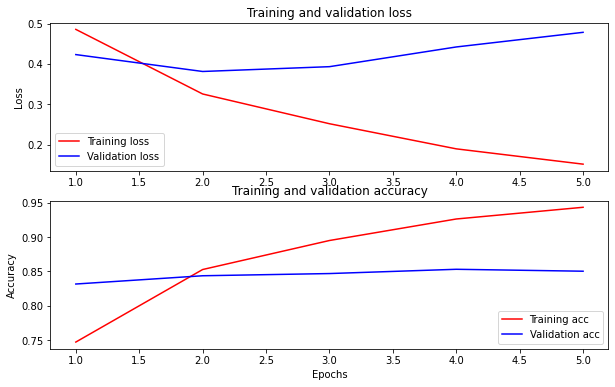

In [21]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In this plot, the red lines represents the training loss and accuracy, and the blue lines are the validation loss and accuracy.

## Export for inference

Now you just save your fine-tuned model for later use.

In [22]:
dataset_name = 'imdb'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)

Let's reload the model so you can try it side by side with the model that is still in memory.

In [23]:
reloaded_model = tf.saved_model.load(saved_model_path)

Here you can test your model on any sentence you want, just add to the examples variable below.

In [24]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


examples = [
    'this is such an amazing movie!',  # this is the same sentence tried earlier
    'The movie was great!',
    'The movie was meh.',
    'The movie was okish.',
    'The movie was terrible...'
]

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
original_results = tf.sigmoid(classifier_model(tf.constant(examples)))

print('Results from the saved model:')
print_my_examples(examples, reloaded_results)
print('Results from the model in memory:')
print_my_examples(examples, original_results)

Results from the saved model:
input: this is such an amazing movie! : score: 0.999509
input: The movie was great!           : score: 0.994210
input: The movie was meh.             : score: 0.892940
input: The movie was okish.           : score: 0.021850
input: The movie was terrible...      : score: 0.001355

Results from the model in memory:
input: this is such an amazing movie! : score: 0.999509
input: The movie was great!           : score: 0.994210
input: The movie was meh.             : score: 0.892940
input: The movie was okish.           : score: 0.021850
input: The movie was terrible...      : score: 0.001355



If you want to use your model on [TF Serving](https://www.tensorflow.org/tfx/guide/serving), remember that it will call your SavedModel through one of its named signatures. In Python, you can test them as follows:

In [25]:
serving_results = reloaded_model \
            .signatures['serving_default'](tf.constant(examples))

serving_results = tf.sigmoid(serving_results['classifier'])

print_my_examples(examples, serving_results)

input: this is such an amazing movie! : score: 0.999509
input: The movie was great!           : score: 0.994210
input: The movie was meh.             : score: 0.892940
input: The movie was okish.           : score: 0.021850
input: The movie was terrible...      : score: 0.001355



## Next steps

As a next step, you can try [Solve GLUE tasks using BERT on a TPU tutorial](https://www.tensorflow.org/tutorials/text/solve_glue_tasks_using_bert_on_tpu) which runs on a TPU and shows you how to work with multiple inputs.